## 4.5 RNN

### RNN
* Recurrent Neural Network, 순환 신경망
* 과거의 행위가 다음 판단에 영향을 미치는 경우
* 고정 데이터가 아닌 순서가 있는 데이터
    * 예) 우와! 참 재밌네 vs 망할 참 재밌네!
* 구글 번역 서비스
    * Seq2Seq 신경망 모델
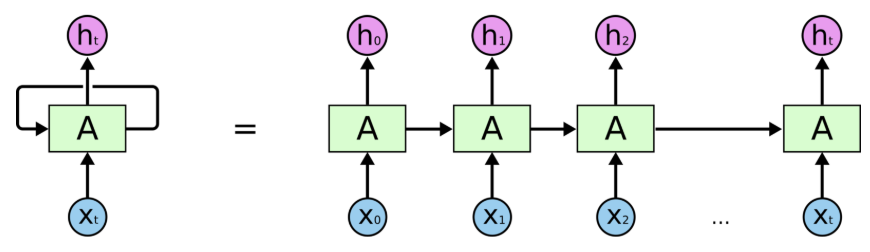

### 순환 신경망
* 시퀀스 데이터 처리할 수 있는 방법
    * RNN
    * 1D Convnet
* 주요 사례
    * 문서 분류, 시계열 분류
    * 감성분석
* 특징
    * 이전 상태 유지
    ```python
    state = 0
    for input in inputs:
        outout, state = rnn_cell(input, state)
    ```
*  RNN 구조 유형
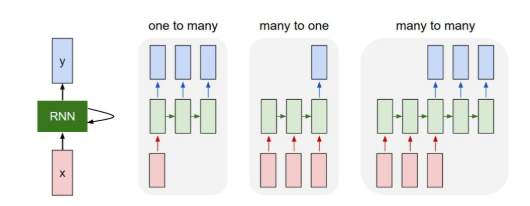
* RNN 개선
    * LSTM(Long Short Term Memory)
    * GRU

### Vanilla RNN
* 상태는 한개의 히든 벡터 H 로 구성
* $h_t = fw(h_{t-1}, x_t)$
    * $h_t = tanh(W_{hh}h_{t-1} + W_{xh}x_t + b_h)$
    * $ y_t = W_{hy}h_t + b_y $
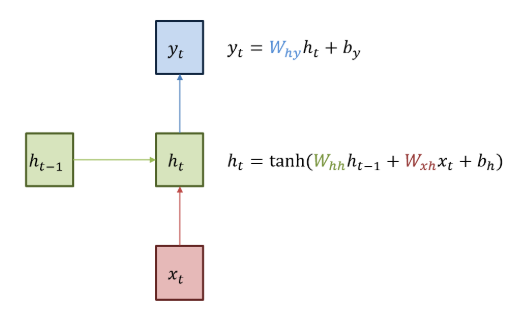
* 학습할 변수들
    * $W_{hx}$, $W_{hh}$, $b_h$
    * $W_{hy}$, $b_y$

### Vanilla RNN Graph
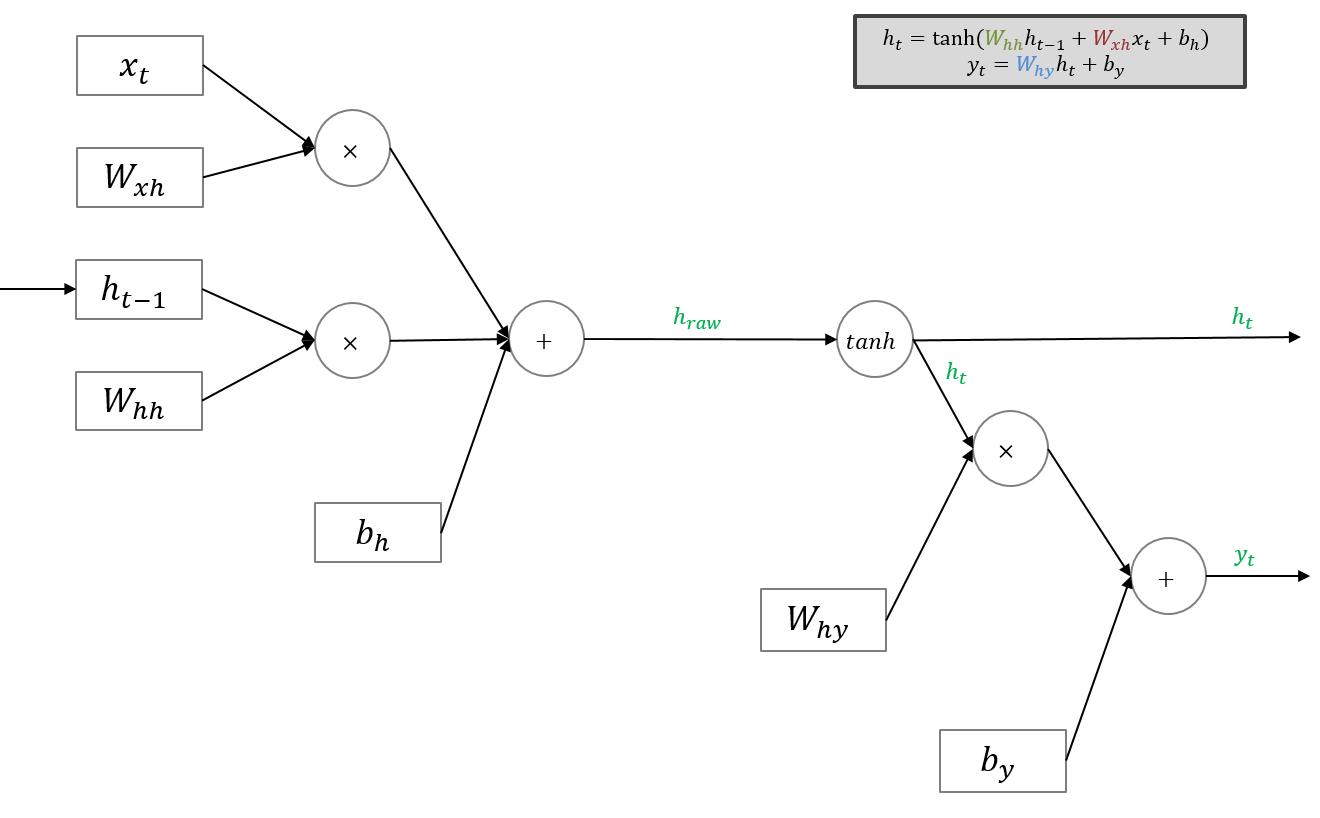

### Vanila RNN 실습
* RNN 구조를 직접 만들어 다음 글자 예측 실습
    * 입력 : "hihell"
    * 출력 : "ihello"
    * many to many
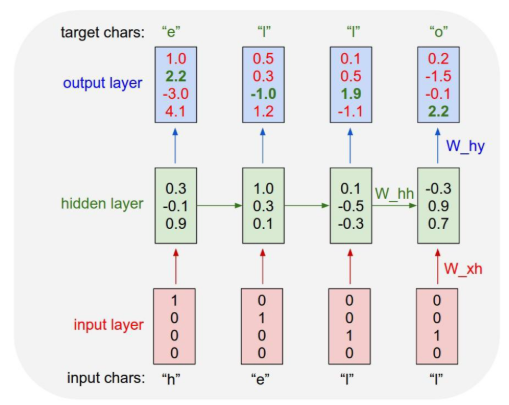

#### 입출력 데이타 준비

In [1]:
import tensorflow as tf
import numpy as np

sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
dic2idx = {i:c for i, c in enumerate(voca)}
print(dic, dic2idx)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)

{'h': 0, 'l': 1, 'i': 2, 'e': 3, 'o': 4} {0: 'h', 1: 'l', 2: 'i', 3: 'e', 4: 'o'}
x_idx: [0, 2, 0, 3, 1, 1]
y_idx: [2, 0, 3, 1, 1, 4]
x_enc: [[[1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]]] (1, 6, 5)


#### hidden state 준비

In [2]:
X = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="input" )
Y = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="output")

initializer= tf.glorot_uniform_initializer()
Wx = tf.Variable(initializer([n_class, hidden_size]), name="Wx" )
Wh = tf.Variable(initializer([hidden_size, hidden_size]), name="Wh" )
bh = tf.Variable(initializer([hidden_size]), name="bias_h" )

Instructions for updating:
Colocations handled automatically by placer.


#### hidden state 연산

In [3]:
def rnn_step(previous_hidden_state, x):
    current_hidden_state = tf.tanh(
        tf.matmul(previous_hidden_state, Wh) + 
        tf.matmul(x, Wx) + bh)
    return current_hidden_state


X_ = tf.transpose(X, perm=[1, 0, 2])
all_hidden_states = tf.scan(rnn_step, X_, name='states')#, initializer=init_hidden)

#### 출력 연산

In [4]:
Wy = tf.Variable(tf.truncated_normal([hidden_size, n_class], mean=0, stddev=0.01))
by = tf.Variable(tf.truncated_normal([n_class], mean=0, stddev=0.01))

def get_linear_layer(hidden_state):
    return tf.matmul(hidden_state, Wy) + by

all_outputs = tf.map_fn(get_linear_layer, all_hidden_states)

#### 신경망 학습

In [6]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=all_outputs, labels=Y))

learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
prediction = tf.argmax(all_outputs, axis=2)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_epoch = 500
    for step in range(n_epoch):
        sess.run([ train_step], feed_dict={X:x_enc, Y:y_enc})
        if (step+1) % 20 == 0:
            if step+ 1== n_epoch :
                ao = sess.run(all_outputs, feed_dict={X:x_enc})
                print(ao)
            cost, p = sess.run([cross_entropy, prediction], feed_dict={X:x_enc, Y:y_enc})
            print("step:{}, cost:{}, predict:{}, str:{}".format(step, cost, np.squeeze(p), [dic2idx[i] for i in np.squeeze(p)]))

step:19, cost:1.5622097253799438, predict:[2 1 1 1 1 1], str:['i', 'l', 'l', 'l', 'l', 'l']
step:39, cost:1.5116010904312134, predict:[2 1 1 1 1 1], str:['i', 'l', 'l', 'l', 'l', 'l']
step:59, cost:1.4602197408676147, predict:[2 1 1 1 1 1], str:['i', 'l', 'l', 'l', 'l', 'l']
step:79, cost:1.4093422889709473, predict:[2 1 1 1 1 1], str:['i', 'l', 'l', 'l', 'l', 'l']
step:99, cost:1.359113097190857, predict:[2 1 1 1 1 1], str:['i', 'l', 'l', 'l', 'l', 'l']
step:119, cost:1.3091453313827515, predict:[2 0 1 1 1 1], str:['i', 'h', 'l', 'l', 'l', 'l']
step:139, cost:1.2592612504959106, predict:[2 0 3 1 1 1], str:['i', 'h', 'e', 'l', 'l', 'l']
step:159, cost:1.2095156908035278, predict:[2 0 3 1 1 1], str:['i', 'h', 'e', 'l', 'l', 'l']
step:179, cost:1.1601762771606445, predict:[2 0 3 1 1 1], str:['i', 'h', 'e', 'l', 'l', 'l']
step:199, cost:1.111865520477295, predict:[2 0 3 1 1 1], str:['i', 'h', 'e', 'l', 'l', 'l']
step:219, cost:1.0652700662612915, predict:[2 0 3 1 1 1], str:['i', 'h', 'e',

### TF RNN API
* `cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_size)`
    * RNN 구현을 위해 필요한 변수 선언 및 구조 제공
    * `hidden_size` : output, state size
* `outputs, states = tf.nn.dynamic_rnn(cell, X, dtype)`
    * rnn_cell을 전달 받아 반복(tf.scan()) 연산해서 output과 state 계산

In [18]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

x_data = np.array([[[1,2,3,4],
                    [5,6,7,8]]], dtype=np.float32) #(1,2,4) : (batch, time_step, depth)
print(x_data.shape)

hidden_size = 2
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_size)
print(cell.output_size, cell.state_size)
outputs, states = tf.nn.dynamic_rnn(cell, x_data, dtype=tf.float32)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
output_, states_ = sess.run([outputs, states])
sess.close()
print(output_, states_)


(1, 2, 4)
2 2
[[[ 0.24207196  0.9973034 ]
  [-0.7008234   0.9999829 ]]] [[-0.7008234  0.9999829]]


#### TF RNN API로 "hi hello" 구현

In [37]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()
sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
dic2idx = {i:c for i, c in enumerate(voca)}
print(dic, dic2idx)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)

{'h': 0, 'l': 1, 'i': 2, 'e': 3, 'o': 4} {0: 'h', 1: 'l', 2: 'i', 3: 'e', 4: 'o'}
x_idx: [0, 2, 0, 3, 1, 1]
y_idx: [2, 0, 3, 1, 1, 4]
x_enc: [[[1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]]] (1, 6, 5)


In [38]:
X = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="input" )
Y = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="output")

cell = tf.nn.rnn_cell.BasicRNNCell(hidden_size)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

initializer= tf.glorot_uniform_initializer()
Wy = tf.Variable(initializer([hidden_size, n_class]))
by = tf.Variable(initializer([n_class]))

def get_linear_layer(hidden_state):
    return tf.matmul(hidden_state, Wy) + by

all_outputs = tf.map_fn(get_linear_layer, outputs)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=all_outputs, labels=Y))

learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
prediction = tf.argmax(all_outputs, axis=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_epoch = 500
    for step in range(n_epoch):
        sess.run([ train_step], feed_dict={X:x_enc, Y:y_enc})
        if (step+1) % 20 == 0:
            if step+ 1== n_epoch :
                ao = sess.run(all_outputs, feed_dict={X:x_enc})
                print(ao)
            cost, p = sess.run([cross_entropy, prediction], feed_dict={X:x_enc, Y:y_enc})
            print("step:{}, cost:{}, predict:{}, str:{}".format(step, cost, np.squeeze(p), [dic2idx[i] for i in np.squeeze(p)]))                 

step:19, cost:1.6352006196975708, predict:[4 4 0 4 3 0], str:['o', 'o', 'h', 'o', 'e', 'h']
step:39, cost:1.551277756690979, predict:[4 0 0 4 3 0], str:['o', 'h', 'h', 'o', 'e', 'h']
step:59, cost:1.4730669260025024, predict:[4 0 2 4 3 4], str:['o', 'h', 'i', 'o', 'e', 'o']
step:79, cost:1.401114821434021, predict:[4 0 2 4 3 4], str:['o', 'h', 'i', 'o', 'e', 'o']
step:99, cost:1.3348385095596313, predict:[2 0 2 4 3 4], str:['i', 'h', 'i', 'o', 'e', 'o']
step:119, cost:1.273011565208435, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l', 'l', 'o']
step:139, cost:1.2145699262619019, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l', 'l', 'o']
step:159, cost:1.1587098836898804, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l', 'l', 'o']
step:179, cost:1.1048619747161865, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l', 'l', 'o']
step:199, cost:1.05260169506073, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l', 'l', 'o']
step:219, cost:1.001578688621521, predict:[2 0 2 1 1 4], str:['i', 'h', 'i', 'l'

## LSTM
* Long Short-Term Memory Unit
* Hochreiter(1997) 제안, RNN 변형 
* 자연어 처리 분야 딥러닝 기법 중 가장 활발히 사용
* RNN의 맨 뒤에서 맨 앞의 정보를 기억하지 못하는 특성 보완
* RNN의 Hidden state에 cell-state를 추가
* 오차의 그라디언트가 시간을 거슬러 잘 흘러갈 수 있다.
* 1000단계가 넘는 Backpropagation 과정에서 오차 값 유지
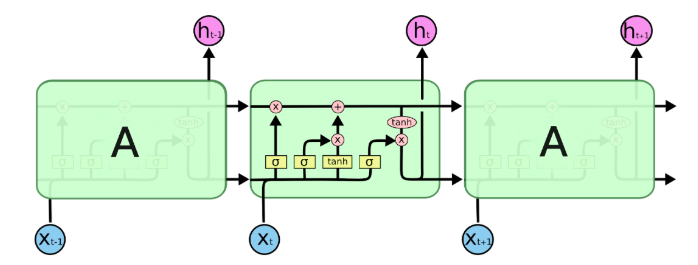

* Hidden Layer를 4개의 계층으로 구성
    * Cell State : 이전 정보를 다음 단계로 전달, 3가지 게이트에 의해 전달 여부 결정
    * Forget Gate : 기존 Cell State에서 어떠한 정보를 지울 지 결정
    * Input Gate : Cell State에 저장할 새로운 정보를 결정
    * Output Gate : Cell State 값을 다음 상태로 출력할 지 결정

### GRUCell
* Gated Recurrent Units
* 2014 뉴욕대 조경현 교수 제안
* LSTM의 변형, 더 간단한 구조
* 게이트 된 순환 유닛(Gate Recurrent Unit)
* 잊기와 입력 게이트들을 하나의 단일 Update 게이트로 통합
* 셀 상태와 숨겨진 상태 통합
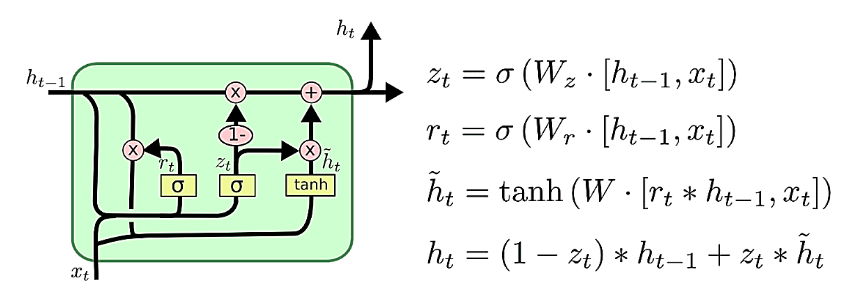

### LSTM/GRU를 이용한 "hihello" 실습
* `tf.nn.rnn_cell.BasicLSTMCell()`
* `tf.nn.rnn_cell.GRUCell()`

In [45]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()
sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
dic2idx = {i:c for i, c in enumerate(voca)}
print(dic, dic2idx)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)

X = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="input" )
Y = tf.placeholder(tf.float32, [None, n_time_steps, n_class], name="output")

############# Cell Selecte ##############################
cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_size)
#cell = tf.nn.rnn_cell.GRUCell(hidden_size)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

initializer= tf.glorot_uniform_initializer()
Wy = tf.Variable(initializer([hidden_size, n_class]))
by = tf.Variable(initializer([n_class]))

def get_linear_layer(hidden_state):
    return tf.matmul(hidden_state, Wy) + by

all_outputs = tf.map_fn(get_linear_layer, outputs)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=all_outputs, labels=Y))

learning_rate = 0.001
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
prediction = tf.argmax(all_outputs, axis=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_epoch = 1000
    for step in range(n_epoch):
        sess.run([ train_step], feed_dict={X:x_enc, Y:y_enc})
        if (step+1) % 100 == 0:
            if step+ 1== n_epoch :
                ao = sess.run(all_outputs, feed_dict={X:x_enc})
                print(ao)
            cost, p = sess.run([cross_entropy, prediction], feed_dict={X:x_enc, Y:y_enc})
            print("step:{}, cost:{}, predict:{}, str:{}".format(step, cost, np.squeeze(p), [dic2idx[i] for i in np.squeeze(p)]))                 

{'h': 0, 'l': 1, 'i': 2, 'e': 3, 'o': 4} {0: 'h', 1: 'l', 2: 'i', 3: 'e', 4: 'o'}
x_idx: [0, 2, 0, 3, 1, 1]
y_idx: [2, 0, 3, 1, 1, 4]
x_enc: [[[1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]]] (1, 6, 5)
step:99, cost:1.513102412223816, predict:[2 0 1 4 4 4], str:['i', 'h', 'l', 'o', 'o', 'o']
step:199, cost:1.2572771310806274, predict:[1 1 1 1 1 4], str:['l', 'l', 'l', 'l', 'l', 'o']
step:299, cost:1.0543793439865112, predict:[1 1 1 1 1 4], str:['l', 'l', 'l', 'l', 'l', 'o']
step:399, cost:0.8837220072746277, predict:[2 0 3 1 1 4], str:['i', 'h', 'e', 'l', 'l', 'o']
step:499, cost:0.7439799308776855, predict:[2 0 3 1 1 4], str:['i', 'h', 'e', 'l', 'l', 'o']
step:599, cost:0.6213607788085938, predict:[2 0 3 1 1 4], str:['i', 'h', 'e', 'l', 'l', 'o']
step:699, cost:0.4923560321331024, predict:[

In [3]:
# Lab 12 RNN
import tensorflow as tf
import numpy as np

tf.reset_default_graph()
tf.set_random_seed(777)  # reproducibility

idx2char = ['h', 'i', 'e', 'l', 'o']
# Teach hello: hihell -> ihello
x_data = [[0, 1, 0, 2, 3, 3]]   # hihell
x_one_hot = [[[1, 0, 0, 0, 0],   # h 0
              [0, 1, 0, 0, 0],   # i 1
              [1, 0, 0, 0, 0],   # h 0
              [0, 0, 1, 0, 0],   # e 2
              [0, 0, 0, 1, 0],   # l 3
              [0, 0, 0, 1, 0]]]  # l 3

y_data = [[1, 0, 2, 3, 3, 4]]    # ihello

num_classes = 5
input_dim = 5  # one-hot size
hidden_size = 5  # output from the LSTM. 5 to directly predict one-hot
batch_size = 1   # one sentence
sequence_length = 6  # |ihello| == 6
learning_rate = 0.1

X = tf.placeholder(
    tf.float32, [None, sequence_length, input_dim])  # X one-hot
Y = tf.placeholder(tf.int32, [None, sequence_length])  # Y label

cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_size, state_is_tuple=True)
initial_state = cell.zero_state(batch_size, tf.float32)
outputs, _states = tf.nn.dynamic_rnn(
    cell, X, initial_state=initial_state, dtype=tf.float32)

# FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])
# fc_w = tf.get_variable("fc_w", [hidden_size, num_classes])
# fc_b = tf.get_variable("fc_b", [num_classes])
# outputs = tf.matmul(X_for_fc, fc_w) + fc_b
outputs = tf.contrib.layers.fully_connected(
    inputs=X_for_fc, num_outputs=num_classes, activation_fn=None)

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

weights = tf.ones([batch_size, sequence_length])
sequence_loss = tf.contrib.seq2seq.sequence_loss(
    logits=outputs, targets=Y, weights=weights)
loss = tf.reduce_mean(sequence_loss)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

prediction = tf.argmax(outputs, axis=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50):
        l, _ = sess.run([loss, train], feed_dict={X: x_one_hot, Y: y_data})
        result = sess.run(prediction, feed_dict={X: x_one_hot})
        if i%5 == 0:
            print(i, "loss:", l, "prediction: ", result, "true Y: ", y_data)

            # print char using dic
            result_str = [idx2char[c] for c in np.squeeze(result)]
            print("\tPrediction str: ", ''.join(result_str))

0 loss: 1.6078762 prediction:  [[3 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  llllll
5 loss: 1.140437 prediction:  [[1 3 3 3 3 3]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  illlll
10 loss: 0.5427577 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
15 loss: 0.13267992 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
20 loss: 0.026444651 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
25 loss: 0.008979983 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
30 loss: 0.0041195056 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
35 loss: 0.0024560052 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
40 loss: 0.0017534182 prediction:  [[1 0 2 3 3 4]] true Y:  [[1, 0, 2, 3, 3, 4]]
	Prediction str:  ihello
45 loss: 0.001378979 prediction:  [[1 0 2 3 3 4]] true Y:  [[1

### tf.keras API 사용 'hihello' 예제 실습

In [71]:
import tensorflow as tf

keras = tf.keras

sentence = "hihello"
x = "hihell"
y = "ihello"

voca = list({c for c in sentence})
dic = {c:i for i,c in enumerate(voca)}
print(dic)

n_class = len(dic)  #example size
n_time_steps = len(x) #sequence
hidden_size = n_class #output size

x_idx = [dic[c] for c in x]
print("x_idx:", x_idx)
y_idx = [dic[c] for c in y]
print("y_idx:", y_idx)

x_enc =tf.keras.utils.to_categorical(x_idx, num_classes=n_class)
x_enc = np.expand_dims(x_enc, axis=0)
print("x_enc:", x_enc, x_enc.shape, )

y_enc = tf.keras.utils.to_categorical(y_idx, num_classes=n_class)
y_enc = np.expand_dims(y_enc, axis=0)
print("y_enc:", y_enc, y_enc.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM((hidden_size), input_shape=(n_time_steps, n_class), return_sequences=True))
model.add(keras.layers.Dense(hidden_size))
model.add(keras.layers.Activation('softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

n_epochs = 500
model.fit(x_enc, np.reshape(y_idx, (1,6,1)), epochs=n_epochs)

preds = model.predict(x_enc, verbose=0)
print(preds, np.squeeze(np.argmax(preds, axis=2)))
print([voca[i] for i in np.squeeze(np.argmax(preds, axis=2))])

{'h': 0, 'l': 1, 'i': 2, 'e': 3, 'o': 4} {0: 'h', 1: 'l', 2: 'i', 3: 'e', 4: 'o'}
x_idx: [0, 2, 0, 3, 1, 1]
y_idx: [2, 0, 3, 1, 1, 4]
x_enc: [[[1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]] (1, 6, 5)
y_enc: [[[0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]]] (1, 6, 5)
Epoch 1/500
1/1 [==============================] - 1s 841ms/sample - loss: 1.6758 - acc: 0.0000e+00
Epoch 2/500
1/1 [==============================] - 0s 18ms/sample - loss: 1.6744 - acc: 0.0000e+00
Epoch 3/500
1/1 [==============================] - 0s 18ms/sample - loss: 1.6729 - acc: 0.0000e+00
Epoch 4/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.6715 - acc: 0.0000e+00
Epoch 5/500
1/1 [==============================] - 0s 19ms/sample - loss: 1.6702 - acc: 0.0000e+00
Epoch 6/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.6688 - acc: 0.0000e+00
Epoch

1/1 [==============================] - 0s 15ms/sample - loss: 1.5820 - acc: 0.3333
Epoch 82/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.5809 - acc: 0.3333
Epoch 83/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.5798 - acc: 0.3333
Epoch 84/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.5787 - acc: 0.3333
Epoch 85/500
1/1 [==============================] - 0s 13ms/sample - loss: 1.5776 - acc: 0.3333
Epoch 86/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.5765 - acc: 0.3333
Epoch 87/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.5754 - acc: 0.3333
Epoch 88/500
1/1 [==============================] - 0s 14ms/sample - loss: 1.5743 - acc: 0.3333
Epoch 89/500
1/1 [==============================] - 0s 14ms/sample - loss: 1.5731 - acc: 0.3333
Epoch 90/500
1/1 [==============================] - 0s 13ms/sample - loss: 1.5720 - acc: 0.3333
Epoch 91/500
1/1 [==============================] - 0

Epoch 166/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.4573 - acc: 0.3333
Epoch 167/500
1/1 [==============================] - 0s 14ms/sample - loss: 1.4553 - acc: 0.3333
Epoch 168/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.4533 - acc: 0.3333
Epoch 169/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.4513 - acc: 0.3333
Epoch 170/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.4492 - acc: 0.3333
Epoch 171/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.4472 - acc: 0.3333
Epoch 172/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.4451 - acc: 0.3333
Epoch 173/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.4430 - acc: 0.3333
Epoch 174/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.4409 - acc: 0.3333
Epoch 175/500
1/1 [==============================] - 0s 18ms/sample - loss: 1.4388 - acc: 0.3333
Epoch 176/500
1/1 [===========

Epoch 251/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.2626 - acc: 0.3333
Epoch 252/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.2602 - acc: 0.3333
Epoch 253/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.2578 - acc: 0.3333
Epoch 254/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.2553 - acc: 0.3333
Epoch 255/500
1/1 [==============================] - 0s 18ms/sample - loss: 1.2529 - acc: 0.3333
Epoch 256/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.2505 - acc: 0.3333
Epoch 257/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.2481 - acc: 0.3333
Epoch 258/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.2456 - acc: 0.3333
Epoch 259/500
1/1 [==============================] - 0s 18ms/sample - loss: 1.2432 - acc: 0.3333
Epoch 260/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.2407 - acc: 0.3333
Epoch 261/500
1/1 [===========

Epoch 336/500
1/1 [==============================] - 0s 14ms/sample - loss: 1.0476 - acc: 0.6667
Epoch 337/500
1/1 [==============================] - 0s 13ms/sample - loss: 1.0453 - acc: 0.6667
Epoch 338/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.0430 - acc: 0.6667
Epoch 339/500
1/1 [==============================] - 0s 14ms/sample - loss: 1.0406 - acc: 0.6667
Epoch 340/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.0383 - acc: 0.6667
Epoch 341/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.0360 - acc: 0.6667
Epoch 342/500
1/1 [==============================] - 0s 19ms/sample - loss: 1.0338 - acc: 0.6667
Epoch 343/500
1/1 [==============================] - 0s 16ms/sample - loss: 1.0315 - acc: 0.6667
Epoch 344/500
1/1 [==============================] - 0s 17ms/sample - loss: 1.0292 - acc: 0.6667
Epoch 345/500
1/1 [==============================] - 0s 15ms/sample - loss: 1.0269 - acc: 0.6667
Epoch 346/500
1/1 [===========

Epoch 421/500
1/1 [==============================] - 0s 15ms/sample - loss: 0.8613 - acc: 0.8333
Epoch 422/500
1/1 [==============================] - 0s 15ms/sample - loss: 0.8593 - acc: 0.8333
Epoch 423/500
1/1 [==============================] - 0s 14ms/sample - loss: 0.8573 - acc: 0.8333
Epoch 424/500
1/1 [==============================] - 0s 14ms/sample - loss: 0.8553 - acc: 0.8333
Epoch 425/500
1/1 [==============================] - 0s 13ms/sample - loss: 0.8533 - acc: 0.8333
Epoch 426/500
1/1 [==============================] - 0s 14ms/sample - loss: 0.8513 - acc: 0.8333
Epoch 427/500
1/1 [==============================] - 0s 15ms/sample - loss: 0.8492 - acc: 0.8333
Epoch 428/500
1/1 [==============================] - 0s 14ms/sample - loss: 0.8472 - acc: 0.8333
Epoch 429/500
1/1 [==============================] - 0s 14ms/sample - loss: 0.8452 - acc: 0.8333
Epoch 430/500
1/1 [==============================] - 0s 15ms/sample - loss: 0.8432 - acc: 0.8333
Epoch 431/500
1/1 [===========

### MNIST 이미지
* many to one
* 28 * 28 숫자 이미지 : 시퀀스로서의 이미지
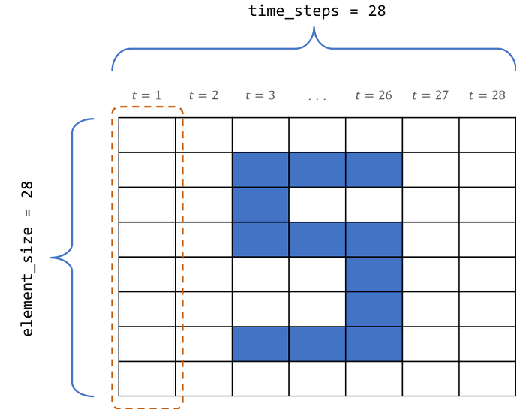

In [1]:
import tensorflow as tf

tf.reset_default_graph()

element_size = 28
time_steps = 28
num_classes = 10
batch_size = 128
hidden_layer_size = 128
# Where to save TensorBoard model summaries

# MNIST 데이터 불러오기 위한 함수 정의
def mnist_load():
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
    # Train set
    train_x = train_x.astype('float32') / 255.
    train_y = tf.keras.utils.to_categorical(train_y, num_classes=10)
    # Test set
    test_x = test_x.astype('float32') / 255.
    test_y = tf.keras.utils.to_categorical(test_y, num_classes=10)
    return (train_x, train_y), (test_x, test_y)
# MNIST 데이터 불러오기
(train_x, train_y), (test_x, test_y) = mnist_load()
dataset = tf.data.Dataset.from_tensor_slices(({"image": train_x}, train_y))
dataset = dataset.shuffle(100000).repeat().batch(batch_size)
iterator = dataset.make_one_shot_iterator()
next_batch = iterator.get_next()


_inputs = tf.placeholder(tf.float32, 
                           shape=[None, time_steps, element_size], 
                           name='inputs')
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='labels')

cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_layer_size)
#cell = tf.nn.rnn_cell.GRUCell(hidden_size)
outputs, states = tf.nn.dynamic_rnn(cell, _inputs, dtype=tf.float32)

Wl = tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], 
                                           mean=0, stddev=.01))
bl = tf.Variable(tf.truncated_normal([num_classes], 
                                           mean=0, stddev=.01))

# 상태 벡터에 linear layer 적용
def get_linear_layer(hidden_state):
    return tf.matmul(hidden_state, Wl) + bl

last_output = outputs[:,-1,:]
final_output =get_linear_layer(last_output)

cross_entropy = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits_v2(logits=final_output, labels=y))

learning_rate = 0.001
#train_step = tf.train.RMSPropOptimizer(learning_rate, 0.9).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(final_output, 1))
accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

test_data = test_x[:batch_size].reshape([-1, time_steps, element_size])
test_label = test_y[:batch_size]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())


    for step in range(10000):
        batch_x, batch_y = sess.run(next_batch)
        _ = sess.run([train_step], 
                            feed_dict={_inputs:batch_x['image'], y:batch_y})          

        if (step+1) % 1000 == 0:
            acc, loss = sess.run([accuracy, cross_entropy], 
                                feed_dict={_inputs:batch_x['image'], y:batch_y})
            print("Iter: %04d\t" % (step+1), 
                    "MiniBatch Loss: {:.6f}\t".format(loss),
                    "Training Acc={:.5f}".format(acc))
        if (step+1) % 100 == 0:
            acc = sess.run([accuracy], 
                            feed_dict={_inputs: test_data, 
                                    y: test_label})

    test_acc = sess.run(accuracy, feed_dict={_inputs: test_data,
                                            y: test_label})
    print("Test Accuracy:", test_acc)


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Iter: 1000	 MiniBatch Loss: 0.267757	 Training Acc=92.96875
Iter: 2000	 MiniBatch Loss: 0.116566	 Training Acc=96.09375
Iter: 3000	 MiniBatch Loss: 0.041355	 Training Acc=99.21875
Iter: 4000	 MiniBatch Loss: 0.015039	 Training Acc=100.00000
Iter: 5000	 MiniBatch Loss: 0.016399	 Training Acc=100.00000
Iter: 6000	 MiniBatch Loss: 0.062665	 Training Acc=98.43750
Iter: 7000	 MiniBatch Loss: 0.019586	 Training Acc=99.21875
Iter: 8000	 MiniBatch Loss: 0.002791	 Training Acc=100.00000
Iter: 9000	 MiniBatch Loss: 0.023169	 Training Acc=99.21875
Iter: 10000	 MiniBatch Loss: 0.000958	 Training Acc=100.00000
Test Accuracy: 99.21875




## 텍스트 데이터 다루기
* 텍스트가 가장 흔한 시퀀스 데이타
* 비전이 픽셀에 대한 패턴인식
* 자연어처리는 단어, 문장, 문단에 대한 패턴인식
* 입력데이타는 텍스트 원본일 수 없어서 텍스트 벡터화 필요
    * 텍스트를 단어로 나누고 각 단어를 하나의 벡터로 변환
    * 텍스트를 문자로 나누고 각 문자를 하나의 벡터로 변환
    * 텍스트에서 단어나 문자의 n-그램을 추출하여 그것을 하나의 벡터로 변환
        * n-gram: 문장에서 이웃한 N개의 문자
        * n-gram은 연속된 단어나 문자의 그룹으로 텍스트에서 단어나 문자를 하나씩 이동하면서 추출
            * "The cat sat on the mat"
                * 2-gram : "The", "The cat", "cat", "cat sat", "sat", "sat on", "on", "on the", "the", "the mat", "mat"
    * 어떻게 변환하든 이것을 토큰이라한다.
    * 토큰에 수치형 벡터 연결
        * 원핫 인코딩
        * 토큰 임베딩

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
tf.set_random_seed(777)  # reproducibility

sentence = ("A recurrent neural network is a class of artificial neural network "
            "where connections between units form a directed cycle. "
            "This allows it to exhibit dynamic temporal behavior. Unlike feedforward neural networks,"
            "RNNs can use their internal memory to process arbitrary sequences of inputs.")

print(sentence) 
char_set = list(set(sentence))

char_dic = {w: i for i, w in enumerate(char_set)}
print(char_dic)

data_dim = len(char_set)
hidden_size = len(char_set)
num_classes = len(char_set)
seq_length = 10  # Any arbitrary number

dataX = []
dataY = []
print(len(sentence))
for i in range(0, len(sentence) - seq_length):
    x_str = sentence[i:i + seq_length]
    y_str = sentence[i + 1: i + seq_length + 1]
    print(i, x_str, '->', y_str)

    x = [char_dic[c] for c in x_str]  # x str to index
    y = [char_dic[c] for c in y_str]  # y str to index

    dataX.append(x)
    dataY.append(y)


batch_size = len(dataX)
print('batch_size:', batch_size)

X = tf.placeholder(tf.int32, [None, seq_length])
Y = tf.placeholder(tf.int32, [None, seq_length])

# One-hot encoding
X_one_hot = tf.one_hot(X, num_classes)
print(X_one_hot)  # check out the shape

# Make a lstm cell with hidden_size (each unit output vector size)
cell = rnn.BasicLSTMCell(hidden_size, state_is_tuple=True)
cell = rnn.MultiRNNCell([cell] * 2, state_is_tuple=True)

# outputs: unfolding size x hidden size, state = hidden size
outputs, _states = tf.nn.dynamic_rnn(cell, X_one_hot, dtype=tf.float32)

print('output', outputs)
# (optional) softmax layer
X_for_softmax = tf.reshape(outputs, [-1, hidden_size])
softmax_w = tf.get_variable("softmax_w", [hidden_size, num_classes])
softmax_b = tf.get_variable("softmax_b", [num_classes])
outputs = tf.matmul(X_for_softmax, softmax_w) + softmax_b

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, seq_length, num_classes])
# All weights are 1 (equal weights)
weights = tf.ones([batch_size, seq_length])

sequence_loss = tf.contrib.seq2seq.sequence_loss(
    logits=outputs, targets=Y, weights=weights)
mean_loss = tf.reduce_mean(sequence_loss)
train_op = tf.train.AdamOptimizer(learning_rate=0.1).minimize(mean_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(500):
    _, l, results = sess.run(
        [train_op, mean_loss, outputs], feed_dict={X: dataX, Y: dataY})
    for j, result in enumerate(results):
        index = np.argmax(result, axis=1)
        print(i, j, ''.join([char_set[t] for t in index]), l)

# Let's print the last char of each result to check it works
results = sess.run(outputs, feed_dict={X: dataX})
# result=170
for j, result in enumerate(results):
    index = np.argmax(result, axis=1)
    if j is 0:  # print all for the first result to make a sentence
        print(''.join([char_set[t] for t in index]), end='')
    else:
        print(char_set[index[-1]], end='')

A recurrent neural network is a class of artificial neural network where connections between units form a directed cycle. This allows it to exhibit dynamic temporal behavior. Unlike feedforward neural networks,RNNs can use their internal memory to process arbitrary sequences of inputs.
{'w': 0, 'c': 1, 'x': 2, 't': 3, 'N': 4, 'h': 5, 'f': 6, 'R': 7, 'T': 8, '.': 9, 's': 10, 'b': 11, 'l': 12, 'e': 13, 'A': 14, 'v': 15, ' ': 16, 'a': 17, 'd': 18, 'y': 19, ',': 20, 'i': 21, 'n': 22, 'U': 23, 'o': 24, 'k': 25, 'p': 26, 'm': 27, 'q': 28, 'r': 29, 'u': 30}
286
0 A recurren ->  recurrent
1  recurrent -> recurrent 
2 recurrent  -> ecurrent n
3 ecurrent n -> current ne
4 current ne -> urrent neu
5 urrent neu -> rrent neur
6 rrent neur -> rent neura
7 rent neura -> ent neural
8 ent neural -> nt neural 
9 nt neural  -> t neural n
10 t neural n ->  neural ne
11  neural ne -> neural net
12 neural net -> eural netw
13 eural netw -> ural netwo
14 ural netwo -> ral networ
15 ral networ -> al network
1

output Tensor("rnn_1/transpose_1:0", shape=(?, 10, 31), dtype=float32)
0 0 yyyyyyyyyy 3.483819
0 1 yyyyyyyyyy 3.483819
0 2 yyyyyyyyyy 3.483819
0 3 yyyyyyyyyy 3.483819
0 4 yyyyyyyyyy 3.483819
0 5 yyyyyyyyyy 3.483819
0 6 yyyyyyyyyy 3.483819
0 7 yyyyyyyyyy 3.483819
0 8 yyyyyyyyyy 3.483819
0 9 yyyyyyyyyy 3.483819
0 10 yyyyyyyyyy 3.483819
0 11 yyyyyyyyyy 3.483819
0 12 yyyyyyyyyy 3.483819
0 13 yyyyyyyyyy 3.483819
0 14 yyyyyyyyyy 3.483819
0 15 yyyyyyyyyy 3.483819
0 16 yyyyyyyyyy 3.483819
0 17 yyyyyyyyyy 3.483819
0 18 yyyyyyyyyy 3.483819
0 19 yyyyyyyyyy 3.483819
0 20 yyyyyyyyyy 3.483819
0 21 yyyyyyyyyy 3.483819
0 22 yyyyyyyyyy 3.483819
0 23 yyyyyyyyyy 3.483819
0 24 yyyyyyyyyy 3.483819
0 25 yyyyyyyyyy 3.483819
0 26 yyyyyyyyyy 3.483819
0 27 yyyyyyyyyy 3.483819
0 28 yyyyyyyyyy 3.483819
0 29 yyyyyyyyyy 3.483819
0 30 yyyyyyyyyy 3.483819
0 31 yyyyyyyyyy 3.483819
0 32 yyyyyyyyyy 3.483819
0 33 yyyyyyyyyy 3.483819
0 34 yyyyyyyyyy 3.483819
0 35 yyyyyyyyyy 3.483819
0 36 yyyyyyyyyy 3.483819
0 37 yyyyyyyyy

1 131 nnnnnnnnnn 3.282422
1 132 nnnnnnnnnn 3.282422
1 133 nnnnnnnnnn 3.282422
1 134 nnnnnnnnnn 3.282422
1 135 nnnnnnnnnn 3.282422
1 136 nnnnnnnnnn 3.282422
1 137 nnnnnnnnnn 3.282422
1 138 nnnnnnnnnn 3.282422
1 139 nnnnnnnnnn 3.282422
1 140 nnnnnnnnnn 3.282422
1 141 nnnnnnnnnn 3.282422
1 142 nnnnnnnnnn 3.282422
1 143 nnnnnnnnnn 3.282422
1 144 nnnnnnnnnn 3.282422
1 145 nnnnnnnnnn 3.282422
1 146 nnnnnnnnnn 3.282422
1 147 nnnnnnnnnn 3.282422
1 148 nnnnnnnnnn 3.282422
1 149 nnnnnnnnnn 3.282422
1 150 nnnnnnnnnn 3.282422
1 151 nnnnnnnnnn 3.282422
1 152 nnnnnnnnnn 3.282422
1 153 nnnnnnnnnn 3.282422
1 154 nnnnnnnnnn 3.282422
1 155 nnnnnnnnnn 3.282422
1 156 nnnnnnnnnn 3.282422
1 157 nnnnnnnnnn 3.282422
1 158 nnnnnnnnnn 3.282422
1 159 nnnnnnnnnn 3.282422
1 160 nnnnnnnnnn 3.282422
1 161 nnnnnnnnnn 3.282422
1 162 nnnnnnnnnn 3.282422
1 163 nnnnnnnnnn 3.282422
1 164 nnnnnnnnnn 3.282422
1 165 nnnnnnnnnn 3.282422
1 166 nnnnnnnnnn 3.282422
1 167 nnnnnnnnnn 3.282422
1 168 nnnnnnnnnn 3.282422
1 169 nnnnnn

3 209 ottttttttt 3.109255
3 210 oiaaaaaaaa 3.109255
3 211 oiaaaaaaaa 3.109255
3 212 oiaaaaaaaa 3.109255
3 213 iiaaaaaaaa 3.109255
3 214 iiaaaaaaaa 3.109255
3 215 iiaaaaaaaa 3.109255
3 216 iiaaaaaaaa 3.109255
3 217 iiaaaaaaaa 3.109255
3 218 iiaaaaaaaa 3.109255
3 219 oaaaaaaaaa 3.109255
3 220 iiaaaaaaaa 3.109255
3 221 oiaaaaaaaa 3.109255
3 222 iiaaaaaaaa 3.109255
3 223 oiaaaaaatt 3.109255
3 224 iiaaattttt 3.109255
3 225 oiaaaaaaaa 3.109255
3 226 iiaaaaaatt 3.109255
3 227 iiaaaaaaaa 3.109255
3 228 iiaaaaaaaa 3.109255
3 229 iiaaaaaaaa 3.109255
3 230 iiaaaaaaaa 3.109255
3 231 oiaaaaaaaa 3.109255
3 232 oiaaaaaaaa 3.109255
3 233 iiaaaaaaaa 3.109255
3 234 iiaaaaaaaa 3.109255
3 235 iiaaaaaaaa 3.109255
3 236 oiaaaaaaaa 3.109255
3 237 iiaaaaaaaa 3.109255
3 238 oiaatttttt 3.109255
3 239 oiaaaatttt 3.109255
3 240 oiaatttttt 3.109255
3 241 iiaaaaattt 3.109255
3 242 iiaaaaaaaa 3.109255
3 243 oiaaaaaaaa 3.109255
3 244 iiaaaaaaaa 3.109255
3 245 oiaaaaaaaa 3.109255
3 246 iiaaaaaaaa 3.109255
3 247 iiaaaa

5 196            2.9935951
5 197            2.9935951
5 198            2.9935951
5 199            2.9935951
5 200            2.9935951
5 201            2.9935951
5 202            2.9935951
5 203            2.9935951
5 204            2.9935951
5 205            2.9935951
5 206            2.9935951
5 207            2.9935951
5 208            2.9935951
5 209            2.9935951
5 210            2.9935951
5 211            2.9935951
5 212            2.9935951
5 213            2.9935951
5 214            2.9935951
5 215            2.9935951
5 216            2.9935951
5 217            2.9935951
5 218            2.9935951
5 219            2.9935951
5 220            2.9935951
5 221            2.9935951
5 222            2.9935951
5 223            2.9935951
5 224            2.9935951
5 225            2.9935951
5 226            2.9935951
5 227            2.9935951
5 228            2.9935951
5 229            2.9935951
5 230            2.9935951
5 231            2.9935951
5 232            2.9935951
5

7 86            2.9470448
7 87            2.9470448
7 88            2.9470448
7 89            2.9470448
7 90            2.9470448
7 91            2.9470448
7 92            2.9470448
7 93            2.9470448
7 94            2.9470448
7 95            2.9470448
7 96            2.9470448
7 97            2.9470448
7 98            2.9470448
7 99            2.9470448
7 100            2.9470448
7 101            2.9470448
7 102            2.9470448
7 103            2.9470448
7 104            2.9470448
7 105            2.9470448
7 106            2.9470448
7 107            2.9470448
7 108            2.9470448
7 109            2.9470448
7 110            2.9470448
7 111            2.9470448
7 112            2.9470448
7 113            2.9470448
7 114            2.9470448
7 115            2.9470448
7 116            2.9470448
7 117            2.9470448
7 118            2.9470448
7 119            2.9470448
7 120            2.9470448
7 121            2.9470448
7 122            2.9470448
7 123          

8 259  eeeeeeeee 2.9410443
8 260  eeeeeeeee 2.9410443
8 261  eeeeeeeee 2.9410443
8 262  eeeeeeeee 2.9410443
8 263  eeeeeeeee 2.9410443
8 264  eeeeeeeee 2.9410443
8 265  eeeeeeeee 2.9410443
8 266  eeeeeeeee 2.9410443
8 267  eeeeeeeee 2.9410443
8 268  eeeeeeeee 2.9410443
8 269  eeeeeeeee 2.9410443
8 270  eeeeeeeee 2.9410443
8 271  eeeeeeeee 2.9410443
8 272  eeeeeeeee 2.9410443
8 273  eeeeeeeee 2.9410443
8 274  eeeeeeeee 2.9410443
8 275  eeeeeeeee 2.9410443
9 0  eeeeeeeee 2.9387631
9 1  eeeeeeeee 2.9387631
9 2  eeeeeeeee 2.9387631
9 3  eeeeeeeee 2.9387631
9 4  eeeeeeeee 2.9387631
9 5  eeeeeeeee 2.9387631
9 6  eeeeeeeee 2.9387631
9 7  eeeeeeeee 2.9387631
9 8  eeeeeeeee 2.9387631
9 9  eeeeeeeee 2.9387631
9 10  eeeeeeeee 2.9387631
9 11  eeeeeeeee 2.9387631
9 12  eeeeeeeee 2.9387631
9 13  eeeeeeeee 2.9387631
9 14  eeeeeeeee 2.9387631
9 15  eeeeeeeee 2.9387631
9 16  eeeeeeeee 2.9387631
9 17  eeeeeeeee 2.9387631
9 18  eeeeeeeee 2.9387631
9 19  eeeeeeeee 2.9387631
9 20  eeeeeeeee 2.9387631
9 21 

10 19  eeeeeeeee 2.9362135
10 20  eeeeeeeee 2.9362135
10 21  eeeeeeeee 2.9362135
10 22  eeeeeeeee 2.9362135
10 23  eeeeeeeee 2.9362135
10 24  eeeeeeeee 2.9362135
10 25  eeeeeeeee 2.9362135
10 26  eeeeeeeee 2.9362135
10 27  eeeeeeeee 2.9362135
10 28  eeeeeeeee 2.9362135
10 29  eeeeeeeee 2.9362135
10 30  eeeeeeeee 2.9362135
10 31  eeeeeeeee 2.9362135
10 32  eeeeeeeee 2.9362135
10 33  e eeeeeee 2.9362135
10 34  eeeeeeeee 2.9362135
10 35  eeeeeeeee 2.9362135
10 36  eeeeeeeee 2.9362135
10 37  eeeeeeeee 2.9362135
10 38  eeeeeeeee 2.9362135
10 39  eeeeeeeee 2.9362135
10 40  eeeeeeeee 2.9362135
10 41  eeeeeeeee 2.9362135
10 42  eeeeeeeee 2.9362135
10 43  eeeeeeeee 2.9362135
10 44  eeeeeeeee 2.9362135
10 45  eeeeeeeee 2.9362135
10 46  eeeeeeeee 2.9362135
10 47  eeeeeeeee 2.9362135
10 48  eeeeeeeee 2.9362135
10 49  eeeeeeeee 2.9362135
10 50  eeeeeeeee 2.9362135
10 51  eeeeeeeee 2.9362135
10 52  eeeeeeeee 2.9362135
10 53  eeeeeeeee 2.9362135
10 54  eeeeeeeee 2.9362135
10 55  eeeeeeeee 2.9362135
1

11 45            2.9317856
11 46            2.9317856
11 47            2.9317856
11 48            2.9317856
11 49            2.9317856
11 50            2.9317856
11 51            2.9317856
11 52            2.9317856
11 53            2.9317856
11 54            2.9317856
11 55            2.9317856
11 56            2.9317856
11 57            2.9317856
11 58            2.9317856
11 59            2.9317856
11 60            2.9317856
11 61            2.9317856
11 62            2.9317856
11 63            2.9317856
11 64            2.9317856
11 65            2.9317856
11 66            2.9317856
11 67            2.9317856
11 68            2.9317856
11 69            2.9317856
11 70            2.9317856
11 71            2.9317856
11 72            2.9317856
11 73  e         2.9317856
11 74            2.9317856
11 75            2.9317856
11 76            2.9317856
11 77            2.9317856
11 78            2.9317856
11 79            2.9317856
11 80            2.9317856
11 81            2.9317856
1

12 110            2.9256294
12 111            2.9256294
12 112            2.9256294
12 113            2.9256294
12 114            2.9256294
12 115            2.9256294
12 116            2.9256294
12 117            2.9256294
12 118            2.9256294
12 119            2.9256294
12 120            2.9256294
12 121            2.9256294
12 122            2.9256294
12 123            2.9256294
12 124            2.9256294
12 125            2.9256294
12 126            2.9256294
12 127            2.9256294
12 128            2.9256294
12 129            2.9256294
12 130            2.9256294
12 131            2.9256294
12 132            2.9256294
12 133            2.9256294
12 134            2.9256294
12 135            2.9256294
12 136            2.9256294
12 137            2.9256294
12 138            2.9256294
12 139            2.9256294
12 140            2.9256294
12 141            2.9256294
12 142            2.9256294
12 143            2.9256294
12 144            2.9256294
12 145            2.

13 133            2.9179537
13 134            2.9179537
13 135            2.9179537
13 136            2.9179537
13 137            2.9179537
13 138            2.9179537
13 139            2.9179537
13 140            2.9179537
13 141            2.9179537
13 142            2.9179537
13 143            2.9179537
13 144            2.9179537
13 145            2.9179537
13 146            2.9179537
13 147            2.9179537
13 148            2.9179537
13 149            2.9179537
13 150            2.9179537
13 151            2.9179537
13 152            2.9179537
13 153            2.9179537
13 154            2.9179537
13 155            2.9179537
13 156            2.9179537
13 157            2.9179537
13 158            2.9179537
13 159            2.9179537
13 160            2.9179537
13 161            2.9179537
13 162            2.9179537
13 163            2.9179537
13 164            2.9179537
13 165            2.9179537
13 166            2.9179537
13 167            2.9179537
13 168            2.

14 204            2.908324
14 205            2.908324
14 206            2.908324
14 207            2.908324
14 208            2.908324
14 209 rnrr       2.908324
14 210            2.908324
14 211            2.908324
14 212            2.908324
14 213            2.908324
14 214            2.908324
14 215            2.908324
14 216            2.908324
14 217            2.908324
14 218            2.908324
14 219            2.908324
14 220            2.908324
14 221            2.908324
14 222            2.908324
14 223            2.908324
14 224            2.908324
14 225            2.908324
14 226            2.908324
14 227            2.908324
14 228            2.908324
14 229            2.908324
14 230            2.908324
14 231            2.908324
14 232            2.908324
14 233            2.908324
14 234            2.908324
14 235            2.908324
14 236            2.908324
14 237            2.908324
14 238            2.908324
14 239            2.908324
14 240            2.908324
1

16 86            2.8787684
16 87            2.8787684
16 88            2.8787684
16 89            2.8787684
16 90            2.8787684
16 91            2.8787684
16 92            2.8787684
16 93            2.8787684
16 94            2.8787684
16 95            2.8787684
16 96            2.8787684
16 97            2.8787684
16 98            2.8787684
16 99            2.8787684
16 100            2.8787684
16 101            2.8787684
16 102            2.8787684
16 103            2.8787684
16 104            2.8787684
16 105            2.8787684
16 106            2.8787684
16 107            2.8787684
16 108            2.8787684
16 109            2.8787684
16 110            2.8787684
16 111            2.8787684
16 112            2.8787684
16 113            2.8787684
16 114            2.8787684
16 115            2.8787684
16 116            2.8787684
16 117            2.8787684
16 118            2.8787684
16 119            2.8787684
16 120            2.8787684
16 121            2.8787684
16 122

17 220            2.8561292
17 221            2.8561292
17 222            2.8561292
17 223            2.8561292
17 224            2.8561292
17 225            2.8561292
17 226            2.8561292
17 227            2.8561292
17 228            2.8561292
17 229            2.8561292
17 230            2.8561292
17 231            2.8561292
17 232            2.8561292
17 233            2.8561292
17 234            2.8561292
17 235            2.8561292
17 236            2.8561292
17 237            2.8561292
17 238            2.8561292
17 239            2.8561292
17 240            2.8561292
17 241            2.8561292
17 242            2.8561292
17 243            2.8561292
17 244            2.8561292
17 245            2.8561292
17 246            2.8561292
17 247            2.8561292
17 248            2.8561292
17 249            2.8561292
17 250            2.8561292
17 251            2.8561292
17 252            2.8561292
17 253            2.8561292
17 254            2.8561292
17 255            2.

19 73  r     r   2.800162
19 74       r    2.800162
19 75      r   r 2.800162
19 76     r   r  2.800162
19 77    r   r r 2.800162
19 78   r   r r  2.800162
19 79  r   r r   2.800162
19 80     r r    2.800162
19 81    r r     2.800162
19 82   r r      2.800162
19 83  r r     r 2.800162
19 84         r  2.800162
19 85        r   2.800162
19 86       r  r 2.800162
19 87      r  r  2.800162
19 88     r  r   2.800162
19 89    r  r  r 2.800162
19 90      r  r  2.800162
19 91  r  r  r r 2.800162
19 92    r  r r  2.800162
19 93      r r   2.800162
19 94  r  r r  r 2.800162
19 95    r r  r  2.800162
19 96   r r  r r 2.800162
19 97  r r  r r  2.800162
19 98   r  r r r 2.800162
19 99  r    r r  2.800162
19 100  r     r   2.800162
19 101     r r    2.800162
19 102    r r     2.800162
19 103   r r      2.800162
19 104  r r       2.800162
19 105   r      r 2.800162
19 106         r  2.800162
19 107        r   2.800162
19 108       r    2.800162
19 109      r     2.800162
19 110     r    r 2.800162
1

21 6  re  rerrr 2.7256765
21 7     rerrr  2.7256765
21 8    rerrr   2.7256765
21 9   rerrr  r 2.7256765
21 10  rerrr  r  2.7256765
21 11 eerrr  r r 2.7256765
21 12  rrr  r r  2.7256765
21 13  rr  r r r 2.7256765
21 14  r  r r rr 2.7256765
21 15    r r rrr 2.7256765
21 16   r r rrr  2.7256765
21 17  r r rrr r 2.7256765
21 18 eer rrr rr 2.7256765
21 19  r  rr rr  2.7256765
21 20    rr rr r 2.7256765
21 21   rr rr r  2.7256765
21 22  rr rr r r 2.7256765
21 23 rr rr r r  2.7256765
21 24   rr r re  2.7256765
21 25  rr r re r 2.7256765
21 26 er r re r  2.7256765
21 27 r r re r   2.7256765
21 28  r re r  r 2.7256765
21 29 eere r  rr 2.7256765
21 30  re r  rr  2.7256765
21 31 ee r  rr r 2.7256765
21 32   r  rr re 2.7256765
21 33  r  rr rer 2.7256765
21 34    rr rer  2.7256765
21 35   rr rer r 2.7256765
21 36  rr rer r  2.7256765
21 37 er rer r r 2.7256765
21 38 r rer r r  2.7256765
21 39  rer r r r 2.7256765
21 40 eer r r r  2.7256765
21 41  r r r r   2.7256765
21 42   r r r  r 2.7256765
21 43

22 91  rrer  r r 2.6858797
22 92 rrer  r rr 2.6858797
22 93  er  r rr  2.6858797
22 94  r  r rr r 2.6858797
22 95 r  r rr re 2.6858797
22 96   r rr rer 2.6858797
22 97  r rr rer  2.6858797
22 98 r rr rer r 2.6858797
22 99  rr rer rr 2.6858797
22 100 rr oer rr  2.6858797
22 101   rer rr e 2.6858797
22 102 erererr e  2.6858797
22 103 rer rree r 2.6858797
22 104  r rree r  2.6858797
22 105 r rree r r 2.6858797
22 106  rree r re 2.6858797
22 107 rree r re  2.6858797
22 108  re r re e 2.6858797
22 109  e r re e  2.6858797
22 110   r re e r 2.6858797
22 111  r re e r  2.6858797
22 112   re e r r 2.6858797
22 113  reee r r  2.6858797
22 114 re e r r   2.6858797
22 115  ee r r  r 2.6858797
22 116  e r r  r  2.6858797
22 117   r rr r r 2.6858797
22 118  r rr r re 2.6858797
22 119   rr r re  2.6858797
22 120  rr r re   2.6858797
22 121 rr r re  r 2.6858797
22 122   r re  rr 2.6858797
22 123  r re  rr  2.6858797
22 124 r re  rr r 2.6858797
22 125  re  rr rr 2.6858797
22 126 re  rr rr  2.6858797
2

23 160 rr  rereee 2.6455564
23 161    rereeer 2.6455564
23 162   rereeerr 2.6455564
23 163  r reeerre 2.6455564
23 164 rereeerre  2.6455564
23 165  reeerre r 2.6455564
23 166  eeerrr re 2.6455564
23 167 eeerrr ree 2.6455564
23 168   rrr ree  2.6455564
23 169  rrr ree r 2.6455564
23 170 rrr ree r  2.6455564
23 171 rr ree r r 2.6455564
23 172   ree r rr 2.6455564
23 173  ree r rr  2.6455564
23 174 rre r rr r 2.6455564
23 175  e r rr rr 2.6455564
23 176   r rr rr  2.6455564
23 177  r rr rr   2.6455564
23 178 r rr rr  r 2.6455564
23 179  rr rr  rr 2.6455564
23 180  r rr  rr  2.6455564
23 181 r rr  rr   2.6455564
23 182  rr  rr  r 2.6455564
23 183  r  rr  r  2.6455564
23 184    rr er r 2.6455564
23 185   rr er re 2.6455564
23 186  rr er rer 2.6455564
23 187 rr  r rerr 2.6455564
23 188   er rerrr 2.6455564
23 189  rr rerrr  2.6455564
23 190  r rerrr   2.6455564
23 191   rerrr  r 2.6455564
23 192  rerrr  re 2.6455564
23 193 rerrr  rer 2.6455564
23 194  rrr  rer  2.6455564
23 195  rr  rer   2.

25 56   rer orr  2.541951
25 57  rer orr r 2.541951
25 58 rer orr ro 2.541951
25 59 er orr roe 2.541951
25 60 r orr roer 2.541951
25 61  orr roerr 2.541951
25 62  rr roerr  2.541951
25 63 rr roerr r 2.541951
25 64   roerrere 2.541951
25 65  roerrerer 2.541951
25 66 rrerr rere 2.541951
25 67  errereree 2.541951
25 68 errerereer 2.541951
25 69 rrerereere 2.541951
25 70  rrereere  2.541951
25 71 rrereere r 2.541951
25 72 rereere rr 2.541951
25 73 ereere rre 2.541951
25 74 reere rre  2.541951
25 75 eere rre r 2.541951
25 76 ere rre re 2.541951
25 77 re rre r t 2.541951
25 78 e rre r t  2.541951
25 79  rre r t o 2.541951
25 80 rre r t or 2.541951
25 81 re r r orr 2.541951
25 82 e r r orre 2.541951
25 83  r r orrer 2.541951
25 84 rer orrerr 2.541951
25 85 er orrerre 2.541951
25 86 r orrerret 2.541951
25 87  orrerret  2.541951
25 88  rrerrer   2.541951
25 89 rrerrer  r 2.541951
25 90 rerrer  r  2.541951
25 91 errer  r r 2.541951
25 92 rrer  r rr 2.541951
25 93 eer  r rr  2.541951
25 94 er  r 

26 192  rerre  te 2.4912677
26 193 rerre  tet 2.4912677
26 194 erre  tet  2.4912677
26 195 rrr  tet o 2.4912677
26 196 ere tet or 2.4912677
26 197  e tet orr 2.4912677
26 198 e tet orr  2.4912677
26 199  ter orr   2.4912677
26 200 rer orr  t 2.4912677
26 201 er orr  tn 2.4912677
26 202 r orr  tnt 2.4912677
26 203  orr  tnte 2.4912677
26 204  rr  tnte  2.4912677
26 205 rr  tnte t 2.4912677
26 206    tnte te 2.4912677
26 207   trre tee 2.4912677
26 208  tree teee 2.4912677
26 209 rner teeee 2.4912677
26 210 rrr teeeee 2.4912677
26 211 re teeeee  2.4912677
26 212 r teeeee e 2.4912677
26 213  teeete tn 2.4912677
26 214 reeete en  2.4912677
26 215 eeete tn e 2.4912677
26 216 eete on er 2.4912677
26 217 ere tr err 2.4912677
26 218 rr tr err  2.4912677
26 219 e troerr e 2.4912677
26 220  troerr et 2.4912677
26 221 rro rr ete 2.4912677
26 222 roerr ete  2.4912677
26 223   rr ete r 2.4912677
26 224 err ete rr 2.4912677
26 225 rr ere rr  2.4912677
26 226 reere re e 2.4912677
26 227  tre rr e  2.

27 218 rr orw rr  2.4739041
27 219 e trw rr o 2.4739041
27 220  orw rr or 2.4739041
27 221 rrw rr ore 2.4739041
27 222 roerr ore  2.4739041
27 223   rr ore r 2.4739041
27 224 err ore rr 2.4739041
27 225 rr ore rr  2.4739041
27 226 retre rr t 2.4739041
27 227  tre rr e  2.4739041
27 228 rre rr e t 2.4739041
27 229 reorret te 2.4739041
27 230 eorret ter 2.4739041
27 231  rret t rr 2.4739041
27 232 rret terrr 2.4739041
27 233  et t rrrw 2.4739041
27 234 et t rrrw  2.4739041
27 235 e t rrrw o 2.4739041
27 236  t rrrw oo 2.4739041
27 237 rerrrw oor 2.4739041
27 238 erorw oorr 2.4739041
27 239 rorr oorrr 2.4739041
27 240 err oorrrw 2.4739041
27 241 rr oorrrwr 2.4739041
27 242   torrrwre 2.4739041
27 243  torrrwrre 2.4739041
27 244 rorrrwrre  2.4739041
27 245  rrrwrre   2.4739041
27 246 rrrwrre  t 2.4739041
27 247 rrwrrr  te 2.4739041
27 248  orrr  teo 2.4739041
27 249  rer  teo  2.4739041
27 250 rrr  teo t 2.4739041
27 251 er  teo t  2.4739041
27 252 r  teo t o 2.4739041
27 253   teo t or 2.

30 2 atereeteot 2.2770572
30 3 rerteteote 2.2770572
30 4 ereeteotet 2.2770572
30 5 rteteotetr 2.2770572
30 6 aeteotetra 2.2770572
30 7 ateotetral 2.2770572
30 8 reonetral  2.2770572
30 9 eonetral t 2.2770572
30 10  tetral te 2.2770572
30 11 retral tet 2.2770572
30 12 etral tetw 2.2770572
30 13 rral tetwo 2.2770572
30 14 rtl tetwor 2.2770572
30 15 al tetworr 2.2770572
30 16 e tetworr  2.2770572
30 17  tetworr o 2.2770572
30 18 retworr ot 2.2770572
30 19 etoorr ot  2.2770572
30 20 roorr ot t 2.2770572
30 21  orr ot te 2.2770572
30 22 orr ot tet 2.2770572
30 23 rr ot tete 2.2770572
30 24 a te tetee 2.2770572
30 25  tt teteet 2.2770572
30 26 rr teteet  2.2770572
30 27 r teteet   2.2770572
30 28  teteet  t 2.2770572
30 29 reteet  tr 2.2770572
30 30 eteet  tr  2.2770572
30 31 re t  tr o 2.2770572
30 32 e t  tr or 2.2770572
30 33  t  tr ora 2.2770572
30 34 e  tr ora  2.2770572
30 35   tr ora t 2.2770572
30 36  tr ora t  2.2770572
30 37 rr ora t t 2.2770572
30 38 r ora t te 2.2770572
30 39  tr

31 183 rr orrhor  2.237733
31 184 roorrhor t 2.237733
31 185 oorrhtr te 2.237733
31 186  ra rr ten 2.237733
31 187 rk or tenr 2.237733
31 188 airr tenra 2.237733
31 189 ora tenral 2.237733
31 190 et tenral  2.237733
31 191 a tenral t 2.237733
31 192 oretral te 2.237733
31 193 renral nen 2.237733
31 194 etral tenw 2.237733
31 195 rral tenwo 2.237733
31 196 ral tetwor 2.237733
31 197 al tetworr 2.237733
31 198 e tetwork  2.237733
31 199  tetwork   2.237733
31 200 renworr  t 2.237733
31 201 etworr  ta 2.237733
31 202 roorr  tae 2.237733
31 203 oorr  taee 2.237733
31 204 ork  taee  2.237733
31 205 rk  taae t 2.237733
31 206 a  taae te 2.237733
31 207   taae tet 2.237733
31 208  taee tete 2.237733
31 209 rnrs tetet 2.237733
31 210 rre teretr 2.237733
31 211 re tetetre 2.237733
31 212 r tetetr e 2.237733
31 213  tetetr et 2.237733
31 214 reeetr tne 2.237733
31 215 eeetr tnee 2.237733
31 216 eetr tneer 2.237733
31 217 etr tneerr 2.237733
31 218 rr onaerr  2.237733
31 219 r tnwerr t 2.237733
3

32 252 r  teaet t 2.1790614
32 253   teaet tr 2.1790614
32 254  teaet tra 2.1790614
32 255 neait ora  2.1790614
32 256 eait ora t 2.1790614
32 257 ait ora t  2.1790614
32 258 et ora t t 2.1790614
32 259 n ora t ta 2.1790614
32 260 ooea t tar 2.1790614
32 261 altet tnrn 2.1790614
32 262 ea t tarne 2.1790614
32 263 a t tarnee 2.1790614
32 264  t oarneer 2.1790614
32 265 n oarneer  2.1790614
32 266  oarneer t 2.1790614
32 267 rrrreer tr 2.1790614
32 268 oeneet tr  2.1790614
32 269 rneer tr o 2.1790614
32 270 reer or on 2.1790614
32 271 een tr one 2.1790614
32 272 er or oret 2.1790614
32 273 r or onetr 2.1790614
32 274  tr onetra 2.1790614
32 275 nrooretra  2.1790614
33 0  oaaereete 2.1150582
33 1 netereete  2.1150582
33 2 aaereete t 2.1150582
33 3 rereete te 2.1150582
33 4 ereete tet 2.1150582
33 5 raeeeitetr 2.1150582
33 6 aete netra 2.1150582
33 7 aae netral 2.1150582
33 8 re netral  2.1150582
33 9 eonetral n 2.1150582
33 10  oenral ne 2.1150582
33 11 netral net 2.1150582
33 12 etral ne

34 0  oaeereete 2.0555475
34 1 neetreete  2.0555475
34 2 aeereete n 2.0555475
34 3 rereete ne 2.0555475
34 4 ereete net 2.0555475
34 5 raeetinetr 2.0555475
34 6 aeee netra 2.0555475
34 7 aee netral 2.0555475
34 8 re netral  2.0555475
34 9 e netral n 2.0555475
34 10  oetral ne 2.0555475
34 11 netral nen 2.0555475
34 12 etral nenw 2.0555475
34 13 rral nenwo 2.0555475
34 14 ral nenwor 2.0555475
34 15 al nenwork 2.0555475
34 16 e network  2.0555475
34 17  oetwork o 2.0555475
34 18 network os 2.0555475
34 19 etwork os  2.0555475
34 20 rwork os o 2.0555475
34 21  ork os ol 2.0555475
34 22 ork os olt 2.0555475
34 23 rk os alte 2.0555475
34 24 a oe altei 2.0555475
34 25  te aeteit 2.0555475
34 26 ne tlteit  2.0555475
34 27 n oeteit   2.0555475
34 28  oeteit  t 2.0555475
34 29 netlit  tn 2.0555475
34 30 etein  tn  2.0555475
34 31 nein  tn o 2.0555475
34 32 e n  tn or 2.0555475
34 33  o  tn ora 2.0555475
34 34 e  tn ora  2.0555475
34 35   tr ora t 2.0555475
34 36  or ora ti 2.0555475
34 37 nr or

35 33  n  un ora 1.9925292
35 34 l  tn ora  1.9925292
35 35   tr ora t 1.9925292
35 36  or ora ti 1.9925292
35 37 nr ora tit 1.9925292
35 38 r ora tite 1.9925292
35 39  ora titet 1.9925292
35 40 nlt titetl 1.9925292
35 41 la oitetl  1.9925292
35 42 a oitetl n 1.9925292
35 43  oitetl ne 1.9925292
35 44 n tltl nen 1.9925292
35 45  tltl nenr 1.9925292
35 46 netl nenra 1.9925292
35 47 ltl nenral 1.9925292
35 48 nl nenral  1.9925292
35 49 l nenral n 1.9925292
35 50  oenral ne 1.9925292
35 51 netral nen 1.9925292
35 52 etral nenw 1.9925292
35 53 rral nenwo 1.9925292
35 54 ral nenwor 1.9925292
35 55 al nenwork 1.9925292
35 56 l nenwork  1.9925292
35 57  oenwork o 1.9925292
35 58 network oh 1.9925292
35 59 etwork ohe 1.9925292
35 60 rwork oher 1.9925292
35 61  ork ohere 1.9925292
35 62 ork oherel 1.9925292
35 63 rk oeerelt 1.9925292
35 64 a oyerelte 1.9925292
35 65  ayersitlr 1.9925292
35 66 nyerritlre 1.9925292
35 67 oers tlree 1.9925292
35 68 etaltlreet 1.9925292
35 69 ra tlreett 1.9925292
3

36 140 nhitit nor 1.9250157
36 141 oitit rore 1.9250157
36 142 etitororen 1.9250157
36 143 n tonorene 1.9250157
36 144 et norenet 1.9250157
36 145 n oorenetl 1.9250157
36 146 ooerenetlt 1.9250157
36 147 netenetlti 1.9250157
36 148 ooenetltir 1.9250157
36 149  initltiro 1.9250157
36 150 etitltiroo 1.9250157
36 151 litltiroor 1.9250157
36 152 etltiroorw 1.9250157
36 153 netiroorkl 1.9250157
36 154 ltiroorwl  1.9250157
36 155 n ooorkl n 1.9250157
36 156 oooorwl ne 1.9250157
36 157 n orkl ner 1.9250157
36 158 eoral nere 1.9250157
36 159 oral neree 1.9250157
36 160 rkl nerel  1.9250157
36 161 al nerel t 1.9250157
36 162 l nerrl tr 1.9250157
36 163  nerer trk 1.9250157
36 164 nerer trk  1.9250157
36 165 erer trk o 1.9250157
36 166 nel trk or 1.9250157
36 167 er trk ore 1.9250157
36 168 l nrk ore  1.9250157
36 169  ora oreiu 1.9250157
36 170 nrk ore ue 1.9250157
36 171 rk ore ueo 1.9250157
36 172 a oriiteon 1.9250157
36 173  ore ueoni 1.9250157
36 174 nre ueonio 1.9250157
36 175 re neof or 1.

37 210 sNN oeretr 1.8637006
37 211 sN oeretre 1.8637006
37 212 s oeretree 1.8637006
37 213  oeretr en 1.8637006
37 214 neretreene 1.8637006
37 215 ltetreenei 1.8637006
37 216 letr eueir 1.8637006
37 217 etr eueirn 1.8637006
37 218 nr eneirn  1.8637006
37 219 r onwirn e 1.8637006
37 220  ofwirn et 1.8637006
37 221 nnwirn ete 1.8637006
37 222 nwirn etei 1.8637006
37 223 oinn etein 1.8637006
37 224 enr eneinn 1.8637006
37 225 nn eneinne 1.8637006
37 226 nstteennet 1.8637006
37 227 aete nnee  1.8637006
37 228 nre nnee n 1.8637006
37 229 ne nnee ne 1.8637006
37 230 eonnee nen 1.8637006
37 231 oofet neno 1.8637006
37 232 na t nenor 1.8637006
37 233 aet nenork 1.8637006
37 234 et nenork  1.8637006
37 235 l nenork o 1.8637006
37 236  netork o  1.8637006
37 237 netork oor 1.8637006
37 238 etork oorf 1.8637006
37 239 nork o rfr 1.8637006
37 240 erk o rfra 1.8637006
37 241 rk iorfrar 1.8637006
37 242 a eirrrarl 1.8637006
37 243  iirfrarlr 1.8637006
37 244 nwrfrarlr  1.8637006
37 245 orfrarlr   1.

39 0  oettrtett 1.7237215
39 1 nettrtett  1.7237215
39 2 aetrtett n 1.7237215
39 3 nentett ne 1.7237215
39 4 lttett nen 1.7237215
39 5 raett nenr 1.7237215
39 6 aett nenra 1.7237215
39 7 aet nenral 1.7237215
39 8 ne nenral  1.7237215
39 9 eonenral n 1.7237215
39 10 ooenral ne 1.7237215
39 11 netral nen 1.7237215
39 12 etral nenw 1.7237215
39 13 nral nenwo 1.7237215
39 14 ral nenwor 1.7237215
39 15 al nenwork 1.7237215
39 16 l nenwork  1.7237215
39 17  nenwork o 1.7237215
39 18 network os 1.7237215
39 19 etwork os  1.7237215
39 20 nwork os o 1.7237215
39 21 oork os ol 1.7237215
39 22 ork os olt 1.7237215
39 23 rk os oltl 1.7237215
39 24 a os altlt 1.7237215
39 25  os altltr 1.7237215
39 26 nt altltr  1.7237215
39 27 t oltltr   1.7237215
39 28  altltr  b 1.7237215
39 29 netltr  bf 1.7237215
39 30 ltltr  bf  1.7237215
39 31 neit  bf o 1.7237215
39 32 l ne bf or 1.7237215
39 33  ne bf ort 1.7237215
39 34 l  bf orti 1.7237215
39 35   bf ortin 1.7237215
39 36  af ortini 1.7237215
39 37 nr or

40 67 oerr terne 1.6597494
40 68 ete ternet 1.6597494
40 69 na ternett 1.6597494
40 70 aenernett  1.6597494
40 71 nnernett c 1.6597494
40 72 nersett cr 1.6597494
40 73 lrsett crs 1.6597494
40 74 r ett crs  1.6597494
40 75 eett crs o 1.6597494
40 76 ete trs oe 1.6597494
40 77 neitrs oea 1.6597494
40 78 litrs oeaw 1.6597494
40 79  ors oeawo 1.6597494
40 80 trs oeawor 1.6597494
40 81 r  aeaworr 1.6597494
40 82 e benworr  1.6597494
40 83  oenworr t 1.6597494
40 84 nerworr tn 1.6597494
40 85 eeworr tne 1.6597494
40 86 nworr tnet 1.6597494
40 87  orr tnet  1.6597494
40 88 orr tnet   1.6597494
40 89 nn tnet  o 1.6597494
40 90 netnet  oi 1.6597494
40 91 etset  oir 1.6597494
40 92 nret  oirk 1.6597494
40 93 ret  oirk  1.6597494
40 94 et  oirk o 1.6597494
40 95 t  oirk oe 1.6597494
40 96   oirk oet 1.6597494
40 97  oirk alte 1.6597494
40 98 nirk oeten 1.6597494
40 99  rk aetene 1.6597494
40 100 rk altenet 1.6597494
40 101 a bltenett 1.6597494
40 102 itetenetti 1.6597494
40 103 netenettin 1.65974

41 105 nerettinom 1.5898141
41 106  nettinome 1.5898141
41 107 t ttinooet 1.5898141
41 108 actinooetl 1.5898141
41 109 ncinooetli 1.5898141
41 110 linwoetltn 1.5898141
41 111  oooetlen  1.5898141
41 112 nwoetltn o 1.5898141
41 113  netltn oh 1.5898141
41 114 netltn ohi 1.5898141
41 115 ltl n ohia 1.5898141
41 116  l n ohi   1.5898141
41 117 lin ohi  o 1.5898141
41 118  n ohia ol 1.5898141
41 119 n ohi  ol  1.5898141
41 120  ohia ol o 1.5898141
41 121 nhit ol of 1.5898141
41 122  it al ofe 1.5898141
41 123 et ol ofe  1.5898141
41 124 t ol ofe o 1.5898141
41 125  al ofe oc 1.5898141
41 126 neiofe oc  1.5898141
41 127 l ofe oc n 1.5898141
41 128  ofe oc nw 1.5898141
41 129  ne oa nwr 1.5898141
41 130 rk oc nwrf 1.5898141
41 131 o oa nwrfx 1.5898141
41 132  as nwrfxh 1.5898141
41 133 nt nhrdxhi 1.5898141
41 134 t nwrfxhit 1.5898141
41 135  owrfxhiti 1.5898141
41 136 nhrfxhitit 1.5898141
41 137  rdxhitit  1.5898141
41 138 rnxhitit n 1.5898141
41 139 nxhitit ne 1.5898141
41 140 nhitit ner 1.

42 143 tit nerene 1.519203
42 144 et nofenet 1.519203
42 145 t nooenit  1.519203
42 146  oerenit t 1.519203
42 147 terenit te 1.519203
42 148  oenititen 1.519203
42 149  lnit teno 1.519203
42 150 erititenoo 1.519203
42 151 lititenoor 1.519203
42 152 ititenoora 1.519203
42 153 t tenooral 1.519203
42 154 lterooral  1.519203
42 155 thoooral n 1.519203
42 156  oooral ne 1.519203
42 157 cooral nee 1.519203
42 158 ioral neey 1.519203
42 159 oral neeyl 1.519203
42 160 ral neeyl  1.519203
42 161 al neeyl b 1.519203
42 162 l neeyl br 1.519203
42 163  memer brk 1.519203
42 164 teeel brk  1.519203
42 165 eeer ork o 1.519203
42 166 csl brk on 1.519203
42 167 er ork onl 1.519203
42 168 l or. onli 1.519203
42 169  ofa onlib 1.519203
42 170 trk onlibe 1.519203
42 171 ra onlibeo 1.519203
42 172 a onlebeof 1.519203
42 173  onlibeofe 1.519203
42 174 tnliueofeo 1.519203
42 175 nl beafeen 1.519203
42 176 e beafeenf 1.519203
42 177  beofeenfo 1.519203
42 178 t ofeomfor 1.519203
42 179  ofeomfork 1.519203
4

43 243  lerdroren 1.4493141
43 244 terdroren  1.4493141
43 245  rdroren   1.4493141
43 246 rnroren  o 1.4493141
43 247 trocen  or 1.4493141
43 248 oaras  art 1.4493141
43 249 aren  orti 1.4493141
43 250 ren  ortit 1.4493141
43 251 ls  artit  1.4493141
43 252 c  ortitea 1.4493141
43 253   ortitear 1.4493141
43 254  artitiare 1.4493141
43 255 tltitiory  1.4493141
43 256 ltit ore t 1.4493141
43 257 ait ore te 1.4493141
43 258 it are teo 1.4493141
43 259 t are teau 1.4493141
43 260  ort teaue 1.4493141
43 261 alt teauen 1.4493141
43 262 lt leauenn 1.4493141
43 263 a teauennt 1.4493141
43 264  leauennts 1.4493141
43 265 teauennts  1.4493141
43 266  ouennts o 1.4493141
43 267 cusnces of 1.4493141
43 268 oences of  1.4493141
43 269 rnaes of i 1.4493141
43 270 ctts of in 1.4493141
43 271 els of int 1.4493141
43 272 ls of intt 1.4493141
43 273 c of onttt 1.4493141
43 274  af onttte 1.4493141
43 275 tr onttte  1.4493141
44 0  oectrrett 1.3796575
44 1 tettrrens  1.3796575
44 2 actrrett n 1.379657

44 266  ouencts o 1.3796575
44 267 cuNnces of 1.3796575
44 268 oences of  1.3796575
44 269 rn es of o 1.3796575
44 270 ccts of on 1.3796575
44 271 els of one 1.3796575
44 272 ls of onet 1.3796575
44 273 c of onete 1.3796575
44 274  af onetea 1.3796575
44 275 tr onetea  1.3796575
45 0  oectrrent 1.3000759
45 1 tettrrens  1.3000759
45 2 actrrent n 1.3000759
45 3 ctnrett ne 1.3000759
45 4 lsrent net 1.3000759
45 5 raent netr 1.3000759
45 6 aettenetra 1.3000759
45 7 actenetral 1.3000759
45 8 ct netral  1.3000759
45 9 eineural n 1.3000759
45 10  netral ne 1.3000759
45 11 tetral net 1.3000759
45 12 etral netw 1.3000759
45 13 cnal netwo 1.3000759
45 14 ral networ 1.3000759
45 15 al network 1.3000759
45 16 l network  1.3000759
45 17  network o 1.3000759
45 18 tetwork os 1.3000759
45 19 etwork os  1.3000759
45 20 cwork os a 1.3000759
45 21  ork os al 1.3000759
45 22 yrk os alt 1.3000759
45 23 rk os altl 1.3000759
45 24 a os altlt 1.3000759
45 25  os altltl 1.3000759
45 26 tt altltl  1.3000759
4

46 45 icltl netr 1.2301105
46 46 tatl netra 1.2301105
46 47 ltl netral 1.2301105
46 48 tl netral  1.2301105
46 49 l netral n 1.2301105
46 50  netral ne 1.2301105
46 51 tetral net 1.2301105
46 52 etral netw 1.2301105
46 53 cral netwo 1.2301105
46 54 ral networ 1.2301105
46 55 al network 1.2301105
46 56 l network  1.2301105
46 57  network o 1.2301105
46 58 tetwork oh 1.2301105
46 59 etwork ohe 1.2301105
46 60 cwork oher 1.2301105
46 61 oork ohere 1.2301105
46 62 yrk ohere  1.2301105
46 63 rk ohere c 1.2301105
46 64 a ohere ce 1.2301105
46 65  ohere cen 1.2301105
46 66 there cenn 1.2301105
46 67 y rr cenne 1.2301105
46 68 enr clnnet 1.2301105
46 69 cnacennltt 1.2301105
46 70 acuennltti 1.2301105
46 71 cuennlttic 1.2301105
46 72 tennltticr 1.2301105
46 73 lnnettiors 1.2301105
46 74 rsestiors  1.2301105
46 75 ettt ors a 1.2301105
46 76 ettiors ae 1.2301105
46 77 cticrs aeu 1.2301105
46 78 leors aeuw 1.2301105
46 79 oors aeuwo 1.2301105
46 80 trs aeuwoe 1.2301105
46 81 rs aeuwoen 1.2301105
4

47 85 iewoen unl 1.1733937
47 86 cwoen unit 1.1733937
47 87 ooen nnets 1.1733937
47 88 hen unets  1.1733937
47 89 cn unets o 1.1733937
47 90 cttnets oo 1.1733937
47 91 etsits oor 1.1733937
47 92 tnets oorm 1.1733937
47 93 rete oorm  1.1733937
47 94 et  oorm a 1.1733937
47 95 t  oorm ar 1.1733937
47 96 o oorm art 1.1733937
47 97  aorm arti 1.1733937
47 98 term artin 1.1733937
47 99 irk artire 1.1733937
47 100 rk artiret 1.1733937
47 101 aitltirett 1.1733937
47 102 itltiretti 1.1733937
47 103 tltinettio 1.1733937
47 104 ltirettio  1.1733937
47 105 tenettio o 1.1733937
47 106  nettio oy 1.1733937
47 107 tectio oys 1.1733937
47 108 actio oysl 1.1733937
47 109 ctio oysl  1.1733937
47 110 eso oycl c 1.1733937
47 111 oofoycl c  1.1733937
47 112 cwoycl c o 1.1733937
47 113  nycl c oh 1.1733937
47 114 tecl c ohi 1.1733937
47 115 esl o ohis 1.1733937
47 116  l a ohis  1.1733937
47 117 e n ohis a 1.1733937
47 118  neohis al 1.1733937
47 119 c ohis al  1.1733937
47 120  ohis al o 1.1733937
47 121 

49 131 h as to px 1.0435474
49 132  as no pxh 1.0435474
49 133 nt no pxhi 1.0435474
49 134 n co pxhib 1.0435474
49 135 ono pxhibi 1.0435474
49 136 nerpxhibit 1.0435474
49 137 orpxhibit  1.0435474
49 138 rpxhibit n 1.0435474
49 139 nnhibit ny 1.0435474
49 140 nhibit nyn 1.0435474
49 141 hisic nyna 1.0435474
49 142 isic nynan 1.0435474
49 143 nit nynani 1.0435474
49 144 it nynanic 1.0435474
49 145 n cynanic  1.0435474
49 146 onenanic t 1.0435474
49 147 ninanic te 1.0435474
49 148  nanic tem 1.0435474
49 149  lric temp 1.0435474
49 150 eric tempo 1.0435474
49 151 lic tempor 1.0435474
49 152 ec temoora 1.0435474
49 153 n temooral 1.0435474
49 154 atimooral  1.0435474
49 155 nemooral n 1.0435474
49 156 ooooral ne 1.0435474
49 157 nooral nee 1.0435474
49 158 eoral neea 1.0435474
49 159 oral neeav 1.0435474
49 160 r.l neeavi 1.0435474
49 161 al neeavic 1.0435474
49 162 l neeavicr 1.0435474
49 163  neearicr. 1.0435474
49 164 neeavicr.  1.0435474
49 165 ieavior. o 1.0435474
49 166 nsl or. on 1.

51 15 al network 0.9354441
51 16 l networks 0.9354441
51 17  networkso 0.9354441
51 18 network os 0.9354441
51 19 enworksos  0.9354441
51 20 nworksos a 0.9354441
51 21 oerk os al 0.9354441
51 22 hrk os alc 0.9354441
51 23 rk os alcl 0.9354441
51 24 a os alcla 0.9354441
51 25  os alclar 0.9354441
51 26 nt a clars 0.9354441
51 27 c a tlars  0.9354441
51 28  artlars i 0.9354441
51 29 nltlars if 0.9354441
51 30 ltlars if  0.9354441
51 31 nears if a 0.9354441
51 32 a rs if ar 0.9354441
51 33  ne af art 0.9354441
51 34 ls if arti 0.9354441
51 35   if artic 0.9354441
51 36  af artici 0.9354441
51 37 nn articic 0.9354441
51 38 r articici 0.9354441
51 39 oartiricit 0.9354441
51 40 nlticicitl 0.9354441
51 41 lai icitl  0.9354441
51 42 a  icitl n 0.9354441
51 43 ooicitl ne 0.9354441
51 44 cicitl net 0.9354441
51 45 ocitl netr 0.9354441
51 46 c cl netra 0.9354441
51 47 acl netral 0.9354441
51 48 cl netral  0.9354441
51 49 l netral n 0.9354441
51 50  netral ne 0.9354441
51 51 netral net 0.9354441
5

52 52 enral netw 0.87654644
52 53 cral netwo 0.87654644
52 54 ral networ 0.87654644
52 55 al network 0.87654644
52 56 l network  0.87654644
52 57  networkso 0.87654644
52 58 neuwork oh 0.87654644
52 59 enwork ohe 0.87654644
52 60 cworksoher 0.87654644
52 61 oork ohere 0.87654644
52 62 hrk ohere  0.87654644
52 63 rk ohere c 0.87654644
52 64 a ohere ce 0.87654644
52 65  ohere cen 0.87654644
52 66 nhere cenn 0.87654644
52 67 herr cenne 0.87654644
52 68 inn cennec 0.87654644
52 69 cn cennect 0.87654644
52 70 acuennecti 0.87654644
52 71 cdynnectio 0.87654644
52 72 nennectior 0.87654644
52 73 annectiors 0.87654644
52 74 rseutiors  0.87654644
52 75 etutiors a 0.87654644
52 76 entiors ae 0.87654644
52 77 cte rs aet 0.87654644
52 78 aeors aetw 0.87654644
52 79 oors aetwe 0.87654644
52 80 crs aetwee 0.87654644
52 81 rs aetween 0.87654644
52 82 eeaetween  0.87654644
52 83  aetween n 0.87654644
52 84 neeween nn 0.87654644
52 85 ieween nni 0.87654644
52 86 cwoen nnit 0.87654644
52 87 ooen nnits 0.8

53 113  nycleo Uh 0.8280555
53 114 neclen ohi 0.8280555
53 115 lclec Uhis 0.8280555
53 116  len Uhis  0.8280555
53 117 lec ohis a 0.8280555
53 118  n Uhis al 0.8280555
53 119 c Uhis ali 0.8280555
53 120  Uhis alio 0.8280555
53 121 nhis aliow 0.8280555
53 122 his aliows 0.8280555
53 123 ic a iows  0.8280555
53 124 c a iows i 0.8280555
53 125  aliows it 0.8280555
53 126 nliows it  0.8280555
53 127 l ows it t 0.8280555
53 128   ws it to 0.8280555
53 129  ns it to  0.8280555
53 130 rs it to p 0.8280555
53 131 h aa to px 0.8280555
53 132  as to pxh 0.8280555
53 133 nt to pxhi 0.8280555
53 134 c to pxhib 0.8280555
53 135 odo pxhibi 0.8280555
53 136 ne pxhibit 0.8280555
53 137 o pxhibit  0.8280555
53 138 rpxhibit n 0.8280555
53 139 nnhibit dy 0.8280555
53 140 chibit dyn 0.8280555
53 141 hibit dyna 0.8280555
53 142 icit nynam 0.8280555
53 143 cit nynami 0.8280555
53 144 it tynamic 0.8280555
53 145 c tynamic  0.8280555
53 146 odynamic t 0.8280555
53 147 ninamic te 0.8280555
53 148  nanic tem 0.

54 275 nr anttts  0.7832458
55 0  nectrrest 0.74394196
55 1 nectrrest  0.74394196
55 2 actrrent n 0.74394196
55 3 ttrrent ne 0.74394196
55 4 lsrent net 0.74394196
55 5 raent netr 0.74394196
55 6 a ct neura 0.74394196
55 7 act neural 0.74394196
55 8 tt neural  0.74394196
55 9 eineural n 0.74394196
55 10 odeural ne 0.74394196
55 11 neural net 0.74394196
55 12 enral netw 0.74394196
55 13 tral netwo 0.74394196
55 14 ral networ 0.74394196
55 15 al network 0.74394196
55 16 l network  0.74394196
55 17  network o 0.74394196
55 18 neuwork os 0.74394196
55 19 enwork os  0.74394196
55 20 twork os a 0.74394196
55 21 oork os a  0.74394196
55 22 hrk os a t 0.74394196
55 23 rksos a tl 0.74394196
55 24 asos a tla 0.74394196
55 25  os a clar 0.74394196
55 26 nt a clars 0.74394196
55 27 c a tlars  0.74394196
55 28  altlars o 0.74394196
55 29 nrtlars of 0.74394196
55 30 ldlars of  0.74394196
55 31 nears of a 0.74394196
55 32 lers of ar 0.74394196
55 33  ne af art 0.74394196
55 34 ls of arti 0.74394196
55

56 73 lnnectiors 0.7047439
56 74 rseutiors  0.7047439
56 75 etutiors a 0.7047439
56 76 entiors ae 0.7047439
56 77 tte rs aet 0.7047439
56 78 leors aetw 0.7047439
56 79 o rs aetwe 0.7047439
56 80 crs betwee 0.7047439
56 81 rs between 0.7047439
56 82 e aetween  0.7047439
56 83  aetween u 0.7047439
56 84 neeoeen un 0.7047439
56 85 eeoeen uni 0.7047439
56 86 twoen unit 0.7047439
56 87 ooen units 0.7047439
56 88 hen units  0.7047439
56 89 ts units o 0.7047439
56 90 ttunits oo 0.7047439
56 91 eusits oor 0.7047439
56 92 nnits oorm 0.7047439
56 93 rits oorm  0.7047439
56 94 ec  oorm a 0.7047439
56 95 c  oorm a  0.7047439
56 96 o oorm a d 0.7047439
56 97  aorm a di 0.7047439
56 98 nerm ardir 0.7047439
56 99 orm a dire 0.7047439
56 100 rk a direc 0.7047439
56 101 a a direct 0.7047439
56 102 ed directe 0.7047439
56 103 nrdirecteo 0.7047439
56 104 ldirecteo  0.7047439
56 105 ninecteo b 0.7047439
56 106  necteo by 0.7047439
56 107 cectem nyc 0.7047439
56 108 acteo bycl 0.7047439
56 109 ttem nycle 0

58 0  necdrrent 0.63761854
58 1 necurrent  0.63761854
58 2 actrrent n 0.63761854
58 3 ttrrent ne 0.63761854
58 4 asrent neu 0.63761854
58 5 raent neur 0.63761854
58 6 a ct neura 0.63761854
58 7 act neural 0.63761854
58 8 tt neural  0.63761854
58 9 eineural n 0.63761854
58 10 odeural ne 0.63761854
58 11 neural net 0.63761854
58 12 eural netw 0.63761854
58 13 tral netwo 0.63761854
58 14 ral networ 0.63761854
58 15 al network 0.63761854
58 16 l network  0.63761854
58 17  network i 0.63761854
58 18 neuwork is 0.63761854
58 19 euwork is  0.63761854
58 20 twork is a 0.63761854
58 21 oork is a  0.63761854
58 22 ork is a c 0.63761854
58 23 rksos a cl 0.63761854
58 24 asos a cla 0.63761854
58 25  ws a clar 0.63761854
58 26 nt a clars 0.63761854
58 27 c alclats  0.63761854
58 28  alclars a 0.63761854
58 29 nrdlars af 0.63761854
58 30 ldlars af  0.63761854
58 31 nears of a 0.63761854
58 32 aers af ar 0.63761854
58 33  ns af art 0.63761854
58 34 ls of arti 0.63761854
58 35   of artif 0.63761854
58

59 25  ws a clar 0.6056431
59 26 nt a clars 0.6056431
59 27 c alclars  0.6056431
59 28  arclars o 0.6056431
59 29 nrdlars of 0.6056431
59 30 ldlars of  0.6056431
59 31 nears of a 0.6056431
59 32 aers of ar 0.6056431
59 33  ns af art 0.6056431
59 34 ls of arti 0.6056431
59 35   of artif 0.6056431
59 36  af artifi 0.6056431
59 37 nr artific 0.6056431
59 38 r artifici 0.6056431
59 39 oartificit 0.6056431
59 40 nrdi icitl 0.6056431
59 41 ltioicitl  0.6056431
59 42 e ficitl n 0.6056431
59 43 ooicitl ne 0.6056431
59 44 cicitl net 0.6056431
59 45 ocitl netr 0.6056431
59 46 cicl netra 0.6056431
59 47 acl netral 0.6056431
59 48 cl netral  0.6056431
59 49 l netral n 0.6056431
59 50  netral ne 0.6056431
59 51 neural net 0.6056431
59 52 eural netw 0.6056431
59 53 nral netwo 0.6056431
59 54 ral networ 0.6056431
59 55 el network 0.6056431
59 56 l network  0.6056431
59 57  network i 0.6056431
59 58 neuwork ih 0.6056431
59 59 euwork ihe 0.6056431
59 60 nwork iher 0.6056431
59 61 oork ihere 0.6056431
5

60 70 ecuennecti 0.5760112
60 71 ntennectio 0.5760112
60 72 nennection 0.5760112
60 73 annections 0.5760112
60 74 rsecti ns  0.5760112
60 75 eeutions b 0.5760112
60 76 eutions be 0.5760112
60 77 nteors bet 0.5760112
60 78 aeors betw 0.5760112
60 79 oors betwe 0.5760112
60 80 crs betwee 0.5760112
60 81 rs between 0.5760112
60 82 e between  0.5760112
60 83  aetween u 0.5760112
60 84 nehween un 0.5760112
60 85 ieween uni 0.5760112
60 86 nwoen unit 0.5760112
60 87 ooen units 0.5760112
60 88 oen units  0.5760112
60 89 nn units f 0.5760112
60 90 ntunits fo 0.5760112
60 91 eusits for 0.5760112
60 92 nnits form 0.5760112
60 93 rits form  0.5760112
60 94 ec  form a 0.5760112
60 95 c  form a  0.5760112
60 96 o form a d 0.5760112
60 97  aorm a di 0.5760112
60 98 nerm a dir 0.5760112
60 99 orw a dire 0.5760112
60 100 rk a direc 0.5760112
60 101 e a direct 0.5760112
60 102 ea directe 0.5760112
60 103 nrdirected 0.5760112
60 104 ldirected  0.5760112
60 105 ninected b 0.5760112
60 106 wnected by 0.57

61 118  n Uhis al 0.5493098
61 119 n Uhis all 0.5493098
61 120  Uhis allo 0.5493098
61 121 ahis allow 0.5493098
61 122 his allows 0.5493098
61 123 eb allows  0.5493098
61 124 c allows i 0.5493098
61 125  arlows it 0.5493098
61 126 ariows it  0.5493098
61 127 l ows it t 0.5493098
61 128  ows it to 0.5493098
61 129  ns it to  0.5493098
61 130 rs it to e 0.5493098
61 131 o it to ex 0.5493098
61 132  at to exh 0.5493098
61 133 at to exhi 0.5493098
61 134 c do yxhib 0.5493098
61 135 odo yxhibi 0.5493098
61 136 ao pxhibit 0.5493098
61 137 o pxhibit  0.5493098
61 138 rdxhibit d 0.5493098
61 139 axhibit dy 0.5493098
61 140 nhibit dyn 0.5493098
61 141 hibit dyna 0.5493098
61 142 ebit dynam 0.5493098
61 143 cit dynami 0.5493098
61 144 it dynamic 0.5493098
61 145 c dynamic  0.5493098
61 146 odynamic t 0.5493098
61 147 ainamic te 0.5493098
61 148 wnamic tem 0.5493098
61 149  emic temp 0.5493098
61 150 elic tempo 0.5493098
61 151 lic tempor 0.5493098
61 152 ec tempora 0.5493098
61 153 citemporal 0.

62 138 rdxhibit d 0.52515614
62 139 axhibit dy 0.52515614
62 140 nhibit dyn 0.52515614
62 141 hibit dyna 0.52515614
62 142 ebit dynam 0.52515614
62 143 cit dynami 0.52515614
62 144 it dynamic 0.52515614
62 145 c dynamic  0.52515614
62 146 odynamic t 0.52515614
62 147 ainamic te 0.52515614
62 148  namic tem 0.52515614
62 149  emic temp 0.52515614
62 150 emic tempo 0.52515614
62 151 lic tempor 0.52515614
62 152 ec tempora 0.52515614
62 153 citemporal 0.52515614
62 154 etemporal  0.52515614
62 155 aomporal n 0.52515614
62 156 omporal ne 0.52515614
62 157 nooral neh 0.52515614
62 158 eoral neha 0.52515614
62 159 rral nehav 0.52515614
62 160 rkl nehavi 0.52515614
62 161 el nehavio 0.52515614
62 162 l nehavior 0.52515614
62 163  nehavior. 0.52515614
62 164 aehavior.  0.52515614
62 165 ieavior. U 0.52515614
62 166 navior. Un 0.52515614
62 167 evior. Unl 0.52515614
62 168 lior. Unli 0.52515614
62 169 ion. Unlik 0.52515614
62 170 crk Unlike 0.52515614
62 171 rk Unlike  0.52515614
62 172 e Unlik

63 220   fheir in 0.5038486
63 221 ttheir int 0.5038486
63 222 aoeir inte 0.5038486
63 223 oeir inter 0.5038486
63 224 enr intern 0.5038486
63 225 tr interna 0.5038486
63 226 ceinternal 0.5038486
63 227 einternal  0.5038486
63 228 atternal n 0.5038486
63 229 cternal ne 0.5038486
63 230 e rnal nem 0.5038486
63 231 omnal nemo 0.5038486
63 232 tnal nemor 0.5038486
63 233 eal nemory 0.5038486
63 234 em nemory  0.5038486
63 235 l nemory t 0.5038486
63 236  nemory to 0.5038486
63 237 aemory to  0.5038486
63 238 emory to p 0.5038486
63 239 tory to pr 0.5038486
63 240 ery to pro 0.5038486
63 241 rk so proc 0.5038486
63 242 e so proce 0.5038486
63 243  to proces 0.5038486
63 244 ao process 0.5038486
63 245 o process  0.5038486
63 246 rdrocess a 0.5038486
63 247 arocess ar 0.5038486
63 248 rocess arb 0.5038486
63 249 ecess arbi 0.5038486
63 250 ress arbit 0.5038486
63 251 ess arbitr 0.5038486
63 252 t  arbitra 0.5038486
63 253   orbitrar 0.5038486
63 254  a bitrary 0.5038486
63 255 arbitrary  0.

64 272 essof inpu 0.4841246
64 273 t of input 0.4841246
64 274  af inputs 0.4841246
64 275 an anputs  0.4841246
65 0  necurrent 0.46582374
65 1 aecurrent  0.46582374
65 2 actrrent n 0.46582374
65 3 ttrrent ne 0.46582374
65 4 esrent neu 0.46582374
65 5 raent neur 0.46582374
65 6 a ct neura 0.46582374
65 7 act neural 0.46582374
65 8 tt neural  0.46582374
65 9 e neural n 0.46582374
65 10 wdeural ne 0.46582374
65 11 aeural net 0.46582374
65 12 eural netw 0.46582374
65 13 tral netwo 0.46582374
65 14 ral networ 0.46582374
65 15 al network 0.46582374
65 16 l network  0.46582374
65 17  network i 0.46582374
65 18 aeuwork is 0.46582374
65 19 euwork is  0.46582374
65 20 twork ws a 0.46582374
65 21 work ws a  0.46582374
65 22 erk is a c 0.46582374
65 23 rk is a cl 0.46582374
65 24 a is a cla 0.46582374
65 25  ws a clar 0.46582374
65 26 as a clars 0.46582374
65 27 t alclars  0.46582374
65 28  a clars o 0.46582374
65 29 arclass of 0.46582374
65 30 lclars of  0.46582374
65 31 alars of a 0.46582374
65

66 187 rkard neur 0.44848722
66 188 aard neura 0.44848722
66 189 ord neural 0.44848722
66 190 lt neural  0.44848722
66 191 a neural n 0.44848722
66 192  ceural ne 0.44848722
66 193 aeural net 0.44848722
66 194 eural netw 0.44848722
66 195 tral netwo 0.44848722
66 196 ral networ 0.44848722
66 197 al network 0.44848722
66 198 l network  0.44848722
66 199  network , 0.44848722
66 200 aeuwork ,R 0.44848722
66 201 euwork ,RN 0.44848722
66 202 twork ,RNN 0.44848722
66 203 work ,RNNs 0.44848722
66 204 ork ,RNNs  0.44848722
66 205 rk ,RNNs c 0.44848722
66 206 a ,RNNs ca 0.44848722
66 207  ,RNNs can 0.44848722
66 208  RNNs can  0.44848722
66 209 RNNs can u 0.44848722
66 210 NNs can us 0.44848722
66 211 ss can use 0.44848722
66 212 s can use  0.44848722
66 213  aan use t 0.44848722
66 214 aan use th 0.44848722
66 215 ev use the 0.44848722
66 216 l use thei 0.44848722
66 217 euse their 0.44848722
66 218 ane their  0.44848722
66 219 re cheir i 0.44848722
66 220   their in 0.44848722
66 221 ttheir 

68 48 tl neural  0.42030233
68 49 l netral n 0.42030233
68 50  netral ne 0.42030233
68 51 neural net 0.42030233
68 52 eural netw 0.42030233
68 53 nral netwo 0.42030233
68 54 ral networ 0.42030233
68 55 el network 0.42030233
68 56 l network  0.42030233
68 57  network i 0.42030233
68 58 neuwork ih 0.42030233
68 59 euwork ihe 0.42030233
68 60 nwork wher 0.42030233
68 61 oork where 0.42030233
68 62 ork ihere  0.42030233
68 63 rk ihere c 0.42030233
68 64 e ihere co 0.42030233
68 65  ihere con 0.42030233
68 66 nhere conn 0.42030233
68 67 oere conne 0.42030233
68 68 ine connec 0.42030233
68 69 nn connect 0.42030233
68 70 ecconnecti 0.42030233
68 71 ntynnectio 0.42030233
68 72 nannection 0.42030233
68 73 ennections 0.42030233
68 74 rsections  0.42030233
68 75 eeutions b 0.42030233
68 76 eutions be 0.42030233
68 77 nteons bet 0.42030233
68 78 eeons betw 0.42030233
68 79 oons betwe 0.42030233
68 80 trs betwee 0.42030233
68 81 rs between 0.42030233
68 82 e between  0.42030233
68 83  aetween u 0.4

69 66 nhere conn 0.40835112
69 67 oere conne 0.40835112
69 68 ine connec 0.40835112
69 69 nn connect 0.40835112
69 70 acconnecti 0.40835112
69 71 ncynnectio 0.40835112
69 72 nannection 0.40835112
69 73 ennections 0.40835112
69 74 rsections  0.40835112
69 75 eeutions b 0.40835112
69 76 eutions be 0.40835112
69 77 nteons bet 0.40835112
69 78 eeons betw 0.40835112
69 79 oons betwe 0.40835112
69 80 trs betwee 0.40835112
69 81 rs between 0.40835112
69 82 e between  0.40835112
69 83  aetween u 0.40835112
69 84 netween un 0.40835112
69 85 etween uni 0.40835112
69 86 nwoen unit 0.40835112
69 87 ooen units 0.40835112
69 88 oen units  0.40835112
69 89 nn units f 0.40835112
69 90 ntunits fo 0.40835112
69 91 eusits for 0.40835112
69 92 nnits form 0.40835112
69 93 rits form  0.40835112
69 94 ets form a 0.40835112
69 95 t  form a  0.40835112
69 96 o form a d 0.40835112
69 97  aorm a di 0.40835112
69 98 nerm a dir 0.40835112
69 99 orw a dire 0.40835112
69 100 rk a direc 0.40835112
69 101 a a direct 0

70 151 lic tempor 0.3967552
70 152 ic tempora 0.3967552
70 153 t temporal 0.3967552
70 154 etemporal  0.3967552
70 155 nomporal n 0.3967552
70 156 omporal ne 0.3967552
70 157 tporal neh 0.3967552
70 158 ioral neha 0.3967552
70 159 rral nehav 0.3967552
70 160 rkl nehavi 0.3967552
70 161 al nehavio 0.3967552
70 162 l nehavior 0.3967552
70 163  nehavior. 0.3967552
70 164 netavior.  0.3967552
70 165 etavior. U 0.3967552
70 166 tavior. Un 0.3967552
70 167 evior. Unl 0.3967552
70 168 lior. Unli 0.3967552
70 169 ior. Unlik 0.3967552
70 170 tr. Unlike 0.3967552
70 171 rk Unlike  0.3967552
70 172 a Unlike f 0.3967552
70 173  Unlike fe 0.3967552
70 174 nnlike fee 0.3967552
70 175 nlike feed 0.3967552
70 176 eike feedf 0.3967552
70 177  ke feedfo 0.3967552
70 178 te feedfor 0.3967552
70 179 s feedforw 0.3967552
70 180 tceedforwa 0.3967552
70 181 needforwar 0.3967552
70 182 oedforward 0.3967552
70 183 tnforward  0.3967552
70 184 t orward n 0.3967552
70 185  orward ne 0.3967552
70 186 ormard neu 0.

72 4 errent neu 0.37780446
72 5 raent neur 0.37780446
72 6 ae.t neura 0.37780446
72 7 act neural 0.37780446
72 8 n  neural  0.37780446
72 9 e neural n 0.37780446
72 10 wneural ne 0.37780446
72 11 netral net 0.37780446
72 12 eural netw 0.37780446
72 13 nral netwo 0.37780446
72 14 ral networ 0.37780446
72 15 al network 0.37780446
72 16 l network  0.37780446
72 17  network i 0.37780446
72 18 network ws 0.37780446
72 19 euwork ws  0.37780446
72 20 nwork is a 0.37780446
72 21 work ws a  0.37780446
72 22 ork is a c 0.37780446
72 23 rk is a cl 0.37780446
72 24 a is a cla 0.37780446
72 25 sis a clas 0.37780446
72 26 nt a class 0.37780446
72 27 t alclass  0.37780446
72 28  arclass o 0.37780446
72 29 nrclass of 0.37780446
72 30 ldlass of  0.37780446
72 31 naass of a 0.37780446
72 32 eass of ar 0.37780446
72 33  ns of art 0.37780446
72 34 ls of arti 0.37780446
72 35   of artif 0.37780446
72 36  af artifi 0.37780446
72 37 nf artific 0.37780446
72 38 r artifici 0.37780446
72 39 oartificia 0.3778044

73 107 tected cyc 0.37007326
73 108 acted cycl 0.37007326
73 109 ntid cycle 0.37007326
73 110 eed cycle. 0.37007326
73 111 wm cycle.  0.37007326
73 112 n cycle. T 0.37007326
73 113  nycle. Th 0.37007326
73 114 nacle. Thi 0.37007326
73 115 ecle. This 0.37007326
73 116  le. This  0.37007326
73 117 ea. This a 0.37007326
73 118  n This al 0.37007326
73 119 n This all 0.37007326
73 120  This allo 0.37007326
73 121 nhis allow 0.37007326
73 122 his allows 0.37007326
73 123 es allows  0.37007326
73 124 t allows i 0.37007326
73 125  arlows it 0.37007326
73 126 n lows it  0.37007326
73 127 l ows it t 0.37007326
73 128  ows it to 0.37007326
73 129  ns it to  0.37007326
73 130 rs it to e 0.37007326
73 131 o it to ex 0.37007326
73 132  at to exh 0.37007326
73 133 nt to exhi 0.37007326
73 134 t do exhib 0.37007326
73 135 wno exhibi 0.37007326
73 136 no pxhibit 0.37007326
73 137 w pxhibit  0.37007326
73 138 rpxhibit d 0.37007326
73 139 nxhibit dy 0.37007326
73 140 nhibit dyn 0.37007326
73 141 hibit d

74 192  neural ne 0.36257574
74 193 aetral net 0.36257574
74 194 eural netw 0.36257574
74 195 nral netwo 0.36257574
74 196 ral networ 0.36257574
74 197 al network 0.36257574
74 198 l network  0.36257574
74 199  network , 0.36257574
74 200 aetwork ,R 0.36257574
74 201 euwork ,RN 0.36257574
74 202 nwork ,RNN 0.36257574
74 203 oork ,RNNs 0.36257574
74 204 ork ,RNNs  0.36257574
74 205 rk ,RNNs c 0.36257574
74 206 a ,RNNs ca 0.36257574
74 207 s,RNNs can 0.36257574
74 208  RNNs can  0.36257574
74 209 RNNs can u 0.36257574
74 210 NNs can us 0.36257574
74 211 Ns can use 0.36257574
74 212 N can use  0.36257574
74 213  aan use t 0.36257574
74 214 aan use th 0.36257574
74 215 en use the 0.36257574
74 216 l use thei 0.36257574
74 217 eune their 0.36257574
74 218 ane their  0.36257574
74 219 re their i 0.36257574
74 220  qtheir in 0.36257574
74 221 ncheir int 0.36257574
74 222 aoeir inte 0.36257574
74 223 oeir inter 0.36257574
74 224 eir intern 0.36257574
74 225 nr interna 0.36257574
74 226 teinter

75 251 es  arbitr 0.35554737
75 252 n  arbitra 0.35554737
75 253   orbitrar 0.35554737
75 254  arbitrary 0.35554737
75 255 n bitrary  0.35554737
75 256 ltitrary s 0.35554737
75 257 aitrary se 0.35554737
75 258 it ary seq 0.35554737
75 259 t ary sequ 0.35554737
75 260 wary seque 0.35554737
75 261 aly sequen 0.35554737
75 262 lt sequenc 0.35554737
75 263 a tequence 0.35554737
75 264  tequences 0.35554737
75 265 nequences  0.35554737
75 266  quences o 0.35554737
75 267 nuences of 0.35554737
75 268 uences of  0.35554737
75 269 rnces of i 0.35554737
75 270 nces of in 0.35554737
75 271 eas of inp 0.35554737
75 272 es of inpu 0.35554737
75 273 n of input 0.35554737
75 274  af anputs 0.35554737
75 275 nf anputs  0.35554737
76 0  fecurrent 0.3493549
76 1 necurrent  0.3493549
76 2 kctrrent n 0.3493549
76 3 ntrrent ne 0.3493549
76 4 errent neu 0.3493549
76 5 raent neur 0.3493549
76 6 kent neura 0.3493549
76 7 kct neural 0.3493549
76 8 nc neural  0.3493549
76 9 e neural n 0.3493549
76 10 wdeural n

77 17  network i 0.34367505
77 18 neuwork is 0.34367505
77 19 euwork ws  0.34367505
77 20 twork is a 0.34367505
77 21 work is a  0.34367505
77 22 ork is a c 0.34367505
77 23 rk is a cl 0.34367505
77 24 e ws a cla 0.34367505
77 25  is a clas 0.34367505
77 26 nt a class 0.34367505
77 27 t alclass  0.34367505
77 28  alclass o 0.34367505
77 29 nrdlass of 0.34367505
77 30 ldlass of  0.34367505
77 31 naass of a 0.34367505
77 32 eass of ar 0.34367505
77 33  .s of art 0.34367505
77 34 ls of arti 0.34367505
77 35   of artif 0.34367505
77 36  af irtifi 0.34367505
77 37 nf artific 0.34367505
77 38 r artifici 0.34367505
77 39 oartificia 0.34367505
77 40 nrbificial 0.34367505
77 41 ldificial  0.34367505
77 42 eificial n 0.34367505
77 43 wficial ne 0.34367505
77 44 ticial neu 0.34367505
77 45 ocial neur 0.34367505
77 46 tial neura 0.34367505
77 47 eal neural 0.34367505
77 48 tl neural  0.34367505
77 49 l netral n 0.34367505
77 50  netral ne 0.34367505
77 51 neural net 0.34367505
77 52 eural netw 0.3

78 101 e a direct 0.3384886
78 102 ia directe 0.3384886
78 103 nrdirected 0.3384886
78 104 ldirected  0.3384886
78 105 nirected c 0.3384886
78 106 yrected cy 0.3384886
78 107 t cted cyc 0.3384886
78 108 ected cycl 0.3384886
78 109 tted cycle 0.3384886
78 110 eed cycle. 0.3384886
78 111 wd cycle.  0.3384886
78 112 t cycle. T 0.3384886
78 113 ynycle. Th 0.3384886
78 114 nacle. Thi 0.3384886
78 115 ecle. This 0.3384886
78 116  le. This  0.3384886
78 117 ea. This a 0.3384886
78 118  . This al 0.3384886
78 119 t This all 0.3384886
78 120  This allo 0.3384886
78 121 nhis allow 0.3384886
78 122 his allows 0.3384886
78 123 is allows  0.3384886
78 124 t allows i 0.3384886
78 125  allows it 0.3384886
78 126 nrlows it  0.3384886
78 127 l ows it t 0.3384886
78 128  ows it to 0.3384886
78 129  fs it to  0.3384886
78 130 rs it to e 0.3384886
78 131 o it to ex 0.3384886
78 132  at to exh 0.3384886
78 133 nn to exhi 0.3384886
78 134 t do exhib 0.3384886
78 135 wdo exhibi 0.3384886
78 136 no pxhibit 0.

79 147 ninamic te 0.33348125
79 148  namic tem 0.33348125
79 149  emic temp 0.33348125
79 150 emic tempo 0.33348125
79 151 lic tempor 0.33348125
79 152 ic tempora 0.33348125
79 153 t temporal 0.33348125
79 154 etemporal  0.33348125
79 155 nomporal b 0.33348125
79 156 wdporal be 0.33348125
79 157 tporal beh 0.33348125
79 158 ioral beha 0.33348125
79 159 rral behav 0.33348125
79 160 rkl behavi 0.33348125
79 161 el nehavio 0.33348125
79 162 l nehavior 0.33348125
79 163  nehavior. 0.33348125
79 164 netavior.  0.33348125
79 165 ihavior. U 0.33348125
79 166 tavior. Un 0.33348125
79 167 ivior. Unl 0.33348125
79 168 lior. Unli 0.33348125
79 169 ior. Unlik 0.33348125
79 170 tn. Unlike 0.33348125
79 171 rk Unlike  0.33348125
79 172 e Unlike f 0.33348125
79 173  Tnlike fe 0.33348125
79 174 nnlike fee 0.33348125
79 175 nlike feed 0.33348125
79 176 eike feedf 0.33348125
79 177  ke feedfo 0.33348125
79 178 te feedfor 0.33348125
79 179   feedforw 0.33348125
79 180 tceedforwa 0.33348125
79 181 noedfor

80 184 t orward n 0.32880735
80 185  orward ne 0.32880735
80 186 orward neu 0.32880735
80 187 rkard neur 0.32880735
80 188 eard neura 0.32880735
80 189 ord neural 0.32880735
80 190 lt neural  0.32880735
80 191 e neural n 0.32880735
80 192  neural ne 0.32880735
80 193 netral net 0.32880735
80 194 eural netw 0.32880735
80 195 tral netwo 0.32880735
80 196 ral networ 0.32880735
80 197 el network 0.32880735
80 198 l network  0.32880735
80 199  network , 0.32880735
80 200 network ,R 0.32880735
80 201 euwork ,RN 0.32880735
80 202 twork ,RNN 0.32880735
80 203 work ,RNNs 0.32880735
80 204 ork ,RNNs  0.32880735
80 205 rk ,RNNs c 0.32880735
80 206 e ,RNNs ca 0.32880735
80 207  ,RNNs can 0.32880735
80 208  RNNs can  0.32880735
80 209 RNNs can u 0.32880735
80 210 NNs can us 0.32880735
80 211 Ns can use 0.32880735
80 212 N can use  0.32880735
80 213  aan use t 0.32880735
80 214 nan use th 0.32880735
80 215 ln use the 0.32880735
80 216 l use thei 0.32880735
80 217 eune their 0.32880735
80 218 nse the

82 11 netral net 0.32092538
82 12 eural netw 0.32092538
82 13 tral netwo 0.32092538
82 14 ral networ 0.32092538
82 15 al network 0.32092538
82 16 l network  0.32092538
82 17  network i 0.32092538
82 18 network ws 0.32092538
82 19 euwork ws  0.32092538
82 20 twork is a 0.32092538
82 21 work is a  0.32092538
82 22 ork is a c 0.32092538
82 23 rk is a cl 0.32092538
82 24 a ws a cla 0.32092538
82 25  is a clas 0.32092538
82 26 ns a class 0.32092538
82 27 t alclass  0.32092538
82 28  alclass o 0.32092538
82 29 nrclass of 0.32092538
82 30 ldlass of  0.32092538
82 31 nlass of a 0.32092538
82 32 lass of ar 0.32092538
82 33  .s of art 0.32092538
82 34 ls of arti 0.32092538
82 35   of artif 0.32092538
82 36  af irtifi 0.32092538
82 37 nf irtific 0.32092538
82 38 r artifici 0.32092538
82 39 oartificia 0.32092538
82 40 nrtificial 0.32092538
82 41 ldificial  0.32092538
82 42 aificial n 0.32092538
82 43 woicial ne 0.32092538
82 44 ticial neu 0.32092538
82 45 ocial neur 0.32092538
82 46 t al neura 0.3

83 129  fs it to  0.3171163
83 130 rs it to e 0.3171163
83 131 o it to ex 0.3171163
83 132  at to exh 0.3171163
83 133 nt to exhi 0.3171163
83 134 t do exhib 0.3171163
83 135 wto exhibi 0.3171163
83 136 no pxhibit 0.3171163
83 137 w pxhibit  0.3171163
83 138 rpxhibit d 0.3171163
83 139 nxhibit dy 0.3171163
83 140 thibit dyn 0.3171163
83 141 hibit dyna 0.3171163
83 142 esit dynam 0.3171163
83 143 tit dynami 0.3171163
83 144 etrdynamic 0.3171163
83 145 t dynamic  0.3171163
83 146 wtynamic t 0.3171163
83 147 nynamic te 0.3171163
83 148  namic tem 0.3171163
83 149  emic temp 0.3171163
83 150 emic tempo 0.3171163
83 151 lic tempor 0.3171163
83 152 ec tempora 0.3171163
83 153 t temporal 0.3171163
83 154 ltemporal  0.3171163
83 155 nomporal b 0.3171163
83 156 wdporal be 0.3171163
83 157 tporal beh 0.3171163
83 158 eoral beha 0.3171163
83 159 rral behav 0.3171163
83 160 rkl behavi 0.3171163
83 161 al nehavio 0.3171163
83 162 l nehavior 0.3171163
83 163  nehavior. 0.3171163
83 164 nehavior.  0.

84 230 e rnal mem 0.3135562
84 231 wdnal memo 0.3135562
84 232 tnal memor 0.3135562
84 233 eal memory 0.3135562
84 234 em memory  0.3135562
84 235 l nemory t 0.3135562
84 236  nemory to 0.3135562
84 237 nemory to  0.3135562
84 238 emory to p 0.3135562
84 239 tpry to pr 0.3135562
84 240 ery to pro 0.3135562
84 241 rk to proc 0.3135562
84 242 e to proce 0.3135562
84 243  to proces 0.3135562
84 244 no erocess 0.3135562
84 245 w erocess  0.3135562
84 246 rprocess a 0.3135562
84 247 nrocess ar 0.3135562
84 248 rocess arb 0.3135562
84 249 ecess arbi 0.3135562
84 250 ress arbit 0.3135562
84 251 es  arbitr 0.3135562
84 252 t  arbitra 0.3135562
84 253   orbitrar 0.3135562
84 254  albitrary 0.3135562
84 255 n bitrary  0.3135562
84 256 lditrary s 0.3135562
84 257 eitrary se 0.3135562
84 258 itrary seq 0.3135562
84 259 t ary sequ 0.3135562
84 260 wary seque 0.3135562
84 261 ely sequen 0.3135562
84 262 ld sequenc 0.3135562
84 263 e tequence 0.3135562
84 264  tequences 0.3135562
84 265 nequences  0.

86 5 raent neur 0.30730402
86 6 eent neura 0.30730402
86 7 ect neural 0.30730402
86 8 nc neural  0.30730402
86 9 e neural n 0.30730402
86 10 wteural ne 0.30730402
86 11 netral net 0.30730402
86 12 eural netw 0.30730402
86 13 nral netwo 0.30730402
86 14 ral networ 0.30730402
86 15 el network 0.30730402
86 16 l network  0.30730402
86 17  network i 0.30730402
86 18 network ws 0.30730402
86 19 euwork ws  0.30730402
86 20 nwork is a 0.30730402
86 21 work is a  0.30730402
86 22 ork is a c 0.30730402
86 23 rk is a cl 0.30730402
86 24 e is a cla 0.30730402
86 25  is a clas 0.30730402
86 26 nt a class 0.30730402
86 27 t a class  0.30730402
86 28  a class o 0.30730402
86 29 nrclass of 0.30730402
86 30 lclass of  0.30730402
86 31 nyass of a 0.30730402
86 32 eass of ar 0.30730402
86 33  ss of art 0.30730402
86 34 ls of arti 0.30730402
86 35   of artif 0.30730402
86 36  af artifi 0.30730402
86 37 nf artific 0.30730402
86 38 r artifici 0.30730402
86 39 oartificia 0.30730402
86 40 nrbificial 0.307304

87 77 tteons bet 0.3046244
87 78 leons betw 0.3046244
87 79 wons betwe 0.3046244
87 80 tns betwee 0.3046244
87 81 rn between 0.3046244
87 82 e between  0.3046244
87 83  aetween u 0.3046244
87 84 aetween un 0.3046244
87 85 ihween uni 0.3046244
87 86 twoen unit 0.3046244
87 87 woen units 0.3046244
87 88 oen units  0.3046244
87 89 td units f 0.3046244
87 90 tcunits fo 0.3046244
87 91 eusits for 0.3046244
87 92 asits form 0.3046244
87 93 rits form  0.3046244
87 94 ets form a 0.3046244
87 95 t  form a  0.3046244
87 96 w form a d 0.3046244
87 97  aorm a di 0.3046244
87 98 aorm a dir 0.3046244
87 99 orm a dire 0.3046244
87 100 rk a direc 0.3046244
87 101 a a direct 0.3046244
87 102 ia directe 0.3046244
87 103 arcirected 0.3046244
87 104 ldirected  0.3046244
87 105 ayrected c 0.3046244
87 106  rected cy 0.3046244
87 107 tected cyc 0.3046244
87 108 acued cycl 0.3046244
87 109 tted cycle 0.3046244
87 110 led cycle. 0.3046244
87 111 wd cycle.  0.3046244
87 112 t cycle. T 0.3046244
87 113  cycle. 

88 116  le. This  0.30271184
88 117 la. This a 0.30271184
88 118  . This al 0.30271184
88 119 n This all 0.30271184
88 120  Uhis allo 0.30271184
88 121 nhis allow 0.30271184
88 122 his allows 0.30271184
88 123 es allows  0.30271184
88 124 t allows i 0.30271184
88 125  allows it 0.30271184
88 126 n lows it  0.30271184
88 127 l ows it t 0.30271184
88 128  ows it to 0.30271184
88 129  fs it to  0.30271184
88 130 rs it to e 0.30271184
88 131 o it to ex 0.30271184
88 132  at to exh 0.30271184
88 133 ns to exhi 0.30271184
88 134 t do exhib 0.30271184
88 135 wdo exhibi 0.30271184
88 136 no pxhibit 0.30271184
88 137 w pxhibit  0.30271184
88 138 rpxhibit d 0.30271184
88 139 nxhibit dy 0.30271184
88 140 nhibit dyn 0.30271184
88 141 hibit dyna 0.30271184
88 142 esit dynam 0.30271184
88 143 tit dynami 0.30271184
88 144 et dynamic 0.30271184
88 145 t dynamic  0.30271184
88 146 wdynamic t 0.30271184
88 147 nynamic te 0.30271184
88 148  namic tem 0.30271184
88 149  amic temp 0.30271184
88 150 emic te

89 185  orward ne 0.30191568
89 186 ormard neu 0.30191568
89 187 rkard neur 0.30191568
89 188 aard neura 0.30191568
89 189 ord neural 0.30191568
89 190 lb neural  0.30191568
89 191 a neural n 0.30191568
89 192  neural ne 0.30191568
89 193 netral net 0.30191568
89 194 etral netw 0.30191568
89 195 tral netwo 0.30191568
89 196 ral networ 0.30191568
89 197 al network 0.30191568
89 198 l network  0.30191568
89 199  network , 0.30191568
89 200 network ,R 0.30191568
89 201 etwork ,RN 0.30191568
89 202 twork ,RNN 0.30191568
89 203 work ,RNNs 0.30191568
89 204 ork ,RNNs  0.30191568
89 205 rk ,RNNs c 0.30191568
89 206 a ,RNNs ca 0.30191568
89 207  ,RNNs can 0.30191568
89 208  RNNs can  0.30191568
89 209 RNNs can u 0.30191568
89 210 NNs can us 0.30191568
89 211 Ns can use 0.30191568
89 212 N can use  0.30191568
89 213  aan use t 0.30191568
89 214 nyn use th 0.30191568
89 215 ln use the 0.30191568
89 216 l use thei 0.30191568
89 217 euse their 0.30191568
89 218 nne their  0.30191568
89 219 re thei

90 251 ess arbitr 0.29865572
90 252 n  arbitra 0.29865572
90 253   orbitrar 0.29865572
90 254  arbitrary 0.29865572
90 255 n titrary  0.29865572
90 256 lbitrary s 0.29865572
90 257 aitrary se 0.29865572
90 258 et ary seq 0.29865572
90 259 t ary sequ 0.29865572
90 260 wary seque 0.29865572
90 261 aly sequen 0.29865572
90 262 lb sequenc 0.29865572
90 263 a sequence 0.29865572
90 264  tequences 0.29865572
90 265 nequences  0.29865572
90 266  quences o 0.29865572
90 267 nuences of 0.29865572
90 268 uences of  0.29865572
90 269 rnces of i 0.29865572
90 270 nces of in 0.29865572
90 271 ees of inp 0.29865572
90 272 essof inpu 0.29865572
90 273 n of input 0.29865572
90 274  af anputs 0.29865572
90 275 nf anputs. 0.29865572
91 0  recurrent 0.297019
91 1 necurrent  0.297019
91 2 ecurrent n 0.297019
91 3 ntrrent ne 0.297019
91 4 errent neu 0.297019
91 5 raent neur 0.297019
91 6 eent neura 0.297019
91 7 ect neural 0.297019
91 8 nc neural  0.297019
91 9 e neural n 0.297019
91 10 wdeural ne 0.297019

93 0  recurrent 0.29326025
93 1 necurrent  0.29326025
93 2 actrrent n 0.29326025
93 3 ntrrent ne 0.29326025
93 4 lrrent neu 0.29326025
93 5 raent neur 0.29326025
93 6 aent neura 0.29326025
93 7 act neural 0.29326025
93 8 nc neural  0.29326025
93 9 eeneural n 0.29326025
93 10 wdeural ne 0.29326025
93 11 netral net 0.29326025
93 12 etral netw 0.29326025
93 13 nral netwo 0.29326025
93 14 ral networ 0.29326025
93 15 al network 0.29326025
93 16 l network  0.29326025
93 17  network w 0.29326025
93 18 network ws 0.29326025
93 19 etwork ws  0.29326025
93 20 nwork is a 0.29326025
93 21 work ws a  0.29326025
93 22 ork ws a c 0.29326025
93 23 rk ws a cl 0.29326025
93 24 a is a cla 0.29326025
93 25  ws a clas 0.29326025
93 26 ns a class 0.29326025
93 27 t alclass  0.29326025
93 28  alclass o 0.29326025
93 29 n dlass of 0.29326025
93 30 ldlass of  0.29326025
93 31 nlass of a 0.29326025
93 32 lass of ar 0.29326025
93 33  ss of art 0.29326025
93 34 ls of arti 0.29326025
93 35   af artif 0.29326025
93

94 25  is a clas 0.29193112
94 26 an a class 0.29193112
94 27 t a class  0.29193112
94 28  alclass o 0.29193112
94 29 a class of 0.29193112
94 30 ldlass of  0.29193112
94 31 aoass of a 0.29193112
94 32 eass of ar 0.29193112
94 33  ss of art 0.29193112
94 34 ls of arti 0.29193112
94 35   af artif 0.29193112
94 36  af irtifi 0.29193112
94 37 af irtific 0.29193112
94 38 r artifici 0.29193112
94 39 oartificia 0.29193112
94 40 a bificial 0.29193112
94 41 lbificial  0.29193112
94 42 aificial n 0.29193112
94 43 wficial ne 0.29193112
94 44 ticial neu 0.29193112
94 45 ocial neur 0.29193112
94 46 tial neura 0.29193112
94 47 eal neural 0.29193112
94 48 tl neural  0.29193112
94 49 l neural n 0.29193112
94 50  netral ne 0.29193112
94 51 aeural net 0.29193112
94 52 eural netw 0.29193112
94 53 tral netwo 0.29193112
94 54 ral networ 0.29193112
94 55 al network 0.29193112
94 56 l neuwork  0.29193112
94 57  network w 0.29193112
94 58 aeuwork wh 0.29193112
94 59 euwork whe 0.29193112
94 60 twork iher 0.2

95 82 e between  0.29045773
95 83  aetween u 0.29045773
95 84 nehween un 0.29045773
95 85 ihween uni 0.29045773
95 86 twoen unit 0.29045773
95 87 woen units 0.29045773
95 88 oen units  0.29045773
95 89 tn units f 0.29045773
95 90 ttunits fo 0.29045773
95 91 eunits for 0.29045773
95 92 nsits form 0.29045773
95 93 rits form  0.29045773
95 94 ets form a 0.29045773
95 95 t  form a  0.29045773
95 96 w form a d 0.29045773
95 97  aorm a di 0.29045773
95 98 norm a dir 0.29045773
95 99 orw a dire 0.29045773
95 100 rk a direc 0.29045773
95 101 a a direct 0.29045773
95 102 oa directe 0.29045773
95 103 n cirected 0.29045773
95 104 ldirected  0.29045773
95 105 nirected c 0.29045773
95 106  rected cy 0.29045773
95 107 tected cyc 0.29045773
95 108 acted cycl 0.29045773
95 109 ttid cycle 0.29045773
95 110 eed cycle. 0.29045773
95 111 wm cycle.  0.29045773
95 112 t cycle. T 0.29045773
95 113  cycle. Th 0.29045773
95 114 nlcle. Thi 0.29045773
95 115 ecle. This 0.29045773
95 116  le. This  0.29045773
95 

96 115 ecle. This 0.28872082
96 116  le. This  0.28872082
96 117 ea. This a 0.28872082
96 118  . This al 0.28872082
96 119 t This all 0.28872082
96 120  Uhis allo 0.28872082
96 121 nhis allow 0.28872082
96 122 his allows 0.28872082
96 123 is allows  0.28872082
96 124 t a lows i 0.28872082
96 125  arlows it 0.28872082
96 126 n lows it  0.28872082
96 127 l ows it t 0.28872082
96 128  ows it to 0.28872082
96 129  ws it to  0.28872082
96 130 rs it to e 0.28872082
96 131 o it to ex 0.28872082
96 132  at to exh 0.28872082
96 133 ns to exhi 0.28872082
96 134 t to exhib 0.28872082
96 135 wno exhibi 0.28872082
96 136 no pxhibit 0.28872082
96 137 w pxhibit  0.28872082
96 138 rpxhibit d 0.28872082
96 139 nxhibit dy 0.28872082
96 140 thibit dyn 0.28872082
96 141 hibit dyna 0.28872082
96 142 isit dynam 0.28872082
96 143 tit dynami 0.28872082
96 144 it dynamic 0.28872082
96 145 t tynamic  0.28872082
96 146 wnynamic t 0.28872082
96 147 ninamic te 0.28872082
96 148  namic tem 0.28872082
96 149  amic t

97 157 tooral beh 0.28805786
97 158 ioral beha 0.28805786
97 159 oral behav 0.28805786
97 160 rkl behavi 0.28805786
97 161 al nehavio 0.28805786
97 162 l nehavior 0.28805786
97 163  nehavior. 0.28805786
97 164 aetavior.  0.28805786
97 165 etavior. U 0.28805786
97 166 tavior. Un 0.28805786
97 167 ivior. Unl 0.28805786
97 168 lior. Unli 0.28805786
97 169 ior. Unlik 0.28805786
97 170 tr. Unlike 0.28805786
97 171 rk Unlike  0.28805786
97 172 a Unlike f 0.28805786
97 173  Unlike fe 0.28805786
97 174 anlike fee 0.28805786
97 175 nlike feed 0.28805786
97 176 eike feedf 0.28805786
97 177  ke feedfo 0.28805786
97 178 te feedfor 0.28805786
97 179   feedforw 0.28805786
97 180 tceedforwa 0.28805786
97 181 aeedforwar 0.28805786
97 182 oedforward 0.28805786
97 183 tdforward  0.28805786
97 184 t orward n 0.28805786
97 185  orward ne 0.28805786
97 186 orward neu 0.28805786
97 187 rkard neur 0.28805786
97 188 aard neura 0.28805786
97 189 ord neural 0.28805786
97 190 lt neural  0.28805786
97 191 a neura

98 201 euwork ,RN 0.28709027
98 202 nwork ,RNN 0.28709027
98 203 work ,RNNs 0.28709027
98 204 ork ,RNNs  0.28709027
98 205 rk ,RNNs c 0.28709027
98 206 a ,RNNs ca 0.28709027
98 207  ,RNNs can 0.28709027
98 208  RNNs can  0.28709027
98 209 RNNs can u 0.28709027
98 210 NNs can us 0.28709027
98 211 ss can use 0.28709027
98 212 s can use  0.28709027
98 213  aan use t 0.28709027
98 214 nyn use th 0.28709027
98 215 ln use the 0.28709027
98 216 l use thei 0.28709027
98 217 eune their 0.28709027
98 218 nse their  0.28709027
98 219 re their i 0.28709027
98 220  qtheir in 0.28709027
98 221 nfheir int 0.28709027
98 222 noeir inte 0.28709027
98 223 weir inter 0.28709027
98 224 irr intern 0.28709027
98 225 nr interna 0.28709027
98 226 t internal 0.28709027
98 227 ainternal  0.28709027
98 228 ntternal m 0.28709027
98 229 tternal me 0.28709027
98 230 eernal mem 0.28709027
98 231 wmnal memo 0.28709027
98 232 nnal memor 0.28709027
98 233 aal memory 0.28709027
98 234 el memory  0.28709027
98 235 l nemor

99 236  nemory to 0.28567398
99 237 nemory to  0.28567398
99 238 emory to p 0.28567398
99 239 nory to pr 0.28567398
99 240 ery to pro 0.28567398
99 241 rk to proc 0.28567398
99 242 a so proce 0.28567398
99 243  to proces 0.28567398
99 244 no process 0.28567398
99 245 w process  0.28567398
99 246 rprocess a 0.28567398
99 247 nrocess ar 0.28567398
99 248 oocess arb 0.28567398
99 249 acess arbi 0.28567398
99 250 ress arbit 0.28567398
99 251 ls  arbitr 0.28567398
99 252 n  arbitra 0.28567398
99 253   arbitrar 0.28567398
99 254  arbitrary 0.28567398
99 255 nrbitrary  0.28567398
99 256 ltitrary s 0.28567398
99 257 aitrary se 0.28567398
99 258 etrary seq 0.28567398
99 259 t ary sequ 0.28567398
99 260 wary seque 0.28567398
99 261 aly sequen 0.28567398
99 262 lt sequenc 0.28567398
99 263 a sequence 0.28567398
99 264  tequences 0.28567398
99 265 nequences  0.28567398
99 266  quences o 0.28567398
99 267 nuences of 0.28567398
99 268 uences of  0.28567398
99 269 rnces of i 0.28567398
99 270 ntes of

101 0  recurrent 0.2835157
101 1 necurrent  0.2835157
101 2 acurrent n 0.2835157
101 3 ttrrent ne 0.2835157
101 4 lrrent neu 0.2835157
101 5 raent neur 0.2835157
101 6 aent neura 0.2835157
101 7 act neural 0.2835157
101 8 tt neural  0.2835157
101 9 eeneural n 0.2835157
101 10 wdeural ne 0.2835157
101 11 neural net 0.2835157
101 12 eural netw 0.2835157
101 13 tral netwo 0.2835157
101 14 ral networ 0.2835157
101 15 al network 0.2835157
101 16 l network  0.2835157
101 17  network w 0.2835157
101 18 neuwork ws 0.2835157
101 19 euwork ws  0.2835157
101 20 twork ws a 0.2835157
101 21 work ws a  0.2835157
101 22 ork ws a c 0.2835157
101 23 rk ws a cl 0.2835157
101 24 a ws a cla 0.2835157
101 25  ws a clas 0.2835157
101 26 ns a class 0.2835157
101 27 t alclass  0.2835157
101 28  alclass o 0.2835157
101 29 n dlass of 0.2835157
101 30 ldlass of  0.2835157
101 31 nyass of a 0.2835157
101 32 lass of ar 0.2835157
101 33  ss of art 0.2835157
101 34 ls of arti 0.2835157
101 35   of artif 0.2835157
10

102 17  network i 0.2826723
102 18 network is 0.2826723
102 19 etwork is  0.2826723
102 20 twork is a 0.2826723
102 21 work is a  0.2826723
102 22 ork is a c 0.2826723
102 23 rk is a cl 0.2826723
102 24 a is a cla 0.2826723
102 25  is a clas 0.2826723
102 26 nt a class 0.2826723
102 27 t alclass  0.2826723
102 28  arclass o 0.2826723
102 29 n dlass of 0.2826723
102 30 ldlass of  0.2826723
102 31 nlass of a 0.2826723
102 32 lass of ar 0.2826723
102 33  ss of art 0.2826723
102 34 ls of arti 0.2826723
102 35   of artif 0.2826723
102 36  af artifi 0.2826723
102 37 nf artific 0.2826723
102 38 r artifici 0.2826723
102 39 oartificia 0.2826723
102 40 n bificial 0.2826723
102 41 lbificial  0.2826723
102 42 aificial n 0.2826723
102 43 wficial ne 0.2826723
102 44 ticial neu 0.2826723
102 45 ocial neur 0.2826723
102 46 tial neura 0.2826723
102 47 lal neural 0.2826723
102 48 tl neural  0.2826723
102 49 l netral n 0.2826723
102 50  netral ne 0.2826723
102 51 netral net 0.2826723
102 52 etral netw 0.

103 42 aificial n 0.28180692
103 43 woicial ne 0.28180692
103 44 ticial neu 0.28180692
103 45 ocial neur 0.28180692
103 46 tial neura 0.28180692
103 47 eal neural 0.28180692
103 48 tl neural  0.28180692
103 49 l netral n 0.28180692
103 50  netral ne 0.28180692
103 51 aeural net 0.28180692
103 52 etral netw 0.28180692
103 53  ral netwo 0.28180692
103 54 ral networ 0.28180692
103 55 al network 0.28180692
103 56 l network  0.28180692
103 57  network i 0.28180692
103 58 aeuwork wh 0.28180692
103 59 etwork whe 0.28180692
103 60  work iher 0.28180692
103 61 work where 0.28180692
103 62 ork ihere  0.28180692
103 63 rk ihere c 0.28180692
103 64 a ihere co 0.28180692
103 65  where con 0.28180692
103 66 ahere conn 0.28180692
103 67 oere conne 0.28180692
103 68 iie connec 0.28180692
103 69  e connect 0.28180692
103 70 acconnecti 0.28180692
103 71  connectio 0.28180692
103 72 aynnection 0.28180692
103 73 ennections 0.28180692
103 74 rnections  0.28180692
103 75 eections b 0.28180692
103 76 ettions

104 197 al network 0.28146425
104 198 l network  0.28146425
104 199  network , 0.28146425
104 200 neuwork ,R 0.28146425
104 201 euwork ,RN 0.28146425
104 202 nwork ,RNN 0.28146425
104 203 work ,RNNs 0.28146425
104 204 ork ,RNNs  0.28146425
104 205 rk ,RNNs c 0.28146425
104 206 a ,RNNs ca 0.28146425
104 207  ,RNNs can 0.28146425
104 208  RNNs can  0.28146425
104 209 RNNs can u 0.28146425
104 210 NNs can us 0.28146425
104 211 Ns can use 0.28146425
104 212 N can use  0.28146425
104 213  aan use t 0.28146425
104 214 nln use th 0.28146425
104 215 ln use the 0.28146425
104 216 l use thei 0.28146425
104 217 euse their 0.28146425
104 218 nse their  0.28146425
104 219 re their i 0.28146425
104 220  qtheir in 0.28146425
104 221 ncheir int 0.28146425
104 222 noeir inte 0.28146425
104 223 weir inter 0.28146425
104 224 iir intern 0.28146425
104 225 nr interna 0.28146425
104 226 teinternal 0.28146425
104 227 ainternal  0.28146425
104 228 nnternal m 0.28146425
104 229 tternal me 0.28146425
104 230 e 

106 1 necurrent  0.2800245
106 2 acurrent n 0.2800245
106 3 ttrrent ne 0.2800245
106 4 lrrent neu 0.2800245
106 5 raent neur 0.2800245
106 6 aent neura 0.2800245
106 7 act neural 0.2800245
106 8 tt neural  0.2800245
106 9 eeneural n 0.2800245
106 10 wdeural ne 0.2800245
106 11 netral net 0.2800245
106 12 eural netw 0.2800245
106 13 tral netwo 0.2800245
106 14 ral networ 0.2800245
106 15 al network 0.2800245
106 16 l network  0.2800245
106 17  network w 0.2800245
106 18 network is 0.2800245
106 19 euwork is  0.2800245
106 20 twork is a 0.2800245
106 21 work is a  0.2800245
106 22 ork is a c 0.2800245
106 23 rk is a cl 0.2800245
106 24 a is a cla 0.2800245
106 25  ws a clas 0.2800245
106 26 ns a class 0.2800245
106 27 t a class  0.2800245
106 28  arclass o 0.2800245
106 29 n class of 0.2800245
106 30 ldlass of  0.2800245
106 31 nlass of a 0.2800245
106 32 lass of ar 0.2800245
106 33  ss of art 0.2800245
106 34 ls of arti 0.2800245
106 35   af artif 0.2800245
106 36  af artifi 0.2800245
1

107 107 tected cyc 0.27897733
107 108 acued cycl 0.27897733
107 109 ttid cycle 0.27897733
107 110 eed cycle. 0.27897733
107 111 em cycle.  0.27897733
107 112 t cycle. T 0.27897733
107 113  nycle. Th 0.27897733
107 114 nycle. Thi 0.27897733
107 115 ecle. This 0.27897733
107 116  le. This  0.27897733
107 117 ea. This a 0.27897733
107 118  . This al 0.27897733
107 119 t This all 0.27897733
107 120  Uhis allo 0.27897733
107 121 nhis allow 0.27897733
107 122 his allows 0.27897733
107 123 is allows  0.27897733
107 124 t allows i 0.27897733
107 125  allows it 0.27897733
107 126 n lows it  0.27897733
107 127 l ows it t 0.27897733
107 128  ows it to 0.27897733
107 129  ws it to  0.27897733
107 130 rs it to e 0.27897733
107 131 o it to ex 0.27897733
107 132  at to exh 0.27897733
107 133 ns to exhi 0.27897733
107 134 t to exhib 0.27897733
107 135 eto exhibi 0.27897733
107 136 no pxhibit 0.27897733
107 137 e pxhibit  0.27897733
107 138 rpxhibit d 0.27897733
107 139 nxhibit dy 0.27897733
107 140 th

108 182 oedforward 0.2781014
108 183 tnforward  0.2781014
108 184 t orward n 0.2781014
108 185  orward ne 0.2781014
108 186 orward neu 0.2781014
108 187 rkard neur 0.2781014
108 188 aard neura 0.2781014
108 189 ord neural 0.2781014
108 190 lt neural  0.2781014
108 191 a neural n 0.2781014
108 192  neural ne 0.2781014
108 193 netral net 0.2781014
108 194 eural netw 0.2781014
108 195 tral netwo 0.2781014
108 196 ral networ 0.2781014
108 197 al network 0.2781014
108 198 l network  0.2781014
108 199  network , 0.2781014
108 200 network ,R 0.2781014
108 201 euwork ,RN 0.2781014
108 202 twork ,RNN 0.2781014
108 203 work ,RNNs 0.2781014
108 204 ork ,RNNs  0.2781014
108 205 rk ,RNNs c 0.2781014
108 206 a ,RNNs ca 0.2781014
108 207  ,RNNs can 0.2781014
108 208  RNNs can  0.2781014
108 209 RNNs can u 0.2781014
108 210 NNs can us 0.2781014
108 211 Ns can use 0.2781014
108 212 N can use  0.2781014
108 213  aan use t 0.2781014
108 214 nln use th 0.2781014
108 215 ln use the 0.2781014
108 216 l use 

110 0  recurrent 0.27737555
110 1 aecurrent  0.27737555
110 2 ectrrent n 0.27737555
110 3 ttrrent ne 0.27737555
110 4 errent neu 0.27737555
110 5 raent neur 0.27737555
110 6 eent neura 0.27737555
110 7 ect neural 0.27737555
110 8 tt neural  0.27737555
110 9 eeneural n 0.27737555
110 10 wteural ne 0.27737555
110 11 aeural net 0.27737555
110 12 etral netw 0.27737555
110 13 tral netwo 0.27737555
110 14 ral networ 0.27737555
110 15 el network 0.27737555
110 16 l network  0.27737555
110 17  network w 0.27737555
110 18 aeuwork ws 0.27737555
110 19 etwork ws  0.27737555
110 20 twork ws a 0.27737555
110 21 work ws a  0.27737555
110 22 ork is a c 0.27737555
110 23 rk ws a cl 0.27737555
110 24 e ws a cla 0.27737555
110 25  is a clas 0.27737555
110 26 at a class 0.27737555
110 27 t alclass  0.27737555
110 28  alclass o 0.27737555
110 29 a dlass of 0.27737555
110 30 ldlass of  0.27737555
110 31 ayass of a 0.27737555
110 32 eass of ar 0.27737555
110 33  ss of art 0.27737555
110 34 ls of arti 0.2773

111 46 tial neura 0.27710825
111 47 lal neural 0.27710825
111 48 tl neural  0.27710825
111 49 l netral n 0.27710825
111 50  netral ne 0.27710825
111 51 neural net 0.27710825
111 52 etral netw 0.27710825
111 53 tral netwo 0.27710825
111 54 ral networ 0.27710825
111 55 al network 0.27710825
111 56 l network  0.27710825
111 57  network w 0.27710825
111 58 neuwork ih 0.27710825
111 59 etwork ihe 0.27710825
111 60 twork iher 0.27710825
111 61 work ihere 0.27710825
111 62 ork ihere  0.27710825
111 63 rk ihere c 0.27710825
111 64 a ihere co 0.27710825
111 65  ihere con 0.27710825
111 66 nhere conn 0.27710825
111 67 oere conne 0.27710825
111 68 eie connec 0.27710825
111 69 tn connect 0.27710825
111 70 acconnecti 0.27710825
111 71 tfonnectio 0.27710825
111 72 nonnection 0.27710825
111 73 lnnections 0.27710825
111 74 rsections  0.27710825
111 75 eections b 0.27710825
111 76 ettions be 0.27710825
111 77 tteons bet 0.27710825
111 78 leons betw 0.27710825
111 79 wons betwe 0.27710825
111 80 trs bet

112 216 l use thei 0.27609834
112 217 eune their 0.27609834
112 218 nne their  0.27609834
112 219 re their i 0.27609834
112 220  qtheir in 0.27609834
112 221 tcheir int 0.27609834
112 222 noeir inte 0.27609834
112 223 weir inter 0.27609834
112 224 eir intern 0.27609834
112 225 tr interna 0.27609834
112 226 t internal 0.27609834
112 227 ainternal  0.27609834
112 228 nsternal m 0.27609834
112 229 tternal me 0.27609834
112 230 e rnal mem 0.27609834
112 231 wdnal memo 0.27609834
112 232 teal memor 0.27609834
112 233 aal memory 0.27609834
112 234 el memory  0.27609834
112 235 l nemory t 0.27609834
112 236  nemory to 0.27609834
112 237 nemory to  0.27609834
112 238 imory to p 0.27609834
112 239 tory to pr 0.27609834
112 240 iry to pro 0.27609834
112 241 rk to proc 0.27609834
112 242 a to proce 0.27609834
112 243  so proces 0.27609834
112 244 no erocess 0.27609834
112 245 w erocess  0.27609834
112 246 rerocess a 0.27609834
112 247 nrocess ar 0.27609834
112 248 rocess arb 0.27609834
112 249 ac

114 0  recurrent 0.2762397
114 1 necurrent  0.2762397
114 2 actrrent n 0.2762397
114 3 ntrrent ne 0.2762397
114 4 lrrent neu 0.2762397
114 5 raent neur 0.2762397
114 6 aent neura 0.2762397
114 7 act neural 0.2762397
114 8 n  neural  0.2762397
114 9 eeneural n 0.2762397
114 10 wneural ne 0.2762397
114 11 neural net 0.2762397
114 12 eural netw 0.2762397
114 13 nral netwo 0.2762397
114 14 ral networ 0.2762397
114 15 al network 0.2762397
114 16 l network  0.2762397
114 17  network w 0.2762397
114 18 neuwork ws 0.2762397
114 19 euwork ws  0.2762397
114 20 nwork ws a 0.2762397
114 21 work ws a  0.2762397
114 22 ork is a c 0.2762397
114 23 rk ws a cl 0.2762397
114 24 a is a cla 0.2762397
114 25  is a clas 0.2762397
114 26 ns a class 0.2762397
114 27 t a class  0.2762397
114 28  arclass o 0.2762397
114 29 n class of 0.2762397
114 30 lclass of  0.2762397
114 31 nlass of a 0.2762397
114 32 lass of ar 0.2762397
114 33  ss of art 0.2762397
114 34 ls of arti 0.2762397
114 35   of artif 0.2762397
11

115 14 ral networ 0.27572194
115 15 al network 0.27572194
115 16 l network  0.27572194
115 17  network w 0.27572194
115 18 aetwork ws 0.27572194
115 19 euwork ws  0.27572194
115 20 twork ws a 0.27572194
115 21 work ws a  0.27572194
115 22 ork ws a c 0.27572194
115 23 rk ws a cl 0.27572194
115 24 a ws a cla 0.27572194
115 25  ws a clas 0.27572194
115 26 as a class 0.27572194
115 27 t alclass  0.27572194
115 28  alclass o 0.27572194
115 29 a dlass of 0.27572194
115 30 ldlass of  0.27572194
115 31 aaass of a 0.27572194
115 32 tass of ar 0.27572194
115 33  ss of art 0.27572194
115 34 ls of arti 0.27572194
115 35   af artif 0.27572194
115 36  af irtifi 0.27572194
115 37 af irtific 0.27572194
115 38 r artifici 0.27572194
115 39 oartificia 0.27572194
115 40 a bificial 0.27572194
115 41 lbificial  0.27572194
115 42 aificial n 0.27572194
115 43 wficial ne 0.27572194
115 44 ticial neu 0.27572194
115 45 ocial neur 0.27572194
115 46 t al neura 0.27572194
115 47 tal neural 0.27572194
115 48 tl neur

116 51 aetral net 0.27508157
116 52 etral netw 0.27508157
116 53 tral netwo 0.27508157
116 54 ral networ 0.27508157
116 55 al network 0.27508157
116 56 l network  0.27508157
116 57  network i 0.27508157
116 58 aetwork ih 0.27508157
116 59 etwork ihe 0.27508157
116 60 twork iher 0.27508157
116 61 work ihere 0.27508157
116 62 ork ihere  0.27508157
116 63 rk ihere c 0.27508157
116 64 a ihere co 0.27508157
116 65  ihere con 0.27508157
116 66 ahere conn 0.27508157
116 67 oere conne 0.27508157
116 68 ere connec 0.27508157
116 69 te connect 0.27508157
116 70 acconnecti 0.27508157
116 71 tfonnectio 0.27508157
116 72 alnnection 0.27508157
116 73 lnnections 0.27508157
116 74 rnections  0.27508157
116 75 eections b 0.27508157
116 76 ettions be 0.27508157
116 77 tteons bet 0.27508157
116 78 lions betw 0.27508157
116 79 wfns betwe 0.27508157
116 80 trs betwee 0.27508157
116 81 rn between 0.27508157
116 82 e between  0.27508157
116 83  aetween u 0.27508157
116 84 aehween un 0.27508157
116 85 ehween 

117 199  network , 0.27532974
117 200 neuwork ,R 0.27532974
117 201 etwork ,RN 0.27532974
117 202 nwork ,RNN 0.27532974
117 203 work ,RNNs 0.27532974
117 204 ork ,RNNs  0.27532974
117 205 rk ,RNNs c 0.27532974
117 206 a ,RNNs ca 0.27532974
117 207  ,RNNs can 0.27532974
117 208  RNNs can  0.27532974
117 209 RNNs can u 0.27532974
117 210 NNs can us 0.27532974
117 211 ss can use 0.27532974
117 212 s can use  0.27532974
117 213  aan use t 0.27532974
117 214 nln use th 0.27532974
117 215 ln use the 0.27532974
117 216 l use thei 0.27532974
117 217 eune their 0.27532974
117 218 nne their  0.27532974
117 219 re their i 0.27532974
117 220  qtheir in 0.27532974
117 221 nfheir int 0.27532974
117 222 noeir inte 0.27532974
117 223 weir inter 0.27532974
117 224 err intern 0.27532974
117 225 nr interna 0.27532974
117 226 teinternal 0.27532974
117 227 ainternal  0.27532974
117 228 nnternal m 0.27532974
117 229 tternal me 0.27532974
117 230 eernal mem 0.27532974
117 231 wrnal memo 0.27532974
117 232 nn

118 223 weir inter 0.2754422
118 224 iir intern 0.2754422
118 225 tr interna 0.2754422
118 226 t internal 0.2754422
118 227 ainternal  0.2754422
118 228 asternal m 0.2754422
118 229 tternal me 0.2754422
118 230 e rnal mem 0.2754422
118 231 wmnal memo 0.2754422
118 232 teal memor 0.2754422
118 233 aal memory 0.2754422
118 234 el memory  0.2754422
118 235 l nemory t 0.2754422
118 236  nemory to 0.2754422
118 237 aemory to  0.2754422
118 238  mory to p 0.2754422
118 239 tory to pr 0.2754422
118 240  ry to pro 0.2754422
118 241 rk to proc 0.2754422
118 242 a to proce 0.2754422
118 243  to proces 0.2754422
118 244 ao erocess 0.2754422
118 245 w erocess  0.2754422
118 246 rprocess a 0.2754422
118 247 arocess ar 0.2754422
118 248 rocess arb 0.2754422
118 249 acess arbi 0.2754422
118 250 ress arbit 0.2754422
118 251 tss arbitr 0.2754422
118 252 t  arbitra 0.2754422
118 253   orbitrar 0.2754422
118 254  albitrary 0.2754422
118 255 a bitrary  0.2754422
118 256 lyitrary s 0.2754422
118 257 aitrar

120 69 tn connect 0.27374884
120 70 acconnecti 0.27374884
120 71 tfonnectio 0.27374884
120 72 nonnection 0.27374884
120 73 ennections 0.27374884
120 74 rnections  0.27374884
120 75 eections b 0.27374884
120 76 ettions be 0.27374884
120 77 tteons bet 0.27374884
120 78 eeons betw 0.27374884
120 79 wons betwe 0.27374884
120 80 trs betwee 0.27374884
120 81 rn between 0.27374884
120 82 e between  0.27374884
120 83  aetween u 0.27374884
120 84 netween un 0.27374884
120 85 ihween uni 0.27374884
120 86 twoen unit 0.27374884
120 87 woen units 0.27374884
120 88 oen units  0.27374884
120 89 tn units f 0.27374884
120 90 ttunits fo 0.27374884
120 91 eunits for 0.27374884
120 92 nnits form 0.27374884
120 93 rits form  0.27374884
120 94 ets form a 0.27374884
120 95 t  form a  0.27374884
120 96 w form a d 0.27374884
120 97  aorm a di 0.27374884
120 98 norm a dir 0.27374884
120 99 orw a dire 0.27374884
120 100 rk a direc 0.27374884
120 101 a a direct 0.27374884
120 102 ea directe 0.27374884
120 103 nrc

121 97  aorm a di 0.27365738
121 98 aorm a dir 0.27365738
121 99 orw a dire 0.27365738
121 100 rk a direc 0.27365738
121 101 a a direct 0.27365738
121 102  a directe 0.27365738
121 103 ardirected 0.27365738
121 104 lcirected  0.27365738
121 105 ayrected c 0.27365738
121 106  rected cy 0.27365738
121 107 t cted cyc 0.27365738
121 108 acued cycl 0.27365738
121 109 ttid cycle 0.27365738
121 110 ted cycle. 0.27365738
121 111 wm cycle.  0.27365738
121 112 t cycle. T 0.27365738
121 113  cycle. Th 0.27365738
121 114 aocle. Thi 0.27365738
121 115 tcle. This 0.27365738
121 116  le. This  0.27365738
121 117 ta. This a 0.27365738
121 118  . This al 0.27365738
121 119 t This all 0.27365738
121 120  Uhis allo 0.27365738
121 121 ahis allow 0.27365738
121 122 his allows 0.27365738
121 123 ib allows  0.27365738
121 124 t allows i 0.27365738
121 125  allows it 0.27365738
121 126 arlows it  0.27365738
121 127 l ows it t 0.27365738
121 128  ows it to 0.27365738
121 129  ws it to  0.27365738
121 130 rs it

122 127 l ows it t 0.27405703
122 128  ows it to 0.27405703
122 129  ws it to  0.27405703
122 130 rs it to e 0.27405703
122 131 o it to ex 0.27405703
122 132  at to exh 0.27405703
122 133 ns to exhi 0.27405703
122 134 t to exhib 0.27405703
122 135 eto exhibi 0.27405703
122 136 no pxhibit 0.27405703
122 137 e pxhibit  0.27405703
122 138 rpxhibit d 0.27405703
122 139 nxhibit dy 0.27405703
122 140 thibit dyn 0.27405703
122 141 hibit dyna 0.27405703
122 142 ibit dynam 0.27405703
122 143 tit dynami 0.27405703
122 144 et dynamic 0.27405703
122 145 t tynamic  0.27405703
122 146 etynamic t 0.27405703
122 147 ninamic te 0.27405703
122 148  namic tem 0.27405703
122 149  amic temp 0.27405703
122 150 emic tempo 0.27405703
122 151 lic tempor 0.27405703
122 152 ec tempora 0.27405703
122 153 titemporal 0.27405703
122 154 ltemporal  0.27405703
122 155 nomporal b 0.27405703
122 156 erporal be 0.27405703
122 157 tporal beh 0.27405703
122 158 eoral beha 0.27405703
122 159 rral behav 0.27405703
122 160 rk

123 198 l network  0.27230763
123 199  network , 0.27230763
123 200 aeuwork ,R 0.27230763
123 201 euwork ,RN 0.27230763
123 202 twork ,RNN 0.27230763
123 203 work ,RNNs 0.27230763
123 204 ork ,RNNs  0.27230763
123 205 rk ,RNNs c 0.27230763
123 206 a ,RNNs ca 0.27230763
123 207  ,RNNs can 0.27230763
123 208  RNNs can  0.27230763
123 209 RNNs can u 0.27230763
123 210 NNs can us 0.27230763
123 211 Ns can use 0.27230763
123 212 N can use  0.27230763
123 213  aan use t 0.27230763
123 214 aan use th 0.27230763
123 215 tn use the 0.27230763
123 216 l use thei 0.27230763
123 217 euse their 0.27230763
123 218 ane their  0.27230763
123 219 re their i 0.27230763
123 220  qtheir in 0.27230763
123 221 tcheir int 0.27230763
123 222 aoeir inte 0.27230763
123 223 weir inter 0.27230763
123 224 eir intern 0.27230763
123 225 tr interna 0.27230763
123 226 t internal 0.27230763
123 227 ainternal  0.27230763
123 228 asternal m 0.27230763
123 229 tternal me 0.27230763
123 230 eernal mem 0.27230763
123 231 wd

125 70 acconnecti 0.27324533
125 71 nfonnectio 0.27324533
125 72 nlnnection 0.27324533
125 73 lnnections 0.27324533
125 74 rnections  0.27324533
125 75 eections b 0.27324533
125 76 ettions be 0.27324533
125 77 nteons bet 0.27324533
125 78 leons betw 0.27324533
125 79 wons betwe 0.27324533
125 80 tns betwee 0.27324533
125 81 rn between 0.27324533
125 82 e between  0.27324533
125 83  aetween u 0.27324533
125 84 nehween un 0.27324533
125 85 etween uni 0.27324533
125 86 nwoen unit 0.27324533
125 87 woen units 0.27324533
125 88 oen units  0.27324533
125 89 nn units f 0.27324533
125 90 ntunits fo 0.27324533
125 91 eusits for 0.27324533
125 92 nnits form 0.27324533
125 93 rits form  0.27324533
125 94 ets form a 0.27324533
125 95 t  form a  0.27324533
125 96 w form a d 0.27324533
125 97  aorm a di 0.27324533
125 98 nerm a dir 0.27324533
125 99 orw a dire 0.27324533
125 100 rk a direc 0.27324533
125 101 a a direct 0.27324533
125 102 pa directe 0.27324533
125 103 nrcirected 0.27324533
125 104 ld

126 242 a to proce 0.27216604
126 243  to proces 0.27216604
126 244 no erocess 0.27216604
126 245 w erocess  0.27216604
126 246 rerocess a 0.27216604
126 247 nrocess ar 0.27216604
126 248 oocess arb 0.27216604
126 249 acess arbi 0.27216604
126 250 ress arbit 0.27216604
126 251 tss arbitr 0.27216604
126 252 t  arbitra 0.27216604
126 253   arbitrar 0.27216604
126 254  a bitrary 0.27216604
126 255 n titrary  0.27216604
126 256 lyitrary s 0.27216604
126 257 aitrary se 0.27216604
126 258 it ary seq 0.27216604
126 259 t ary sequ 0.27216604
126 260 wary seque 0.27216604
126 261 aly sequen 0.27216604
126 262 ly sequenc 0.27216604
126 263 a tequence 0.27216604
126 264  tequences 0.27216604
126 265 nequences  0.27216604
126 266  quences o 0.27216604
126 267 tuences of 0.27216604
126 268 uences of  0.27216604
126 269 rnces of i 0.27216604
126 270 t es of in 0.27216604
126 271 ees of inp 0.27216604
126 272 tssof inpu 0.27216604
126 273 t of input 0.27216604
126 274  af anputs 0.27216604
126 275 nf

128 28  arclass o 0.27327794
128 29 nrclass of 0.27327794
128 30 ldlass of  0.27327794
128 31 nlass of a 0.27327794
128 32 lass of ar 0.27327794
128 33  ss of art 0.27327794
128 34 ls of arti 0.27327794
128 35   af artif 0.27327794
128 36  af artifi 0.27327794
128 37 nf artific 0.27327794
128 38 r artifici 0.27327794
128 39 oartificia 0.27327794
128 40 nrbificial 0.27327794
128 41 lbificial  0.27327794
128 42 aificial n 0.27327794
128 43 wficial ne 0.27327794
128 44 ticial neu 0.27327794
128 45 ocial neur 0.27327794
128 46 tial neura 0.27327794
128 47 lal neural 0.27327794
128 48 tl neural  0.27327794
128 49 l netral n 0.27327794
128 50  netral ne 0.27327794
128 51 netral net 0.27327794
128 52 etral netw 0.27327794
128 53 nral netwo 0.27327794
128 54 ral networ 0.27327794
128 55 al network 0.27327794
128 56 l network  0.27327794
128 57  network i 0.27327794
128 58 network ih 0.27327794
128 59 etwork ihe 0.27327794
128 60 nwork iher 0.27327794
128 61 work ihere 0.27327794
128 62 ork ihe

129 238 omory to p 0.27095202
129 239 tory to pr 0.27095202
129 240 ory to pro 0.27095202
129 241 rk to proc 0.27095202
129 242 a to proce 0.27095202
129 243  so proces 0.27095202
129 244 ao erocess 0.27095202
129 245 w erocess  0.27095202
129 246 rerocess a 0.27095202
129 247 arocess ar 0.27095202
129 248 oocess arb 0.27095202
129 249 acess arbi 0.27095202
129 250 ress arbit 0.27095202
129 251 tss arbitr 0.27095202
129 252 t  arbitra 0.27095202
129 253   arbitrar 0.27095202
129 254  albitrary 0.27095202
129 255 a bitrary  0.27095202
129 256 lyitrary s 0.27095202
129 257 aitrary se 0.27095202
129 258 et ary seq 0.27095202
129 259 t ary sequ 0.27095202
129 260 wary seque 0.27095202
129 261 aly sequen 0.27095202
129 262 ly sequenc 0.27095202
129 263 a tequence 0.27095202
129 264  sequences 0.27095202
129 265 aequences  0.27095202
129 266  quences o 0.27095202
129 267 tuences of 0.27095202
129 268 uences of  0.27095202
129 269 rnces of i 0.27095202
129 270 t es of in 0.27095202
129 271 ee

131 0  recurrent 0.2726071
131 1 necurrent  0.2726071
131 2 acurrent n 0.2726071
131 3 ntrrent ne 0.2726071
131 4 lrrent neu 0.2726071
131 5 raent neur 0.2726071
131 6 aent neura 0.2726071
131 7 act neural 0.2726071
131 8 nc neural  0.2726071
131 9 eeneural n 0.2726071
131 10 wneural ne 0.2726071
131 11 neural net 0.2726071
131 12 eural netw 0.2726071
131 13 nral netwo 0.2726071
131 14 ral networ 0.2726071
131 15 al network 0.2726071
131 16 l network  0.2726071
131 17  network w 0.2726071
131 18 neuwork is 0.2726071
131 19 euwork ws  0.2726071
131 20 nwork is a 0.2726071
131 21 work ws a  0.2726071
131 22 ork ws a c 0.2726071
131 23 rk ws a cl 0.2726071
131 24 a is a cla 0.2726071
131 25  is a clas 0.2726071
131 26 ns a class 0.2726071
131 27 t a class  0.2726071
131 28  arclass o 0.2726071
131 29 nrclass of 0.2726071
131 30 ldlass of  0.2726071
131 31 nlass of a 0.2726071
131 32 lass of ar 0.2726071
131 33  ss of art 0.2726071
131 34 ls of arti 0.2726071
131 35   of artif 0.2726071
13

132 51 netral net 0.27091438
132 52 etral netw 0.27091438
132 53 tral netwo 0.27091438
132 54 ral networ 0.27091438
132 55 al network 0.27091438
132 56 l network  0.27091438
132 57  network i 0.27091438
132 58 network ih 0.27091438
132 59 etwork ihe 0.27091438
132 60 twork iher 0.27091438
132 61 work where 0.27091438
132 62 ork ihere  0.27091438
132 63 rk where c 0.27091438
132 64 a ihere co 0.27091438
132 65  ihere con 0.27091438
132 66 nhere conn 0.27091438
132 67 oere conne 0.27091438
132 68 eie connec 0.27091438
132 69 tn connect 0.27091438
132 70 acconnecti 0.27091438
132 71 tfonnectio 0.27091438
132 72 nonnection 0.27091438
132 73 lnnections 0.27091438
132 74 rnections  0.27091438
132 75 eections b 0.27091438
132 76 ettions be 0.27091438
132 77 tteons bet 0.27091438
132 78 leons betw 0.27091438
132 79 wons betwe 0.27091438
132 80 trs betwee 0.27091438
132 81 rn between 0.27091438
132 82 e between  0.27091438
132 83  aetween u 0.27091438
132 84 netween un 0.27091438
132 85 ehween 

133 215 ln use the 0.27262184
133 216 l use thei 0.27262184
133 217 euse their 0.27262184
133 218 ase their  0.27262184
133 219 re their i 0.27262184
133 220   their in 0.27262184
133 221 ttheir int 0.27262184
133 222 aoeir inte 0.27262184
133 223 weir inter 0.27262184
133 224 eir intern 0.27262184
133 225 tr interna 0.27262184
133 226 t internal 0.27262184
133 227 ainternal  0.27262184
133 228 atternal m 0.27262184
133 229 tternal me 0.27262184
133 230 eernal mem 0.27262184
133 231 wmnal memo 0.27262184
133 232 teal memor 0.27262184
133 233 aal memory 0.27262184
133 234 el memory  0.27262184
133 235 l nemory t 0.27262184
133 236  nemory to 0.27262184
133 237 aemory to  0.27262184
133 238 emory to p 0.27262184
133 239 tory to pr 0.27262184
133 240 ery to pro 0.27262184
133 241 rk to proc 0.27262184
133 242 a to proce 0.27262184
133 243  to proces 0.27262184
133 244 ao process 0.27262184
133 245 w process  0.27262184
133 246 rprocess a 0.27262184
133 247 arocess ar 0.27262184
133 248 oo

134 257 aitrary se 0.27149087
134 258 et ary seq 0.27149087
134 259 t ary sequ 0.27149087
134 260 wary seque 0.27149087
134 261 aly sequen 0.27149087
134 262 lt sequenc 0.27149087
134 263 a sequence 0.27149087
134 264  sequences 0.27149087
134 265 nequences  0.27149087
134 266  quences o 0.27149087
134 267 nuences of 0.27149087
134 268 uences of  0.27149087
134 269 rnces of i 0.27149087
134 270 nces of in 0.27149087
134 271 ees of inp 0.27149087
134 272 ls of inpu 0.27149087
134 273 nsof input 0.27149087
134 274  af anputs 0.27149087
134 275 nf anputs. 0.27149087
135 0  recurrent 0.2708987
135 1 necurrent  0.2708987
135 2 actrrent n 0.2708987
135 3 ttrrent ne 0.2708987
135 4 errent neu 0.2708987
135 5 raent neur 0.2708987
135 6 aent neura 0.2708987
135 7 act neural 0.2708987
135 8 tt neural  0.2708987
135 9 e neural n 0.2708987
135 10 wdeural ne 0.2708987
135 11 netral net 0.2708987
135 12 eural netw 0.2708987
135 13 tral netwo 0.2708987
135 14 ral networ 0.2708987
135 15 al network 0.

136 0  recurrent 0.271205
136 1 aecurrent  0.271205
136 2 actrrent n 0.271205
136 3 ttrrent ne 0.271205
136 4 trrent neu 0.271205
136 5 raent neur 0.271205
136 6 aent neura 0.271205
136 7 act neural 0.271205
136 8 t  neural  0.271205
136 9 eeneural n 0.271205
136 10 edeural ne 0.271205
136 11 aetral net 0.271205
136 12 eural netw 0.271205
136 13 tral netwo 0.271205
136 14 ral networ 0.271205
136 15 al network 0.271205
136 16 l network  0.271205
136 17  network w 0.271205
136 18 aetwork ws 0.271205
136 19 euwork ws  0.271205
136 20 twork ws a 0.271205
136 21 eork ws a  0.271205
136 22 ork ws a c 0.271205
136 23 rk ws a cl 0.271205
136 24 a ws a cla 0.271205
136 25  is a clas 0.271205
136 26 at a class 0.271205
136 27 t alclass  0.271205
136 28  alclass o 0.271205
136 29 a dlass of 0.271205
136 30 ldlass of  0.271205
136 31 ayass of a 0.271205
136 32 tass of ar 0.271205
136 33  ss of art 0.271205
136 34 ls of arti 0.271205
136 35   af artif 0.271205
136 36  af irtifi 0.271205
136 37 af i

137 30 lclass of  0.27000433
137 31 nlass of a 0.27000433
137 32 tass of ar 0.27000433
137 33  ss of art 0.27000433
137 34 ls of arti 0.27000433
137 35   af artif 0.27000433
137 36  af irtifi 0.27000433
137 37 nf irtific 0.27000433
137 38 r artifici 0.27000433
137 39 oartificia 0.27000433
137 40 n tificial 0.27000433
137 41 ltificial  0.27000433
137 42 aificial n 0.27000433
137 43 wficial ne 0.27000433
137 44 ticial neu 0.27000433
137 45 ocial neur 0.27000433
137 46 tial neura 0.27000433
137 47 tal neural 0.27000433
137 48 tl neural  0.27000433
137 49 l netral n 0.27000433
137 50  netral ne 0.27000433
137 51 neural net 0.27000433
137 52 eural netw 0.27000433
137 53 nral netwo 0.27000433
137 54 ral networ 0.27000433
137 55 al network 0.27000433
137 56 l network  0.27000433
137 57  network i 0.27000433
137 58 neuwork ih 0.27000433
137 59 euwork whe 0.27000433
137 60 nwork iher 0.27000433
137 61 work ihere 0.27000433
137 62 ork ihere  0.27000433
137 63 rk ihere c 0.27000433
137 64 a ihere

138 38 r artifici 0.27013722
138 39 oartificia 0.27013722
138 40 nrbificial 0.27013722
138 41 lbificial  0.27013722
138 42 aificial n 0.27013722
138 43 wficial ne 0.27013722
138 44 ticial neu 0.27013722
138 45 ocial neur 0.27013722
138 46 tial neura 0.27013722
138 47 lal neural 0.27013722
138 48 tl neural  0.27013722
138 49 l netral n 0.27013722
138 50  netral ne 0.27013722
138 51 neural net 0.27013722
138 52 etral netw 0.27013722
138 53 tral netwo 0.27013722
138 54 ral networ 0.27013722
138 55 al network 0.27013722
138 56 l network  0.27013722
138 57  network i 0.27013722
138 58 neuwork ih 0.27013722
138 59 etwork ihe 0.27013722
138 60 twork iher 0.27013722
138 61 work ihere 0.27013722
138 62 ork ihere  0.27013722
138 63 rk ihere c 0.27013722
138 64 a ihere co 0.27013722
138 65  where con 0.27013722
138 66 nhere conn 0.27013722
138 67 oere conne 0.27013722
138 68 iie connec 0.27013722
138 69 tn connect 0.27013722
138 70 acconnecti 0.27013722
138 71 tfonnectio 0.27013722
138 72 nannect

139 201 etwork ,RN 0.26976508
139 202 twork ,RNN 0.26976508
139 203 work ,RNNs 0.26976508
139 204 ork ,RNNs  0.26976508
139 205 rk ,RNNs c 0.26976508
139 206 a ,RNNs ca 0.26976508
139 207  ,RNNs can 0.26976508
139 208  RNNs can  0.26976508
139 209 RNNs can u 0.26976508
139 210 NNs can us 0.26976508
139 211 Ns can use 0.26976508
139 212 N can use  0.26976508
139 213  aan use t 0.26976508
139 214 aln use th 0.26976508
139 215 ln use the 0.26976508
139 216 l use thei 0.26976508
139 217 euse their 0.26976508
139 218 ase their  0.26976508
139 219 re their i 0.26976508
139 220   their in 0.26976508
139 221 tcheir int 0.26976508
139 222 aoeir inte 0.26976508
139 223 weir inter 0.26976508
139 224 eir intern 0.26976508
139 225 tr interna 0.26976508
139 226 teinternal 0.26976508
139 227 ainternal  0.26976508
139 228 atternal m 0.26976508
139 229 tternal me 0.26976508
139 230 eernal mem 0.26976508
139 231 wdnal memo 0.26976508
139 232 teal memor 0.26976508
139 233 aal memory 0.26976508
139 234 el

141 61 work ihere 0.26940838
141 62 ork ihere  0.26940838
141 63 rk ihere c 0.26940838
141 64 a ihere co 0.26940838
141 65  where con 0.26940838
141 66 nhere conn 0.26940838
141 67 oere conne 0.26940838
141 68 iie connec 0.26940838
141 69 tn connect 0.26940838
141 70 acconnecti 0.26940838
141 71 tfonnectio 0.26940838
141 72 nonnection 0.26940838
141 73 tnnections 0.26940838
141 74 rnections  0.26940838
141 75 eections b 0.26940838
141 76 eutions be 0.26940838
141 77 ttions bet 0.26940838
141 78 teons betw 0.26940838
141 79 wfns betwe 0.26940838
141 80 tns betwee 0.26940838
141 81 rn between 0.26940838
141 82 e between  0.26940838
141 83  aetween u 0.26940838
141 84 netween un 0.26940838
141 85 etween uni 0.26940838
141 86 twoen unit 0.26940838
141 87 woen units 0.26940838
141 88 oen units  0.26940838
141 89 tn units f 0.26940838
141 90 t units fo 0.26940838
141 91 eunits for 0.26940838
141 92 nsits form 0.26940838
141 93 rits form  0.26940838
141 94 ets form a 0.26940838
141 95 t  form

143 55 el network 0.2690629
143 56 l network  0.2690629
143 57  network w 0.2690629
143 58 neuwork wh 0.2690629
143 59 euwork whe 0.2690629
143 60 twork wher 0.2690629
143 61 work where 0.2690629
143 62 ork where  0.2690629
143 63 rk where c 0.2690629
143 64 e where co 0.2690629
143 65  ihere con 0.2690629
143 66 nhere conn 0.2690629
143 67 oere conne 0.2690629
143 68 eie connec 0.2690629
143 69 te connect 0.2690629
143 70 ecconnecti 0.2690629
143 71 tconnectio 0.2690629
143 72 nlnnection 0.2690629
143 73 ennections 0.2690629
143 74 rnections  0.2690629
143 75 eections b 0.2690629
143 76 eutions be 0.2690629
143 77 ttions bet 0.2690629
143 78 eeons betw 0.2690629
143 79 wons betwe 0.2690629
143 80 trs betwee 0.2690629
143 81 rn between 0.2690629
143 82 e between  0.2690629
143 83  aetween u 0.2690629
143 84 nehween un 0.2690629
143 85 ihween uni 0.2690629
143 86 twoen unit 0.2690629
143 87 woen units 0.2690629
143 88 oen units  0.2690629
143 89 tn units f 0.2690629
143 90 ttunits fo 0.

144 108 acted cycl 0.2687526
144 109 ttid cycle 0.2687526
144 110 ted cycle. 0.2687526
144 111 wr cycle.  0.2687526
144 112 t cycle. T 0.2687526
144 113  nycle. Th 0.2687526
144 114 nacle. Thi 0.2687526
144 115 tcle. This 0.2687526
144 116  le. This  0.2687526
144 117 ta. This a 0.2687526
144 118  . This al 0.2687526
144 119 t This all 0.2687526
144 120  Uhis allo 0.2687526
144 121 nhis allow 0.2687526
144 122 his allows 0.2687526
144 123 is allows  0.2687526
144 124 t a lows i 0.2687526
144 125  allows it 0.2687526
144 126 nrlows it  0.2687526
144 127 l ows it t 0.2687526
144 128  ows it to 0.2687526
144 129  ws it to  0.2687526
144 130 rs it to e 0.2687526
144 131 o it to ex 0.2687526
144 132  at to exh 0.2687526
144 133 ns to exhi 0.2687526
144 134 t to exhib 0.2687526
144 135 wto exhibi 0.2687526
144 136 no pxhibit 0.2687526
144 137 w pxhibit  0.2687526
144 138 rpxhibit d 0.2687526
144 139 nxhibit dy 0.2687526
144 140 thibit dyn 0.2687526
144 141 hibit dyna 0.2687526
144 142 isit d

146 209 RNNs can u 0.2686071
146 210 NNs can us 0.2686071
146 211 ss can use 0.2686071
146 212 s can use  0.2686071
146 213  aan use t 0.2686071
146 214 nln use th 0.2686071
146 215 en use the 0.2686071
146 216 l use thei 0.2686071
146 217 euse their 0.2686071
146 218 nne their  0.2686071
146 219 re their i 0.2686071
146 220  qtheir in 0.2686071
146 221 tcheir int 0.2686071
146 222 noeir inte 0.2686071
146 223 weir inter 0.2686071
146 224 eir intern 0.2686071
146 225 tr interna 0.2686071
146 226 teinternal 0.2686071
146 227 ainternal  0.2686071
146 228 nnternal m 0.2686071
146 229 tternal me 0.2686071
146 230 eernal mem 0.2686071
146 231 wdnal memo 0.2686071
146 232 tnal memor 0.2686071
146 233 aal memory 0.2686071
146 234 em memory  0.2686071
146 235 l nemory t 0.2686071
146 236  nemory to 0.2686071
146 237 nemory to  0.2686071
146 238 emory to p 0.2686071
146 239 tpry to pr 0.2686071
146 240 ery to pro 0.2686071
146 241 rk to proc 0.2686071
146 242 a so proce 0.2686071
146 243  so pr

147 243  to proces 0.26816836
147 244 no process 0.26816836
147 245 w process  0.26816836
147 246 rprocess a 0.26816836
147 247 nrocess ar 0.26816836
147 248 oocess arb 0.26816836
147 249 acess arbi 0.26816836
147 250 ress arbit 0.26816836
147 251 ts  arbitr 0.26816836
147 252 t  arbitra 0.26816836
147 253   orbitrar 0.26816836
147 254  albitrary 0.26816836
147 255 nrbitrary  0.26816836
147 256 lyitrary s 0.26816836
147 257 aitrary se 0.26816836
147 258 it ary seq 0.26816836
147 259 t ary sequ 0.26816836
147 260 wary seque 0.26816836
147 261 aly sequen 0.26816836
147 262 ly sequenc 0.26816836
147 263 a tequence 0.26816836
147 264  tequences 0.26816836
147 265 nequences  0.26816836
147 266   uences o 0.26816836
147 267 tuences of 0.26816836
147 268 uences of  0.26816836
147 269 rnces of i 0.26816836
147 270 t es of in 0.26816836
147 271 ees of inp 0.26816836
147 272 ts of inpu 0.26816836
147 273 t of input 0.26816836
147 274  af anputs 0.26816836
147 275 nf inputs. 0.26816836
148 0  rec

149 58 network wh 0.26799157
149 59 euwork ihe 0.26799157
149 60 twork iher 0.26799157
149 61 work where 0.26799157
149 62 ork ihere  0.26799157
149 63 rk where c 0.26799157
149 64 a ihere co 0.26799157
149 65  ihere con 0.26799157
149 66 nhere conn 0.26799157
149 67 oere conne 0.26799157
149 68 ere connec 0.26799157
149 69 tn connect 0.26799157
149 70 acconnecti 0.26799157
149 71 tfonnectio 0.26799157
149 72 nlnnection 0.26799157
149 73 lnnections 0.26799157
149 74 rnections  0.26799157
149 75 eections b 0.26799157
149 76 eutions be 0.26799157
149 77 tteons bet 0.26799157
149 78 leons betw 0.26799157
149 79 wfns betwe 0.26799157
149 80 trs betwee 0.26799157
149 81 rn between 0.26799157
149 82 e between  0.26799157
149 83  aetween u 0.26799157
149 84 nehween un 0.26799157
149 85 ihween uni 0.26799157
149 86 twoen unit 0.26799157
149 87 woen units 0.26799157
149 88 oen units  0.26799157
149 89 tn units f 0.26799157
149 90 ttunits fo 0.26799157
149 91 eusits for 0.26799157
149 92 nnits f

150 86 twoen unit 0.2679593
150 87 woen units 0.2679593
150 88 oen units  0.2679593
150 89 td units f 0.2679593
150 90 t units fo 0.2679593
150 91 eunits for 0.2679593
150 92 nsits form 0.2679593
150 93 rits form  0.2679593
150 94 ets form a 0.2679593
150 95 t  form a  0.2679593
150 96 w form a d 0.2679593
150 97  aorm a di 0.2679593
150 98 norm a dir 0.2679593
150 99 orm a dire 0.2679593
150 100 rk a direc 0.2679593
150 101 a a direct 0.2679593
150 102 oa directe 0.2679593
150 103 nrdirected 0.2679593
150 104 ldirected  0.2679593
150 105 nyrected c 0.2679593
150 106  rected cy 0.2679593
150 107 t cted cyc 0.2679593
150 108 acted cycl 0.2679593
150 109 ttid cycle 0.2679593
150 110 led cycle. 0.2679593
150 111 wr cycle.  0.2679593
150 112 t cycle. T 0.2679593
150 113  cycle. Th 0.2679593
150 114 nacle. Thi 0.2679593
150 115 lcle. This 0.2679593
150 116  le. This  0.2679593
150 117 la. This a 0.2679593
150 118  . This al 0.2679593
150 119 t This all 0.2679593
150 120  Uhis allo 0.2679593

151 189 ord neural 0.26762766
151 190 lt neural  0.26762766
151 191 a neural n 0.26762766
151 192  neural ne 0.26762766
151 193 neural net 0.26762766
151 194 etral netw 0.26762766
151 195 tral netwo 0.26762766
151 196 ral networ 0.26762766
151 197 al network 0.26762766
151 198 l network  0.26762766
151 199  network , 0.26762766
151 200 neuwork ,R 0.26762766
151 201 etwork ,RN 0.26762766
151 202 twork ,RNN 0.26762766
151 203 work ,RNNs 0.26762766
151 204 ork ,RNNs  0.26762766
151 205 rk ,RNNs c 0.26762766
151 206 a ,RNNs ca 0.26762766
151 207  ,RNNs can 0.26762766
151 208  RNNs can  0.26762766
151 209 RNNs can u 0.26762766
151 210 NNs can us 0.26762766
151 211 ss can use 0.26762766
151 212 s can use  0.26762766
151 213  aan use t 0.26762766
151 214 nan use th 0.26762766
151 215 ln use the 0.26762766
151 216 l use thei 0.26762766
151 217 euse their 0.26762766
151 218 nse their  0.26762766
151 219 re their i 0.26762766
151 220   their in 0.26762766
151 221 tfheir int 0.26762766
151 222 no

153 1 necurrent  0.26762775
153 2 actrrent n 0.26762775
153 3 ttrrent ne 0.26762775
153 4 trrent neu 0.26762775
153 5 raent neur 0.26762775
153 6 aent neura 0.26762775
153 7 act neural 0.26762775
153 8 t  neural  0.26762775
153 9 eeneural n 0.26762775
153 10 wdeural ne 0.26762775
153 11 netral net 0.26762775
153 12 etral netw 0.26762775
153 13 tral netwo 0.26762775
153 14 ral networ 0.26762775
153 15 al network 0.26762775
153 16 l network  0.26762775
153 17  network w 0.26762775
153 18 network ws 0.26762775
153 19 etwork ws  0.26762775
153 20 twork ws a 0.26762775
153 21 work ws a  0.26762775
153 22 ork ws a c 0.26762775
153 23 rk ws a cl 0.26762775
153 24 a ws a cla 0.26762775
153 25  ws a clas 0.26762775
153 26 nt a class 0.26762775
153 27 t alclass  0.26762775
153 28  alclass o 0.26762775
153 29 nrdlass of 0.26762775
153 30 lclass of  0.26762775
153 31 noass of a 0.26762775
153 32 tass of ar 0.26762775
153 33  ss of art 0.26762775
153 34 ls of arti 0.26762775
153 35   of artif 0.267

154 83  aetween u 0.267287
154 84 netween un 0.267287
154 85 etween uni 0.267287
154 86 twoen unit 0.267287
154 87 woen units 0.267287
154 88 oen units  0.267287
154 89 td units f 0.267287
154 90 ttunits fo 0.267287
154 91 eusits for 0.267287
154 92 nsits form 0.267287
154 93 rits form  0.267287
154 94 ets form a 0.267287
154 95 t  form a  0.267287
154 96 w form a d 0.267287
154 97  aorm a di 0.267287
154 98 nerm a dir 0.267287
154 99 orm a dire 0.267287
154 100 rk a direc 0.267287
154 101 a a direct 0.267287
154 102 ea directe 0.267287
154 103 n cirected 0.267287
154 104 lcirected  0.267287
154 105 nirected c 0.267287
154 106  rected cy 0.267287
154 107 tected cyc 0.267287
154 108 acued cycl 0.267287
154 109 tted cycle 0.267287
154 110 ted cycle. 0.267287
154 111 wd cycle.  0.267287
154 112 t cycle. T 0.267287
154 113  nycle. Th 0.267287
154 114 nacle. Thi 0.267287
154 115 tcle. This 0.267287
154 116  le. This  0.267287
154 117 ta. This a 0.267287
154 118  . This al 0.267287
154 119 t

155 130 rs it to e 0.26715764
155 131 o it to ex 0.26715764
155 132  at to exh 0.26715764
155 133 nt to exhi 0.26715764
155 134 t to exhib 0.26715764
155 135 wno exhibi 0.26715764
155 136 no pxhibit 0.26715764
155 137 w pxhibit  0.26715764
155 138 rpxhibit d 0.26715764
155 139 nxhibit dy 0.26715764
155 140 thibit dyn 0.26715764
155 141 hibit dyna 0.26715764
155 142 isit dynam 0.26715764
155 143 tit dynami 0.26715764
155 144 et dynamic 0.26715764
155 145 t tynamic  0.26715764
155 146 wnynamic t 0.26715764
155 147 ninamic te 0.26715764
155 148  namic tem 0.26715764
155 149  amic temp 0.26715764
155 150 emic tempo 0.26715764
155 151 lic tempor 0.26715764
155 152 ec tempora 0.26715764
155 153 titemporal 0.26715764
155 154 ttemporal  0.26715764
155 155 nomporal b 0.26715764
155 156 wrporal be 0.26715764
155 157 tporal beh 0.26715764
155 158 eoral beha 0.26715764
155 159 rral behav 0.26715764
155 160 rkl behavi 0.26715764
155 161 al nehavio 0.26715764
155 162 l nehavior 0.26715764
155 163  n

156 200 network ,R 0.26715335
156 201 etwork ,RN 0.26715335
156 202 twork ,RNN 0.26715335
156 203 work ,RNNs 0.26715335
156 204 ork ,RNNs  0.26715335
156 205 rk ,RNNs c 0.26715335
156 206 a ,RNNs ca 0.26715335
156 207  ,RNNs can 0.26715335
156 208  RNNs can  0.26715335
156 209 RNNs can u 0.26715335
156 210 NNs can us 0.26715335
156 211 Ns can use 0.26715335
156 212 N can use  0.26715335
156 213  aan use t 0.26715335
156 214 non use th 0.26715335
156 215 ln use the 0.26715335
156 216 l use thei 0.26715335
156 217 eune their 0.26715335
156 218 nne their  0.26715335
156 219 re their i 0.26715335
156 220   their in 0.26715335
156 221 tcheir int 0.26715335
156 222 noeir inte 0.26715335
156 223 weir inter 0.26715335
156 224 eir intern 0.26715335
156 225 tr interna 0.26715335
156 226 t internal 0.26715335
156 227 ainternal  0.26715335
156 228 ntternal m 0.26715335
156 229 tternal me 0.26715335
156 230 e rnal mem 0.26715335
156 231 wmnal memo 0.26715335
156 232 teal memor 0.26715335
156 233 aa

157 257 aitrary se 0.26704037
157 258 itrary seq 0.26704037
157 259 t ary sequ 0.26704037
157 260 wary seque 0.26704037
157 261 aly sequen 0.26704037
157 262 lt sequenc 0.26704037
157 263 a sequence 0.26704037
157 264  tequences 0.26704037
157 265 nequences  0.26704037
157 266  quences o 0.26704037
157 267 tuences of 0.26704037
157 268 uences of  0.26704037
157 269 rnces of i 0.26704037
157 270 ttes of in 0.26704037
157 271 ees of inp 0.26704037
157 272 lssof inpu 0.26704037
157 273 tsof input 0.26704037
157 274  af inputs 0.26704037
157 275 nf anputs. 0.26704037
158 0  recurrent 0.266895
158 1 necurrent  0.266895
158 2 actrrent n 0.266895
158 3 ttrrent ne 0.266895
158 4 trrent neu 0.266895
158 5 raent neur 0.266895
158 6 aent neura 0.266895
158 7 act neural 0.266895
158 8 t  neural  0.266895
158 9 e neural n 0.266895
158 10 wneural ne 0.266895
158 11 netral net 0.266895
158 12 etral netw 0.266895
158 13 tral netwo 0.266895
158 14 ral networ 0.266895
158 15 al network 0.266895
158 16 l

159 187 rkard neur 0.26679847
159 188 aard neura 0.26679847
159 189 ord neural 0.26679847
159 190 ly neural  0.26679847
159 191 a neural n 0.26679847
159 192  ceural ne 0.26679847
159 193 neural net 0.26679847
159 194 eural netw 0.26679847
159 195 tral netwo 0.26679847
159 196 ral networ 0.26679847
159 197 al network 0.26679847
159 198 l network  0.26679847
159 199  network , 0.26679847
159 200 neuwork ,R 0.26679847
159 201 euwork ,RN 0.26679847
159 202 twork ,RNN 0.26679847
159 203 work ,RNNs 0.26679847
159 204 ork ,RNNs  0.26679847
159 205 rk ,RNNs c 0.26679847
159 206 a ,RNNs ca 0.26679847
159 207  ,RNNs can 0.26679847
159 208  RNNs can  0.26679847
159 209 RNNs can u 0.26679847
159 210 NNs can us 0.26679847
159 211 ss can use 0.26679847
159 212 s can use  0.26679847
159 213  aan use t 0.26679847
159 214 nan use th 0.26679847
159 215 tn use the 0.26679847
159 216 l use thei 0.26679847
159 217 eune their 0.26679847
159 218 nne their  0.26679847
159 219 re their i 0.26679847
159 220   

161 17  network w 0.26665506
161 18 network is 0.26665506
161 19 etwork is  0.26665506
161 20 twork is a 0.26665506
161 21 work ws a  0.26665506
161 22 ork is a c 0.26665506
161 23 rk is a cl 0.26665506
161 24 a is a cla 0.26665506
161 25  ws a clas 0.26665506
161 26 nt a class 0.26665506
161 27 t a class  0.26665506
161 28  a class o 0.26665506
161 29 nrdlass of 0.26665506
161 30 lclass of  0.26665506
161 31 nyass of a 0.26665506
161 32 tass of ar 0.26665506
161 33  ss of art 0.26665506
161 34 ls of arti 0.26665506
161 35   af artif 0.26665506
161 36  af irtifi 0.26665506
161 37 nf irtific 0.26665506
161 38 r artifici 0.26665506
161 39 oartificia 0.26665506
161 40 nrtificial 0.26665506
161 41 lyificial  0.26665506
161 42 aificial n 0.26665506
161 43 woicial ne 0.26665506
161 44 ticial neu 0.26665506
161 45 ocial neur 0.26665506
161 46 tial neura 0.26665506
161 47 tal neural 0.26665506
161 48 tl neural  0.26665506
161 49 l netral n 0.26665506
161 50  netral ne 0.26665506
161 51 netral 

162 52 eural netw 0.26656577
162 53 tral netwo 0.26656577
162 54 ral networ 0.26656577
162 55 al network 0.26656577
162 56 l network  0.26656577
162 57  network i 0.26656577
162 58 neuwork ih 0.26656577
162 59 euwork ihe 0.26656577
162 60 twork iher 0.26656577
162 61 work where 0.26656577
162 62 ork ihere  0.26656577
162 63 rk ihere c 0.26656577
162 64 a ihere co 0.26656577
162 65  ihere con 0.26656577
162 66 nhere conn 0.26656577
162 67 oere conne 0.26656577
162 68 iie connec 0.26656577
162 69 tn connect 0.26656577
162 70 acconnecti 0.26656577
162 71 tfonnectio 0.26656577
162 72 nlnnection 0.26656577
162 73 lnnections 0.26656577
162 74 rnections  0.26656577
162 75 eections b 0.26656577
162 76 eutions be 0.26656577
162 77 tteons bet 0.26656577
162 78 lions betw 0.26656577
162 79 wons betwe 0.26656577
162 80 trs betwee 0.26656577
162 81 rn between 0.26656577
162 82 e between  0.26656577
162 83  aetween u 0.26656577
162 84 nehween un 0.26656577
162 85 ihween uni 0.26656577
162 86 twoen u

163 97  aorm a di 0.26656023
163 98 nerm a dir 0.26656023
163 99 orm a dire 0.26656023
163 100 rk a direc 0.26656023
163 101 a a direct 0.26656023
163 102 ea directe 0.26656023
163 103 n directed 0.26656023
163 104 ldirected  0.26656023
163 105 nyrected c 0.26656023
163 106  rected cy 0.26656023
163 107 tected cyc 0.26656023
163 108 acued cycl 0.26656023
163 109 tted cycle 0.26656023
163 110 lid cycle. 0.26656023
163 111 wd cycle.  0.26656023
163 112 t cycle. T 0.26656023
163 113  cycle. Th 0.26656023
163 114 nocle. Thi 0.26656023
163 115 lcle. This 0.26656023
163 116  le. This  0.26656023
163 117 la. This a 0.26656023
163 118  . This al 0.26656023
163 119 t This all 0.26656023
163 120  Uhis allo 0.26656023
163 121 nhis allow 0.26656023
163 122 his allows 0.26656023
163 123 eb allows  0.26656023
163 124 t allows i 0.26656023
163 125  allows it 0.26656023
163 126 n lows it  0.26656023
163 127 l ows it t 0.26656023
163 128  ows it to 0.26656023
163 129  ws it to  0.26656023
163 130 rs it

164 124 t a lows i 0.266404
164 125  arlows it 0.266404
164 126 nrlows it  0.266404
164 127 l ows it t 0.266404
164 128  ows it to 0.266404
164 129  ws it to  0.266404
164 130 rs it to e 0.266404
164 131 o it to ex 0.266404
164 132  at to exh 0.266404
164 133 ns to exhi 0.266404
164 134 t to exhib 0.266404
164 135 wno exhibi 0.266404
164 136 no exhibit 0.266404
164 137 w pxhibit  0.266404
164 138 rpxhibit d 0.266404
164 139 nxhibit dy 0.266404
164 140 thibit dyn 0.266404
164 141 hibit dyna 0.266404
164 142 isit dynam 0.266404
164 143 tit dynami 0.266404
164 144 et dynamic 0.266404
164 145 t tynamic  0.266404
164 146 wnynamic t 0.266404
164 147 ninamic te 0.266404
164 148  namic tem 0.266404
164 149  amic temp 0.266404
164 150 elic tempo 0.266404
164 151 lic tempor 0.266404
164 152 ec tempora 0.266404
164 153 titemporal 0.266404
164 154 ltemporal  0.266404
164 155 nomporal b 0.266404
164 156 wrporal be 0.266404
164 157 tooral beh 0.266404
164 158 eoral beha 0.266404
164 159 rral behav 0

165 274  af inputs 0.2663
165 275 nf anputs. 0.2663
166 0  recurrent 0.26624724
166 1 necurrent  0.26624724
166 2 acurrent n 0.26624724
166 3 ttrrent ne 0.26624724
166 4 errent neu 0.26624724
166 5 raent neur 0.26624724
166 6 aent neura 0.26624724
166 7 act neural 0.26624724
166 8 tt neural  0.26624724
166 9 eeneural n 0.26624724
166 10 wdeural ne 0.26624724
166 11 netral net 0.26624724
166 12 etral netw 0.26624724
166 13 tral netwo 0.26624724
166 14 ral networ 0.26624724
166 15 al network 0.26624724
166 16 l network  0.26624724
166 17  network i 0.26624724
166 18 network is 0.26624724
166 19 etwork is  0.26624724
166 20 twork is a 0.26624724
166 21 work ws a  0.26624724
166 22 ork is a c 0.26624724
166 23 rk ws a cl 0.26624724
166 24 a is a cla 0.26624724
166 25  is a clas 0.26624724
166 26 nt a class 0.26624724
166 27 t alclass  0.26624724
166 28  alclass o 0.26624724
166 29 n dlass of 0.26624724
166 30 ldlass of  0.26624724
166 31 noass of a 0.26624724
166 32 eass of ar 0.26624724
1

167 218 nse their  0.26622823
167 219 re their i 0.26622823
167 220   their in 0.26622823
167 221 tfheir int 0.26622823
167 222 noeir inte 0.26622823
167 223 weir inter 0.26622823
167 224 err intern 0.26622823
167 225 tr interna 0.26622823
167 226 t internal 0.26622823
167 227 ainternal  0.26622823
167 228 nsternal m 0.26622823
167 229 tternal me 0.26622823
167 230 e rnal mem 0.26622823
167 231 wmnal memo 0.26622823
167 232 tnal memor 0.26622823
167 233 aal memory 0.26622823
167 234 em memory  0.26622823
167 235 l nemory t 0.26622823
167 236  nemory to 0.26622823
167 237 nemory to  0.26622823
167 238 emory to p 0.26622823
167 239 tory to pr 0.26622823
167 240 ery to pro 0.26622823
167 241 rk to proc 0.26622823
167 242 a to proce 0.26622823
167 243  to proces 0.26622823
167 244 no process 0.26622823
167 245 w process  0.26622823
167 246 rprocess a 0.26622823
167 247 nrocess ar 0.26622823
167 248 oocess arb 0.26622823
167 249 acess arbi 0.26622823
167 250 ress arbit 0.26622823
167 251 es

169 0  recurrent 0.26613134
169 1 necurrent  0.26613134
169 2 acurrent n 0.26613134
169 3 ttrrent ne 0.26613134
169 4 lrrent neu 0.26613134
169 5 raent neur 0.26613134
169 6 aent neura 0.26613134
169 7 act neural 0.26613134
169 8 tt neural  0.26613134
169 9 eeneural n 0.26613134
169 10 wneural ne 0.26613134
169 11 netral net 0.26613134
169 12 eural netw 0.26613134
169 13 tral netwo 0.26613134
169 14 ral networ 0.26613134
169 15 al network 0.26613134
169 16 l network  0.26613134
169 17  network i 0.26613134
169 18 network is 0.26613134
169 19 euwork is  0.26613134
169 20 twork is a 0.26613134
169 21 work ws a  0.26613134
169 22 ork is a c 0.26613134
169 23 rk is a cl 0.26613134
169 24 a is a cla 0.26613134
169 25  is a clas 0.26613134
169 26 nn a class 0.26613134
169 27 t a class  0.26613134
169 28  arclass o 0.26613134
169 29 nrclass of 0.26613134
169 30 ldlass of  0.26613134
169 31 nlass of a 0.26613134
169 32 lass of ar 0.26613134
169 33  ss of art 0.26613134
169 34 ls of arti 0.2661

170 8 t  neural  0.2660104
170 9 e neural n 0.2660104
170 10 wdeural ne 0.2660104
170 11 netral net 0.2660104
170 12 etral netw 0.2660104
170 13 tral netwo 0.2660104
170 14 ral networ 0.2660104
170 15 al network 0.2660104
170 16 l network  0.2660104
170 17  network w 0.2660104
170 18 network ws 0.2660104
170 19 etwork ws  0.2660104
170 20 twork ws a 0.2660104
170 21 work ws a  0.2660104
170 22 ork ws a c 0.2660104
170 23 rk ws a cl 0.2660104
170 24 a is a cla 0.2660104
170 25  ws a clas 0.2660104
170 26 nt a class 0.2660104
170 27 t alclass  0.2660104
170 28  alclass o 0.2660104
170 29 nrdlass of 0.2660104
170 30 lclass of  0.2660104
170 31 nyass of a 0.2660104
170 32 tass of ar 0.2660104
170 33  ss of art 0.2660104
170 34 ls of arti 0.2660104
170 35   of artif 0.2660104
170 36  af irtifi 0.2660104
170 37 nf irtific 0.2660104
170 38 r artifici 0.2660104
170 39 oartificia 0.2660104
170 40 nrtificial 0.2660104
170 41 ldificial  0.2660104
170 42 aificial n 0.2660104
170 43 woicial ne 0.26

171 101 a a direct 0.26598424
171 102 ea directe 0.26598424
171 103 n cirected 0.26598424
171 104 lcirected  0.26598424
171 105 nirected c 0.26598424
171 106  rected cy 0.26598424
171 107 tected cyc 0.26598424
171 108 acted cycl 0.26598424
171 109 tted cycle 0.26598424
171 110 led cycle. 0.26598424
171 111 wm cycle.  0.26598424
171 112 tfcycle. T 0.26598424
171 113  nycle. Th 0.26598424
171 114 nacle. Thi 0.26598424
171 115 lcle. This 0.26598424
171 116  le. This  0.26598424
171 117 la. This a 0.26598424
171 118  . This al 0.26598424
171 119 t This all 0.26598424
171 120  Uhis allo 0.26598424
171 121 nhis allow 0.26598424
171 122 his allows 0.26598424
171 123 eb allows  0.26598424
171 124 t a lows i 0.26598424
171 125  arlows it 0.26598424
171 126 n lows it  0.26598424
171 127 l ows it t 0.26598424
171 128  ows it to 0.26598424
171 129  ws it to  0.26598424
171 130 rs it to e 0.26598424
171 131 o it to ex 0.26598424
171 132  at to exh 0.26598424
171 133 nn to exhi 0.26598424
171 134 t 

172 127 l ows it t 0.26593128
172 128  ows it to 0.26593128
172 129  ws it to  0.26593128
172 130 rs it to e 0.26593128
172 131 o it to ex 0.26593128
172 132  at to exh 0.26593128
172 133 nt to exhi 0.26593128
172 134 t to exhib 0.26593128
172 135 wdo exhibi 0.26593128
172 136 no exhibit 0.26593128
172 137 w exhibit  0.26593128
172 138 rpxhibit d 0.26593128
172 139 nxhibit dy 0.26593128
172 140 thibit dyn 0.26593128
172 141 hibit dyna 0.26593128
172 142 isit dynam 0.26593128
172 143 tit dynami 0.26593128
172 144 etrdynamic 0.26593128
172 145 t tynamic  0.26593128
172 146 wdynamic t 0.26593128
172 147 ninamic te 0.26593128
172 148  namic tem 0.26593128
172 149  amic temp 0.26593128
172 150 elic tempo 0.26593128
172 151 lic tempor 0.26593128
172 152  c tempora 0.26593128
172 153 titemporal 0.26593128
172 154 ltemporal  0.26593128
172 155 nomporal b 0.26593128
172 156 wmporal be 0.26593128
172 157 tooral beh 0.26593128
172 158  oral beha 0.26593128
172 159 rral behav 0.26593128
172 160 rk

174 174 nnlike fee 0.2657764
174 175 nlike feed 0.2657764
174 176 eike feedf 0.2657764
174 177  ke feedfo 0.2657764
174 178 te feedfor 0.2657764
174 179   feedforw 0.2657764
174 180 tfeedforwa 0.2657764
174 181 noedforwar 0.2657764
174 182 oedforward 0.2657764
174 183 tnforward  0.2657764
174 184 tforward n 0.2657764
174 185  orward ne 0.2657764
174 186 orward neu 0.2657764
174 187 rkard neur 0.2657764
174 188 aard neura 0.2657764
174 189 ord neural 0.2657764
174 190 lt neural  0.2657764
174 191 a neural n 0.2657764
174 192  ceural ne 0.2657764
174 193 netral net 0.2657764
174 194 etral netw 0.2657764
174 195 tral netwo 0.2657764
174 196 ral networ 0.2657764
174 197 al network 0.2657764
174 198 l network  0.2657764
174 199  network , 0.2657764
174 200 network ,R 0.2657764
174 201 etwork ,RN 0.2657764
174 202 twork ,RNN 0.2657764
174 203 work ,RNNs 0.2657764
174 204 ork ,RNNs  0.2657764
174 205 rk ,RNNs c 0.2657764
174 206 a ,RNNs ca 0.2657764
174 207  ,RNNs can 0.2657764
174 208  RNNs 

175 274  af inputs 0.26575705
175 275 nf inputs. 0.26575705
176 0  recurrent 0.26575744
176 1 necurrent  0.26575744
176 2 acurrent n 0.26575744
176 3 ttrrent ne 0.26575744
176 4 errent neu 0.26575744
176 5 raent neur 0.26575744
176 6 aent neura 0.26575744
176 7 act neural 0.26575744
176 8 tt neural  0.26575744
176 9 eeneural n 0.26575744
176 10 wdeural ne 0.26575744
176 11 neural net 0.26575744
176 12 eural netw 0.26575744
176 13 tral netwo 0.26575744
176 14 ral networ 0.26575744
176 15 al network 0.26575744
176 16 l network  0.26575744
176 17  network i 0.26575744
176 18 neuwork ws 0.26575744
176 19 euwork is  0.26575744
176 20 twork ws a 0.26575744
176 21 work ws a  0.26575744
176 22 ork is a c 0.26575744
176 23 rk ws a cl 0.26575744
176 24 a ws a cla 0.26575744
176 25  is a clas 0.26575744
176 26 nt a class 0.26575744
176 27 t alclass  0.26575744
176 28  alclass o 0.26575744
176 29 n dlass of 0.26575744
176 30 ldlass of  0.26575744
176 31 noass of a 0.26575744
176 32 eass of ar 0.26

177 16 l network  0.26586115
177 17  network w 0.26586115
177 18 network ws 0.26586115
177 19 etwork is  0.26586115
177 20 twork ws a 0.26586115
177 21 work ws a  0.26586115
177 22 ork is a c 0.26586115
177 23 rk ws a cl 0.26586115
177 24 a is a cla 0.26586115
177 25  ws a clas 0.26586115
177 26 nn a class 0.26586115
177 27 t a class  0.26586115
177 28  arclass o 0.26586115
177 29 nrclass of 0.26586115
177 30 ldlass of  0.26586115
177 31 nlass of a 0.26586115
177 32 lass of ar 0.26586115
177 33  ss of art 0.26586115
177 34 ls of arti 0.26586115
177 35   af artif 0.26586115
177 36  af artifi 0.26586115
177 37 nf artific 0.26586115
177 38 r artifici 0.26586115
177 39 oartificia 0.26586115
177 40 nrbificial 0.26586115
177 41 lbificial  0.26586115
177 42 aificial n 0.26586115
177 43 woicial ne 0.26586115
177 44 ticial neu 0.26586115
177 45 ocial neur 0.26586115
177 46 tial neura 0.26586115
177 47 lal neural 0.26586115
177 48 tl neural  0.26586115
177 49 l netral n 0.26586115
177 50  netral

178 44 ticial neu 0.26576665
178 45 ocial neur 0.26576665
178 46 t al neura 0.26576665
178 47 tal neural 0.26576665
178 48 tl neural  0.26576665
178 49 l netral n 0.26576665
178 50  netral ne 0.26576665
178 51 neural net 0.26576665
178 52 eural netw 0.26576665
178 53 tral netwo 0.26576665
178 54 ral networ 0.26576665
178 55 al network 0.26576665
178 56 l network  0.26576665
178 57  network i 0.26576665
178 58 neuwork wh 0.26576665
178 59 euwork ihe 0.26576665
178 60 twork wher 0.26576665
178 61 work where 0.26576665
178 62 ork ihere  0.26576665
178 63 rk ihere c 0.26576665
178 64 a where co 0.26576665
178 65  where con 0.26576665
178 66 nhere conn 0.26576665
178 67 oere conne 0.26576665
178 68 iie connec 0.26576665
178 69 te connect 0.26576665
178 70 acconnecti 0.26576665
178 71 tconnectio 0.26576665
178 72 nynnection 0.26576665
178 73 tnnections 0.26576665
178 74 rsections  0.26576665
178 75 eections b 0.26576665
178 76 eutions be 0.26576665
178 77 ttions bet 0.26576665
178 78 tions b

179 217 euse their 0.26579708
179 218 nse their  0.26579708
179 219 re their i 0.26579708
179 220  qtheir in 0.26579708
179 221 tfheir int 0.26579708
179 222 noeir inte 0.26579708
179 223 weir inter 0.26579708
179 224 err intern 0.26579708
179 225 tr interna 0.26579708
179 226 teinternal 0.26579708
179 227 ainternal  0.26579708
179 228 nsternal m 0.26579708
179 229 tternal me 0.26579708
179 230 eernal mem 0.26579708
179 231 wrnal memo 0.26579708
179 232 tnal memor 0.26579708
179 233 aal memory 0.26579708
179 234 em memory  0.26579708
179 235 l nemory t 0.26579708
179 236  nemory to 0.26579708
179 237 nemory to  0.26579708
179 238 emory to p 0.26579708
179 239 tpry to pr 0.26579708
179 240 ery to pro 0.26579708
179 241 rk to proc 0.26579708
179 242 a so proce 0.26579708
179 243  to proces 0.26579708
179 244 no process 0.26579708
179 245 w process  0.26579708
179 246 rprocess a 0.26579708
179 247 nrocess ar 0.26579708
179 248 rocess arb 0.26579708
179 249 acess arbi 0.26579708
179 250 re

180 237 nemory to  0.26572606
180 238  mory to p 0.26572606
180 239 tory to pr 0.26572606
180 240  ry to pro 0.26572606
180 241 rk to proc 0.26572606
180 242 a to proce 0.26572606
180 243  so proces 0.26572606
180 244 no erocess 0.26572606
180 245 w erocess  0.26572606
180 246 rprocess a 0.26572606
180 247 nrocess ar 0.26572606
180 248 rocess arb 0.26572606
180 249 acess arbi 0.26572606
180 250 ress arbit 0.26572606
180 251 tss arbitr 0.26572606
180 252 t  arbitra 0.26572606
180 253   orbitrar 0.26572606
180 254  albitrary 0.26572606
180 255 n titrary  0.26572606
180 256 lyitrary s 0.26572606
180 257 aitrary se 0.26572606
180 258 etrary seq 0.26572606
180 259 t ary sequ 0.26572606
180 260 wary seque 0.26572606
180 261 aly sequen 0.26572606
180 262 ly sequenc 0.26572606
180 263 a tequence 0.26572606
180 264  sequences 0.26572606
180 265 nequences  0.26572606
180 266   uences o 0.26572606
180 267 tuences of 0.26572606
180 268 uences of  0.26572606
180 269 rnces of i 0.26572606
180 270 t 

182 1 necurrent  0.2658029
182 2 actrrent n 0.2658029
182 3 ttrrent ne 0.2658029
182 4 trrent neu 0.2658029
182 5 raent neur 0.2658029
182 6 aent neura 0.2658029
182 7 act neural 0.2658029
182 8 t  neural  0.2658029
182 9 e neural n 0.2658029
182 10 wdeural ne 0.2658029
182 11 netral net 0.2658029
182 12 etral netw 0.2658029
182 13 tral netwo 0.2658029
182 14 ral networ 0.2658029
182 15 al network 0.2658029
182 16 l network  0.2658029
182 17  network w 0.2658029
182 18 network ws 0.2658029
182 19 etwork ws  0.2658029
182 20 twork ws a 0.2658029
182 21 work ws a  0.2658029
182 22 ork ws a c 0.2658029
182 23 rk is a cl 0.2658029
182 24 a ws a cla 0.2658029
182 25  ws a clas 0.2658029
182 26 nt a class 0.2658029
182 27 t alclass  0.2658029
182 28  alclass o 0.2658029
182 29 nrdlass of 0.2658029
182 30 lclass of  0.2658029
182 31 nyass of a 0.2658029
182 32 tass of ar 0.2658029
182 33  ss of art 0.2658029
182 34 ls of arti 0.2658029
182 35   of artif 0.2658029
182 36  af irtifi 0.2658029
1

183 157 tporal beh 0.26588342
183 158 poral beha 0.26588342
183 159 rral behav 0.26588342
183 160 rkl behavi 0.26588342
183 161 al nehavio 0.26588342
183 162 l nehavior 0.26588342
183 163  nehavior. 0.26588342
183 164 netavior.  0.26588342
183 165 itavior. U 0.26588342
183 166 tavior. Un 0.26588342
183 167 evior. Unl 0.26588342
183 168 lior. Unli 0.26588342
183 169 ior. Unlik 0.26588342
183 170 tn. Unlike 0.26588342
183 171 rk Unlike  0.26588342
183 172 a Unlike f 0.26588342
183 173  Unlike fe 0.26588342
183 174 nnlike fee 0.26588342
183 175 nlike feed 0.26588342
183 176 eike feedf 0.26588342
183 177  ke feedfo 0.26588342
183 178 te feedfor 0.26588342
183 179   feedforw 0.26588342
183 180 tfeedforwa 0.26588342
183 181 needforwar 0.26588342
183 182 oedforward 0.26588342
183 183 tnforward  0.26588342
183 184 tforward n 0.26588342
183 185  orward ne 0.26588342
183 186 ormard neu 0.26588342
183 187 rkard neur 0.26588342
183 188 aard neura 0.26588342
183 189 ord neural 0.26588342
183 190 lt

185 9 eeneural n 0.26595178
185 10 wneural ne 0.26595178
185 11 neural net 0.26595178
185 12 eural netw 0.26595178
185 13 tral netwo 0.26595178
185 14 ral networ 0.26595178
185 15 al network 0.26595178
185 16 l network  0.26595178
185 17  network i 0.26595178
185 18 neuwork is 0.26595178
185 19 euwork is  0.26595178
185 20 twork is a 0.26595178
185 21 work is a  0.26595178
185 22 ork is a c 0.26595178
185 23 rk is a cl 0.26595178
185 24 a is a cla 0.26595178
185 25  is a clas 0.26595178
185 26 nn a class 0.26595178
185 27 t a class  0.26595178
185 28  arclass o 0.26595178
185 29 n class of 0.26595178
185 30 ldlass of  0.26595178
185 31 nlass of a 0.26595178
185 32 eass of ar 0.26595178
185 33  ss of art 0.26595178
185 34 ls of arti 0.26595178
185 35   af artif 0.26595178
185 36  af irtifi 0.26595178
185 37 nf irtific 0.26595178
185 38 r artifici 0.26595178
185 39 oartificia 0.26595178
185 40 n tificial 0.26595178
185 41 ltificial  0.26595178
185 42 aificial n 0.26595178
185 43 woicial 

186 198 l network  0.26573023
186 199  network , 0.26573023
186 200 network ,R 0.26573023
186 201 etwork ,RN 0.26573023
186 202 twork ,RNN 0.26573023
186 203 work ,RNNs 0.26573023
186 204 ork ,RNNs  0.26573023
186 205 rk ,RNNs c 0.26573023
186 206 a ,RNNs ca 0.26573023
186 207  ,RNNs can 0.26573023
186 208  RNNs can  0.26573023
186 209 RNNs can u 0.26573023
186 210 NNs can us 0.26573023
186 211 Ns can use 0.26573023
186 212 N can use  0.26573023
186 213  aan use t 0.26573023
186 214 nan use th 0.26573023
186 215 tn use the 0.26573023
186 216 l use thei 0.26573023
186 217 eune their 0.26573023
186 218 nse their  0.26573023
186 219 re their i 0.26573023
186 220   their in 0.26573023
186 221 tfheir int 0.26573023
186 222 noeir inte 0.26573023
186 223 weir inter 0.26573023
186 224 iir intern 0.26573023
186 225 tr interna 0.26573023
186 226 t internal 0.26573023
186 227 ainternal  0.26573023
186 228 ntternal m 0.26573023
186 229 tternal me 0.26573023
186 230 e rnal mem 0.26573023
186 231 wm

187 264  tequences 0.2655824
187 265 nequences  0.2655824
187 266   uences o 0.2655824
187 267 tuences of 0.2655824
187 268 uences of  0.2655824
187 269 rnces of i 0.2655824
187 270 ttes of in 0.2655824
187 271 ees of inp 0.2655824
187 272 es of inpu 0.2655824
187 273 t of input 0.2655824
187 274  af anputs 0.2655824
187 275 nf inputs. 0.2655824
188 0  recurrent 0.26534274
188 1 necurrent  0.26534274
188 2 actrrent n 0.26534274
188 3 ttrrent ne 0.26534274
188 4 trrent neu 0.26534274
188 5 raent neur 0.26534274
188 6 aent neura 0.26534274
188 7 act neural 0.26534274
188 8 t  neural  0.26534274
188 9 e neural n 0.26534274
188 10 wneural ne 0.26534274
188 11 neural net 0.26534274
188 12 eural netw 0.26534274
188 13 tral netwo 0.26534274
188 14 ral networ 0.26534274
188 15 al network 0.26534274
188 16 l network  0.26534274
188 17  network i 0.26534274
188 18 neuwork ws 0.26534274
188 19 euwork ws  0.26534274
188 20 twork ws a 0.26534274
188 21 work ws a  0.26534274
188 22 ork ws a c 0.2653

189 0  recurrent 0.26522982
189 1 necurrent  0.26522982
189 2 acurrent n 0.26522982
189 3 ttrrent ne 0.26522982
189 4 errent neu 0.26522982
189 5 raent neur 0.26522982
189 6 aent neura 0.26522982
189 7 act neural 0.26522982
189 8 tt neural  0.26522982
189 9 eeneural n 0.26522982
189 10 wneural ne 0.26522982
189 11 netral net 0.26522982
189 12 eural netw 0.26522982
189 13 tral netwo 0.26522982
189 14 ral networ 0.26522982
189 15 al network 0.26522982
189 16 l network  0.26522982
189 17  network i 0.26522982
189 18 network is 0.26522982
189 19 euwork is  0.26522982
189 20 twork is a 0.26522982
189 21 work ws a  0.26522982
189 22 ork is a c 0.26522982
189 23 rk ws a cl 0.26522982
189 24 a is a cla 0.26522982
189 25  is a clas 0.26522982
189 26 ns a class 0.26522982
189 27 t a class  0.26522982
189 28  arclass o 0.26522982
189 29 n class of 0.26522982
189 30 lclass of  0.26522982
189 31 nlass of a 0.26522982
189 32 eass of ar 0.26522982
189 33  ss of art 0.26522982
189 34 ls of arti 0.2652

190 73 lnnections 0.26513812
190 74 rsections  0.26513812
190 75 eections b 0.26513812
190 76 ettions be 0.26513812
190 77 tteons bet 0.26513812
190 78 lions betw 0.26513812
190 79 wons betwe 0.26513812
190 80 trs betwee 0.26513812
190 81 rs between 0.26513812
190 82 e between  0.26513812
190 83  aetween u 0.26513812
190 84 netween un 0.26513812
190 85 etween uni 0.26513812
190 86 twoen unit 0.26513812
190 87 woen units 0.26513812
190 88 oen units  0.26513812
190 89 td units f 0.26513812
190 90 ttunits fo 0.26513812
190 91 eusits for 0.26513812
190 92 nnits form 0.26513812
190 93 rits form  0.26513812
190 94 ets form a 0.26513812
190 95 t  form a  0.26513812
190 96 w form a d 0.26513812
190 97  aorm a di 0.26513812
190 98 norm a dir 0.26513812
190 99 orw a dire 0.26513812
190 100 rk a direc 0.26513812
190 101 a a direct 0.26513812
190 102  a directe 0.26513812
190 103 nrdirected 0.26513812
190 104 lcirected  0.26513812
190 105 nyrected c 0.26513812
190 106  rected cy 0.26513812
190 107

191 107 t cted cyc 0.26513076
191 108 acted cycl 0.26513076
191 109 ttid cycle 0.26513076
191 110 led cycle. 0.26513076
191 111 wr cycle.  0.26513076
191 112 tfcycle. T 0.26513076
191 113  nycle. Th 0.26513076
191 114 nacle. Thi 0.26513076
191 115 lcle. This 0.26513076
191 116  le. This  0.26513076
191 117 la. This a 0.26513076
191 118  . This al 0.26513076
191 119 t This all 0.26513076
191 120  This allo 0.26513076
191 121 nhis allow 0.26513076
191 122 his allows 0.26513076
191 123 is allows  0.26513076
191 124 t a lows i 0.26513076
191 125  arlows it 0.26513076
191 126 nrlows it  0.26513076
191 127 l ows it t 0.26513076
191 128  ows it to 0.26513076
191 129  ws it to  0.26513076
191 130 rs it to e 0.26513076
191 131 o it to ex 0.26513076
191 132  at to exh 0.26513076
191 133 ns to exhi 0.26513076
191 134 t to exhib 0.26513076
191 135 wno exhibi 0.26513076
191 136 no exhibit 0.26513076
191 137 w pxhibit  0.26513076
191 138 rpxhibit d 0.26513076
191 139 nxhibit dy 0.26513076
191 140 th

192 220   their in 0.26513827
192 221 tcheir int 0.26513827
192 222 noeir inte 0.26513827
192 223 weir inter 0.26513827
192 224 iir intern 0.26513827
192 225 tr interna 0.26513827
192 226 teinternal 0.26513827
192 227 ainternal  0.26513827
192 228 ntternal m 0.26513827
192 229 tternal me 0.26513827
192 230 e rnal mem 0.26513827
192 231 wdnal memo 0.26513827
192 232 teal memor 0.26513827
192 233 aal memory 0.26513827
192 234 em memory  0.26513827
192 235 l nemory t 0.26513827
192 236  nemory to 0.26513827
192 237 nemory to  0.26513827
192 238 emory to p 0.26513827
192 239 tpry to pr 0.26513827
192 240 ery to pro 0.26513827
192 241 rk to proc 0.26513827
192 242 a so proce 0.26513827
192 243  to proces 0.26513827
192 244 no erocess 0.26513827
192 245 w erocess  0.26513827
192 246 rprocess a 0.26513827
192 247 nrocess ar 0.26513827
192 248 rocess arb 0.26513827
192 249 acess arbi 0.26513827
192 250 ress arbit 0.26513827
192 251 ts  arbitr 0.26513827
192 252 t  arbitra 0.26513827
192 253   

193 268 uences of  0.26522326
193 269 rnces of i 0.26522326
193 270 t es of in 0.26522326
193 271 ees of inp 0.26522326
193 272 lssof inpu 0.26522326
193 273 tsof input 0.26522326
193 274  af anputs 0.26522326
193 275 nf anputs. 0.26522326
194 0  recurrent 0.26524508
194 1 necurrent  0.26524508
194 2 acurrent n 0.26524508
194 3 ttrrent ne 0.26524508
194 4 trrent neu 0.26524508
194 5 raent neur 0.26524508
194 6 aent neura 0.26524508
194 7 act neural 0.26524508
194 8 tt neural  0.26524508
194 9 eeneural n 0.26524508
194 10 wdeural ne 0.26524508
194 11 neural net 0.26524508
194 12 eural netw 0.26524508
194 13 tral netwo 0.26524508
194 14 ral networ 0.26524508
194 15 al network 0.26524508
194 16 l network  0.26524508
194 17  network i 0.26524508
194 18 neuwork is 0.26524508
194 19 euwork is  0.26524508
194 20 twork is a 0.26524508
194 21 work is a  0.26524508
194 22 ork is a c 0.26524508
194 23 rk is a cl 0.26524508
194 24 a is a cla 0.26524508
194 25  is a clas 0.26524508
194 26 nt a clas

195 22 ork ws a c 0.26529965
195 23 rk ws a cl 0.26529965
195 24 a ws a cla 0.26529965
195 25  is a clas 0.26529965
195 26 ns a class 0.26529965
195 27 t a class  0.26529965
195 28  arclass o 0.26529965
195 29 nrclass of 0.26529965
195 30 lclass of  0.26529965
195 31 naass of a 0.26529965
195 32 lass of ar 0.26529965
195 33  ss of art 0.26529965
195 34 ls of arti 0.26529965
195 35   of artif 0.26529965
195 36  af irtifi 0.26529965
195 37 nf irtific 0.26529965
195 38 r artifici 0.26529965
195 39 oartificia 0.26529965
195 40 nrbificial 0.26529965
195 41 lyificial  0.26529965
195 42 aificial n 0.26529965
195 43 wficial ne 0.26529965
195 44 ticial neu 0.26529965
195 45 ocial neur 0.26529965
195 46 tial neura 0.26529965
195 47 lal neural 0.26529965
195 48 tl neural  0.26529965
195 49 l netral n 0.26529965
195 50  netral ne 0.26529965
195 51 netral net 0.26529965
195 52 etral netw 0.26529965
195 53 tral netwo 0.26529965
195 54 ral networ 0.26529965
195 55 al network 0.26529965
195 56 l netwo

196 91 eusits for 0.26520634
196 92 nsits form 0.26520634
196 93 rits form  0.26520634
196 94 ets form a 0.26520634
196 95 t  form a  0.26520634
196 96 w form a d 0.26520634
196 97  aorm a di 0.26520634
196 98 nerm a dir 0.26520634
196 99 orw a dire 0.26520634
196 100 rk a direc 0.26520634
196 101 a a direct 0.26520634
196 102 ea directe 0.26520634
196 103 n directed 0.26520634
196 104 ldirected  0.26520634
196 105 nyrected c 0.26520634
196 106  rected cy 0.26520634
196 107 t cted cyc 0.26520634
196 108 acted cycl 0.26520634
196 109 tted cycle 0.26520634
196 110 tid cycle. 0.26520634
196 111 wd cycle.  0.26520634
196 112 t cycle. T 0.26520634
196 113  nycle. Th 0.26520634
196 114 nocle. Thi 0.26520634
196 115 tcle. This 0.26520634
196 116  le. This  0.26520634
196 117 te. This a 0.26520634
196 118  . This al 0.26520634
196 119 t This all 0.26520634
196 120  Uhis allo 0.26520634
196 121 nhis allow 0.26520634
196 122 his allows 0.26520634
196 123 ib allows  0.26520634
196 124 t allows i 

197 182 oedforward 0.2651512
197 183 tnforward  0.2651512
197 184 tforward n 0.2651512
197 185  orward ne 0.2651512
197 186 ormard neu 0.2651512
197 187 rkard neur 0.2651512
197 188 aard neura 0.2651512
197 189 ord neural 0.2651512
197 190 lb neural  0.2651512
197 191 a neural n 0.2651512
197 192  neural ne 0.2651512
197 193 netral net 0.2651512
197 194 etral netw 0.2651512
197 195 tral netwo 0.2651512
197 196 ral networ 0.2651512
197 197 al network 0.2651512
197 198 l network  0.2651512
197 199  network , 0.2651512
197 200 network ,R 0.2651512
197 201 etwork ,RN 0.2651512
197 202 twork ,RNN 0.2651512
197 203 work ,RNNs 0.2651512
197 204 ork ,RNNs  0.2651512
197 205 rk ,RNNs c 0.2651512
197 206 a ,RNNs ca 0.2651512
197 207  ,RNNs can 0.2651512
197 208  RNNs can  0.2651512
197 209 RNNs can u 0.2651512
197 210 NNs can us 0.2651512
197 211 ss can use 0.2651512
197 212 s can use  0.2651512
197 213  aan use t 0.2651512
197 214 nln use th 0.2651512
197 215 ln use the 0.2651512
197 216 l use 

199 0  recurrent 0.26492652
199 1 necurrent  0.26492652
199 2 acurrent n 0.26492652
199 3 ttrrent ne 0.26492652
199 4 errent neu 0.26492652
199 5 raent neur 0.26492652
199 6 aent neura 0.26492652
199 7 act neural 0.26492652
199 8 tt neural  0.26492652
199 9 eeneural n 0.26492652
199 10 wdeural ne 0.26492652
199 11 neural net 0.26492652
199 12 eural netw 0.26492652
199 13 tral netwo 0.26492652
199 14 ral networ 0.26492652
199 15 al network 0.26492652
199 16 l network  0.26492652
199 17  network i 0.26492652
199 18 neuwork is 0.26492652
199 19 euwork is  0.26492652
199 20 twork is a 0.26492652
199 21 work is a  0.26492652
199 22 ork is a c 0.26492652
199 23 rk is a cl 0.26492652
199 24 a is a cla 0.26492652
199 25  is a clas 0.26492652
199 26 nn a class 0.26492652
199 27 t a class  0.26492652
199 28  arclass o 0.26492652
199 29 n class of 0.26492652
199 30 lclass of  0.26492652
199 31 nlass of a 0.26492652
199 32 eass of ar 0.26492652
199 33  ss of art 0.26492652
199 34 ls of arti 0.2649

200 34 ls of arti 0.26493233
200 35   of artif 0.26493233
200 36  af irtifi 0.26493233
200 37 nf irtific 0.26493233
200 38 r artifici 0.26493233
200 39 oartificia 0.26493233
200 40 nrbificial 0.26493233
200 41 lyificial  0.26493233
200 42 aificial n 0.26493233
200 43 woicial ne 0.26493233
200 44 ticial neu 0.26493233
200 45 ocial neur 0.26493233
200 46 t al neura 0.26493233
200 47 tal neural 0.26493233
200 48 tl neural  0.26493233
200 49 l netral n 0.26493233
200 50  netral ne 0.26493233
200 51 netral net 0.26493233
200 52 etral netw 0.26493233
200 53 tral netwo 0.26493233
200 54 ral networ 0.26493233
200 55 al network 0.26493233
200 56 l network  0.26493233
200 57  network w 0.26493233
200 58 network wh 0.26493233
200 59 etwork whe 0.26493233
200 60 twork wher 0.26493233
200 61 work where 0.26493233
200 62 ork where  0.26493233
200 63 rk where c 0.26493233
200 64 a where co 0.26493233
200 65  where con 0.26493233
200 66 nhere conn 0.26493233
200 67 oere conne 0.26493233
200 68 iie con

201 46 t al neura 0.26503673
201 47 eal neural 0.26503673
201 48 tl neural  0.26503673
201 49 l netral n 0.26503673
201 50  netral ne 0.26503673
201 51 neural net 0.26503673
201 52 eural netw 0.26503673
201 53 tral netwo 0.26503673
201 54 ral networ 0.26503673
201 55 al network 0.26503673
201 56 l network  0.26503673
201 57  network i 0.26503673
201 58 neuwork ih 0.26503673
201 59 euwork ihe 0.26503673
201 60 twork iher 0.26503673
201 61 work ihere 0.26503673
201 62 ork ihere  0.26503673
201 63 rk ihere c 0.26503673
201 64 a ihere co 0.26503673
201 65  ihere con 0.26503673
201 66 nhere conn 0.26503673
201 67 oere conne 0.26503673
201 68 eie connec 0.26503673
201 69 tn connect 0.26503673
201 70 acconnecti 0.26503673
201 71 tconnectio 0.26503673
201 72 nlnnection 0.26503673
201 73 ennections 0.26503673
201 74 rnections  0.26503673
201 75 eections b 0.26503673
201 76 eutions be 0.26503673
201 77 tteons bet 0.26503673
201 78 eeons betw 0.26503673
201 79 wons betwe 0.26503673
201 80 trs bet

202 154 ttemporal  0.26502383
202 155 nomporal b 0.26502383
202 156 wmporal be 0.26502383
202 157 tooral beh 0.26502383
202 158 ooral beha 0.26502383
202 159 rral behav 0.26502383
202 160 rkl behavi 0.26502383
202 161 al nehavio 0.26502383
202 162 l nehavior 0.26502383
202 163  nehavior. 0.26502383
202 164 nehavior.  0.26502383
202 165 ihavior. U 0.26502383
202 166 tavior. Un 0.26502383
202 167 ivior. Unl 0.26502383
202 168 lior. Unli 0.26502383
202 169 ior. Unlik 0.26502383
202 170 tr. Unlike 0.26502383
202 171 rk Unlike  0.26502383
202 172 a Unlike f 0.26502383
202 173  Tnlike fe 0.26502383
202 174 nnlike fee 0.26502383
202 175 nlike feed 0.26502383
202 176 eike feedf 0.26502383
202 177  ke feedfo 0.26502383
202 178 te feedfor 0.26502383
202 179   feedforw 0.26502383
202 180 tceedforwa 0.26502383
202 181 noedforwar 0.26502383
202 182 oedforward 0.26502383
202 183 tdforward  0.26502383
202 184 t orward n 0.26502383
202 185  orward ne 0.26502383
202 186 orward neu 0.26502383
202 187 rk

204 6 aent neura 0.26507393
204 7 act neural 0.26507393
204 8 t  neural  0.26507393
204 9 e neural n 0.26507393
204 10 wdeural ne 0.26507393
204 11 netral net 0.26507393
204 12 etral netw 0.26507393
204 13 tral netwo 0.26507393
204 14 ral networ 0.26507393
204 15 al network 0.26507393
204 16 l network  0.26507393
204 17  network w 0.26507393
204 18 network ws 0.26507393
204 19 etwork ws  0.26507393
204 20 twork ws a 0.26507393
204 21 work ws a  0.26507393
204 22 ork ws a c 0.26507393
204 23 rk ws a cl 0.26507393
204 24 a ws a cla 0.26507393
204 25  ws a clas 0.26507393
204 26 nt a class 0.26507393
204 27 t alclass  0.26507393
204 28  alclass o 0.26507393
204 29 nrdlass of 0.26507393
204 30 lclass of  0.26507393
204 31 nyass of a 0.26507393
204 32 tass of ar 0.26507393
204 33  ss of art 0.26507393
204 34 ls of arti 0.26507393
204 35   of artif 0.26507393
204 36  af irtifi 0.26507393
204 37 nf irtific 0.26507393
204 38 r artifici 0.26507393
204 39 oartificia 0.26507393
204 40 nrbificial 

205 96 w form a d 0.26520175
205 97  aorm a di 0.26520175
205 98 nerm a dir 0.26520175
205 99 orm a dire 0.26520175
205 100 rk a direc 0.26520175
205 101 a a direct 0.26520175
205 102 pa directe 0.26520175
205 103 n cirected 0.26520175
205 104 ldirected  0.26520175
205 105 nirected c 0.26520175
205 106  rected cy 0.26520175
205 107 tected cyc 0.26520175
205 108 acued cycl 0.26520175
205 109 tted cycle 0.26520175
205 110 eed cycle. 0.26520175
205 111 wr cycle.  0.26520175
205 112 tfcycle. T 0.26520175
205 113  nycle. Th 0.26520175
205 114 nlcle. Thi 0.26520175
205 115 ecle. This 0.26520175
205 116  le. This  0.26520175
205 117 ea. This a 0.26520175
205 118  . This al 0.26520175
205 119 t This all 0.26520175
205 120  Uhis allo 0.26520175
205 121 nhis allow 0.26520175
205 122 his allows 0.26520175
205 123 es allows  0.26520175
205 124 t a lows i 0.26520175
205 125  arlows it 0.26520175
205 126 n lows it  0.26520175
205 127 l ows it t 0.26520175
205 128  ows it to 0.26520175
205 129  ws it

207 0  recurrent 0.26515836
207 1 necurrent  0.26515836
207 2 acurrent n 0.26515836
207 3 ttrrent ne 0.26515836
207 4 errent neu 0.26515836
207 5 raent neur 0.26515836
207 6 aent neura 0.26515836
207 7 act neural 0.26515836
207 8 tc neural  0.26515836
207 9 eeneural n 0.26515836
207 10 wneural ne 0.26515836
207 11 neural net 0.26515836
207 12 eural netw 0.26515836
207 13 tral netwo 0.26515836
207 14 ral networ 0.26515836
207 15 al network 0.26515836
207 16 l network  0.26515836
207 17  network i 0.26515836
207 18 neuwork ws 0.26515836
207 19 euwork ws  0.26515836
207 20 twork is a 0.26515836
207 21 work ws a  0.26515836
207 22 ork is a c 0.26515836
207 23 rk ws a cl 0.26515836
207 24 a is a cla 0.26515836
207 25  is a clas 0.26515836
207 26 ns a class 0.26515836
207 27 t a class  0.26515836
207 28  arclass o 0.26515836
207 29 nrclass of 0.26515836
207 30 lclass of  0.26515836
207 31 nlass of a 0.26515836
207 32 eass of ar 0.26515836
207 33  ss of art 0.26515836
207 34 ls of arti 0.2651

208 129  ws it to  0.26499537
208 130 rs it to e 0.26499537
208 131 o it to ex 0.26499537
208 132  at to exh 0.26499537
208 133 nt to exhi 0.26499537
208 134 t to exhib 0.26499537
208 135 wdo exhibi 0.26499537
208 136 no exhibit 0.26499537
208 137 w exhibit  0.26499537
208 138 rexhibit d 0.26499537
208 139 nxhibit dy 0.26499537
208 140 thibit dyn 0.26499537
208 141 hibit dyna 0.26499537
208 142 ibit dynam 0.26499537
208 143 tit dynami 0.26499537
208 144 et dynamic 0.26499537
208 145 t tynamic  0.26499537
208 146 wdynamic t 0.26499537
208 147 nynamic te 0.26499537
208 148  namic tem 0.26499537
208 149  amic temp 0.26499537
208 150 elic tempo 0.26499537
208 151 lic tempor 0.26499537
208 152 oc tempora 0.26499537
208 153 t temporal 0.26499537
208 154 ttemporal  0.26499537
208 155 nomporal b 0.26499537
208 156 wdporal be 0.26499537
208 157 tooral beh 0.26499537
208 158 ooral beha 0.26499537
208 159 rral behav 0.26499537
208 160 rkl behavi 0.26499537
208 161 al nehavio 0.26499537
208 162 l 

209 200 neuwork ,R 0.2648066
209 201 euwork ,RN 0.2648066
209 202 twork ,RNN 0.2648066
209 203 work ,RNNs 0.2648066
209 204 ork ,RNNs  0.2648066
209 205 rk ,RNNs c 0.2648066
209 206 a ,RNNs ca 0.2648066
209 207  ,RNNs can 0.2648066
209 208  RNNs can  0.2648066
209 209 RNNs can u 0.2648066
209 210 NNs can us 0.2648066
209 211 ss can use 0.2648066
209 212 s can use  0.2648066
209 213  aan use t 0.2648066
209 214 nln use th 0.2648066
209 215 en use the 0.2648066
209 216 l use thei 0.2648066
209 217 eune their 0.2648066
209 218 nne their  0.2648066
209 219 re their i 0.2648066
209 220   their in 0.2648066
209 221 tfheir int 0.2648066
209 222 noeir inte 0.2648066
209 223 weir inter 0.2648066
209 224 err intern 0.2648066
209 225 tr interna 0.2648066
209 226 teinternal 0.2648066
209 227 ainternal  0.2648066
209 228 nnternal m 0.2648066
209 229 tternal me 0.2648066
209 230 eernal mem 0.2648066
209 231 wrnal memo 0.2648066
209 232 tnal memor 0.2648066
209 233 aal memory 0.2648066
209 234 em mem

211 0  recurrent 0.26446107
211 1 necurrent  0.26446107
211 2 acurrent n 0.26446107
211 3 ttrrent ne 0.26446107
211 4 lrrent neu 0.26446107
211 5 raent neur 0.26446107
211 6 aent neura 0.26446107
211 7 act neural 0.26446107
211 8 tt neural  0.26446107
211 9 eeneural n 0.26446107
211 10 wneural ne 0.26446107
211 11 netral net 0.26446107
211 12 etral netw 0.26446107
211 13 tral netwo 0.26446107
211 14 ral networ 0.26446107
211 15 al network 0.26446107
211 16 l network  0.26446107
211 17  network w 0.26446107
211 18 network ws 0.26446107
211 19 etwork is  0.26446107
211 20 twork is a 0.26446107
211 21 work is a  0.26446107
211 22 ork is a c 0.26446107
211 23 rk ws a cl 0.26446107
211 24 a is a cla 0.26446107
211 25  is a clas 0.26446107
211 26 ns a class 0.26446107
211 27 t a class  0.26446107
211 28  arclass o 0.26446107
211 29 nrclass of 0.26446107
211 30 lclass of  0.26446107
211 31 nlass of a 0.26446107
211 32 lass of ar 0.26446107
211 33  ss of art 0.26446107
211 34 ls of arti 0.2644

212 191 a neural n 0.26444122
212 192  neural ne 0.26444122
212 193 neural net 0.26444122
212 194 eural netw 0.26444122
212 195 tral netwo 0.26444122
212 196 ral networ 0.26444122
212 197 al network 0.26444122
212 198 l network  0.26444122
212 199  network , 0.26444122
212 200 neuwork ,R 0.26444122
212 201 euwork ,RN 0.26444122
212 202 twork ,RNN 0.26444122
212 203 work ,RNNs 0.26444122
212 204 ork ,RNNs  0.26444122
212 205 rk ,RNNs c 0.26444122
212 206 a ,RNNs ca 0.26444122
212 207  ,RNNs can 0.26444122
212 208  RNNs can  0.26444122
212 209 RNNs can u 0.26444122
212 210 NNs can us 0.26444122
212 211 ss can use 0.26444122
212 212 s can use  0.26444122
212 213  aan use t 0.26444122
212 214 non use th 0.26444122
212 215 ln use the 0.26444122
212 216 l use thei 0.26444122
212 217 eune their 0.26444122
212 218 nne their  0.26444122
212 219 re their i 0.26444122
212 220   their in 0.26444122
212 221 tfheir int 0.26444122
212 222 noeir inte 0.26444122
212 223 weir inter 0.26444122
212 224 ir

213 238 emory to p 0.26446804
213 239 tory to pr 0.26446804
213 240 ery to pro 0.26446804
213 241 rk to proc 0.26446804
213 242 a to proce 0.26446804
213 243  so proces 0.26446804
213 244 no erocess 0.26446804
213 245 w erocess  0.26446804
213 246 rprocess a 0.26446804
213 247 nrocess ar 0.26446804
213 248 oocess arb 0.26446804
213 249 acess arbi 0.26446804
213 250 ress arbit 0.26446804
213 251 tss arbitr 0.26446804
213 252 t  arbitra 0.26446804
213 253   arbitrar 0.26446804
213 254  arbitrary 0.26446804
213 255 nrbitrary  0.26446804
213 256 lyitrary s 0.26446804
213 257 aitrary se 0.26446804
213 258 et ary seq 0.26446804
213 259 t ary sequ 0.26446804
213 260 wary seque 0.26446804
213 261 aly sequen 0.26446804
213 262 ly sequenc 0.26446804
213 263 a tequence 0.26446804
213 264  sequences 0.26446804
213 265 nequences  0.26446804
213 266  quences o 0.26446804
213 267 tuences of 0.26446804
213 268 uences of  0.26446804
213 269 rnces of i 0.26446804
213 270 ttes of in 0.26446804
213 271 ee

215 10 wneural ne 0.26449507
215 11 netral net 0.26449507
215 12 etral netw 0.26449507
215 13 tral netwo 0.26449507
215 14 ral networ 0.26449507
215 15 al network 0.26449507
215 16 l network  0.26449507
215 17  network w 0.26449507
215 18 network ws 0.26449507
215 19 etwork is  0.26449507
215 20 twork is a 0.26449507
215 21 work ws a  0.26449507
215 22 ork ws a c 0.26449507
215 23 rk ws a cl 0.26449507
215 24 a ws a cla 0.26449507
215 25  ws a clas 0.26449507
215 26 ns a class 0.26449507
215 27 t a class  0.26449507
215 28  arclass o 0.26449507
215 29 nrclass of 0.26449507
215 30 lclass of  0.26449507
215 31 nyass of a 0.26449507
215 32 less of ar 0.26449507
215 33  ss of art 0.26449507
215 34 ls of arti 0.26449507
215 35   of artif 0.26449507
215 36  af irtifi 0.26449507
215 37 nf irtific 0.26449507
215 38 r artifici 0.26449507
215 39 oartificia 0.26449507
215 40 nrbificial 0.26449507
215 41 lyificial  0.26449507
215 42 aificial n 0.26449507
215 43 woicial ne 0.26449507
215 44 ticial 

216 44 ticial neu 0.26447693
216 45 ocial neur 0.26447693
216 46 tial neura 0.26447693
216 47 eal neural 0.26447693
216 48 tl neural  0.26447693
216 49 l netral n 0.26447693
216 50  netral ne 0.26447693
216 51 netral net 0.26447693
216 52 eural netw 0.26447693
216 53 tral netwo 0.26447693
216 54 ral networ 0.26447693
216 55 al network 0.26447693
216 56 l network  0.26447693
216 57  network i 0.26447693
216 58 network ih 0.26447693
216 59 euwork ihe 0.26447693
216 60 twork iher 0.26447693
216 61 work ihere 0.26447693
216 62 ork ihere  0.26447693
216 63 rk ihere c 0.26447693
216 64 a ihere co 0.26447693
216 65  ihere con 0.26447693
216 66 nhere conn 0.26447693
216 67 oere conne 0.26447693
216 68 eie connec 0.26447693
216 69 te connect 0.26447693
216 70 acconnecti 0.26447693
216 71 tconnectio 0.26447693
216 72 nonnection 0.26447693
216 73 ennections 0.26447693
216 74 rsections  0.26447693
216 75 eections b 0.26447693
216 76 eutions be 0.26447693
216 77 tteons bet 0.26447693
216 78 eions b

217 141 hibit dyna 0.26451218
217 142 isit dynam 0.26451218
217 143 tit dynami 0.26451218
217 144 it dynamic 0.26451218
217 145 t tynamic  0.26451218
217 146 wnynamic t 0.26451218
217 147 ninamic te 0.26451218
217 148  namic tem 0.26451218
217 149  amic temp 0.26451218
217 150 elic tempo 0.26451218
217 151 lic tempor 0.26451218
217 152  c tempora 0.26451218
217 153 titemporal 0.26451218
217 154 etemporal  0.26451218
217 155 nomporal b 0.26451218
217 156 wmporal be 0.26451218
217 157 tooral beh 0.26451218
217 158  oral beha 0.26451218
217 159 rral behav 0.26451218
217 160 rkl behavi 0.26451218
217 161 al nehavio 0.26451218
217 162 l nehavior 0.26451218
217 163  nehavior. 0.26451218
217 164 nehavior.  0.26451218
217 165 ihavior. U 0.26451218
217 166 tavior. Un 0.26451218
217 167 ivior. Unl 0.26451218
217 168 lior. Unli 0.26451218
217 169 ior. Unlik 0.26451218
217 170 tr. Unlike 0.26451218
217 171 rk Unlike  0.26451218
217 172 a Unlike f 0.26451218
217 173  Tnlike fe 0.26451218
217 174 nn

219 3 ttrrent ne 0.26485774
219 4 lrrent neu 0.26485774
219 5 raent neur 0.26485774
219 6 aent neura 0.26485774
219 7 act neural 0.26485774
219 8 t  neural  0.26485774
219 9 e neural n 0.26485774
219 10 wneural ne 0.26485774
219 11 netral net 0.26485774
219 12 etral netw 0.26485774
219 13 tral netwo 0.26485774
219 14 ral networ 0.26485774
219 15 al network 0.26485774
219 16 l network  0.26485774
219 17  network w 0.26485774
219 18 network ws 0.26485774
219 19 etwork ws  0.26485774
219 20 twork is a 0.26485774
219 21 work ws a  0.26485774
219 22 ork ws a c 0.26485774
219 23 rk ws a cl 0.26485774
219 24 a ws a cla 0.26485774
219 25  ws a clas 0.26485774
219 26 ns a class 0.26485774
219 27 t a class  0.26485774
219 28  arclass o 0.26485774
219 29 nrclass of 0.26485774
219 30 lclass of  0.26485774
219 31 naass of a 0.26485774
219 32 lass of ar 0.26485774
219 33  ss of art 0.26485774
219 34 ls of arti 0.26485774
219 35   of artif 0.26485774
219 36  af artifi 0.26485774
219 37 nf artific 0.2

220 200 neuwork ,R 0.2649981
220 201 euwork ,RN 0.2649981
220 202 twork ,RNN 0.2649981
220 203 work ,RNNs 0.2649981
220 204 ork ,RNNs  0.2649981
220 205 rk ,RNNs c 0.2649981
220 206 a ,RNNs ca 0.2649981
220 207  ,RNNs can 0.2649981
220 208  RNNs can  0.2649981
220 209 RNNs can u 0.2649981
220 210 NNs can us 0.2649981
220 211 Ns can use 0.2649981
220 212 N can use  0.2649981
220 213  aan use t 0.2649981
220 214 non use th 0.2649981
220 215 tn use the 0.2649981
220 216 l use thei 0.2649981
220 217 euse their 0.2649981
220 218 nne their  0.2649981
220 219 re their i 0.2649981
220 220  qtheir in 0.2649981
220 221 tcheir int 0.2649981
220 222 noeir inte 0.2649981
220 223 weir inter 0.2649981
220 224 iir intern 0.2649981
220 225 tr interna 0.2649981
220 226 teinternal 0.2649981
220 227 ainternal  0.2649981
220 228 ntternal m 0.2649981
220 229 tternal me 0.2649981
220 230 eernal mem 0.2649981
220 231 wdnal memo 0.2649981
220 232 teal memor 0.2649981
220 233 aal memory 0.2649981
220 234 em mem

221 250 ress arbit 0.2649296
221 251 lss arbitr 0.2649296
221 252 ts arbitra 0.2649296
221 253   orbitrar 0.2649296
221 254  arbitrary 0.2649296
221 255 nrbitrary  0.2649296
221 256 lyitrary s 0.2649296
221 257 aitrary se 0.2649296
221 258 it ary seq 0.2649296
221 259 t ary sequ 0.2649296
221 260 wary seque 0.2649296
221 261 aly sequen 0.2649296
221 262 ly sequenc 0.2649296
221 263 a tequence 0.2649296
221 264  sequences 0.2649296
221 265 nequences  0.2649296
221 266   uences o 0.2649296
221 267 tuences of 0.2649296
221 268 uences of  0.2649296
221 269 rnces of i 0.2649296
221 270 t es of in 0.2649296
221 271 ees of inp 0.2649296
221 272 lssof inpu 0.2649296
221 273 tsof input 0.2649296
221 274  af anputs 0.2649296
221 275 nf inputs. 0.2649296
222 0  recurrent 0.26454887
222 1 necurrent  0.26454887
222 2 actrrent n 0.26454887
222 3 ttrrent ne 0.26454887
222 4 trrent neu 0.26454887
222 5 raent neur 0.26454887
222 6 aent neura 0.26454887
222 7 act neural 0.26454887
222 8 tt neural  0.264

223 0  recurrent 0.26426318
223 1 necurrent  0.26426318
223 2 actrrent n 0.26426318
223 3 ttrrent ne 0.26426318
223 4 lrrent neu 0.26426318
223 5 raent neur 0.26426318
223 6 aent neura 0.26426318
223 7 act neural 0.26426318
223 8 t  neural  0.26426318
223 9 e neural n 0.26426318
223 10 wneural ne 0.26426318
223 11 neural net 0.26426318
223 12 etral netw 0.26426318
223 13 tral netwo 0.26426318
223 14 ral networ 0.26426318
223 15 al network 0.26426318
223 16 l network  0.26426318
223 17  network w 0.26426318
223 18 neuwork ws 0.26426318
223 19 etwork ws  0.26426318
223 20 twork is a 0.26426318
223 21 work ws a  0.26426318
223 22 ork ws a c 0.26426318
223 23 rk ws a cl 0.26426318
223 24 a ws a cla 0.26426318
223 25  ws a clas 0.26426318
223 26 ns a class 0.26426318
223 27 t a class  0.26426318
223 28  arclass o 0.26426318
223 29 nrclass of 0.26426318
223 30 lclass of  0.26426318
223 31 nyass of a 0.26426318
223 32 lass of ar 0.26426318
223 33  ss of art 0.26426318
223 34 ls of arti 0.2642

224 173  Unlike fe 0.26419097
224 174 nnlike fee 0.26419097
224 175 nlike feed 0.26419097
224 176 eike feedf 0.26419097
224 177  ke feedfo 0.26419097
224 178 te feedfor 0.26419097
224 179   feedforw 0.26419097
224 180 tceedforwa 0.26419097
224 181 needforwar 0.26419097
224 182 oedforward 0.26419097
224 183 tnforward  0.26419097
224 184 tforward n 0.26419097
224 185  orward ne 0.26419097
224 186 ormard neu 0.26419097
224 187 rkard neur 0.26419097
224 188 aard neura 0.26419097
224 189 ord neural 0.26419097
224 190 lt neural  0.26419097
224 191 a neural n 0.26419097
224 192  neural ne 0.26419097
224 193 neural net 0.26419097
224 194 eural netw 0.26419097
224 195 tral netwo 0.26419097
224 196 ral networ 0.26419097
224 197 al network 0.26419097
224 198 l network  0.26419097
224 199  network , 0.26419097
224 200 neuwork ,R 0.26419097
224 201 euwork ,RN 0.26419097
224 202 twork ,RNN 0.26419097
224 203 work ,RNNs 0.26419097
224 204 ork ,RNNs  0.26419097
224 205 rk ,RNNs c 0.26419097
224 206 a 

225 235 l nemory t 0.26436013
225 236  nemory to 0.26436013
225 237 nemory to  0.26436013
225 238 omory to p 0.26436013
225 239 tory to pr 0.26436013
225 240 ory to pro 0.26436013
225 241 rk to proc 0.26436013
225 242 a so proce 0.26436013
225 243  so proces 0.26436013
225 244 no erocess 0.26436013
225 245 w erocess  0.26436013
225 246 rerocess a 0.26436013
225 247 nrocess ar 0.26436013
225 248 rocess arb 0.26436013
225 249 acess arbi 0.26436013
225 250 ress arbit 0.26436013
225 251 tss arbitr 0.26436013
225 252 t  arbitra 0.26436013
225 253   arbitrar 0.26436013
225 254  albitrary 0.26436013
225 255 n titrary  0.26436013
225 256 ltitrary s 0.26436013
225 257 aitrary se 0.26436013
225 258 et ary seq 0.26436013
225 259 t ary sequ 0.26436013
225 260 wary seque 0.26436013
225 261 aly sequen 0.26436013
225 262 lt sequenc 0.26436013
225 263 a sequence 0.26436013
225 264  sequences 0.26436013
225 265 nequences  0.26436013
225 266  quences o 0.26436013
225 267 tuences of 0.26436013
225 268 ue

227 70 acconnecti 0.2645536
227 71 ttonnectio 0.2645536
227 72 nonnection 0.2645536
227 73 tnnections 0.2645536
227 74 rsections  0.2645536
227 75 eections b 0.2645536
227 76 ettions be 0.2645536
227 77 ttions bet 0.2645536
227 78 teons betw 0.2645536
227 79 wons betwe 0.2645536
227 80 trs betwee 0.2645536
227 81 rs between 0.2645536
227 82 e between  0.2645536
227 83  aetween u 0.2645536
227 84 netween un 0.2645536
227 85 etween uni 0.2645536
227 86 twoen unit 0.2645536
227 87 woen units 0.2645536
227 88 oen units  0.2645536
227 89 td units f 0.2645536
227 90 t units fo 0.2645536
227 91 eusits for 0.2645536
227 92 nsits form 0.2645536
227 93 rits form  0.2645536
227 94 ets form a 0.2645536
227 95 t  form a  0.2645536
227 96 w form a d 0.2645536
227 97  aorm a di 0.2645536
227 98 nerm a dir 0.2645536
227 99 orw a dire 0.2645536
227 100 rk a direc 0.2645536
227 101 a a direct 0.2645536
227 102 ea directe 0.2645536
227 103 n directed 0.2645536
227 104 ldirected  0.2645536
227 105 nyrecte

228 100 rk a direc 0.2644985
228 101 a a direct 0.2644985
228 102 pa directe 0.2644985
228 103 nrcirected 0.2644985
228 104 lcirected  0.2644985
228 105 nirected c 0.2644985
228 106  rected cy 0.2644985
228 107 tected cyc 0.2644985
228 108 acued cycl 0.2644985
228 109 tted cycle 0.2644985
228 110 eed cycle. 0.2644985
228 111 wr cycle.  0.2644985
228 112 tfcycle. T 0.2644985
228 113  nycle. Th 0.2644985
228 114 nlcle. Thi 0.2644985
228 115 ecle. This 0.2644985
228 116  le. This  0.2644985
228 117 ea. This a 0.2644985
228 118  . This al 0.2644985
228 119 t This all 0.2644985
228 120  Uhis allo 0.2644985
228 121 nhis allow 0.2644985
228 122 his allows 0.2644985
228 123 es allows  0.2644985
228 124 t a lows i 0.2644985
228 125  arlows it 0.2644985
228 126 nrlows it  0.2644985
228 127 l ows it t 0.2644985
228 128  ows it to 0.2644985
228 129  ws it to  0.2644985
228 130 rs it to e 0.2644985
228 131 o it to ex 0.2644985
228 132  at to exh 0.2644985
228 133 nn to exhi 0.2644985
228 134 t to e

229 146 wdynamic t 0.26448014
229 147 nynamic te 0.26448014
229 148  namic tem 0.26448014
229 149  amic temp 0.26448014
229 150 elic tempo 0.26448014
229 151 lic tempor 0.26448014
229 152 oc tempora 0.26448014
229 153 titemporal 0.26448014
229 154 ttemporal  0.26448014
229 155 nomporal b 0.26448014
229 156 wmporal be 0.26448014
229 157 tooral beh 0.26448014
229 158 ooral beha 0.26448014
229 159 oral behav 0.26448014
229 160 rkl behavi 0.26448014
229 161 al nehavio 0.26448014
229 162 l nehavior 0.26448014
229 163  nehavior. 0.26448014
229 164 nehavior.  0.26448014
229 165 ehavior. U 0.26448014
229 166 tavior. Un 0.26448014
229 167 ivior. Unl 0.26448014
229 168 lior. Unli 0.26448014
229 169 ior. Unlik 0.26448014
229 170 tr. Unlike 0.26448014
229 171 rk Unlike  0.26448014
229 172 a Unlike f 0.26448014
229 173  Tnlike fe 0.26448014
229 174 nnlike fee 0.26448014
229 175 nlike feed 0.26448014
229 176 eike feedf 0.26448014
229 177  ke feedfo 0.26448014
229 178 te feedfor 0.26448014
229 179   

230 269 rnces of i 0.2647502
230 270 ttes of in 0.2647502
230 271 ees of inp 0.2647502
230 272 es of inpu 0.2647502
230 273 t of input 0.2647502
230 274  af anputs 0.2647502
230 275 nf anputs. 0.2647502
231 0  recurrent 0.2649476
231 1 necurrent  0.2649476
231 2 actrrent n 0.2649476
231 3 ttrrent ne 0.2649476
231 4 lrrent neu 0.2649476
231 5 raent neur 0.2649476
231 6 aent neura 0.2649476
231 7 act neural 0.2649476
231 8 t  neural  0.2649476
231 9 e neural n 0.2649476
231 10 wneural ne 0.2649476
231 11 neural net 0.2649476
231 12 eural netw 0.2649476
231 13 tral netwo 0.2649476
231 14 ral networ 0.2649476
231 15 al network 0.2649476
231 16 l network  0.2649476
231 17  network w 0.2649476
231 18 neuwork ws 0.2649476
231 19 euwork ws  0.2649476
231 20 twork ws a 0.2649476
231 21 work ws a  0.2649476
231 22 ork ws a c 0.2649476
231 23 rk ws a cl 0.2649476
231 24 a ws a cla 0.2649476
231 25  ws a clas 0.2649476
231 26 nt a class 0.2649476
231 27 t alclass  0.2649476
231 28  alclass o 0.264

232 92 nsits form 0.26511785
232 93 rits form  0.26511785
232 94 ets form a 0.26511785
232 95 t  form a  0.26511785
232 96 w form a d 0.26511785
232 97  aorm a di 0.26511785
232 98 nerm a dir 0.26511785
232 99 orm a dire 0.26511785
232 100 rk a direc 0.26511785
232 101 a a direct 0.26511785
232 102 pa directe 0.26511785
232 103 n cirected 0.26511785
232 104 ldirected  0.26511785
232 105 nirected c 0.26511785
232 106  rected cy 0.26511785
232 107 tected cyc 0.26511785
232 108 acued cycl 0.26511785
232 109 tted cycle 0.26511785
232 110 eed cycle. 0.26511785
232 111 wr cycle.  0.26511785
232 112 tfcycle. T 0.26511785
232 113  nycle. Th 0.26511785
232 114 nlcle. Thi 0.26511785
232 115 ecle. This 0.26511785
232 116  le. This  0.26511785
232 117 ee. This a 0.26511785
232 118  . This al 0.26511785
232 119 t This all 0.26511785
232 120  Uhis allo 0.26511785
232 121 nhis allow 0.26511785
232 122 his allows 0.26511785
232 123 eb allows  0.26511785
232 124 t a lows i 0.26511785
232 125  arlows it

233 155 nomporal b 0.26507738
233 156 wmporal be 0.26507738
233 157 tooral beh 0.26507738
233 158 ooral beha 0.26507738
233 159 oral behav 0.26507738
233 160 rkl behavi 0.26507738
233 161 al nehavio 0.26507738
233 162 l nehavior 0.26507738
233 163  nehavior. 0.26507738
233 164 nehavior.  0.26507738
233 165 ehavior. U 0.26507738
233 166 tavior. Un 0.26507738
233 167 ivior. Unl 0.26507738
233 168 lior. Unli 0.26507738
233 169 ior. Unlik 0.26507738
233 170 tr. Unlike 0.26507738
233 171 rk Unlike  0.26507738
233 172 a Unlike f 0.26507738
233 173  Tnlike fe 0.26507738
233 174 nnlike fee 0.26507738
233 175 nlike feed 0.26507738
233 176 eike feedf 0.26507738
233 177  ke feedfo 0.26507738
233 178 te feedfor 0.26507738
233 179   feedforw 0.26507738
233 180 tceedforwa 0.26507738
233 181 noedforwar 0.26507738
233 182 oedforward 0.26507738
233 183 tdforward  0.26507738
233 184 t orward n 0.26507738
233 185  orward ne 0.26507738
233 186 orward neu 0.26507738
233 187 rkard neur 0.26507738
233 188 aa

235 11 netral net 0.26440912
235 12 etral netw 0.26440912
235 13 tral netwo 0.26440912
235 14 ral networ 0.26440912
235 15 al network 0.26440912
235 16 l network  0.26440912
235 17  network w 0.26440912
235 18 network is 0.26440912
235 19 etwork is  0.26440912
235 20 twork is a 0.26440912
235 21 work ws a  0.26440912
235 22 ork is a c 0.26440912
235 23 rk is a cl 0.26440912
235 24 a ws a cla 0.26440912
235 25  ws a clas 0.26440912
235 26 nt a class 0.26440912
235 27 t alclass  0.26440912
235 28  alclass o 0.26440912
235 29 n dlass of 0.26440912
235 30 lclass of  0.26440912
235 31 naass of a 0.26440912
235 32 tess of ar 0.26440912
235 33  ss of art 0.26440912
235 34 ls of arti 0.26440912
235 35   af artif 0.26440912
235 36  af irtifi 0.26440912
235 37 nf irtific 0.26440912
235 38 r artifici 0.26440912
235 39 oartificia 0.26440912
235 40 n bificial 0.26440912
235 41 lyificial  0.26440912
235 42 aificial n 0.26440912
235 43 woicial ne 0.26440912
235 44 ticial neu 0.26440912
235 45 ocial n

236 127 l ows it t 0.26411232
236 128  ows it to 0.26411232
236 129  ws it to  0.26411232
236 130 rs it to e 0.26411232
236 131 o it to ex 0.26411232
236 132  at to exh 0.26411232
236 133 nn to exhi 0.26411232
236 134 t do exhib 0.26411232
236 135 wdo exhibi 0.26411232
236 136 no pxhibit 0.26411232
236 137 w pxhibit  0.26411232
236 138 rpxhibit d 0.26411232
236 139 nxhibit dy 0.26411232
236 140 thibit dyn 0.26411232
236 141 hibit dyna 0.26411232
236 142 isit dynam 0.26411232
236 143 tit dynami 0.26411232
236 144 itrdynamic 0.26411232
236 145 t dynamic  0.26411232
236 146 wdynamic t 0.26411232
236 147 ninamic te 0.26411232
236 148  namic tem 0.26411232
236 149  amic temp 0.26411232
236 150 emic tempo 0.26411232
236 151 lic tempor 0.26411232
236 152  c tempora 0.26411232
236 153 t temporal 0.26411232
236 154 etemporal  0.26411232
236 155 nomporal b 0.26411232
236 156 wmporal be 0.26411232
236 157 tporal beh 0.26411232
236 158  oral beha 0.26411232
236 159 rral behav 0.26411232
236 160 rk

237 243  to proces 0.26406372
237 244 no process 0.26406372
237 245 w process  0.26406372
237 246 rprocess a 0.26406372
237 247 nrocess ar 0.26406372
237 248 rocess arb 0.26406372
237 249 acess arbi 0.26406372
237 250 ress arbit 0.26406372
237 251 ls  arbitr 0.26406372
237 252 t  arbitra 0.26406372
237 253   arbitrar 0.26406372
237 254  arbitrary 0.26406372
237 255 n titrary  0.26406372
237 256 ltitrary s 0.26406372
237 257 aitrary se 0.26406372
237 258 et ary seq 0.26406372
237 259 t ary sequ 0.26406372
237 260 wary seque 0.26406372
237 261 aly sequen 0.26406372
237 262 lt sequenc 0.26406372
237 263 a tequence 0.26406372
237 264  tequences 0.26406372
237 265 nequences  0.26406372
237 266  quences o 0.26406372
237 267 tuences of 0.26406372
237 268 uences of  0.26406372
237 269 rnces of i 0.26406372
237 270 ttes of in 0.26406372
237 271 ees of inp 0.26406372
237 272 ls of inpu 0.26406372
237 273 t of input 0.26406372
237 274  af inputs 0.26406372
237 275 nf anputs. 0.26406372
238 0  rec

239 0  recurrent 0.26441228
239 1 necurrent  0.26441228
239 2 acurrent n 0.26441228
239 3 ttrrent ne 0.26441228
239 4 errent neu 0.26441228
239 5 raent neur 0.26441228
239 6 aent neura 0.26441228
239 7 act neural 0.26441228
239 8 tt neural  0.26441228
239 9 eeneural n 0.26441228
239 10 wneural ne 0.26441228
239 11 neural net 0.26441228
239 12 eural netw 0.26441228
239 13 tral netwo 0.26441228
239 14 ral networ 0.26441228
239 15 al network 0.26441228
239 16 l network  0.26441228
239 17  network w 0.26441228
239 18 neuwork ws 0.26441228
239 19 euwork ws  0.26441228
239 20 twork is a 0.26441228
239 21 work is a  0.26441228
239 22 ork is a c 0.26441228
239 23 rk ws a cl 0.26441228
239 24 a is a cla 0.26441228
239 25  is a clas 0.26441228
239 26 nn a class 0.26441228
239 27 t a class  0.26441228
239 28  arclass o 0.26441228
239 29 nrclass of 0.26441228
239 30 ldlass of  0.26441228
239 31 nlass of a 0.26441228
239 32 eass of ar 0.26441228
239 33  ss of art 0.26441228
239 34 ls of arti 0.2644

240 62 ork where  0.26429802
240 63 rk where c 0.26429802
240 64 a where co 0.26429802
240 65  where con 0.26429802
240 66 nhere conn 0.26429802
240 67 oere conne 0.26429802
240 68 iie connec 0.26429802
240 69 te connect 0.26429802
240 70 acconnecti 0.26429802
240 71 ttonnectio 0.26429802
240 72 nynnection 0.26429802
240 73 tnnections 0.26429802
240 74 rsections  0.26429802
240 75 eections b 0.26429802
240 76 ettions be 0.26429802
240 77 tteons bet 0.26429802
240 78 tions betw 0.26429802
240 79 wons betwe 0.26429802
240 80 tns betwee 0.26429802
240 81 rs between 0.26429802
240 82 e between  0.26429802
240 83  aetween u 0.26429802
240 84 netween un 0.26429802
240 85 etween uni 0.26429802
240 86 twoen unit 0.26429802
240 87 woen units 0.26429802
240 88 oen units  0.26429802
240 89 td units f 0.26429802
240 90 t units fo 0.26429802
240 91 eusits for 0.26429802
240 92 nsits form 0.26429802
240 93 rits form  0.26429802
240 94 ets form a 0.26429802
240 95 t  form a  0.26429802
240 96 w form 

241 195 tral netwo 0.26406386
241 196 ral networ 0.26406386
241 197 al network 0.26406386
241 198 l network  0.26406386
241 199  network , 0.26406386
241 200 neuwork ,R 0.26406386
241 201 euwork ,RN 0.26406386
241 202 twork ,RNN 0.26406386
241 203 work ,RNNs 0.26406386
241 204 ork ,RNNs  0.26406386
241 205 rk ,RNNs c 0.26406386
241 206 a ,RNNs ca 0.26406386
241 207  ,RNNs can 0.26406386
241 208  RNNs can  0.26406386
241 209 RNNs can u 0.26406386
241 210 NNs can us 0.26406386
241 211 ss can use 0.26406386
241 212 s can use  0.26406386
241 213  aan use t 0.26406386
241 214 nln use th 0.26406386
241 215 en use the 0.26406386
241 216 l use thei 0.26406386
241 217 eune their 0.26406386
241 218 nne their  0.26406386
241 219 re their i 0.26406386
241 220  qtheir in 0.26406386
241 221 tfheir int 0.26406386
241 222 noeir inte 0.26406386
241 223 weir inter 0.26406386
241 224 err intern 0.26406386
241 225 tr interna 0.26406386
241 226 teinternal 0.26406386
241 227 ainternal  0.26406386
241 228 nn

243 0  recurrent 0.2639437
243 1 necurrent  0.2639437
243 2 actrrent n 0.2639437
243 3 ttrrent ne 0.2639437
243 4 errent neu 0.2639437
243 5 raent neur 0.2639437
243 6 aent neura 0.2639437
243 7 act neural 0.2639437
243 8 tt neural  0.2639437
243 9 e neural n 0.2639437
243 10 wdeural ne 0.2639437
243 11 netral net 0.2639437
243 12 etral netw 0.2639437
243 13 tral netwo 0.2639437
243 14 ral networ 0.2639437
243 15 al network 0.2639437
243 16 l network  0.2639437
243 17  network w 0.2639437
243 18 network ws 0.2639437
243 19 etwork is  0.2639437
243 20 twork is a 0.2639437
243 21 work ws a  0.2639437
243 22 ork ws a c 0.2639437
243 23 rk is a cl 0.2639437
243 24 a ws a cla 0.2639437
243 25  ws a clas 0.2639437
243 26 nt a class 0.2639437
243 27 t alclass  0.2639437
243 28  alclass o 0.2639437
243 29 n dlass of 0.2639437
243 30 lclass of  0.2639437
243 31 nyass of a 0.2639437
243 32 eess of ar 0.2639437
243 33  ss of art 0.2639437
243 34 ls of arti 0.2639437
243 35   af artif 0.2639437
24

244 89 tn units f 0.2640421
244 90 ttunits fo 0.2640421
244 91 eunits for 0.2640421
244 92 nnits form 0.2640421
244 93 rits form  0.2640421
244 94 ets form a 0.2640421
244 95 t  form a  0.2640421
244 96 w form a d 0.2640421
244 97  aorm a di 0.2640421
244 98 norm a dir 0.2640421
244 99 orm a dire 0.2640421
244 100 rk a direc 0.2640421
244 101 a a direct 0.2640421
244 102 ea directe 0.2640421
244 103 nrcirected 0.2640421
244 104 ldirected  0.2640421
244 105 nirected c 0.2640421
244 106  rected cy 0.2640421
244 107 tected cyc 0.2640421
244 108 acued cycl 0.2640421
244 109 ttid cycle 0.2640421
244 110 eed cycle. 0.2640421
244 111 wr cycle.  0.2640421
244 112 tfcycle. T 0.2640421
244 113  nycle. Th 0.2640421
244 114 nlcle. Thi 0.2640421
244 115 ecle. This 0.2640421
244 116  le. This  0.2640421
244 117 ea. This a 0.2640421
244 118  . This al 0.2640421
244 119 t This all 0.2640421
244 120  Uhis allo 0.2640421
244 121 nhis allow 0.2640421
244 122 his allows 0.2640421
244 123 es allows  0.2640

245 200 network ,R 0.26408544
245 201 etwork ,RN 0.26408544
245 202 twork ,RNN 0.26408544
245 203 work ,RNNs 0.26408544
245 204 ork ,RNNs  0.26408544
245 205 rk ,RNNs c 0.26408544
245 206 a ,RNNs ca 0.26408544
245 207  ,RNNs can 0.26408544
245 208  RNNs can  0.26408544
245 209 RNNs can u 0.26408544
245 210 NNs can us 0.26408544
245 211 Ns can use 0.26408544
245 212 N can use  0.26408544
245 213  aan use t 0.26408544
245 214 nyn use th 0.26408544
245 215 tn use the 0.26408544
245 216 l use thei 0.26408544
245 217 euse their 0.26408544
245 218 nse their  0.26408544
245 219 re their i 0.26408544
245 220   their in 0.26408544
245 221 tcheir int 0.26408544
245 222 noeir inte 0.26408544
245 223 weir inter 0.26408544
245 224 iir intern 0.26408544
245 225 tr interna 0.26408544
245 226 t internal 0.26408544
245 227 ainternal  0.26408544
245 228 ntternal m 0.26408544
245 229 tternal me 0.26408544
245 230 e rnal mem 0.26408544
245 231 wrnal memo 0.26408544
245 232 teal memor 0.26408544
245 233 aa

246 214 non use th 0.26402935
246 215 en use the 0.26402935
246 216 l use thei 0.26402935
246 217 eune their 0.26402935
246 218 nne their  0.26402935
246 219 re their i 0.26402935
246 220   their in 0.26402935
246 221 tfheir int 0.26402935
246 222 noeir inte 0.26402935
246 223 weir inter 0.26402935
246 224 err intern 0.26402935
246 225 tr interna 0.26402935
246 226 t internal 0.26402935
246 227 ainternal  0.26402935
246 228 nsternal m 0.26402935
246 229 tternal me 0.26402935
246 230 eernal mem 0.26402935
246 231 wdnal memo 0.26402935
246 232 tnal memor 0.26402935
246 233 aal memory 0.26402935
246 234 em memory  0.26402935
246 235 l nemory t 0.26402935
246 236  nemory to 0.26402935
246 237 nemory to  0.26402935
246 238 emory to p 0.26402935
246 239 tpry to pr 0.26402935
246 240 ery to pro 0.26402935
246 241 rk to proc 0.26402935
246 242 a so proce 0.26402935
246 243  to proces 0.26402935
246 244 no erocess 0.26402935
246 245 w erocess  0.26402935
246 246 rprocess a 0.26402935
246 247 nr

247 239 tory to pr 0.26388624
247 240 ory to pro 0.26388624
247 241 rk to proc 0.26388624
247 242 a to proce 0.26388624
247 243  so proces 0.26388624
247 244 no process 0.26388624
247 245 w process  0.26388624
247 246 rprocess a 0.26388624
247 247 nrocess ar 0.26388624
247 248 rocess arb 0.26388624
247 249 acess arbi 0.26388624
247 250 ress arbit 0.26388624
247 251 lss arbitr 0.26388624
247 252 t  arbitra 0.26388624
247 253   arbitrar 0.26388624
247 254  albitrary 0.26388624
247 255 nrtitrary  0.26388624
247 256 lbitrary s 0.26388624
247 257 aitrary se 0.26388624
247 258 itrary seq 0.26388624
247 259 t ary sequ 0.26388624
247 260 wary seque 0.26388624
247 261 aly sequen 0.26388624
247 262 lb sequenc 0.26388624
247 263 a tequence 0.26388624
247 264  sequences 0.26388624
247 265 nequences  0.26388624
247 266  quences o 0.26388624
247 267 tuences of 0.26388624
247 268 uences of  0.26388624
247 269 rnces of i 0.26388624
247 270 tces of in 0.26388624
247 271 ees of inp 0.26388624
247 272 ls

249 2 actrrent n 0.2638279
249 3 ttrrent ne 0.2638279
249 4 errent neu 0.2638279
249 5 raent neur 0.2638279
249 6 aent neura 0.2638279
249 7 act neural 0.2638279
249 8 tc neural  0.2638279
249 9 eeneural n 0.2638279
249 10 wdeural ne 0.2638279
249 11 neural net 0.2638279
249 12 eural netw 0.2638279
249 13 tral netwo 0.2638279
249 14 ral networ 0.2638279
249 15 al network 0.2638279
249 16 l network  0.2638279
249 17  network w 0.2638279
249 18 neuwork is 0.2638279
249 19 euwork ws  0.2638279
249 20 twork is a 0.2638279
249 21 work ws a  0.2638279
249 22 ork ws a c 0.2638279
249 23 rk ws a cl 0.2638279
249 24 a is a cla 0.2638279
249 25  ws a clas 0.2638279
249 26 nn a class 0.2638279
249 27 t alclass  0.2638279
249 28  arclass o 0.2638279
249 29 n class of 0.2638279
249 30 ldlass of  0.2638279
249 31 nlass of a 0.2638279
249 32 eass of ar 0.2638279
249 33  ss of art 0.2638279
249 34 ls of arti 0.2638279
249 35   of artif 0.2638279
249 36  af artifi 0.2638279
249 37 nf artific 0.2638279


250 90 t units fo 0.26385054
250 91 eusits for 0.26385054
250 92 nsits form 0.26385054
250 93 rits form  0.26385054
250 94 ets form a 0.26385054
250 95 t  form a  0.26385054
250 96 w form a d 0.26385054
250 97  aorm a di 0.26385054
250 98 norm a dir 0.26385054
250 99 orw a dire 0.26385054
250 100 rk a direc 0.26385054
250 101 a a direct 0.26385054
250 102 oa directe 0.26385054
250 103 nrdirected 0.26385054
250 104 lcirected  0.26385054
250 105 nirected c 0.26385054
250 106  rected cy 0.26385054
250 107 t cted cyc 0.26385054
250 108 acted cycl 0.26385054
250 109 ttid cycle 0.26385054
250 110 tid cycle. 0.26385054
250 111 wr cycle.  0.26385054
250 112 t cycle. T 0.26385054
250 113  cycle. Th 0.26385054
250 114 nacle. Thi 0.26385054
250 115 tcle. This 0.26385054
250 116  le. This  0.26385054
250 117 ta. This a 0.26385054
250 118  . This al 0.26385054
250 119 t This all 0.26385054
250 120  This allo 0.26385054
250 121 nhis allow 0.26385054
250 122 his allows 0.26385054
250 123 ib allows  0

251 190 lt neural  0.2638457
251 191 a neural n 0.2638457
251 192  neural ne 0.2638457
251 193 neural net 0.2638457
251 194 eural netw 0.2638457
251 195 tral netwo 0.2638457
251 196 ral networ 0.2638457
251 197 al network 0.2638457
251 198 l network  0.2638457
251 199  network , 0.2638457
251 200 neuwork ,R 0.2638457
251 201 euwork ,RN 0.2638457
251 202 twork ,RNN 0.2638457
251 203 work ,RNNs 0.2638457
251 204 ork ,RNNs  0.2638457
251 205 rk ,RNNs c 0.2638457
251 206 a ,RNNs ca 0.2638457
251 207  ,RNNs can 0.2638457
251 208  RNNs can  0.2638457
251 209 RNNs can u 0.2638457
251 210 NNs can us 0.2638457
251 211 ss can use 0.2638457
251 212 s can use  0.2638457
251 213  aan use t 0.2638457
251 214 non use th 0.2638457
251 215 en use the 0.2638457
251 216 l use thei 0.2638457
251 217 eune their 0.2638457
251 218 nne their  0.2638457
251 219 re their i 0.2638457
251 220   their in 0.2638457
251 221 tfheir int 0.2638457
251 222 noeir inte 0.2638457
251 223 weir inter 0.2638457
251 224 err in

252 273 tsof input 0.26383036
252 274  af anputs 0.26383036
252 275 nf anputs. 0.26383036
253 0  recurrent 0.26379266
253 1 necurrent  0.26379266
253 2 acurrent n 0.26379266
253 3 ttrrent ne 0.26379266
253 4 errent neu 0.26379266
253 5 raent neur 0.26379266
253 6 aent neura 0.26379266
253 7 act neural 0.26379266
253 8 tt neural  0.26379266
253 9 eeneural n 0.26379266
253 10 wteural ne 0.26379266
253 11 neural net 0.26379266
253 12 eural netw 0.26379266
253 13 tral netwo 0.26379266
253 14 ral networ 0.26379266
253 15 al network 0.26379266
253 16 l network  0.26379266
253 17  network i 0.26379266
253 18 neuwork is 0.26379266
253 19 euwork is  0.26379266
253 20 twork is a 0.26379266
253 21 work is a  0.26379266
253 22 ork is a c 0.26379266
253 23 rk is a cl 0.26379266
253 24 a is a cla 0.26379266
253 25  is a clas 0.26379266
253 26 ns a class 0.26379266
253 27 t a class  0.26379266
253 28  arclass o 0.26379266
253 29 n class of 0.26379266
253 30 lclass of  0.26379266
253 31 naass of a 0.2

254 60 twork iher 0.2637359
254 61 work where 0.2637359
254 62 ork where  0.2637359
254 63 rk where c 0.2637359
254 64 a ihere co 0.2637359
254 65  where con 0.2637359
254 66 nhere conn 0.2637359
254 67 oere conne 0.2637359
254 68 iie connec 0.2637359
254 69 te connect 0.2637359
254 70 acconnecti 0.2637359
254 71 tconnectio 0.2637359
254 72 nonnection 0.2637359
254 73 ennections 0.2637359
254 74 rnections  0.2637359
254 75 eections b 0.2637359
254 76 eutions be 0.2637359
254 77 tteons bet 0.2637359
254 78 eeons betw 0.2637359
254 79 wfns betwe 0.2637359
254 80 trs betwee 0.2637359
254 81 rn between 0.2637359
254 82 e between  0.2637359
254 83  aetween u 0.2637359
254 84 nehween un 0.2637359
254 85 ihween uni 0.2637359
254 86 twoen unit 0.2637359
254 87 woen units 0.2637359
254 88 oen units  0.2637359
254 89 td units f 0.2637359
254 90 t units fo 0.2637359
254 91 eunits for 0.2637359
254 92 nnits form 0.2637359
254 93 rits form  0.2637359
254 94 ets form a 0.2637359
254 95 t  form a  0.

255 246 rprocess a 0.26371044
255 247 nrocess ar 0.26371044
255 248 rocess arb 0.26371044
255 249 acess arbi 0.26371044
255 250 ress arbit 0.26371044
255 251 es  arbitr 0.26371044
255 252 t  arbitra 0.26371044
255 253   arbitrar 0.26371044
255 254  arbitrary 0.26371044
255 255 n bitrary  0.26371044
255 256 lbitrary s 0.26371044
255 257 aitrary se 0.26371044
255 258 it ary seq 0.26371044
255 259 t ary sequ 0.26371044
255 260 wary seque 0.26371044
255 261 aly sequen 0.26371044
255 262 lb sequenc 0.26371044
255 263 a sequence 0.26371044
255 264  tequences 0.26371044
255 265 nequences  0.26371044
255 266  quences o 0.26371044
255 267 tuences of 0.26371044
255 268 uences of  0.26371044
255 269 rnces of i 0.26371044
255 270 ttes of in 0.26371044
255 271 ees of inp 0.26371044
255 272 es of inpu 0.26371044
255 273 t of input 0.26371044
255 274  af anputs 0.26371044
255 275 nf inputs. 0.26371044
256 0  recurrent 0.26372018
256 1 necurrent  0.26372018
256 2 acurrent n 0.26372018
256 3 ttrrent ne

257 7 act neural 0.2637551
257 8 tt neural  0.2637551
257 9 e neural n 0.2637551
257 10 wneural ne 0.2637551
257 11 netral net 0.2637551
257 12 etral netw 0.2637551
257 13 tral netwo 0.2637551
257 14 ral networ 0.2637551
257 15 al network 0.2637551
257 16 l network  0.2637551
257 17  network w 0.2637551
257 18 network ws 0.2637551
257 19 etwork ws  0.2637551
257 20 twork is a 0.2637551
257 21 work ws a  0.2637551
257 22 ork ws a c 0.2637551
257 23 rk ws a cl 0.2637551
257 24 a is a cla 0.2637551
257 25  is a clas 0.2637551
257 26 ns a class 0.2637551
257 27 t a class  0.2637551
257 28  arclass o 0.2637551
257 29 nrclass of 0.2637551
257 30 lclass of  0.2637551
257 31 naass of a 0.2637551
257 32 lass of ar 0.2637551
257 33  ss of art 0.2637551
257 34 ls of arti 0.2637551
257 35   of artif 0.2637551
257 36  af artifi 0.2637551
257 37 nf artific 0.2637551
257 38 r artifici 0.2637551
257 39 oartificia 0.2637551
257 40 nrbificial 0.2637551
257 41 lbificial  0.2637551
257 42 aificial n 0.263

258 92 nnits form 0.2638352
258 93 rits form  0.2638352
258 94 ets form a 0.2638352
258 95 t  form a  0.2638352
258 96 w form a d 0.2638352
258 97  aorm a di 0.2638352
258 98 nerm a dir 0.2638352
258 99 orm a dire 0.2638352
258 100 rk a direc 0.2638352
258 101 a a direct 0.2638352
258 102 ea directe 0.2638352
258 103 n directed 0.2638352
258 104 ldirected  0.2638352
258 105 nyrected c 0.2638352
258 106  rected cy 0.2638352
258 107 tected cyc 0.2638352
258 108 acued cycl 0.2638352
258 109 tted cycle 0.2638352
258 110 eid cycle. 0.2638352
258 111 wd cycle.  0.2638352
258 112 tfcycle. T 0.2638352
258 113  nycle. Th 0.2638352
258 114 nocle. Thi 0.2638352
258 115 ecle. This 0.2638352
258 116  le. This  0.2638352
258 117 ee. This a 0.2638352
258 118  . This al 0.2638352
258 119 t This all 0.2638352
258 120  Uhis allo 0.2638352
258 121 nhis allow 0.2638352
258 122 his allows 0.2638352
258 123 eb allows  0.2638352
258 124 t allows i 0.2638352
258 125  allows it 0.2638352
258 126 n lows it  0.2

259 218 nse their  0.26402327
259 219 re their i 0.26402327
259 220   their in 0.26402327
259 221 tcheir int 0.26402327
259 222 noeir inte 0.26402327
259 223 weir inter 0.26402327
259 224 irr intern 0.26402327
259 225 tr interna 0.26402327
259 226 t internal 0.26402327
259 227 ainternal  0.26402327
259 228 nsternal m 0.26402327
259 229 tternal me 0.26402327
259 230 e rnal mem 0.26402327
259 231 wmnal memo 0.26402327
259 232 tnal memor 0.26402327
259 233 aal memory 0.26402327
259 234 el memory  0.26402327
259 235 l nemory t 0.26402327
259 236  nemory to 0.26402327
259 237 nemory to  0.26402327
259 238 omory to p 0.26402327
259 239 tory to pr 0.26402327
259 240 ory to pro 0.26402327
259 241 rk to proc 0.26402327
259 242 a to proce 0.26402327
259 243  so proces 0.26402327
259 244 no erocess 0.26402327
259 245 w process  0.26402327
259 246 rprocess a 0.26402327
259 247 nrocess ar 0.26402327
259 248 rocess arb 0.26402327
259 249 acess arbi 0.26402327
259 250 ress arbit 0.26402327
259 251 ls

260 246 rprocess a 0.2642427
260 247 nrocess ar 0.2642427
260 248 oocess arb 0.2642427
260 249 acess arbi 0.2642427
260 250 ress arbit 0.2642427
260 251 es  arbitr 0.2642427
260 252 t  arbitra 0.2642427
260 253   arbitrar 0.2642427
260 254  albitrary 0.2642427
260 255 n titrary  0.2642427
260 256 ltitrary s 0.2642427
260 257 aitrary se 0.2642427
260 258 etrary seq 0.2642427
260 259 t ary sequ 0.2642427
260 260 wary seque 0.2642427
260 261 aly sequen 0.2642427
260 262 lt sequenc 0.2642427
260 263 a sequence 0.2642427
260 264  sequences 0.2642427
260 265 nequences  0.2642427
260 266   uences o 0.2642427
260 267 tuences of 0.2642427
260 268 uences of  0.2642427
260 269 rnces of i 0.2642427
260 270 ttes of in 0.2642427
260 271 ees of inp 0.2642427
260 272 es of inpu 0.2642427
260 273 t of input 0.2642427
260 274  af anputs 0.2642427
260 275 nf anputs. 0.2642427
261 0  recurrent 0.26440412
261 1 necurrent  0.26440412
261 2 actrrent n 0.26440412
261 3 ttrrent ne 0.26440412
261 4 lrrent neu 0

262 66 nhere conn 0.26454532
262 67 oere conne 0.26454532
262 68 ere connec 0.26454532
262 69 te connect 0.26454532
262 70 acconnecti 0.26454532
262 71 tconnectio 0.26454532
262 72 nonnection 0.26454532
262 73 ennections 0.26454532
262 74 rnections  0.26454532
262 75 eections b 0.26454532
262 76 eutions be 0.26454532
262 77 tteons bet 0.26454532
262 78 eions betw 0.26454532
262 79 wons betwe 0.26454532
262 80 trs betwee 0.26454532
262 81 rn between 0.26454532
262 82 e between  0.26454532
262 83  aetween u 0.26454532
262 84 netween un 0.26454532
262 85 etween uni 0.26454532
262 86 twoen unit 0.26454532
262 87 woen units 0.26454532
262 88 oen units  0.26454532
262 89 td units f 0.26454532
262 90 ttunits fo 0.26454532
262 91 eusits for 0.26454532
262 92 nnits form 0.26454532
262 93 rits form  0.26454532
262 94 ets form a 0.26454532
262 95 t  form a  0.26454532
262 96 w form a d 0.26454532
262 97  aorm a di 0.26454532
262 98 norm a dir 0.26454532
262 99 orm a dire 0.26454532
262 100 rk a d

263 86 twoen unit 0.26425585
263 87 woen units 0.26425585
263 88 oen units  0.26425585
263 89 td units f 0.26425585
263 90 t units fo 0.26425585
263 91 eunits for 0.26425585
263 92 nsits form 0.26425585
263 93 rits form  0.26425585
263 94 ets form a 0.26425585
263 95 t  form a  0.26425585
263 96 w form a d 0.26425585
263 97  aorm a di 0.26425585
263 98 norm a dir 0.26425585
263 99 orw a dire 0.26425585
263 100 rk a direc 0.26425585
263 101 a a direct 0.26425585
263 102 oa directe 0.26425585
263 103 nrcirected 0.26425585
263 104 lcirected  0.26425585
263 105 nirected c 0.26425585
263 106  rected cy 0.26425585
263 107 t cted cyc 0.26425585
263 108 acted cycl 0.26425585
263 109 ttid cycle 0.26425585
263 110 lid cycle. 0.26425585
263 111 wm cycle.  0.26425585
263 112 t cycle. T 0.26425585
263 113  cycle. Th 0.26425585
263 114 nacle. Thi 0.26425585
263 115 lcle. This 0.26425585
263 116  le. This  0.26425585
263 117 la. This a 0.26425585
263 118  . This al 0.26425585
263 119 t This all 0.264

264 191 a neural n 0.2640164
264 192  neural ne 0.2640164
264 193 neural net 0.2640164
264 194 eural netw 0.2640164
264 195 tral netwo 0.2640164
264 196 ral networ 0.2640164
264 197 al network 0.2640164
264 198 l network  0.2640164
264 199  network , 0.2640164
264 200 neuwork ,R 0.2640164
264 201 euwork ,RN 0.2640164
264 202 twork ,RNN 0.2640164
264 203 work ,RNNs 0.2640164
264 204 ork ,RNNs  0.2640164
264 205 rk ,RNNs c 0.2640164
264 206 a ,RNNs ca 0.2640164
264 207  ,RNNs can 0.2640164
264 208  RNNs can  0.2640164
264 209 RNNs can u 0.2640164
264 210 NNs can us 0.2640164
264 211 ss can use 0.2640164
264 212 s can use  0.2640164
264 213  aan use t 0.2640164
264 214 non use th 0.2640164
264 215 en use the 0.2640164
264 216 l use thei 0.2640164
264 217 euse their 0.2640164
264 218 nne their  0.2640164
264 219 re their i 0.2640164
264 220  qtheir in 0.2640164
264 221 tfheir int 0.2640164
264 222 noeir inte 0.2640164
264 223 weir inter 0.2640164
264 224 err intern 0.2640164
264 225 tr int

266 113  cycle. Th 0.2638415
266 114 nlcle. Thi 0.2638415
266 115 ecle. This 0.2638415
266 116  le. This  0.2638415
266 117 ea. This a 0.2638415
266 118  . This al 0.2638415
266 119 t This all 0.2638415
266 120  Uhis allo 0.2638415
266 121 nhis allow 0.2638415
266 122 his allows 0.2638415
266 123 eb allows  0.2638415
266 124 t a lows i 0.2638415
266 125  arlows it 0.2638415
266 126 nrlows it  0.2638415
266 127 l ows it t 0.2638415
266 128  ows it to 0.2638415
266 129  ws it to  0.2638415
266 130 rs it to e 0.2638415
266 131 o it to ex 0.2638415
266 132  at to exh 0.2638415
266 133 ns to exhi 0.2638415
266 134 t do exhib 0.2638415
266 135 wdo exhibi 0.2638415
266 136 no pxhibit 0.2638415
266 137 w pxhibit  0.2638415
266 138 rpxhibit d 0.2638415
266 139 nxhibit dy 0.2638415
266 140 thibit dyn 0.2638415
266 141 hibit dyna 0.2638415
266 142 ebit dynam 0.2638415
266 143 tit dynami 0.2638415
266 144 it dynamic 0.2638415
266 145 t dynamic  0.2638415
266 146 wdynamic t 0.2638415
266 147 nynami

267 271 ees of inp 0.26387393
267 272 tssof inpu 0.26387393
267 273 t of input 0.26387393
267 274  af anputs 0.26387393
267 275 nf anputs. 0.26387393
268 0  recurrent 0.26390368
268 1 necurrent  0.26390368
268 2 actrrent n 0.26390368
268 3 ttrrent ne 0.26390368
268 4 errent neu 0.26390368
268 5 raent neur 0.26390368
268 6 aent neura 0.26390368
268 7 act neural 0.26390368
268 8 t  neural  0.26390368
268 9 e neural n 0.26390368
268 10 wneural ne 0.26390368
268 11 netral net 0.26390368
268 12 etral netw 0.26390368
268 13 tral netwo 0.26390368
268 14 ral networ 0.26390368
268 15 al network 0.26390368
268 16 l network  0.26390368
268 17  network w 0.26390368
268 18 network ws 0.26390368
268 19 etwork ws  0.26390368
268 20 twork ws a 0.26390368
268 21 work ws a  0.26390368
268 22 ork ws a c 0.26390368
268 23 rk ws a cl 0.26390368
268 24 a ws a cla 0.26390368
268 25  ws a clas 0.26390368
268 26 ns a class 0.26390368
268 27 t a class  0.26390368
268 28  arclass o 0.26390368
268 29 nrclass of 0

269 0  recurrent 0.26369262
269 1 necurrent  0.26369262
269 2 actrrent n 0.26369262
269 3 ttrrent ne 0.26369262
269 4 errent neu 0.26369262
269 5 raent neur 0.26369262
269 6 aent neura 0.26369262
269 7 act neural 0.26369262
269 8 tt neural  0.26369262
269 9 eeneural n 0.26369262
269 10 wdeural ne 0.26369262
269 11 netral net 0.26369262
269 12 eural netw 0.26369262
269 13 tral netwo 0.26369262
269 14 ral networ 0.26369262
269 15 al network 0.26369262
269 16 l network  0.26369262
269 17  network i 0.26369262
269 18 network is 0.26369262
269 19 euwork is  0.26369262
269 20 twork is a 0.26369262
269 21 work is a  0.26369262
269 22 ork is a c 0.26369262
269 23 rk is a cl 0.26369262
269 24 a is a cla 0.26369262
269 25  is a clas 0.26369262
269 26 nt a class 0.26369262
269 27 t alclass  0.26369262
269 28  alclass o 0.26369262
269 29 n dlass of 0.26369262
269 30 ldlass of  0.26369262
269 31 noass of a 0.26369262
269 32 eess of ar 0.26369262
269 33  ss of art 0.26369262
269 34 ls of arti 0.2636

270 20 twork is a 0.26366198
270 21 work ws a  0.26366198
270 22 ork ws a c 0.26366198
270 23 rk is a cl 0.26366198
270 24 a is a cla 0.26366198
270 25  ws a clas 0.26366198
270 26 nt a class 0.26366198
270 27 t a class  0.26366198
270 28  arclass o 0.26366198
270 29 nrclass of 0.26366198
270 30 lclass of  0.26366198
270 31 naass of a 0.26366198
270 32 tass of ar 0.26366198
270 33  ss of art 0.26366198
270 34 ls of arti 0.26366198
270 35   of artif 0.26366198
270 36  af artifi 0.26366198
270 37 nf artific 0.26366198
270 38 r artifici 0.26366198
270 39 oartificia 0.26366198
270 40 nrbificial 0.26366198
270 41 lyificial  0.26366198
270 42 aificial n 0.26366198
270 43 woicial ne 0.26366198
270 44 ticial neu 0.26366198
270 45 ocial neur 0.26366198
270 46 tial neura 0.26366198
270 47 tal neural 0.26366198
270 48 tl neural  0.26366198
270 49 l netral n 0.26366198
270 50  netral ne 0.26366198
270 51 neural net 0.26366198
270 52 etral netw 0.26366198
270 53 tral netwo 0.26366198
270 54 ral net

271 50  netral ne 0.2637614
271 51 netral net 0.2637614
271 52 eural netw 0.2637614
271 53 tral netwo 0.2637614
271 54 ral networ 0.2637614
271 55 el network 0.2637614
271 56 l network  0.2637614
271 57  network w 0.2637614
271 58 network ih 0.2637614
271 59 euwork whe 0.2637614
271 60 twork iher 0.2637614
271 61 work where 0.2637614
271 62 ork where  0.2637614
271 63 rk where c 0.2637614
271 64 e where co 0.2637614
271 65  ihere con 0.2637614
271 66 nhere conn 0.2637614
271 67 oere conne 0.2637614
271 68 eie connec 0.2637614
271 69 tn connect 0.2637614
271 70 ecconnecti 0.2637614
271 71 tfonnectio 0.2637614
271 72 nannection 0.2637614
271 73 ennections 0.2637614
271 74 rnections  0.2637614
271 75 eections b 0.2637614
271 76 eutions be 0.2637614
271 77 tteons bet 0.2637614
271 78 eeons betw 0.2637614
271 79 wons betwe 0.2637614
271 80 tns betwee 0.2637614
271 81 rn between 0.2637614
271 82 e between  0.2637614
271 83  aetween u 0.2637614
271 84 nehween un 0.2637614
271 85 ehween uni 0.

272 160 rkl behavi 0.2638728
272 161 al nehavio 0.2638728
272 162 l nehavior 0.2638728
272 163  nehavior. 0.2638728
272 164 netavior.  0.2638728
272 165 etavior. U 0.2638728
272 166 tavior. Un 0.2638728
272 167 ivior. Unl 0.2638728
272 168 lior. Unli 0.2638728
272 169 ior. Unlik 0.2638728
272 170 tr. Unlike 0.2638728
272 171 rk Unlike  0.2638728
272 172 a Unlike f 0.2638728
272 173  Unlike fe 0.2638728
272 174 nnlike fee 0.2638728
272 175 nlike feed 0.2638728
272 176 eike feedf 0.2638728
272 177  ke feedfo 0.2638728
272 178 te feedfor 0.2638728
272 179   feedforw 0.2638728
272 180 tceedforwa 0.2638728
272 181 noedforwar 0.2638728
272 182 oedforward 0.2638728
272 183 tdforward  0.2638728
272 184 t orward n 0.2638728
272 185  orward ne 0.2638728
272 186 orward neu 0.2638728
272 187 rkard neur 0.2638728
272 188 aard neura 0.2638728
272 189 ord neural 0.2638728
272 190 lt neural  0.2638728
272 191 a neural n 0.2638728
272 192  neural ne 0.2638728
272 193 netral net 0.2638728
272 194 etral 

273 182 oedforward 0.2638965
273 183 tnforward  0.2638965
273 184 tforward n 0.2638965
273 185  orward ne 0.2638965
273 186 ormard neu 0.2638965
273 187 rkard neur 0.2638965
273 188 aard neura 0.2638965
273 189 ord neural 0.2638965
273 190 lt neural  0.2638965
273 191 a neural n 0.2638965
273 192  ceural ne 0.2638965
273 193 neural net 0.2638965
273 194 eural netw 0.2638965
273 195 tral netwo 0.2638965
273 196 ral networ 0.2638965
273 197 al network 0.2638965
273 198 l network  0.2638965
273 199  network , 0.2638965
273 200 neuwork ,R 0.2638965
273 201 euwork ,RN 0.2638965
273 202 twork ,RNN 0.2638965
273 203 work ,RNNs 0.2638965
273 204 ork ,RNNs  0.2638965
273 205 rk ,RNNs c 0.2638965
273 206 a ,RNNs ca 0.2638965
273 207  ,RNNs can 0.2638965
273 208  RNNs can  0.2638965
273 209 RNNs can u 0.2638965
273 210 NNs can us 0.2638965
273 211 ss can use 0.2638965
273 212 s can use  0.2638965
273 213  aan use t 0.2638965
273 214 nln use th 0.2638965
273 215 en use the 0.2638965
273 216 l use 

274 264  sequences 0.26380873
274 265 nequences  0.26380873
274 266   uences o 0.26380873
274 267 tuences of 0.26380873
274 268 uences of  0.26380873
274 269 rnces of i 0.26380873
274 270 t es of in 0.26380873
274 271 ees of inp 0.26380873
274 272 tssof inpu 0.26380873
274 273 t of input 0.26380873
274 274  af inputs 0.26380873
274 275 nf inputs. 0.26380873
275 0  recurrent 0.26392913
275 1 necurrent  0.26392913
275 2 acurrent n 0.26392913
275 3 ttrrent ne 0.26392913
275 4 errent neu 0.26392913
275 5 raent neur 0.26392913
275 6 aent neura 0.26392913
275 7 act neural 0.26392913
275 8 tc neural  0.26392913
275 9 eeneural n 0.26392913
275 10 wneural ne 0.26392913
275 11 neural net 0.26392913
275 12 eural netw 0.26392913
275 13 tral netwo 0.26392913
275 14 ral networ 0.26392913
275 15 al network 0.26392913
275 16 l network  0.26392913
275 17  network i 0.26392913
275 18 neuwork is 0.26392913
275 19 euwork is  0.26392913
275 20 twork is a 0.26392913
275 21 work is a  0.26392913
275 22 ork i

276 52 eural netw 0.2638178
276 53 tral netwo 0.2638178
276 54 ral networ 0.2638178
276 55 al network 0.2638178
276 56 l network  0.2638178
276 57  network w 0.2638178
276 58 network ih 0.2638178
276 59 euwork whe 0.2638178
276 60 twork iher 0.2638178
276 61 work where 0.2638178
276 62 ork where  0.2638178
276 63 rk where c 0.2638178
276 64 a where co 0.2638178
276 65  where con 0.2638178
276 66 nhere conn 0.2638178
276 67 oere conne 0.2638178
276 68 eie connec 0.2638178
276 69 te connect 0.2638178
276 70 acconnecti 0.2638178
276 71 ttonnectio 0.2638178
276 72 nynnection 0.2638178
276 73 ennections 0.2638178
276 74 rsections  0.2638178
276 75 eections b 0.2638178
276 76 eutions be 0.2638178
276 77 tteons bet 0.2638178
276 78 eeons betw 0.2638178
276 79 wons betwe 0.2638178
276 80 tns betwee 0.2638178
276 81 rs between 0.2638178
276 82 e between  0.2638178
276 83  aetween u 0.2638178
276 84 nehween un 0.2638178
276 85 ihween uni 0.2638178
276 86 twoen unit 0.2638178
276 87 woen units 0.

277 137 w pxhibit  0.26360735
277 138 rpxhibit d 0.26360735
277 139 nxhibit dy 0.26360735
277 140 thibit dyn 0.26360735
277 141 hibit dyna 0.26360735
277 142 ibit dynam 0.26360735
277 143 tit dynami 0.26360735
277 144 itrdynamic 0.26360735
277 145 t dynamic  0.26360735
277 146 wnynamic t 0.26360735
277 147 ninamic te 0.26360735
277 148  namic tem 0.26360735
277 149  amic temp 0.26360735
277 150 emic tempo 0.26360735
277 151 lic tempor 0.26360735
277 152 ic tempora 0.26360735
277 153 t temporal 0.26360735
277 154 ltemporal  0.26360735
277 155 nomporal b 0.26360735
277 156 wrporal be 0.26360735
277 157 tporal beh 0.26360735
277 158 ioral beha 0.26360735
277 159 rral behav 0.26360735
277 160 rkl behavi 0.26360735
277 161 al nehavio 0.26360735
277 162 l nehavior 0.26360735
277 163  nehavior. 0.26360735
277 164 netavior.  0.26360735
277 165 itavior. U 0.26360735
277 166 tavior. Un 0.26360735
277 167 ivior. Unl 0.26360735
277 168 lior. Unli 0.26360735
277 169 ior. Unlik 0.26360735
277 170 tr

278 255 n bitrary  0.26349056
278 256 lbitrary s 0.26349056
278 257 aitrary se 0.26349056
278 258 et ary seq 0.26349056
278 259 t ary sequ 0.26349056
278 260 wary seque 0.26349056
278 261 aly sequen 0.26349056
278 262 lb sequenc 0.26349056
278 263 a tequence 0.26349056
278 264  sequences 0.26349056
278 265 nequences  0.26349056
278 266   uences o 0.26349056
278 267 tuences of 0.26349056
278 268 uences of  0.26349056
278 269 rnces of i 0.26349056
278 270 ttes of in 0.26349056
278 271 ees of inp 0.26349056
278 272 lssof inpu 0.26349056
278 273 t of input 0.26349056
278 274  af anputs 0.26349056
278 275 nf anputs. 0.26349056
279 0  recurrent 0.26356584
279 1 necurrent  0.26356584
279 2 actrrent n 0.26356584
279 3 ttrrent ne 0.26356584
279 4 trrent neu 0.26356584
279 5 raent neur 0.26356584
279 6 aent neura 0.26356584
279 7 act neural 0.26356584
279 8 t  neural  0.26356584
279 9 eeneural n 0.26356584
279 10 wdeural ne 0.26356584
279 11 netral net 0.26356584
279 12 etral netw 0.26356584
279

280 172 a Unlike f 0.26366907
280 173  Unlike fe 0.26366907
280 174 nnlike fee 0.26366907
280 175 nlike feed 0.26366907
280 176 eike feedf 0.26366907
280 177  ke feedfo 0.26366907
280 178 te feedfor 0.26366907
280 179   feedforw 0.26366907
280 180 tceedforwa 0.26366907
280 181 noedforwar 0.26366907
280 182 oedforward 0.26366907
280 183 tnforward  0.26366907
280 184 tforward n 0.26366907
280 185  orward ne 0.26366907
280 186 ormard neu 0.26366907
280 187 rkard neur 0.26366907
280 188 aard neura 0.26366907
280 189 ord neural 0.26366907
280 190 lt neural  0.26366907
280 191 a neural n 0.26366907
280 192  neural ne 0.26366907
280 193 neural net 0.26366907
280 194 eural netw 0.26366907
280 195 tral netwo 0.26366907
280 196 ral networ 0.26366907
280 197 al network 0.26366907
280 198 l network  0.26366907
280 199  network , 0.26366907
280 200 neuwork ,R 0.26366907
280 201 euwork ,RN 0.26366907
280 202 twork ,RNN 0.26366907
280 203 work ,RNNs 0.26366907
280 204 ork ,RNNs  0.26366907
280 205 rk

281 228 nsternal m 0.2636443
281 229 tternal me 0.2636443
281 230 e rnal mem 0.2636443
281 231 wdnal memo 0.2636443
281 232 teal memor 0.2636443
281 233 aal memory 0.2636443
281 234 el memory  0.2636443
281 235 l nemory t 0.2636443
281 236  nemory to 0.2636443
281 237 nemory to  0.2636443
281 238 omory to p 0.2636443
281 239 tory to pr 0.2636443
281 240 ory to pro 0.2636443
281 241 rk to proc 0.2636443
281 242 a to proce 0.2636443
281 243  so proces 0.2636443
281 244 no erocess 0.2636443
281 245 w erocess  0.2636443
281 246 rerocess a 0.2636443
281 247 nrocess ar 0.2636443
281 248 rocess arb 0.2636443
281 249 acess arbi 0.2636443
281 250 ress arbit 0.2636443
281 251 ess arbitr 0.2636443
281 252 ts arbitra 0.2636443
281 253   orbitrar 0.2636443
281 254  albitrary 0.2636443
281 255 n bitrary  0.2636443
281 256 lyitrary s 0.2636443
281 257 aitrary se 0.2636443
281 258 et ary seq 0.2636443
281 259 t ary sequ 0.2636443
281 260 wary seque 0.2636443
281 261 aly sequen 0.2636443
281 262 ly seq

283 20 twork is a 0.2635693
283 21 work ws a  0.2635693
283 22 ork ws a c 0.2635693
283 23 rk is a cl 0.2635693
283 24 a is a cla 0.2635693
283 25  ws a clas 0.2635693
283 26 nt a class 0.2635693
283 27 t alclass  0.2635693
283 28  alclass o 0.2635693
283 29 n dlass of 0.2635693
283 30 lclass of  0.2635693
283 31 naass of a 0.2635693
283 32 tass of ar 0.2635693
283 33  ss of art 0.2635693
283 34 ls of arti 0.2635693
283 35   af artif 0.2635693
283 36  af artifi 0.2635693
283 37 nf irtific 0.2635693
283 38 r artifici 0.2635693
283 39 oartificia 0.2635693
283 40 n tificial 0.2635693
283 41 lbificial  0.2635693
283 42 aificial n 0.2635693
283 43 woicial ne 0.2635693
283 44 ticial neu 0.2635693
283 45 ocial neur 0.2635693
283 46 tial neura 0.2635693
283 47 tal neural 0.2635693
283 48 tl neural  0.2635693
283 49 l netral n 0.2635693
283 50  netral ne 0.2635693
283 51 netral net 0.2635693
283 52 etral netw 0.2635693
283 53 tral netwo 0.2635693
283 54 ral networ 0.2635693
283 55 al network 0.

284 91 eunits for 0.2636975
284 92 nsits form 0.2636975
284 93 rits form  0.2636975
284 94 ets form a 0.2636975
284 95 t  form a  0.2636975
284 96 w form a d 0.2636975
284 97  aorm a di 0.2636975
284 98 nerm a dir 0.2636975
284 99 orm a dire 0.2636975
284 100 rk a direc 0.2636975
284 101 a a direct 0.2636975
284 102 ea directe 0.2636975
284 103 n cirected 0.2636975
284 104 ldirected  0.2636975
284 105 nyrected c 0.2636975
284 106  rected cy 0.2636975
284 107 tected cyc 0.2636975
284 108 acued cycl 0.2636975
284 109 tted cycle 0.2636975
284 110 eed cycle. 0.2636975
284 111 wr cycle.  0.2636975
284 112 tfcycle. T 0.2636975
284 113  nycle. Th 0.2636975
284 114 nocle. Thi 0.2636975
284 115 ecle. This 0.2636975
284 116  le. This  0.2636975
284 117 ee. This a 0.2636975
284 118  . This al 0.2636975
284 119 t This all 0.2636975
284 120  Uhis allo 0.2636975
284 121 nhis allow 0.2636975
284 122 his allows 0.2636975
284 123 es allows  0.2636975
284 124 t a lows i 0.2636975
284 125  arlows it 0.26

286 17  network w 0.26353732
286 18 neuwork ws 0.26353732
286 19 euwork is  0.26353732
286 20 twork is a 0.26353732
286 21 work ws a  0.26353732
286 22 ork ws a c 0.26353732
286 23 rk is a cl 0.26353732
286 24 a is a cla 0.26353732
286 25  is a clas 0.26353732
286 26 ns a class 0.26353732
286 27 t a class  0.26353732
286 28  arclass o 0.26353732
286 29 n class of 0.26353732
286 30 ldlass of  0.26353732
286 31 noass of a 0.26353732
286 32 eess of ar 0.26353732
286 33  ss of art 0.26353732
286 34 ls of arti 0.26353732
286 35   of artif 0.26353732
286 36  af irtifi 0.26353732
286 37 nf irtific 0.26353732
286 38 r artifici 0.26353732
286 39 oartificia 0.26353732
286 40 n tificial 0.26353732
286 41 ltificial  0.26353732
286 42 aificial n 0.26353732
286 43 wficial ne 0.26353732
286 44 ticial neu 0.26353732
286 45 ocial neur 0.26353732
286 46 t al neura 0.26353732
286 47 eal neural 0.26353732
286 48 tl neural  0.26353732
286 49 l netral n 0.26353732
286 50  netral ne 0.26353732
286 51 neural 

287 117 le. This a 0.26347563
287 118  . This al 0.26347563
287 119 t This all 0.26347563
287 120  This allo 0.26347563
287 121 nhis allow 0.26347563
287 122 his allows 0.26347563
287 123 is allows  0.26347563
287 124 t allows i 0.26347563
287 125  allows it 0.26347563
287 126 nrlows it  0.26347563
287 127 l ows it t 0.26347563
287 128  ows it to 0.26347563
287 129  ws it to  0.26347563
287 130 rs it to e 0.26347563
287 131 o it to ex 0.26347563
287 132  at to exh 0.26347563
287 133 nt to exhi 0.26347563
287 134 t to exhib 0.26347563
287 135 wdo exhibi 0.26347563
287 136 no exhibit 0.26347563
287 137 w pxhibit  0.26347563
287 138 rpxhibit d 0.26347563
287 139 nxhibit dy 0.26347563
287 140 thibit dyn 0.26347563
287 141 hibit dyna 0.26347563
287 142 isit dynam 0.26347563
287 143 tit dynami 0.26347563
287 144 etrdynamic 0.26347563
287 145 t tynamic  0.26347563
287 146 wdynamic t 0.26347563
287 147 ninamic te 0.26347563
287 148  namic tem 0.26347563
287 149  amic temp 0.26347563
287 150 el

288 201 euwork ,RN 0.26349768
288 202 twork ,RNN 0.26349768
288 203 work ,RNNs 0.26349768
288 204 ork ,RNNs  0.26349768
288 205 rk ,RNNs c 0.26349768
288 206 a ,RNNs ca 0.26349768
288 207  ,RNNs can 0.26349768
288 208  RNNs can  0.26349768
288 209 RNNs can u 0.26349768
288 210 NNs can us 0.26349768
288 211 ss can use 0.26349768
288 212 s can use  0.26349768
288 213  aan use t 0.26349768
288 214 nln use th 0.26349768
288 215 en use the 0.26349768
288 216 l use thei 0.26349768
288 217 euse their 0.26349768
288 218 nne their  0.26349768
288 219 re their i 0.26349768
288 220  qtheir in 0.26349768
288 221 tfheir int 0.26349768
288 222 noeir inte 0.26349768
288 223 weir inter 0.26349768
288 224 irr intern 0.26349768
288 225 tr interna 0.26349768
288 226 teinternal 0.26349768
288 227 ainternal  0.26349768
288 228 nnternal m 0.26349768
288 229 tternal me 0.26349768
288 230 eernal mem 0.26349768
288 231 wrnal memo 0.26349768
288 232 tnal memor 0.26349768
288 233 aal memory 0.26349768
288 234 em

290 5 raent neur 0.2634177
290 6 aent neura 0.2634177
290 7 act neural 0.2634177
290 8 tc neural  0.2634177
290 9 eeneural n 0.2634177
290 10 wneural ne 0.2634177
290 11 neural net 0.2634177
290 12 etral netw 0.2634177
290 13 tral netwo 0.2634177
290 14 ral networ 0.2634177
290 15 al network 0.2634177
290 16 l network  0.2634177
290 17  network w 0.2634177
290 18 neuwork ws 0.2634177
290 19 etwork is  0.2634177
290 20 twork is a 0.2634177
290 21 work ws a  0.2634177
290 22 ork is a c 0.2634177
290 23 rk ws a cl 0.2634177
290 24 a is a cla 0.2634177
290 25  is a clas 0.2634177
290 26 nt a class 0.2634177
290 27 t alclass  0.2634177
290 28  arclass o 0.2634177
290 29 n dlass of 0.2634177
290 30 lclass of  0.2634177
290 31 nlass of a 0.2634177
290 32 tass of ar 0.2634177
290 33  ss of art 0.2634177
290 34 ls of arti 0.2634177
290 35   of artif 0.2634177
290 36  af artifi 0.2634177
290 37 nf artific 0.2634177
290 38 r artifici 0.2634177
290 39 oartificia 0.2634177
290 40 n tificial 0.26341

291 153 titemporal 0.2633459
291 154 ltemporal  0.2633459
291 155 nomporal b 0.2633459
291 156 wmporal be 0.2633459
291 157 tooral beh 0.2633459
291 158 ooral beha 0.2633459
291 159 oral behav 0.2633459
291 160 rkl behavi 0.2633459
291 161 al nehavio 0.2633459
291 162 l nehavior 0.2633459
291 163  nehavior. 0.2633459
291 164 netavior.  0.2633459
291 165 etavior. U 0.2633459
291 166 tavior. Un 0.2633459
291 167 ivior. Unl 0.2633459
291 168 lior. Unli 0.2633459
291 169 ior. Unlik 0.2633459
291 170 tr. Unlike 0.2633459
291 171 rk Unlike  0.2633459
291 172 a Unlike f 0.2633459
291 173  Tnlike fe 0.2633459
291 174 nnlike fee 0.2633459
291 175 nlike feed 0.2633459
291 176 eike feedf 0.2633459
291 177  ke feedfo 0.2633459
291 178 te feedfor 0.2633459
291 179   feedforw 0.2633459
291 180 tfeedforwa 0.2633459
291 181 noedforwar 0.2633459
291 182 oedforward 0.2633459
291 183 tdforward  0.2633459
291 184 t orward n 0.2633459
291 185  orward ne 0.2633459
291 186 orward neu 0.2633459
291 187 rkard 

292 246 rerocess a 0.2633339
292 247 nrocess ar 0.2633339
292 248 rocess arb 0.2633339
292 249 acess arbi 0.2633339
292 250 ress arbit 0.2633339
292 251 ess arbitr 0.2633339
292 252 ts arbitra 0.2633339
292 253   orbitrar 0.2633339
292 254  arbitrary 0.2633339
292 255 n titrary  0.2633339
292 256 lditrary s 0.2633339
292 257 aitrary se 0.2633339
292 258 etrary seq 0.2633339
292 259 t ary sequ 0.2633339
292 260 wary seque 0.2633339
292 261 aly sequen 0.2633339
292 262 ld sequenc 0.2633339
292 263 a sequence 0.2633339
292 264  tequences 0.2633339
292 265 nequences  0.2633339
292 266  quences o 0.2633339
292 267 tuences of 0.2633339
292 268 uences of  0.2633339
292 269 rnces of i 0.2633339
292 270 ttes of in 0.2633339
292 271 ees of inp 0.2633339
292 272 essof inpu 0.2633339
292 273 tsof input 0.2633339
292 274  af anputs 0.2633339
292 275 nf anputs. 0.2633339
293 0  recurrent 0.26334518
293 1 necurrent  0.26334518
293 2 actrrent n 0.26334518
293 3 ttrrent ne 0.26334518
293 4 lrrent neu 0

294 141 hibit dyna 0.26334557
294 142 esit dynam 0.26334557
294 143 tit dynami 0.26334557
294 144 et dynamic 0.26334557
294 145 t dynamic  0.26334557
294 146 wdynamic t 0.26334557
294 147 nynamic te 0.26334557
294 148  namic tem 0.26334557
294 149  amic temp 0.26334557
294 150 emic tempo 0.26334557
294 151 lic tempor 0.26334557
294 152 oc tempora 0.26334557
294 153 titemporal 0.26334557
294 154 etemporal  0.26334557
294 155 nomporal b 0.26334557
294 156 wdporal be 0.26334557
294 157 tooral beh 0.26334557
294 158 ooral beha 0.26334557
294 159 rral behav 0.26334557
294 160 rkl behavi 0.26334557
294 161 al nehavio 0.26334557
294 162 l nehavior 0.26334557
294 163  nehavior. 0.26334557
294 164 netavior.  0.26334557
294 165 etavior. U 0.26334557
294 166 tavior. Un 0.26334557
294 167 evior. Unl 0.26334557
294 168 lior. Unli 0.26334557
294 169 ior. Unlik 0.26334557
294 170 tn. Unlike 0.26334557
294 171 rk Unlike  0.26334557
294 172 a Unlike f 0.26334557
294 173  Tnlike fe 0.26334557
294 174 nn

295 181 noedforwar 0.26332125
295 182 oedforward 0.26332125
295 183 tdforward  0.26332125
295 184 tforward n 0.26332125
295 185  orward ne 0.26332125
295 186 ormard neu 0.26332125
295 187 rkard neur 0.26332125
295 188 aard neura 0.26332125
295 189 ord neural 0.26332125
295 190 lt neural  0.26332125
295 191 a neural n 0.26332125
295 192  ceural ne 0.26332125
295 193 neural net 0.26332125
295 194 etral netw 0.26332125
295 195 tral netwo 0.26332125
295 196 ral networ 0.26332125
295 197 al network 0.26332125
295 198 l network  0.26332125
295 199  network , 0.26332125
295 200 neuwork ,R 0.26332125
295 201 etwork ,RN 0.26332125
295 202 twork ,RNN 0.26332125
295 203 work ,RNNs 0.26332125
295 204 ork ,RNNs  0.26332125
295 205 rk ,RNNs c 0.26332125
295 206 a ,RNNs ca 0.26332125
295 207  ,RNNs can 0.26332125
295 208  RNNs can  0.26332125
295 209 RNNs can u 0.26332125
295 210 NNs can us 0.26332125
295 211 Ns can use 0.26332125
295 212 N can use  0.26332125
295 213  aan use t 0.26332125
295 214 no

296 195 tral netwo 0.26335362
296 196 ral networ 0.26335362
296 197 al network 0.26335362
296 198 l network  0.26335362
296 199  network , 0.26335362
296 200 neuwork ,R 0.26335362
296 201 etwork ,RN 0.26335362
296 202 twork ,RNN 0.26335362
296 203 work ,RNNs 0.26335362
296 204 ork ,RNNs  0.26335362
296 205 rk ,RNNs c 0.26335362
296 206 a ,RNNs ca 0.26335362
296 207  ,RNNs can 0.26335362
296 208  RNNs can  0.26335362
296 209 RNNs can u 0.26335362
296 210 NNs can us 0.26335362
296 211 Ns can use 0.26335362
296 212 N can use  0.26335362
296 213  aan use t 0.26335362
296 214 nan use th 0.26335362
296 215 tn use the 0.26335362
296 216 l use thei 0.26335362
296 217 eune their 0.26335362
296 218 nse their  0.26335362
296 219 re their i 0.26335362
296 220  qtheir in 0.26335362
296 221 tcheir int 0.26335362
296 222 noeir inte 0.26335362
296 223 weir inter 0.26335362
296 224 iir intern 0.26335362
296 225 tr interna 0.26335362
296 226 t internal 0.26335362
296 227 ainternal  0.26335362
296 228 ns

297 204 ork ,RNNs  0.26339686
297 205 rk ,RNNs c 0.26339686
297 206 a ,RNNs ca 0.26339686
297 207  ,RNNs can 0.26339686
297 208  RNNs can  0.26339686
297 209 RNNs can u 0.26339686
297 210 NNs can us 0.26339686
297 211 ss can use 0.26339686
297 212 s can use  0.26339686
297 213  aan use t 0.26339686
297 214 non use th 0.26339686
297 215 en use the 0.26339686
297 216 l use thei 0.26339686
297 217 euse their 0.26339686
297 218 nne their  0.26339686
297 219 re their i 0.26339686
297 220   their in 0.26339686
297 221 ttheir int 0.26339686
297 222 noeir inte 0.26339686
297 223 weir inter 0.26339686
297 224 eir intern 0.26339686
297 225 tr interna 0.26339686
297 226 t internal 0.26339686
297 227 ainternal  0.26339686
297 228 ntternal m 0.26339686
297 229 tternal me 0.26339686
297 230 e rnal mem 0.26339686
297 231 wdnal memo 0.26339686
297 232 teal memor 0.26339686
297 233 aal memory 0.26339686
297 234 el memory  0.26339686
297 235 l nemory t 0.26339686
297 236  nemory to 0.26339686
297 237 ne

298 216 l use thei 0.26350024
298 217 eune their 0.26350024
298 218 nse their  0.26350024
298 219 re their i 0.26350024
298 220  qtheir in 0.26350024
298 221 tfheir int 0.26350024
298 222 noeir inte 0.26350024
298 223 weir inter 0.26350024
298 224 irr intern 0.26350024
298 225 tr interna 0.26350024
298 226 teinternal 0.26350024
298 227 ainternal  0.26350024
298 228 nsternal m 0.26350024
298 229 tternal me 0.26350024
298 230 e rnal mem 0.26350024
298 231 wrnal memo 0.26350024
298 232 tnal memor 0.26350024
298 233 aal memory 0.26350024
298 234 em memory  0.26350024
298 235 l nemory t 0.26350024
298 236  nemory to 0.26350024
298 237 nemory to  0.26350024
298 238 imory to p 0.26350024
298 239 tpry to pr 0.26350024
298 240 iry to pro 0.26350024
298 241 rk to proc 0.26350024
298 242 a so proce 0.26350024
298 243  so proces 0.26350024
298 244 no process 0.26350024
298 245 w process  0.26350024
298 246 rprocess a 0.26350024
298 247 nrocess ar 0.26350024
298 248 rocess arb 0.26350024
298 249 ac

299 249 acess arbi 0.26360577
299 250 ress arbit 0.26360577
299 251 tss arbitr 0.26360577
299 252 t  arbitra 0.26360577
299 253   arbitrar 0.26360577
299 254  albitrary 0.26360577
299 255 nrtitrary  0.26360577
299 256 lditrary s 0.26360577
299 257 aitrary se 0.26360577
299 258 etrary seq 0.26360577
299 259 t ary sequ 0.26360577
299 260 wary seque 0.26360577
299 261 aly sequen 0.26360577
299 262 ld sequenc 0.26360577
299 263 a tequence 0.26360577
299 264  tequences 0.26360577
299 265 nequences  0.26360577
299 266   uences o 0.26360577
299 267 tuences of 0.26360577
299 268 uences of  0.26360577
299 269 rnces of i 0.26360577
299 270 t es of in 0.26360577
299 271 ees of inp 0.26360577
299 272 tssof inpu 0.26360577
299 273 t of input 0.26360577
299 274  af inputs 0.26360577
299 275 nf inputs. 0.26360577
300 0  recurrent 0.26390007
300 1 necurrent  0.26390007
300 2 acurrent n 0.26390007
300 3 ttrrent ne 0.26390007
300 4 lrrent neu 0.26390007
300 5 raent neur 0.26390007
300 6 aent neura 0.263

301 0  recurrent 0.2642711
301 1 necurrent  0.2642711
301 2 actrrent n 0.2642711
301 3 ttrrent ne 0.2642711
301 4 trrent neu 0.2642711
301 5 raent neur 0.2642711
301 6 aent neura 0.2642711
301 7 act neural 0.2642711
301 8 t  neural  0.2642711
301 9 e neural n 0.2642711
301 10 wdeural ne 0.2642711
301 11 neural net 0.2642711
301 12 eural netw 0.2642711
301 13 tral netwo 0.2642711
301 14 ral networ 0.2642711
301 15 al network 0.2642711
301 16 l network  0.2642711
301 17  network w 0.2642711
301 18 neuwork is 0.2642711
301 19 euwork ws  0.2642711
301 20 twork ws a 0.2642711
301 21 work ws a  0.2642711
301 22 ork ws a c 0.2642711
301 23 rk ws a cl 0.2642711
301 24 a ws a cla 0.2642711
301 25  ws a clas 0.2642711
301 26 nt a class 0.2642711
301 27 t alclass  0.2642711
301 28  alclass o 0.2642711
301 29 nrdlass of 0.2642711
301 30 lclass of  0.2642711
301 31 nyass of a 0.2642711
301 32 tass of ar 0.2642711
301 33  ss of art 0.2642711
301 34 ls of arti 0.2642711
301 35   of artif 0.2642711
30

302 23 rk is a cl 0.26464093
302 24 asis a cla 0.26464093
302 25  is a clas 0.26464093
302 26 nn a class 0.26464093
302 27 t alclass  0.26464093
302 28  arclass o 0.26464093
302 29 n class of 0.26464093
302 30 ldlass of  0.26464093
302 31 nlass of a 0.26464093
302 32 less of ar 0.26464093
302 33  ss of art 0.26464093
302 34 ls of arti 0.26464093
302 35   af artif 0.26464093
302 36  af artifi 0.26464093
302 37 nf artific 0.26464093
302 38 r artifici 0.26464093
302 39 oartificia 0.26464093
302 40 n tificial 0.26464093
302 41 ltificial  0.26464093
302 42 aificial n 0.26464093
302 43 wficial ne 0.26464093
302 44 ticial neu 0.26464093
302 45 ocial neur 0.26464093
302 46 tial neura 0.26464093
302 47 lal neural 0.26464093
302 48 tl neural  0.26464093
302 49 l netral n 0.26464093
302 50  netral ne 0.26464093
302 51 netral net 0.26464093
302 52 etral netw 0.26464093
302 53 tral netwo 0.26464093
302 54 ral networ 0.26464093
302 55 al network 0.26464093
302 56 l network  0.26464093
302 57  networ

303 181 needforwar 0.26471654
303 182 oedforward 0.26471654
303 183 tdforward  0.26471654
303 184 t orward n 0.26471654
303 185  orward ne 0.26471654
303 186 orward neu 0.26471654
303 187 rkard neur 0.26471654
303 188 aard neura 0.26471654
303 189 ord neural 0.26471654
303 190 ly neural  0.26471654
303 191 a neural n 0.26471654
303 192  ceural ne 0.26471654
303 193 neural net 0.26471654
303 194 eural netw 0.26471654
303 195 tral netwo 0.26471654
303 196 ral networ 0.26471654
303 197 al network 0.26471654
303 198 l network  0.26471654
303 199  network , 0.26471654
303 200 neuwork ,R 0.26471654
303 201 euwork ,RN 0.26471654
303 202 twork ,RNN 0.26471654
303 203 work ,RNNs 0.26471654
303 204 ork ,RNNs  0.26471654
303 205 rk ,RNNs c 0.26471654
303 206 a ,RNNs ca 0.26471654
303 207  ,RNNs can 0.26471654
303 208  RNNs can  0.26471654
303 209 RNNs can u 0.26471654
303 210 NNs can us 0.26471654
303 211 Ns can use 0.26471654
303 212 N can use  0.26471654
303 213  aan use t 0.26471654
303 214 ny

305 0  recurrent 0.26416564
305 1 necurrent  0.26416564
305 2 actrrent n 0.26416564
305 3 ttrrent ne 0.26416564
305 4 lrrent neu 0.26416564
305 5 raent neur 0.26416564
305 6 aent neura 0.26416564
305 7 act neural 0.26416564
305 8 t  neural  0.26416564
305 9 e neural n 0.26416564
305 10 wneural ne 0.26416564
305 11 neural net 0.26416564
305 12 etral netw 0.26416564
305 13 tral netwo 0.26416564
305 14 ral networ 0.26416564
305 15 al network 0.26416564
305 16 l network  0.26416564
305 17  network w 0.26416564
305 18 neuwork ws 0.26416564
305 19 etwork ws  0.26416564
305 20 twork ws a 0.26416564
305 21 work ws a  0.26416564
305 22 ork ws a c 0.26416564
305 23 rk ws a cl 0.26416564
305 24 a ws a cla 0.26416564
305 25  ws a clas 0.26416564
305 26 nt a class 0.26416564
305 27 t alclass  0.26416564
305 28  alclass o 0.26416564
305 29 nrdlass of 0.26416564
305 30 ldlass of  0.26416564
305 31 nlass of a 0.26416564
305 32 lass of ar 0.26416564
305 33  ss of art 0.26416564
305 34 ls of arti 0.2641

306 251 es  arbitr 0.26396292
306 252 t  arbitra 0.26396292
306 253   orbitrar 0.26396292
306 254  arbitrary 0.26396292
306 255 n titrary  0.26396292
306 256 ltitrary s 0.26396292
306 257 eitrary se 0.26396292
306 258 et ary seq 0.26396292
306 259 t ary sequ 0.26396292
306 260 eary seque 0.26396292
306 261 ely sequen 0.26396292
306 262 lt sequenc 0.26396292
306 263 e tequence 0.26396292
306 264  tequences 0.26396292
306 265 nequences  0.26396292
306 266   uences o 0.26396292
306 267 tuences of 0.26396292
306 268 uences of  0.26396292
306 269 rnces of i 0.26396292
306 270 ttes of in 0.26396292
306 271 ees of inp 0.26396292
306 272 es of inpu 0.26396292
306 273 t of input 0.26396292
306 274  af inputs 0.26396292
306 275 nf inputs. 0.26396292
307 0  recurrent 0.26409602
307 1 necurrent  0.26409602
307 2 acurrent n 0.26409602
307 3 ttrrent ne 0.26409602
307 4 lrrent neu 0.26409602
307 5 raent neur 0.26409602
307 6 aent neura 0.26409602
307 7 act neural 0.26409602
307 8 tc neural  0.2640960

308 238  mory to p 0.26393238
308 239 tory to pr 0.26393238
308 240  ry to pro 0.26393238
308 241 rk to proc 0.26393238
308 242 e to proce 0.26393238
308 243  to proces 0.26393238
308 244 no process 0.26393238
308 245 e process  0.26393238
308 246 rerocess a 0.26393238
308 247 nrocess ar 0.26393238
308 248 rocess arb 0.26393238
308 249 ecess arbi 0.26393238
308 250 ress arbit 0.26393238
308 251 ess arbitr 0.26393238
308 252 t  arbitra 0.26393238
308 253   arbitrar 0.26393238
308 254  albitrary 0.26393238
308 255 nrtitrary  0.26393238
308 256 lyitrary s 0.26393238
308 257 eitrary se 0.26393238
308 258 et ary seq 0.26393238
308 259 t ary sequ 0.26393238
308 260 eary seque 0.26393238
308 261 ely sequen 0.26393238
308 262 ly sequenc 0.26393238
308 263 e tequence 0.26393238
308 264  tequences 0.26393238
308 265 nequences  0.26393238
308 266  quences o 0.26393238
308 267 tuences of 0.26393238
308 268 uences of  0.26393238
308 269 rnces of i 0.26393238
308 270 t es of in 0.26393238
308 271 ee

310 48 tl neural  0.26405424
310 49 l netral n 0.26405424
310 50  netral ne 0.26405424
310 51 netral net 0.26405424
310 52 etral netw 0.26405424
310 53 tral netwo 0.26405424
310 54 ral networ 0.26405424
310 55 al network 0.26405424
310 56 l network  0.26405424
310 57  network w 0.26405424
310 58 network ih 0.26405424
310 59 etwork ihe 0.26405424
310 60 twork iher 0.26405424
310 61 work ihere 0.26405424
310 62 ork ihere  0.26405424
310 63 rk ihere c 0.26405424
310 64 a ihere co 0.26405424
310 65  where con 0.26405424
310 66 nhere conn 0.26405424
310 67 oere conne 0.26405424
310 68 iie connec 0.26405424
310 69 te connect 0.26405424
310 70 acconnecti 0.26405424
310 71 tconnectio 0.26405424
310 72 nlnnection 0.26405424
310 73 tnnections 0.26405424
310 74 rsections  0.26405424
310 75 eections b 0.26405424
310 76 ettions be 0.26405424
310 77 ttions bet 0.26405424
310 78 tions betw 0.26405424
310 79 wons betwe 0.26405424
310 80 tns betwee 0.26405424
310 81 rs between 0.26405424
310 82 e betwe

311 96 w form a d 0.2639973
311 97  aorm a di 0.2639973
311 98 nerm a dir 0.2639973
311 99 orm a dire 0.2639973
311 100 rk a direc 0.2639973
311 101 e a direct 0.2639973
311 102 ea directe 0.2639973
311 103 n cirected 0.2639973
311 104 ldirected  0.2639973
311 105 nyrected c 0.2639973
311 106  rected cy 0.2639973
311 107 t cted cyc 0.2639973
311 108 ected cycl 0.2639973
311 109 tted cycle 0.2639973
311 110 eed cycle. 0.2639973
311 111 wd cycle.  0.2639973
311 112 t cycle. T 0.2639973
311 113  nycle. Th 0.2639973
311 114 nycle. Thi 0.2639973
311 115 ecle. This 0.2639973
311 116  le. This  0.2639973
311 117 ee. This a 0.2639973
311 118  . This al 0.2639973
311 119 t This all 0.2639973
311 120  Uhis allo 0.2639973
311 121 nhis allow 0.2639973
311 122 his allows 0.2639973
311 123 es allows  0.2639973
311 124 t a lows i 0.2639973
311 125  arlows it 0.2639973
311 126 n lows it  0.2639973
311 127 l ows it t 0.2639973
311 128  ows it to 0.2639973
311 129  ws it to  0.2639973
311 130 rs it to e

312 153 t temporal 0.26371416
312 154 ltemporal  0.26371416
312 155 nomporal b 0.26371416
312 156 wmporal be 0.26371416
312 157 tporal beh 0.26371416
312 158 poral beha 0.26371416
312 159 rral behav 0.26371416
312 160 rkl behavi 0.26371416
312 161 al nehavio 0.26371416
312 162 l nehavior 0.26371416
312 163  nehavior. 0.26371416
312 164 nehavior.  0.26371416
312 165 etavior. U 0.26371416
312 166 tavior. Un 0.26371416
312 167 ivior. Unl 0.26371416
312 168 lior. Unli 0.26371416
312 169 ior. Unlik 0.26371416
312 170 tr. Unlike 0.26371416
312 171 rk Unlike  0.26371416
312 172 a Unlike f 0.26371416
312 173  Unlike fe 0.26371416
312 174 nnlike fee 0.26371416
312 175 nlike feed 0.26371416
312 176 eike feedf 0.26371416
312 177  ke feedfo 0.26371416
312 178 te feedfor 0.26371416
312 179   feedforw 0.26371416
312 180 tceedforwa 0.26371416
312 181 noedforwar 0.26371416
312 182 oedforward 0.26371416
312 183 tdforward  0.26371416
312 184 tforward n 0.26371416
312 185  orward ne 0.26371416
312 186 or

313 209 RNNs can u 0.26366463
313 210 NNs can us 0.26366463
313 211 Ns can use 0.26366463
313 212 N can use  0.26366463
313 213  aan use t 0.26366463
313 214 nan use th 0.26366463
313 215 tn use the 0.26366463
313 216 l use thei 0.26366463
313 217 euse their 0.26366463
313 218 nne their  0.26366463
313 219 re their i 0.26366463
313 220   their in 0.26366463
313 221 tfheir int 0.26366463
313 222 noeir inte 0.26366463
313 223 weir inter 0.26366463
313 224 iir intern 0.26366463
313 225 tr interna 0.26366463
313 226 teinternal 0.26366463
313 227 ainternal  0.26366463
313 228 ntternal m 0.26366463
313 229 tternal me 0.26366463
313 230 e rnal mem 0.26366463
313 231 wrnal memo 0.26366463
313 232 teal memor 0.26366463
313 233 aal memory 0.26366463
313 234 el memory  0.26366463
313 235 l nemory t 0.26366463
313 236  nemory to 0.26366463
313 237 nemory to  0.26366463
313 238 imory to p 0.26366463
313 239 tpry to pr 0.26366463
313 240 iry to pro 0.26366463
313 241 rk to proc 0.26366463
313 242 a 

315 113  cycle. Th 0.263626
315 114 nocle. Thi 0.263626
315 115 lcle. This 0.263626
315 116  le. This  0.263626
315 117 le. This a 0.263626
315 118  . This al 0.263626
315 119 t This all 0.263626
315 120  Uhis allo 0.263626
315 121 nhis allow 0.263626
315 122 his allows 0.263626
315 123 ib allows  0.263626
315 124 t allows i 0.263626
315 125  allows it 0.263626
315 126 n lows it  0.263626
315 127 l ows it t 0.263626
315 128  ows it to 0.263626
315 129  ws it to  0.263626
315 130 rs it to e 0.263626
315 131 o it to ex 0.263626
315 132  at to exh 0.263626
315 133 nt to exhi 0.263626
315 134 t to exhib 0.263626
315 135 wdo exhibi 0.263626
315 136 no exhibit 0.263626
315 137 w exhibit  0.263626
315 138 rexhibit d 0.263626
315 139 nxhibit dy 0.263626
315 140 thibit dyn 0.263626
315 141 hibit dyna 0.263626
315 142 ibit dynam 0.263626
315 143 tit dynami 0.263626
315 144 et dynamic 0.263626
315 145 t tynamic  0.263626
315 146 wdynamic t 0.263626
315 147 nynamic te 0.263626
315 148  namic tem 0

316 225 tr interna 0.2635424
316 226 teinternal 0.2635424
316 227 ainternal  0.2635424
316 228 ntternal m 0.2635424
316 229 tternal me 0.2635424
316 230 e rnal mem 0.2635424
316 231 wmnal memo 0.2635424
316 232 tnal memor 0.2635424
316 233 aal memory 0.2635424
316 234 el memory  0.2635424
316 235 l nemory t 0.2635424
316 236  nemory to 0.2635424
316 237 nemory to  0.2635424
316 238 emory to p 0.2635424
316 239 tpry to pr 0.2635424
316 240 ery to pro 0.2635424
316 241 rk to proc 0.2635424
316 242 a to proce 0.2635424
316 243  to proces 0.2635424
316 244 no process 0.2635424
316 245 w process  0.2635424
316 246 rprocess a 0.2635424
316 247 nrocess ar 0.2635424
316 248 rocess arb 0.2635424
316 249 acess arbi 0.2635424
316 250 ress arbit 0.2635424
316 251 ts  arbitr 0.2635424
316 252 t  arbitra 0.2635424
316 253   arbitrar 0.2635424
316 254  arbitrary 0.2635424
316 255 n bitrary  0.2635424
316 256 lbitrary s 0.2635424
316 257 aitrary se 0.2635424
316 258 it ary seq 0.2635424
316 259 t ary 

318 70 acconnecti 0.26356193
318 71 tconnectio 0.26356193
318 72 nlnnection 0.26356193
318 73 tnnections 0.26356193
318 74 rsections  0.26356193
318 75 eections b 0.26356193
318 76 eutions be 0.26356193
318 77 ttions bet 0.26356193
318 78 tions betw 0.26356193
318 79 wons betwe 0.26356193
318 80 tns betwee 0.26356193
318 81 rs between 0.26356193
318 82 e between  0.26356193
318 83  aetween u 0.26356193
318 84 netween un 0.26356193
318 85 itween uni 0.26356193
318 86 twoen unit 0.26356193
318 87 woen units 0.26356193
318 88 oen units  0.26356193
318 89 td units f 0.26356193
318 90 t units fo 0.26356193
318 91 eusits for 0.26356193
318 92 nsits form 0.26356193
318 93 rits form  0.26356193
318 94 ets form a 0.26356193
318 95 t  form a  0.26356193
318 96 w form a d 0.26356193
318 97  aorm a di 0.26356193
318 98 norm a dir 0.26356193
318 99 orm a dire 0.26356193
318 100 rk a direc 0.26356193
318 101 a a direct 0.26356193
318 102 oa directe 0.26356193
318 103 nrcirected 0.26356193
318 104 lc

319 71 tfonnectio 0.26344538
319 72 nlnnection 0.26344538
319 73 lnnections 0.26344538
319 74 rnections  0.26344538
319 75 eections b 0.26344538
319 76 eutions be 0.26344538
319 77 ttions bet 0.26344538
319 78 leons betw 0.26344538
319 79 wfns betwe 0.26344538
319 80 tns betwee 0.26344538
319 81 rn between 0.26344538
319 82 e between  0.26344538
319 83  aetween u 0.26344538
319 84 nehween un 0.26344538
319 85 ihween uni 0.26344538
319 86 twoen unit 0.26344538
319 87 woen units 0.26344538
319 88 oen units  0.26344538
319 89 tn units f 0.26344538
319 90 ttunits fo 0.26344538
319 91 eunits for 0.26344538
319 92 nnits form 0.26344538
319 93 rits form  0.26344538
319 94 ets form a 0.26344538
319 95 t  form a  0.26344538
319 96 w form a d 0.26344538
319 97  aorm a di 0.26344538
319 98 nerm a dir 0.26344538
319 99 orm a dire 0.26344538
319 100 rk a direc 0.26344538
319 101 a a direct 0.26344538
319 102 pa directe 0.26344538
319 103 nrcirected 0.26344538
319 104 ldirected  0.26344538
319 105 n

320 89 td units f 0.2634784
320 90 ttunits fo 0.2634784
320 91 eunits for 0.2634784
320 92 nnits form 0.2634784
320 93 rits form  0.2634784
320 94 ets form a 0.2634784
320 95 t  form a  0.2634784
320 96 w form a d 0.2634784
320 97  aorm a di 0.2634784
320 98 nerm a dir 0.2634784
320 99 orw a dire 0.2634784
320 100 rk a direc 0.2634784
320 101 a a direct 0.2634784
320 102 ea directe 0.2634784
320 103 n directed 0.2634784
320 104 ldirected  0.2634784
320 105 nirected c 0.2634784
320 106  rected cy 0.2634784
320 107 t cted cyc 0.2634784
320 108 acted cycl 0.2634784
320 109 tted cycle 0.2634784
320 110 eed cycle. 0.2634784
320 111 wd cycle.  0.2634784
320 112 t cycle. T 0.2634784
320 113  nycle. Th 0.2634784
320 114 nocle. Thi 0.2634784
320 115 ecle. This 0.2634784
320 116  le. This  0.2634784
320 117 ee. This a 0.2634784
320 118  . This al 0.2634784
320 119 t This all 0.2634784
320 120  Uhis allo 0.2634784
320 121 nhis allow 0.2634784
320 122 his allows 0.2634784
320 123 eb allows  0.2634

321 105 nirected c 0.2634089
321 106  rected cy 0.2634089
321 107 t cted cyc 0.2634089
321 108 acued cycl 0.2634089
321 109 tted cycle 0.2634089
321 110 ted cycle. 0.2634089
321 111 wr cycle.  0.2634089
321 112 tfcycle. T 0.2634089
321 113  cycle. Th 0.2634089
321 114 nacle. Thi 0.2634089
321 115 tcle. This 0.2634089
321 116  le. This  0.2634089
321 117 ta. This a 0.2634089
321 118  . This al 0.2634089
321 119 t This all 0.2634089
321 120  Uhis allo 0.2634089
321 121 nhis allow 0.2634089
321 122 his allows 0.2634089
321 123 ib allows  0.2634089
321 124 t a lows i 0.2634089
321 125  allows it 0.2634089
321 126 n lows it  0.2634089
321 127 l ows it t 0.2634089
321 128  ows it to 0.2634089
321 129  ws it to  0.2634089
321 130 rs it to e 0.2634089
321 131 o it to ex 0.2634089
321 132  at to exh 0.2634089
321 133 ns to exhi 0.2634089
321 134 t to exhib 0.2634089
321 135 wno exhibi 0.2634089
321 136 no pxhibit 0.2634089
321 137 w pxhibit  0.2634089
321 138 rpxhibit d 0.2634089
321 139 nxhibi

323 119 t This all 0.2633606
323 120  This allo 0.2633606
323 121 nhis allow 0.2633606
323 122 his allows 0.2633606
323 123 is allows  0.2633606
323 124 t allows i 0.2633606
323 125  allows it 0.2633606
323 126 nrlows it  0.2633606
323 127 l ows it t 0.2633606
323 128  ows it to 0.2633606
323 129  ws it to  0.2633606
323 130 rs it to e 0.2633606
323 131 o it to ex 0.2633606
323 132  at to exh 0.2633606
323 133 nt to exhi 0.2633606
323 134 t to exhib 0.2633606
323 135 wto exhibi 0.2633606
323 136 no pxhibit 0.2633606
323 137 w exhibit  0.2633606
323 138 rexhibit d 0.2633606
323 139 nxhibit dy 0.2633606
323 140 thibit dyn 0.2633606
323 141 hibit dyna 0.2633606
323 142 isit dynam 0.2633606
323 143 tit dynami 0.2633606
323 144 et dynamic 0.2633606
323 145 t tynamic  0.2633606
323 146 wtynamic t 0.2633606
323 147 ninamic te 0.2633606
323 148  namic tem 0.2633606
323 149  amic temp 0.2633606
323 150 elic tempo 0.2633606
323 151 lic tempor 0.2633606
323 152 pc tempora 0.2633606
323 153 titemp

324 172 a Unlike f 0.26334894
324 173  Tnlike fe 0.26334894
324 174 nnlike fee 0.26334894
324 175 nlike feed 0.26334894
324 176 eike feedf 0.26334894
324 177  ke feedfo 0.26334894
324 178 te feedfor 0.26334894
324 179   feedforw 0.26334894
324 180 tceedforwa 0.26334894
324 181 needforwar 0.26334894
324 182 oedforward 0.26334894
324 183 tnforward  0.26334894
324 184 t orward n 0.26334894
324 185  orward ne 0.26334894
324 186 ormard neu 0.26334894
324 187 rkard neur 0.26334894
324 188 aard neura 0.26334894
324 189 ord neural 0.26334894
324 190 lt neural  0.26334894
324 191 a neural n 0.26334894
324 192  ceural ne 0.26334894
324 193 neural net 0.26334894
324 194 eural netw 0.26334894
324 195 tral netwo 0.26334894
324 196 ral networ 0.26334894
324 197 al network 0.26334894
324 198 l network  0.26334894
324 199  network , 0.26334894
324 200 neuwork ,R 0.26334894
324 201 euwork ,RN 0.26334894
324 202 twork ,RNN 0.26334894
324 203 work ,RNNs 0.26334894
324 204 ork ,RNNs  0.26334894
324 205 rk

325 259 t ary sequ 0.26330352
325 260 wary seque 0.26330352
325 261 aly sequen 0.26330352
325 262 ly sequenc 0.26330352
325 263 a sequence 0.26330352
325 264  tequences 0.26330352
325 265 nequences  0.26330352
325 266  quences o 0.26330352
325 267 tuences of 0.26330352
325 268 uences of  0.26330352
325 269 rnces of i 0.26330352
325 270 ttes of in 0.26330352
325 271 ees of inp 0.26330352
325 272 tssof inpu 0.26330352
325 273 t of input 0.26330352
325 274  af inputs 0.26330352
325 275 nf anputs. 0.26330352
326 0  recurrent 0.2632738
326 1 necurrent  0.2632738
326 2 acurrent n 0.2632738
326 3 ttrrent ne 0.2632738
326 4 trrent neu 0.2632738
326 5 raent neur 0.2632738
326 6 aent neura 0.2632738
326 7 act neural 0.2632738
326 8 tt neural  0.2632738
326 9 eeneural n 0.2632738
326 10 wteural ne 0.2632738
326 11 neural net 0.2632738
326 12 etral netw 0.2632738
326 13 tral netwo 0.2632738
326 14 ral networ 0.2632738
326 15 al network 0.2632738
326 16 l network  0.2632738
326 17  network i 0.2632

327 5 raent neur 0.26330078
327 6 aent neura 0.26330078
327 7 act neural 0.26330078
327 8 t  neural  0.26330078
327 9 eeneural n 0.26330078
327 10 wdeural ne 0.26330078
327 11 netral net 0.26330078
327 12 etral netw 0.26330078
327 13 tral netwo 0.26330078
327 14 ral networ 0.26330078
327 15 al network 0.26330078
327 16 l network  0.26330078
327 17  network i 0.26330078
327 18 network ws 0.26330078
327 19 etwork ws  0.26330078
327 20 twork ws a 0.26330078
327 21 work ws a  0.26330078
327 22 ork ws a c 0.26330078
327 23 rk ws a cl 0.26330078
327 24 a ws a cla 0.26330078
327 25  ws a clas 0.26330078
327 26 nt a class 0.26330078
327 27 t alclass  0.26330078
327 28  alclass o 0.26330078
327 29 n class of 0.26330078
327 30 lclass of  0.26330078
327 31 noass of a 0.26330078
327 32 less of ar 0.26330078
327 33  ss of art 0.26330078
327 34 ls of arti 0.26330078
327 35   of artif 0.26330078
327 36  af irtifi 0.26330078
327 37 nf irtific 0.26330078
327 38 r artifici 0.26330078
327 39 oartificia 0

328 39 oartificia 0.26325536
328 40 nrbificial 0.26325536
328 41 lbificial  0.26325536
328 42 aificial n 0.26325536
328 43 wficial ne 0.26325536
328 44 ticial neu 0.26325536
328 45 ocial neur 0.26325536
328 46 t al neura 0.26325536
328 47 lal neural 0.26325536
328 48 tl neural  0.26325536
328 49 l netral n 0.26325536
328 50  netral ne 0.26325536
328 51 neural net 0.26325536
328 52 etral netw 0.26325536
328 53 tral netwo 0.26325536
328 54 ral networ 0.26325536
328 55 al network 0.26325536
328 56 l network  0.26325536
328 57  network i 0.26325536
328 58 neuwork ih 0.26325536
328 59 etwork whe 0.26325536
328 60 twork iher 0.26325536
328 61 work ihere 0.26325536
328 62 ork ihere  0.26325536
328 63 rk ihere c 0.26325536
328 64 a ihere co 0.26325536
328 65  where con 0.26325536
328 66 nhere conn 0.26325536
328 67 oere conne 0.26325536
328 68 ire connec 0.26325536
328 69 te connect 0.26325536
328 70 acconnecti 0.26325536
328 71 tconnectio 0.26325536
328 72 nonnection 0.26325536
328 73 lnnecti

329 64 a ihere co 0.26319435
329 65  ihere con 0.26319435
329 66 nhere conn 0.26319435
329 67 oere conne 0.26319435
329 68 eie connec 0.26319435
329 69 tn connect 0.26319435
329 70 acconnecti 0.26319435
329 71 tfonnectio 0.26319435
329 72 nlnnection 0.26319435
329 73 ennections 0.26319435
329 74 rsections  0.26319435
329 75 eections b 0.26319435
329 76 eutions be 0.26319435
329 77 tteons bet 0.26319435
329 78 eeons betw 0.26319435
329 79 wfns betwe 0.26319435
329 80 tns betwee 0.26319435
329 81 rs between 0.26319435
329 82 e between  0.26319435
329 83  aetween u 0.26319435
329 84 nehween un 0.26319435
329 85 etween uni 0.26319435
329 86 twoen unit 0.26319435
329 87 woen units 0.26319435
329 88 oen units  0.26319435
329 89 tn units f 0.26319435
329 90 ttunits fo 0.26319435
329 91 eusits for 0.26319435
329 92 nnits form 0.26319435
329 93 rits form  0.26319435
329 94 ets form a 0.26319435
329 95 t  form a  0.26319435
329 96 w form a d 0.26319435
329 97  aorm a di 0.26319435
329 98 nerm a 

330 95 t  form a  0.26318777
330 96 w form a d 0.26318777
330 97  aorm a di 0.26318777
330 98 nerm a dir 0.26318777
330 99 orw a dire 0.26318777
330 100 rk a direc 0.26318777
330 101 a a direct 0.26318777
330 102  a directe 0.26318777
330 103 n cirected 0.26318777
330 104 lcirected  0.26318777
330 105 nirected c 0.26318777
330 106  rected cy 0.26318777
330 107 t cted cyc 0.26318777
330 108 acted cycl 0.26318777
330 109 ttid cycle 0.26318777
330 110 tid cycle. 0.26318777
330 111 wm cycle.  0.26318777
330 112 t cycle. T 0.26318777
330 113  cycle. Th 0.26318777
330 114 nacle. Thi 0.26318777
330 115 tcle. This 0.26318777
330 116  le. This  0.26318777
330 117 ta. This a 0.26318777
330 118  . This al 0.26318777
330 119 t This all 0.26318777
330 120  This allo 0.26318777
330 121 nhis allow 0.26318777
330 122 his allows 0.26318777
330 123 ib allows  0.26318777
330 124 t allows i 0.26318777
330 125  allows it 0.26318777
330 126 n lows it  0.26318777
330 127 l ows it t 0.26318777
330 128  ows it

331 148  namic tem 0.26316908
331 149  amic temp 0.26316908
331 150 elic tempo 0.26316908
331 151 lic tempor 0.26316908
331 152 ec tempora 0.26316908
331 153 titemporal 0.26316908
331 154 ttemporal  0.26316908
331 155 nomporal b 0.26316908
331 156 wdporal be 0.26316908
331 157 tooral beh 0.26316908
331 158 eoral beha 0.26316908
331 159 oral behav 0.26316908
331 160 rkl behavi 0.26316908
331 161 al nehavio 0.26316908
331 162 l nehavior 0.26316908
331 163  nehavior. 0.26316908
331 164 netavior.  0.26316908
331 165 ihavior. U 0.26316908
331 166 tavior. Un 0.26316908
331 167 ivior. Unl 0.26316908
331 168 lior. Unli 0.26316908
331 169 ior. Unlik 0.26316908
331 170 tn. Unlike 0.26316908
331 171 rk Unlike  0.26316908
331 172 a Unlike f 0.26316908
331 173  Tnlike fe 0.26316908
331 174 nnlike fee 0.26316908
331 175 nlike feed 0.26316908
331 176 eike feedf 0.26316908
331 177  ke feedfo 0.26316908
331 178 te feedfor 0.26316908
331 179   feedforw 0.26316908
331 180 tceedforwa 0.26316908
331 181 no

332 262 ly sequenc 0.26315632
332 263 a sequence 0.26315632
332 264  tequences 0.26315632
332 265 nequences  0.26315632
332 266   uences o 0.26315632
332 267 tuences of 0.26315632
332 268 uences of  0.26315632
332 269 rnces of i 0.26315632
332 270 ttes of in 0.26315632
332 271 ees of inp 0.26315632
332 272 lssof inpu 0.26315632
332 273 tsof input 0.26315632
332 274  af anputs 0.26315632
332 275 nf anputs. 0.26315632
333 0  recurrent 0.26315042
333 1 necurrent  0.26315042
333 2 acurrent n 0.26315042
333 3 ttrrent ne 0.26315042
333 4 trrent neu 0.26315042
333 5 raent neur 0.26315042
333 6 aent neura 0.26315042
333 7 act neural 0.26315042
333 8 t  neural  0.26315042
333 9 e neural n 0.26315042
333 10 wneural ne 0.26315042
333 11 neural net 0.26315042
333 12 eural netw 0.26315042
333 13 tral netwo 0.26315042
333 14 ral networ 0.26315042
333 15 al network 0.26315042
333 16 l network  0.26315042
333 17  network w 0.26315042
333 18 neuwork ws 0.26315042
333 19 euwork ws  0.26315042
333 20 two

334 0  recurrent 0.2631065
334 1 necurrent  0.2631065
334 2 actrrent n 0.2631065
334 3 ttrrent ne 0.2631065
334 4 trrent neu 0.2631065
334 5 raent neur 0.2631065
334 6 aent neura 0.2631065
334 7 act neural 0.2631065
334 8 tt neural  0.2631065
334 9 e neural n 0.2631065
334 10 wteural ne 0.2631065
334 11 netral net 0.2631065
334 12 etral netw 0.2631065
334 13 tral netwo 0.2631065
334 14 ral networ 0.2631065
334 15 al network 0.2631065
334 16 l network  0.2631065
334 17  network w 0.2631065
334 18 network ws 0.2631065
334 19 etwork is  0.2631065
334 20 twork is a 0.2631065
334 21 work ws a  0.2631065
334 22 ork is a c 0.2631065
334 23 rk is a cl 0.2631065
334 24 a is a cla 0.2631065
334 25  is a clas 0.2631065
334 26 ns a class 0.2631065
334 27 t a class  0.2631065
334 28  a class o 0.2631065
334 29 n dlass of 0.2631065
334 30 ldlass of  0.2631065
334 31 naass of a 0.2631065
334 32 tass of ar 0.2631065
334 33  ss of art 0.2631065
334 34 ls of arti 0.2631065
334 35   af artif 0.2631065
33

335 29 nrdlass of 0.26309794
335 30 ldlass of  0.26309794
335 31 nlass of a 0.26309794
335 32 lass of ar 0.26309794
335 33  ss of art 0.26309794
335 34 ls of arti 0.26309794
335 35   of artif 0.26309794
335 36  af artifi 0.26309794
335 37 nf artific 0.26309794
335 38 r artifici 0.26309794
335 39 oartificia 0.26309794
335 40 nrbificial 0.26309794
335 41 lyificial  0.26309794
335 42 aificial n 0.26309794
335 43 woicial ne 0.26309794
335 44 ticial neu 0.26309794
335 45 ocial neur 0.26309794
335 46 tial neura 0.26309794
335 47 lal neural 0.26309794
335 48 tl neural  0.26309794
335 49 l netral n 0.26309794
335 50  netral ne 0.26309794
335 51 netral net 0.26309794
335 52 eural netw 0.26309794
335 53 tral netwo 0.26309794
335 54 ral networ 0.26309794
335 55 al network 0.26309794
335 56 l network  0.26309794
335 57  network w 0.26309794
335 58 network wh 0.26309794
335 59 euwork ihe 0.26309794
335 60 twork iher 0.26309794
335 61 work ihere 0.26309794
335 62 ork ihere  0.26309794
335 63 rk iher

336 219 re their i 0.26307023
336 220  qtheir in 0.26307023
336 221 ttheir int 0.26307023
336 222 noeir inte 0.26307023
336 223 weir inter 0.26307023
336 224 irr intern 0.26307023
336 225 tr interna 0.26307023
336 226 teinternal 0.26307023
336 227 ainternal  0.26307023
336 228 ntternal m 0.26307023
336 229 tternal me 0.26307023
336 230 eernal mem 0.26307023
336 231 wmnal memo 0.26307023
336 232 tnal memor 0.26307023
336 233 aal memory 0.26307023
336 234 em memory  0.26307023
336 235 l nemory t 0.26307023
336 236  nemory to 0.26307023
336 237 nemory to  0.26307023
336 238 emory to p 0.26307023
336 239 tpry to pr 0.26307023
336 240 ery to pro 0.26307023
336 241 rk to proc 0.26307023
336 242 a to proce 0.26307023
336 243  so proces 0.26307023
336 244 no process 0.26307023
336 245 w erocess  0.26307023
336 246 rprocess a 0.26307023
336 247 nrocess ar 0.26307023
336 248 oocess arb 0.26307023
336 249 acess arbi 0.26307023
336 250 ress arbit 0.26307023
336 251 ts  arbitr 0.26307023
336 252 ts

338 98 norm a dir 0.26307857
338 99 orw a dire 0.26307857
338 100 rk a direc 0.26307857
338 101 a a direct 0.26307857
338 102 oa directe 0.26307857
338 103 nrdirected 0.26307857
338 104 ldirected  0.26307857
338 105 nirected c 0.26307857
338 106  rected cy 0.26307857
338 107 tected cyc 0.26307857
338 108 acued cycl 0.26307857
338 109 tted cycle 0.26307857
338 110 led cycle. 0.26307857
338 111 wr cycle.  0.26307857
338 112 tfcycle. T 0.26307857
338 113  nycle. Th 0.26307857
338 114 nlcle. Thi 0.26307857
338 115 lcle. This 0.26307857
338 116  le. This  0.26307857
338 117 la. This a 0.26307857
338 118  . This al 0.26307857
338 119 t This all 0.26307857
338 120  This allo 0.26307857
338 121 nhis allow 0.26307857
338 122 his allows 0.26307857
338 123 es allows  0.26307857
338 124 t allows i 0.26307857
338 125  allows it 0.26307857
338 126 nrlows it  0.26307857
338 127 l ows it t 0.26307857
338 128  ows it to 0.26307857
338 129  ws it to  0.26307857
338 130 rs it to e 0.26307857
338 131 o it

340 0  recurrent 0.26303414
340 1 necurrent  0.26303414
340 2 actrrent n 0.26303414
340 3 ttrrent ne 0.26303414
340 4 errent neu 0.26303414
340 5 raent neur 0.26303414
340 6 aent neura 0.26303414
340 7 act neural 0.26303414
340 8 t  neural  0.26303414
340 9 eeneural n 0.26303414
340 10 wteural ne 0.26303414
340 11 netral net 0.26303414
340 12 etral netw 0.26303414
340 13 tral netwo 0.26303414
340 14 ral networ 0.26303414
340 15 al network 0.26303414
340 16 l network  0.26303414
340 17  network w 0.26303414
340 18 network ws 0.26303414
340 19 etwork ws  0.26303414
340 20 twork ws a 0.26303414
340 21 work ws a  0.26303414
340 22 ork ws a c 0.26303414
340 23 rk ws a cl 0.26303414
340 24 a ws a cla 0.26303414
340 25  is a clas 0.26303414
340 26 nt a class 0.26303414
340 27 t alclass  0.26303414
340 28  arclass o 0.26303414
340 29 nrclass of 0.26303414
340 30 lclass of  0.26303414
340 31 nlass of a 0.26303414
340 32 eass of ar 0.26303414
340 33  ss of art 0.26303414
340 34 ls of arti 0.2630

341 109 ttid cycle 0.26301977
341 110 lid cycle. 0.26301977
341 111 wd cycle.  0.26301977
341 112 t cycle. T 0.26301977
341 113  cycle. Th 0.26301977
341 114 nlcle. Thi 0.26301977
341 115 lcle. This 0.26301977
341 116  le. This  0.26301977
341 117 la. This a 0.26301977
341 118  . This al 0.26301977
341 119 t This all 0.26301977
341 120  Uhis allo 0.26301977
341 121 nhis allow 0.26301977
341 122 his allows 0.26301977
341 123 es allows  0.26301977
341 124 t a lows i 0.26301977
341 125  allows it 0.26301977
341 126 n lows it  0.26301977
341 127 l ows it t 0.26301977
341 128  ows it to 0.26301977
341 129  ws it to  0.26301977
341 130 rs it to e 0.26301977
341 131 o it to ex 0.26301977
341 132  at to exh 0.26301977
341 133 ns to exhi 0.26301977
341 134 t to exhib 0.26301977
341 135 wdo exhibi 0.26301977
341 136 no exhibit 0.26301977
341 137 w exhibit  0.26301977
341 138 rexhibit d 0.26301977
341 139 nxhibit dy 0.26301977
341 140 thibit dyn 0.26301977
341 141 hibit dyna 0.26301977
341 142 es

342 163  nehavior. 0.2630333
342 164 nehavior.  0.2630333
342 165 ehavior. U 0.2630333
342 166 tavior. Un 0.2630333
342 167 ivior. Unl 0.2630333
342 168 lior. Unli 0.2630333
342 169 ior. Unlik 0.2630333
342 170 tr. Unlike 0.2630333
342 171 rk Unlike  0.2630333
342 172 a Unlike f 0.2630333
342 173  Unlike fe 0.2630333
342 174 nnlike fee 0.2630333
342 175 nlike feed 0.2630333
342 176 eike feedf 0.2630333
342 177  ke feedfo 0.2630333
342 178 te feedfor 0.2630333
342 179   feedforw 0.2630333
342 180 tteedforwa 0.2630333
342 181 noedforwar 0.2630333
342 182 oedforward 0.2630333
342 183 tdforward  0.2630333
342 184 tforward n 0.2630333
342 185  orward ne 0.2630333
342 186 ormard neu 0.2630333
342 187 rkard neur 0.2630333
342 188 aard neura 0.2630333
342 189 ord neural 0.2630333
342 190 lt neural  0.2630333
342 191 a neural n 0.2630333
342 192  ceural ne 0.2630333
342 193 neural net 0.2630333
342 194 eural netw 0.2630333
342 195 tral netwo 0.2630333
342 196 ral networ 0.2630333
342 197 al net

343 224 eir intern 0.26305664
343 225 tr interna 0.26305664
343 226 t internal 0.26305664
343 227 ainternal  0.26305664
343 228 nsternal m 0.26305664
343 229 tternal me 0.26305664
343 230 e rnal mem 0.26305664
343 231 wrnal memo 0.26305664
343 232 tnal memor 0.26305664
343 233 aal memory 0.26305664
343 234 el memory  0.26305664
343 235 l nemory t 0.26305664
343 236  nemory to 0.26305664
343 237 nemory to  0.26305664
343 238  mory to p 0.26305664
343 239 tory to pr 0.26305664
343 240  ry to pro 0.26305664
343 241 rk to proc 0.26305664
343 242 a to proce 0.26305664
343 243  to proces 0.26305664
343 244 no process 0.26305664
343 245 w process  0.26305664
343 246 rprocess a 0.26305664
343 247 nrocess ar 0.26305664
343 248 rocess arb 0.26305664
343 249 acess arbi 0.26305664
343 250 ress arbit 0.26305664
343 251 ts  arbitr 0.26305664
343 252 ts arbitra 0.26305664
343 253   arbitrar 0.26305664
343 254  a bitrary 0.26305664
343 255 nrbitrary  0.26305664
343 256 lyitrary s 0.26305664
343 257 ai

344 253   arbitrar 0.26314032
344 254  albitrary 0.26314032
344 255 n titrary  0.26314032
344 256 ltitrary s 0.26314032
344 257 aitrary se 0.26314032
344 258 etrary seq 0.26314032
344 259 t ary sequ 0.26314032
344 260 wary seque 0.26314032
344 261 aly sequen 0.26314032
344 262 lt sequenc 0.26314032
344 263 a sequence 0.26314032
344 264  sequences 0.26314032
344 265 nequences  0.26314032
344 266   uences o 0.26314032
344 267 tuences of 0.26314032
344 268 uences of  0.26314032
344 269 rnces of i 0.26314032
344 270 ttes of in 0.26314032
344 271 ees of inp 0.26314032
344 272 essof inpu 0.26314032
344 273 t of input 0.26314032
344 274  af anputs 0.26314032
344 275 nf anputs. 0.26314032
345 0  recurrent 0.2632882
345 1 necurrent  0.2632882
345 2 acurrent n 0.2632882
345 3 ttrrent ne 0.2632882
345 4 lrrent neu 0.2632882
345 5 raent neur 0.2632882
345 6 aent neura 0.2632882
345 7 act neural 0.2632882
345 8 t  neural  0.2632882
345 9 e neural n 0.2632882
345 10 wneural ne 0.2632882
345 11 netra

346 44 ticial neu 0.2634994
346 45 ocial neur 0.2634994
346 46 tial neura 0.2634994
346 47 eal neural 0.2634994
346 48 tl neural  0.2634994
346 49 l netral n 0.2634994
346 50  netral ne 0.2634994
346 51 neural net 0.2634994
346 52 etral netw 0.2634994
346 53 tral netwo 0.2634994
346 54 ral networ 0.2634994
346 55 al network 0.2634994
346 56 l network  0.2634994
346 57  network i 0.2634994
346 58 neuwork ih 0.2634994
346 59 etwork ihe 0.2634994
346 60 twork iher 0.2634994
346 61 work ihere 0.2634994
346 62 ork ihere  0.2634994
346 63 rk ihere c 0.2634994
346 64 a ihere co 0.2634994
346 65  ihere con 0.2634994
346 66 nhere conn 0.2634994
346 67 oere conne 0.2634994
346 68 ere connec 0.2634994
346 69 te connect 0.2634994
346 70 acconnecti 0.2634994
346 71 tconnectio 0.2634994
346 72 nonnection 0.2634994
346 73 ennections 0.2634994
346 74 rnections  0.2634994
346 75 eections b 0.2634994
346 76 ettions be 0.2634994
346 77 tteons bet 0.2634994
346 78 eeons betw 0.2634994
346 79 wons betwe 0.

347 73 tnnections 0.2635504
347 74 rsections  0.2635504
347 75 eections b 0.2635504
347 76 ettions be 0.2635504
347 77 ttions bet 0.2635504
347 78 tions betw 0.2635504
347 79 wfns betwe 0.2635504
347 80 tns betwee 0.2635504
347 81 rs between 0.2635504
347 82 e between  0.2635504
347 83  aetween u 0.2635504
347 84 nehween un 0.2635504
347 85 ihween uni 0.2635504
347 86 twoen unit 0.2635504
347 87 woen units 0.2635504
347 88 oen units  0.2635504
347 89 tn units f 0.2635504
347 90 t units fo 0.2635504
347 91 eunits for 0.2635504
347 92 nsits form 0.2635504
347 93 rits form  0.2635504
347 94 ets form a 0.2635504
347 95 t  form a  0.2635504
347 96 w form a d 0.2635504
347 97  aorm a di 0.2635504
347 98 nerm a dir 0.2635504
347 99 orw a dire 0.2635504
347 100 rk a direc 0.2635504
347 101 a a direct 0.2635504
347 102  a directe 0.2635504
347 103 nrcirected 0.2635504
347 104 lcirected  0.2635504
347 105 nirected c 0.2635504
347 106  rected cy 0.2635504
347 107 t cted cyc 0.2635504
347 108 acte

348 158 eoral beha 0.26350883
348 159 oral behav 0.26350883
348 160 rkl behavi 0.26350883
348 161 al nehavio 0.26350883
348 162 l nehavior 0.26350883
348 163  nehavior. 0.26350883
348 164 netavior.  0.26350883
348 165 etavior. U 0.26350883
348 166 tavior. Un 0.26350883
348 167 evior. Unl 0.26350883
348 168 lior. Unli 0.26350883
348 169 ior. Unlik 0.26350883
348 170 tr. Unlike 0.26350883
348 171 rk Unlike  0.26350883
348 172 a Unlike f 0.26350883
348 173  Unlike fe 0.26350883
348 174 nnlike fee 0.26350883
348 175 nlike feed 0.26350883
348 176 eike feedf 0.26350883
348 177  ke feedfo 0.26350883
348 178 te feedfor 0.26350883
348 179   feedforw 0.26350883
348 180 tfeedforwa 0.26350883
348 181 noedforwar 0.26350883
348 182 oedforward 0.26350883
348 183 tdforward  0.26350883
348 184 tforward n 0.26350883
348 185  orward ne 0.26350883
348 186 ormard neu 0.26350883
348 187 rkard neur 0.26350883
348 188 aard neura 0.26350883
348 189 ord neural 0.26350883
348 190 ld neural  0.26350883
348 191 a 

349 190 ly neural  0.2632614
349 191 a neural n 0.2632614
349 192  ceural ne 0.2632614
349 193 netral net 0.2632614
349 194 etral netw 0.2632614
349 195 tral netwo 0.2632614
349 196 ral networ 0.2632614
349 197 al network 0.2632614
349 198 l network  0.2632614
349 199  network , 0.2632614
349 200 network ,R 0.2632614
349 201 etwork ,RN 0.2632614
349 202 twork ,RNN 0.2632614
349 203 work ,RNNs 0.2632614
349 204 ork ,RNNs  0.2632614
349 205 rk ,RNNs c 0.2632614
349 206 a ,RNNs ca 0.2632614
349 207  ,RNNs can 0.2632614
349 208  RNNs can  0.2632614
349 209 RNNs can u 0.2632614
349 210 NNs can us 0.2632614
349 211 Ns can use 0.2632614
349 212 N can use  0.2632614
349 213  aan use t 0.2632614
349 214 nan use th 0.2632614
349 215 ln use the 0.2632614
349 216 l use thei 0.2632614
349 217 eune their 0.2632614
349 218 nse their  0.2632614
349 219 re their i 0.2632614
349 220   their in 0.2632614
349 221 ttheir int 0.2632614
349 222 noeir inte 0.2632614
349 223 weir inter 0.2632614
349 224 eir in

350 233 aal memory 0.26313397
350 234 em memory  0.26313397
350 235 l nemory t 0.26313397
350 236  nemory to 0.26313397
350 237 nemory to  0.26313397
350 238 emory to p 0.26313397
350 239 tpry to pr 0.26313397
350 240 ery to pro 0.26313397
350 241 rk to proc 0.26313397
350 242 a so proce 0.26313397
350 243  so proces 0.26313397
350 244 no erocess 0.26313397
350 245 w erocess  0.26313397
350 246 rerocess a 0.26313397
350 247 nrocess ar 0.26313397
350 248 oocess arb 0.26313397
350 249 acess arbi 0.26313397
350 250 ress arbit 0.26313397
350 251 es  arbitr 0.26313397
350 252 t  arbitra 0.26313397
350 253   arbitrar 0.26313397
350 254  arbitrary 0.26313397
350 255 nrtitrary  0.26313397
350 256 ltitrary s 0.26313397
350 257 aitrary se 0.26313397
350 258 itrary seq 0.26313397
350 259 t ary sequ 0.26313397
350 260 wary seque 0.26313397
350 261 aly sequen 0.26313397
350 262 lt sequenc 0.26313397
350 263 a sequence 0.26313397
350 264  sequences 0.26313397
350 265 nequences  0.26313397
350 266  q

351 270 ttes of in 0.26307076
351 271 ees of inp 0.26307076
351 272 tssof inpu 0.26307076
351 273 t of input 0.26307076
351 274  af anputs 0.26307076
351 275 nf inputs. 0.26307076
352 0  recurrent 0.26315984
352 1 necurrent  0.26315984
352 2 acurrent n 0.26315984
352 3 ttrrent ne 0.26315984
352 4 errent neu 0.26315984
352 5 raent neur 0.26315984
352 6 aent neura 0.26315984
352 7 act neural 0.26315984
352 8 tt neural  0.26315984
352 9 eeneural n 0.26315984
352 10 wneural ne 0.26315984
352 11 neural net 0.26315984
352 12 eural netw 0.26315984
352 13 tral netwo 0.26315984
352 14 ral networ 0.26315984
352 15 al network 0.26315984
352 16 l network  0.26315984
352 17  network w 0.26315984
352 18 neuwork ws 0.26315984
352 19 euwork is  0.26315984
352 20 twork ws a 0.26315984
352 21 work is a  0.26315984
352 22 ork is a c 0.26315984
352 23 rk ws a cl 0.26315984
352 24 a is a cla 0.26315984
352 25  is a clas 0.26315984
352 26 ns a class 0.26315984
352 27 t a class  0.26315984
352 28  arclass o 

352 275 nf inputs. 0.26315984
353 0  recurrent 0.263302
353 1 necurrent  0.263302
353 2 actrrent n 0.263302
353 3 ttrrent ne 0.263302
353 4 lrrent neu 0.263302
353 5 raent neur 0.263302
353 6 aent neura 0.263302
353 7 act neural 0.263302
353 8 t  neural  0.263302
353 9 eeneural n 0.263302
353 10 wdeural ne 0.263302
353 11 netral net 0.263302
353 12 eural netw 0.263302
353 13 tral netwo 0.263302
353 14 ral networ 0.263302
353 15 al network 0.263302
353 16 l network  0.263302
353 17  network i 0.263302
353 18 network is 0.263302
353 19 euwork is  0.263302
353 20 twork is a 0.263302
353 21 work is a  0.263302
353 22 ork is a c 0.263302
353 23 rk is a cl 0.263302
353 24 a is a cla 0.263302
353 25  ws a clas 0.263302
353 26 nt a class 0.263302
353 27 t alclass  0.263302
353 28  alclass o 0.263302
353 29 n dlass of 0.263302
353 30 ldlass of  0.263302
353 31 noass of a 0.263302
353 32 less of ar 0.263302
353 33  ss of art 0.263302
353 34 ls of arti 0.263302
353 35   of artif 0.263302
353 36  

355 24 a ws a cla 0.26335952
355 25  ws a clas 0.26335952
355 26 nt a class 0.26335952
355 27 t alclass  0.26335952
355 28  alclass o 0.26335952
355 29 n dlass of 0.26335952
355 30 ldlass of  0.26335952
355 31 noass of a 0.26335952
355 32 eess of ar 0.26335952
355 33  ss of art 0.26335952
355 34 ls of arti 0.26335952
355 35   of artif 0.26335952
355 36  af irtifi 0.26335952
355 37 nf irtific 0.26335952
355 38 r artifici 0.26335952
355 39 oartificia 0.26335952
355 40 n tificial 0.26335952
355 41 lyificial  0.26335952
355 42 aificial n 0.26335952
355 43 woicial ne 0.26335952
355 44 ticial neu 0.26335952
355 45 ocial neur 0.26335952
355 46 tial neura 0.26335952
355 47 eal neural 0.26335952
355 48 tl neural  0.26335952
355 49 l netral n 0.26335952
355 50  netral ne 0.26335952
355 51 netral net 0.26335952
355 52 etral netw 0.26335952
355 53 tral netwo 0.26335952
355 54 ral networ 0.26335952
355 55 al network 0.26335952
355 56 l network  0.26335952
355 57  network w 0.26335952
355 58 network

356 69 tn connect 0.26331833
356 70 acconnecti 0.26331833
356 71 tconnectio 0.26331833
356 72 nlnnection 0.26331833
356 73 lnnections 0.26331833
356 74 rnections  0.26331833
356 75 eections b 0.26331833
356 76 eutions be 0.26331833
356 77 ttions bet 0.26331833
356 78 leons betw 0.26331833
356 79 wfns betwe 0.26331833
356 80 tns betwee 0.26331833
356 81 rn between 0.26331833
356 82 e between  0.26331833
356 83  aetween u 0.26331833
356 84 nehween un 0.26331833
356 85 ihween uni 0.26331833
356 86 twoen unit 0.26331833
356 87 woen units 0.26331833
356 88 oen units  0.26331833
356 89 tn units f 0.26331833
356 90 tcunits fo 0.26331833
356 91 eunits for 0.26331833
356 92 nnits form 0.26331833
356 93 rits form  0.26331833
356 94 ets form a 0.26331833
356 95 t  form a  0.26331833
356 96 w form a d 0.26331833
356 97  aorm a di 0.26331833
356 98 norm a dir 0.26331833
356 99 orm a dire 0.26331833
356 100 rk a direc 0.26331833
356 101 a a direct 0.26331833
356 102 pa directe 0.26331833
356 103 nrc

357 95 t  form a  0.2632976
357 96 w form a d 0.2632976
357 97  aorm a di 0.2632976
357 98 nerm a dir 0.2632976
357 99 orw a dire 0.2632976
357 100 rk a direc 0.2632976
357 101 a a direct 0.2632976
357 102  a directe 0.2632976
357 103 n cirected 0.2632976
357 104 lcirected  0.2632976
357 105 nyrected c 0.2632976
357 106  rected cy 0.2632976
357 107 t cted cyc 0.2632976
357 108 acted cycl 0.2632976
357 109 ttid cycle 0.2632976
357 110 eid cycle. 0.2632976
357 111 wm cycle.  0.2632976
357 112 t cycle. T 0.2632976
357 113  cycle. Th 0.2632976
357 114 nacle. Thi 0.2632976
357 115 ecle. This 0.2632976
357 116  le. This  0.2632976
357 117 ea. This a 0.2632976
357 118  . This al 0.2632976
357 119 t This all 0.2632976
357 120  This allo 0.2632976
357 121 nhis allow 0.2632976
357 122 his allows 0.2632976
357 123 es allows  0.2632976
357 124 t a lows i 0.2632976
357 125  a lows it 0.2632976
357 126 n lows it  0.2632976
357 127 l ows it t 0.2632976
357 128  ows it to 0.2632976
357 129  ws it to  

358 111 wr cycle.  0.26325902
358 112 tfcycle. T 0.26325902
358 113  nycle. Th 0.26325902
358 114 nlcle. Thi 0.26325902
358 115 lcle. This 0.26325902
358 116  le. This  0.26325902
358 117 le. This a 0.26325902
358 118  . This al 0.26325902
358 119 t This all 0.26325902
358 120  Uhis allo 0.26325902
358 121 nhis allow 0.26325902
358 122 his allows 0.26325902
358 123 eb allows  0.26325902
358 124 t allows i 0.26325902
358 125  arlows it 0.26325902
358 126 n lows it  0.26325902
358 127 l ows it t 0.26325902
358 128  ows it to 0.26325902
358 129  ws it to  0.26325902
358 130 rs it to e 0.26325902
358 131 o it to ex 0.26325902
358 132  at to exh 0.26325902
358 133 nn to exhi 0.26325902
358 134 t do exhib 0.26325902
358 135 wdo exhibi 0.26325902
358 136 no pxhibit 0.26325902
358 137 w pxhibit  0.26325902
358 138 rpxhibit d 0.26325902
358 139 nxhibit dy 0.26325902
358 140 thibit dyn 0.26325902
358 141 hibit dyna 0.26325902
358 142 ebit dynam 0.26325902
358 143 tit dynami 0.26325902
358 144 it

359 248 oocess arb 0.26306197
359 249 acess arbi 0.26306197
359 250 ress arbit 0.26306197
359 251 tss arbitr 0.26306197
359 252 ts arbitra 0.26306197
359 253   orbitrar 0.26306197
359 254  albitrary 0.26306197
359 255 n bitrary  0.26306197
359 256 lyitrary s 0.26306197
359 257 aitrary se 0.26306197
359 258 et ary seq 0.26306197
359 259 t ary sequ 0.26306197
359 260 wary seque 0.26306197
359 261 aly sequen 0.26306197
359 262 ly sequenc 0.26306197
359 263 a tequence 0.26306197
359 264  sequences 0.26306197
359 265 nequences  0.26306197
359 266   uences o 0.26306197
359 267 tuences of 0.26306197
359 268 uences of  0.26306197
359 269 rnces of i 0.26306197
359 270 t es of in 0.26306197
359 271 ees of inp 0.26306197
359 272 tssof inpu 0.26306197
359 273 tsof input 0.26306197
359 274  af inputs 0.26306197
359 275 nf inputs. 0.26306197
360 0  recurrent 0.26306623
360 1 necurrent  0.26306623
360 2 actrrent n 0.26306623
360 3 ttrrent ne 0.26306623
360 4 errent neu 0.26306623
360 5 raent neur 0.2

360 265 nequences  0.26306623
360 266   uences o 0.26306623
360 267 tuences of 0.26306623
360 268 uences of  0.26306623
360 269 rnces of i 0.26306623
360 270 tces of in 0.26306623
360 271 ees of inp 0.26306623
360 272 es of inpu 0.26306623
360 273 t of input 0.26306623
360 274  af anputs 0.26306623
360 275 nf anputs. 0.26306623
361 0  recurrent 0.2630878
361 1 necurrent  0.2630878
361 2 acurrent n 0.2630878
361 3 ttrrent ne 0.2630878
361 4 lrrent neu 0.2630878
361 5 raent neur 0.2630878
361 6 aent neura 0.2630878
361 7 act neural 0.2630878
361 8 tt neural  0.2630878
361 9 e neural n 0.2630878
361 10 wdeural ne 0.2630878
361 11 netral net 0.2630878
361 12 etral netw 0.2630878
361 13 tral netwo 0.2630878
361 14 ral networ 0.2630878
361 15 al network 0.2630878
361 16 l network  0.2630878
361 17  network w 0.2630878
361 18 network ws 0.2630878
361 19 etwork ws  0.2630878
361 20 twork ws a 0.2630878
361 21 work ws a  0.2630878
361 22 ork ws a c 0.2630878
361 23 rk ws a cl 0.2630878
361 24 a

362 0  recurrent 0.26303864
362 1 necurrent  0.26303864
362 2 actrrent n 0.26303864
362 3 ttrrent ne 0.26303864
362 4 errent neu 0.26303864
362 5 raent neur 0.26303864
362 6 aent neura 0.26303864
362 7 act neural 0.26303864
362 8 tt neural  0.26303864
362 9 e neural n 0.26303864
362 10 wteural ne 0.26303864
362 11 netral net 0.26303864
362 12 etral netw 0.26303864
362 13 tral netwo 0.26303864
362 14 ral networ 0.26303864
362 15 al network 0.26303864
362 16 l network  0.26303864
362 17  network w 0.26303864
362 18 network ws 0.26303864
362 19 etwork is  0.26303864
362 20 twork is a 0.26303864
362 21 work ws a  0.26303864
362 22 ork ws a c 0.26303864
362 23 rk ws a cl 0.26303864
362 24 a ws a cla 0.26303864
362 25  is a clas 0.26303864
362 26 ns a class 0.26303864
362 27 t a class  0.26303864
362 28  a class o 0.26303864
362 29 n class of 0.26303864
362 30 lclass of  0.26303864
362 31 naass of a 0.26303864
362 32 eess of ar 0.26303864
362 33  ss of art 0.26303864
362 34 ls of arti 0.2630

363 152  c tempora 0.26300424
363 153 titemporal 0.26300424
363 154 ttemporal  0.26300424
363 155 nomporal b 0.26300424
363 156 wrporal be 0.26300424
363 157 tooral beh 0.26300424
363 158  oral beha 0.26300424
363 159 rral behav 0.26300424
363 160 rkl behavi 0.26300424
363 161 al nehavio 0.26300424
363 162 l nehavior 0.26300424
363 163  nehavior. 0.26300424
363 164 nehavior.  0.26300424
363 165 ihavior. U 0.26300424
363 166 tavior. Un 0.26300424
363 167 ivior. Unl 0.26300424
363 168 lior. Unli 0.26300424
363 169 ior. Unlik 0.26300424
363 170 tr. Unlike 0.26300424
363 171 rk Unlike  0.26300424
363 172 a Unlike f 0.26300424
363 173  Unlike fe 0.26300424
363 174 nnlike fee 0.26300424
363 175 nlike feed 0.26300424
363 176 eike feedf 0.26300424
363 177  ke feedfo 0.26300424
363 178 te feedfor 0.26300424
363 179   feedforw 0.26300424
363 180 tceedforwa 0.26300424
363 181 noedforwar 0.26300424
363 182 oedforward 0.26300424
363 183 tnforward  0.26300424
363 184 t orward n 0.26300424
363 185  o

364 191 a neural n 0.26299095
364 192  neural ne 0.26299095
364 193 netral net 0.26299095
364 194 etral netw 0.26299095
364 195 tral netwo 0.26299095
364 196 ral networ 0.26299095
364 197 al network 0.26299095
364 198 l network  0.26299095
364 199  network , 0.26299095
364 200 network ,R 0.26299095
364 201 etwork ,RN 0.26299095
364 202 twork ,RNN 0.26299095
364 203 work ,RNNs 0.26299095
364 204 ork ,RNNs  0.26299095
364 205 rk ,RNNs c 0.26299095
364 206 a ,RNNs ca 0.26299095
364 207  ,RNNs can 0.26299095
364 208  RNNs can  0.26299095
364 209 RNNs can u 0.26299095
364 210 NNs can us 0.26299095
364 211 Ns can use 0.26299095
364 212 N can use  0.26299095
364 213  aan use t 0.26299095
364 214 non use th 0.26299095
364 215 tn use the 0.26299095
364 216 l use thei 0.26299095
364 217 euse their 0.26299095
364 218 nse their  0.26299095
364 219 re their i 0.26299095
364 220  qtheir in 0.26299095
364 221 ttheir int 0.26299095
364 222 noeir inte 0.26299095
364 223 weir inter 0.26299095
364 224 ei

366 65  ihere con 0.26301402
366 66 nhere conn 0.26301402
366 67 oere conne 0.26301402
366 68 iie connec 0.26301402
366 69 te connect 0.26301402
366 70 acconnecti 0.26301402
366 71 tconnectio 0.26301402
366 72 nynnection 0.26301402
366 73 tnnections 0.26301402
366 74 rsections  0.26301402
366 75 eections b 0.26301402
366 76 ettions be 0.26301402
366 77 tteons bet 0.26301402
366 78 tions betw 0.26301402
366 79 wfns betwe 0.26301402
366 80 tns betwee 0.26301402
366 81 rs between 0.26301402
366 82 e between  0.26301402
366 83  aetween u 0.26301402
366 84 netween un 0.26301402
366 85 etween uni 0.26301402
366 86 twoen unit 0.26301402
366 87 woen units 0.26301402
366 88 oen units  0.26301402
366 89 td units f 0.26301402
366 90 ttunits fo 0.26301402
366 91 eusits for 0.26301402
366 92 nsits form 0.26301402
366 93 rits form  0.26301402
366 94 ets form a 0.26301402
366 95 t  form a  0.26301402
366 96 w form a d 0.26301402
366 97  aorm a di 0.26301402
366 98 norm a dir 0.26301402
366 99 orw a d

368 22 ork ws a c 0.26299998
368 23 rk ws a cl 0.26299998
368 24 a ws a cla 0.26299998
368 25  is a clas 0.26299998
368 26 nt a class 0.26299998
368 27 t alclass  0.26299998
368 28  alclass o 0.26299998
368 29 n dlass of 0.26299998
368 30 lclass of  0.26299998
368 31 naass of a 0.26299998
368 32 tass of ar 0.26299998
368 33  ss of art 0.26299998
368 34 ls of arti 0.26299998
368 35   af artif 0.26299998
368 36  af irtifi 0.26299998
368 37 nf irtific 0.26299998
368 38 r artifici 0.26299998
368 39 oartificia 0.26299998
368 40 n tificial 0.26299998
368 41 ltificial  0.26299998
368 42 aificial n 0.26299998
368 43 woicial ne 0.26299998
368 44 ticial neu 0.26299998
368 45 ocial neur 0.26299998
368 46 t al neura 0.26299998
368 47 tal neural 0.26299998
368 48 tl neural  0.26299998
368 49 l netral n 0.26299998
368 50  netral ne 0.26299998
368 51 netral net 0.26299998
368 52 etral netw 0.26299998
368 53 tral netwo 0.26299998
368 54 ral networ 0.26299998
368 55 al network 0.26299998
368 56 l netwo

369 74 rnections  0.2629541
369 75 eections b 0.2629541
369 76 eutions be 0.2629541
369 77 ttions bet 0.2629541
369 78 eeons betw 0.2629541
369 79 wfns betwe 0.2629541
369 80 trs betwee 0.2629541
369 81 rn between 0.2629541
369 82 e between  0.2629541
369 83  aetween u 0.2629541
369 84 nehween un 0.2629541
369 85 ihween uni 0.2629541
369 86 twoen unit 0.2629541
369 87 woen units 0.2629541
369 88 oen units  0.2629541
369 89 td units f 0.2629541
369 90 ttunits fo 0.2629541
369 91 eunits for 0.2629541
369 92 nnits form 0.2629541
369 93 rits form  0.2629541
369 94 ets form a 0.2629541
369 95 t  form a  0.2629541
369 96 w form a d 0.2629541
369 97  aorm a di 0.2629541
369 98 nerm a dir 0.2629541
369 99 orm a dire 0.2629541
369 100 rk a direc 0.2629541
369 101 a a direct 0.2629541
369 102 ea directe 0.2629541
369 103 nrcirected 0.2629541
369 104 ldirected  0.2629541
369 105 nyrected c 0.2629541
369 106  rected cy 0.2629541
369 107 tected cyc 0.2629541
369 108 acued cycl 0.2629541
369 109 tti

370 220   their in 0.26293603
370 221 ttheir int 0.26293603
370 222 noeir inte 0.26293603
370 223 weir inter 0.26293603
370 224 iir intern 0.26293603
370 225 tr interna 0.26293603
370 226 t internal 0.26293603
370 227 ainternal  0.26293603
370 228 ntternal m 0.26293603
370 229 tternal me 0.26293603
370 230 e rnal mem 0.26293603
370 231 wdnal memo 0.26293603
370 232 teal memor 0.26293603
370 233 aal memory 0.26293603
370 234 em memory  0.26293603
370 235 l nemory t 0.26293603
370 236  nemory to 0.26293603
370 237 nemory to  0.26293603
370 238 emory to p 0.26293603
370 239 tory to pr 0.26293603
370 240 ery to pro 0.26293603
370 241 rk to proc 0.26293603
370 242 a so proce 0.26293603
370 243  to proces 0.26293603
370 244 no erocess 0.26293603
370 245 w erocess  0.26293603
370 246 rprocess a 0.26293603
370 247 nrocess ar 0.26293603
370 248 oocess arb 0.26293603
370 249 acess arbi 0.26293603
370 250 ress arbit 0.26293603
370 251 ts  arbitr 0.26293603
370 252 t  arbitra 0.26293603
370 253   

372 0  recurrent 0.26292744
372 1 necurrent  0.26292744
372 2 actrrent n 0.26292744
372 3 ttrrent ne 0.26292744
372 4 trrent neu 0.26292744
372 5 raent neur 0.26292744
372 6 aent neura 0.26292744
372 7 act neural 0.26292744
372 8 tt neural  0.26292744
372 9 eeneural n 0.26292744
372 10 wdeural ne 0.26292744
372 11 netral net 0.26292744
372 12 etral netw 0.26292744
372 13 tral netwo 0.26292744
372 14 ral networ 0.26292744
372 15 al network 0.26292744
372 16 l network  0.26292744
372 17  network i 0.26292744
372 18 network is 0.26292744
372 19 etwork is  0.26292744
372 20 twork is a 0.26292744
372 21 work is a  0.26292744
372 22 ork is a c 0.26292744
372 23 rk is a cl 0.26292744
372 24 a is a cla 0.26292744
372 25  is a clas 0.26292744
372 26 ns a class 0.26292744
372 27 t a class  0.26292744
372 28  a class o 0.26292744
372 29 n dlass of 0.26292744
372 30 lclass of  0.26292744
372 31 nyass of a 0.26292744
372 32 tess of ar 0.26292744
372 33  ss of art 0.26292744
372 34 ls of arti 0.2629

373 40 nrbificial 0.2629053
373 41 lyificial  0.2629053
373 42 aificial n 0.2629053
373 43 wficial ne 0.2629053
373 44 ticial neu 0.2629053
373 45 ocial neur 0.2629053
373 46 tial neura 0.2629053
373 47 lal neural 0.2629053
373 48 tl neural  0.2629053
373 49 l netral n 0.2629053
373 50  netral ne 0.2629053
373 51 neural net 0.2629053
373 52 eural netw 0.2629053
373 53 tral netwo 0.2629053
373 54 ral networ 0.2629053
373 55 al network 0.2629053
373 56 l network  0.2629053
373 57  network w 0.2629053
373 58 neuwork wh 0.2629053
373 59 euwork ihe 0.2629053
373 60 twork wher 0.2629053
373 61 work where 0.2629053
373 62 ork where  0.2629053
373 63 rk ihere c 0.2629053
373 64 a where co 0.2629053
373 65  where con 0.2629053
373 66 nhere conn 0.2629053
373 67 oere conne 0.2629053
373 68 iie connec 0.2629053
373 69 tn connect 0.2629053
373 70 acconnecti 0.2629053
373 71 tconnectio 0.2629053
373 72 nlnnection 0.2629053
373 73 lnnections 0.2629053
373 74 rnections  0.2629053
373 75 eections b 0.

374 175 nlike feed 0.26288646
374 176 eike feedf 0.26288646
374 177  ke feedfo 0.26288646
374 178 te feedfor 0.26288646
374 179   feedforw 0.26288646
374 180 tteedforwa 0.26288646
374 181 needforwar 0.26288646
374 182 oedforward 0.26288646
374 183 tdforward  0.26288646
374 184 t orward n 0.26288646
374 185  orward ne 0.26288646
374 186 ormard neu 0.26288646
374 187 rkard neur 0.26288646
374 188 aard neura 0.26288646
374 189 ord neural 0.26288646
374 190 lt neural  0.26288646
374 191 a neural n 0.26288646
374 192  neural ne 0.26288646
374 193 netral net 0.26288646
374 194 etral netw 0.26288646
374 195 tral netwo 0.26288646
374 196 ral networ 0.26288646
374 197 al network 0.26288646
374 198 l network  0.26288646
374 199  network , 0.26288646
374 200 network ,R 0.26288646
374 201 etwork ,RN 0.26288646
374 202 twork ,RNN 0.26288646
374 203 work ,RNNs 0.26288646
374 204 ork ,RNNs  0.26288646
374 205 rk ,RNNs c 0.26288646
374 206 a ,RNNs ca 0.26288646
374 207  ,RNNs can 0.26288646
374 208  R

375 197 al network 0.26288512
375 198 l network  0.26288512
375 199  network , 0.26288512
375 200 neuwork ,R 0.26288512
375 201 etwork ,RN 0.26288512
375 202 twork ,RNN 0.26288512
375 203 work ,RNNs 0.26288512
375 204 ork ,RNNs  0.26288512
375 205 rk ,RNNs c 0.26288512
375 206 a ,RNNs ca 0.26288512
375 207  ,RNNs can 0.26288512
375 208  RNNs can  0.26288512
375 209 RNNs can u 0.26288512
375 210 NNs can us 0.26288512
375 211 Ns can use 0.26288512
375 212 N can use  0.26288512
375 213  aan use t 0.26288512
375 214 nan use th 0.26288512
375 215 tn use the 0.26288512
375 216 l use thei 0.26288512
375 217 eune their 0.26288512
375 218 nne their  0.26288512
375 219 re their i 0.26288512
375 220   their in 0.26288512
375 221 ttheir int 0.26288512
375 222 noeir inte 0.26288512
375 223 weir inter 0.26288512
375 224 irr intern 0.26288512
375 225 tr interna 0.26288512
375 226 t internal 0.26288512
375 227 ainternal  0.26288512
375 228 nsternal m 0.26288512
375 229 tternal me 0.26288512
375 230 e 

376 225 tr interna 0.26289555
376 226 teinternal 0.26289555
376 227 ainternal  0.26289555
376 228 ntternal m 0.26289555
376 229 tternal me 0.26289555
376 230 eernal mem 0.26289555
376 231 wrnal memo 0.26289555
376 232 tnal memor 0.26289555
376 233 aal memory 0.26289555
376 234 em memory  0.26289555
376 235 l nemory t 0.26289555
376 236  nemory to 0.26289555
376 237 nemory to  0.26289555
376 238 pmory to p 0.26289555
376 239 tpry to pr 0.26289555
376 240 pry to pro 0.26289555
376 241 rk to proc 0.26289555
376 242 a so proce 0.26289555
376 243  to proces 0.26289555
376 244 no process 0.26289555
376 245 w process  0.26289555
376 246 rprocess a 0.26289555
376 247 nrocess ar 0.26289555
376 248 rocess arb 0.26289555
376 249 acess arbi 0.26289555
376 250 ress arbit 0.26289555
376 251 es  arbitr 0.26289555
376 252 t  arbitra 0.26289555
376 253   orbitrar 0.26289555
376 254  arbitrary 0.26289555
376 255 n titrary  0.26289555
376 256 ltitrary s 0.26289555
376 257 aitrary se 0.26289555
376 258 et

378 41 ltificial  0.26299828
378 42 aificial n 0.26299828
378 43 wficial ne 0.26299828
378 44 ticial neu 0.26299828
378 45 ocial neur 0.26299828
378 46 tial neura 0.26299828
378 47 eal neural 0.26299828
378 48 tl neural  0.26299828
378 49 l netral n 0.26299828
378 50  netral ne 0.26299828
378 51 neural net 0.26299828
378 52 eural netw 0.26299828
378 53 tral netwo 0.26299828
378 54 ral networ 0.26299828
378 55 al network 0.26299828
378 56 l network  0.26299828
378 57  network i 0.26299828
378 58 neuwork ih 0.26299828
378 59 euwork ihe 0.26299828
378 60 twork iher 0.26299828
378 61 work ihere 0.26299828
378 62 ork ihere  0.26299828
378 63 rk ihere c 0.26299828
378 64 a ihere co 0.26299828
378 65  ihere con 0.26299828
378 66 nhere conn 0.26299828
378 67 oere conne 0.26299828
378 68 ere connec 0.26299828
378 69 tn connect 0.26299828
378 70 acconnecti 0.26299828
378 71 tfonnectio 0.26299828
378 72 nonnection 0.26299828
378 73 ennections 0.26299828
378 74 rnections  0.26299828
378 75 eection

379 115 tcle. This 0.26309845
379 116  le. This  0.26309845
379 117 ta. This a 0.26309845
379 118  . This al 0.26309845
379 119 t This all 0.26309845
379 120  This allo 0.26309845
379 121 nhis allow 0.26309845
379 122 his allows 0.26309845
379 123 is allows  0.26309845
379 124 t allows i 0.26309845
379 125  allows it 0.26309845
379 126 nrlows it  0.26309845
379 127 l ows it t 0.26309845
379 128  ows it to 0.26309845
379 129  ws it to  0.26309845
379 130 rs it to e 0.26309845
379 131 o it to ex 0.26309845
379 132  at to exh 0.26309845
379 133 nt to exhi 0.26309845
379 134 t to exhib 0.26309845
379 135 wdo exhibi 0.26309845
379 136 no exhibit 0.26309845
379 137 w pxhibit  0.26309845
379 138 rexhibit d 0.26309845
379 139 nxhibit dy 0.26309845
379 140 thibit dyn 0.26309845
379 141 hibit dyna 0.26309845
379 142 isit dynam 0.26309845
379 143 tit dynami 0.26309845
379 144 itrdynamic 0.26309845
379 145 t tynamic  0.26309845
379 146 wdynamic t 0.26309845
379 147 ninamic te 0.26309845
379 148  n

380 155 nomporal b 0.26329908
380 156 wrporal be 0.26329908
380 157 tporal beh 0.26329908
380 158 poral beha 0.26329908
380 159 oral behav 0.26329908
380 160 rkl behavi 0.26329908
380 161 al nehavio 0.26329908
380 162 l nehavior 0.26329908
380 163  nehavior. 0.26329908
380 164 netavior.  0.26329908
380 165 etavior. U 0.26329908
380 166 tavior. Un 0.26329908
380 167 evior. Unl 0.26329908
380 168 lior. Unli 0.26329908
380 169 ior. Unlik 0.26329908
380 170 tn. Unlike 0.26329908
380 171 rk Unlike  0.26329908
380 172 a Unlike f 0.26329908
380 173  Unlike fe 0.26329908
380 174 nnlike fee 0.26329908
380 175 nlike feed 0.26329908
380 176 eike feedf 0.26329908
380 177  ke feedfo 0.26329908
380 178 te feedfor 0.26329908
380 179   feedforw 0.26329908
380 180 tfeedforwa 0.26329908
380 181 needforwar 0.26329908
380 182 oedforward 0.26329908
380 183 tnforward  0.26329908
380 184 tforward n 0.26329908
380 185  orward ne 0.26329908
380 186 ormard neu 0.26329908
380 187 rkard neur 0.26329908
380 188 aa

381 179   feedforw 0.2635863
381 180 tceedforwa 0.2635863
381 181 noedforwar 0.2635863
381 182 oedforward 0.2635863
381 183 tdforward  0.2635863
381 184 t orward n 0.2635863
381 185  orward ne 0.2635863
381 186 orward neu 0.2635863
381 187 rkard neur 0.2635863
381 188 aard neura 0.2635863
381 189 ord neural 0.2635863
381 190 ly neural  0.2635863
381 191 a neural n 0.2635863
381 192  ceural ne 0.2635863
381 193 netral net 0.2635863
381 194 etral netw 0.2635863
381 195 tral netwo 0.2635863
381 196 ral networ 0.2635863
381 197 al network 0.2635863
381 198 l network  0.2635863
381 199  network , 0.2635863
381 200 network ,R 0.2635863
381 201 etwork ,RN 0.2635863
381 202 twork ,RNN 0.2635863
381 203 work ,RNNs 0.2635863
381 204 ork ,RNNs  0.2635863
381 205 rk ,RNNs c 0.2635863
381 206 a ,RNNs ca 0.2635863
381 207  ,RNNs can 0.2635863
381 208  RNNs can  0.2635863
381 209 RNNs can u 0.2635863
381 210 NNs can us 0.2635863
381 211 Ns can use 0.2635863
381 212 N can use  0.2635863
381 213  aan u

382 185  orward ne 0.26411068
382 186 ormard neu 0.26411068
382 187 rkard neur 0.26411068
382 188 aard neura 0.26411068
382 189 ord neural 0.26411068
382 190 lt neural  0.26411068
382 191 a neural n 0.26411068
382 192  neural ne 0.26411068
382 193 neural net 0.26411068
382 194 eural netw 0.26411068
382 195 tral netwo 0.26411068
382 196 ral networ 0.26411068
382 197 al network 0.26411068
382 198 l network  0.26411068
382 199  network , 0.26411068
382 200 neuwork ,R 0.26411068
382 201 euwork ,RN 0.26411068
382 202 twork ,RNN 0.26411068
382 203 work ,RNNs 0.26411068
382 204 ork ,RNNs  0.26411068
382 205 rk ,RNNs c 0.26411068
382 206 a ,RNNs ca 0.26411068
382 207  ,RNNs can 0.26411068
382 208  RNNs can  0.26411068
382 209 RNNs can u 0.26411068
382 210 NNs can us 0.26411068
382 211 ss can use 0.26411068
382 212 s can use  0.26411068
382 213  aan use t 0.26411068
382 214 nln use th 0.26411068
382 215 en use the 0.26411068
382 216 l use thei 0.26411068
382 217 euse their 0.26411068
382 218 ns

383 230 e rnal mem 0.26423144
383 231 wmnal memo 0.26423144
383 232 teal memor 0.26423144
383 233 aal memory 0.26423144
383 234 el memory  0.26423144
383 235 l nemory t 0.26423144
383 236  nemory to 0.26423144
383 237 nemory to  0.26423144
383 238 omory to p 0.26423144
383 239 tory to pr 0.26423144
383 240 ory to pro 0.26423144
383 241 rk to proc 0.26423144
383 242 a to proce 0.26423144
383 243  so proces 0.26423144
383 244 no erocess 0.26423144
383 245 w erocess  0.26423144
383 246 rerocess a 0.26423144
383 247 nrocess ar 0.26423144
383 248 oocess arb 0.26423144
383 249 acess arbi 0.26423144
383 250 ress arbit 0.26423144
383 251 lss arbitr 0.26423144
383 252 t  arbitra 0.26423144
383 253   orbitrar 0.26423144
383 254  albitrary 0.26423144
383 255 nrbitrary  0.26423144
383 256 lyitrary s 0.26423144
383 257 aitrary se 0.26423144
383 258 itrary seq 0.26423144
383 259 t ary sequ 0.26423144
383 260 wary seque 0.26423144
383 261 aly sequen 0.26423144
383 262 ly sequenc 0.26423144
383 263 a 

384 253   arbitrar 0.26389906
384 254  arbitrary 0.26389906
384 255 n titrary  0.26389906
384 256 ltitrary s 0.26389906
384 257 aitrary se 0.26389906
384 258 et ary seq 0.26389906
384 259 t ary sequ 0.26389906
384 260 wary seque 0.26389906
384 261 aly sequen 0.26389906
384 262 lt sequenc 0.26389906
384 263 a sequence 0.26389906
384 264  sequences 0.26389906
384 265 nequences  0.26389906
384 266  quences o 0.26389906
384 267 tuences of 0.26389906
384 268 uences of  0.26389906
384 269 rnces of i 0.26389906
384 270 ttes of in 0.26389906
384 271 ees of inp 0.26389906
384 272 es of inpu 0.26389906
384 273 t of input 0.26389906
384 274  af anputs 0.26389906
384 275 nf anputs. 0.26389906
385 0  recurrent 0.26327896
385 1 necurrent  0.26327896
385 2 actrrent n 0.26327896
385 3 ttrrent ne 0.26327896
385 4 lrrent neu 0.26327896
385 5 raent neur 0.26327896
385 6 aent neura 0.26327896
385 7 act neural 0.26327896
385 8 t  neural  0.26327896
385 9 e neural n 0.26327896
385 10 wdeural ne 0.26327896
3

386 0  recurrent 0.26290423
386 1 necurrent  0.26290423
386 2 acurrent n 0.26290423
386 3 ttrrent ne 0.26290423
386 4 lrrent neu 0.26290423
386 5 raent neur 0.26290423
386 6 aent neura 0.26290423
386 7 act neural 0.26290423
386 8 tc neural  0.26290423
386 9 eeneural n 0.26290423
386 10 wdeural ne 0.26290423
386 11 neural net 0.26290423
386 12 eural netw 0.26290423
386 13 tral netwo 0.26290423
386 14 ral networ 0.26290423
386 15 al network 0.26290423
386 16 l network  0.26290423
386 17  network w 0.26290423
386 18 neuwork is 0.26290423
386 19 euwork is  0.26290423
386 20 twork is a 0.26290423
386 21 work is a  0.26290423
386 22 ork is a c 0.26290423
386 23 rk is a cl 0.26290423
386 24 a is a cla 0.26290423
386 25  is a clas 0.26290423
386 26 nn a class 0.26290423
386 27 t a class  0.26290423
386 28  arclass o 0.26290423
386 29 n dlass of 0.26290423
386 30 ldlass of  0.26290423
386 31 noass of a 0.26290423
386 32 lass of ar 0.26290423
386 33  ss of art 0.26290423
386 34 ls of arti 0.2629

387 37 nf artific 0.2630196
387 38 r artifici 0.2630196
387 39 oartificia 0.2630196
387 40 n tificial 0.2630196
387 41 ltificial  0.2630196
387 42 aificial n 0.2630196
387 43 wficial ne 0.2630196
387 44 ticial neu 0.2630196
387 45 ocial neur 0.2630196
387 46 t al neura 0.2630196
387 47 eal neural 0.2630196
387 48 tl neural  0.2630196
387 49 l netral n 0.2630196
387 50  netral ne 0.2630196
387 51 netral net 0.2630196
387 52 etral netw 0.2630196
387 53 tral netwo 0.2630196
387 54 ral networ 0.2630196
387 55 al network 0.2630196
387 56 l network  0.2630196
387 57  network i 0.2630196
387 58 network ih 0.2630196
387 59 etwork ihe 0.2630196
387 60 twork iher 0.2630196
387 61 work ihere 0.2630196
387 62 ork ihere  0.2630196
387 63 rk ihere c 0.2630196
387 64 a ihere co 0.2630196
387 65  ihere con 0.2630196
387 66 nhere conn 0.2630196
387 67 oere conne 0.2630196
387 68 ere connec 0.2630196
387 69 tn connect 0.2630196
387 70 acconnecti 0.2630196
387 71 tfonnectio 0.2630196
387 72 nlnnection 0.

388 120  This allo 0.26331997
388 121 nhis allow 0.26331997
388 122 his allows 0.26331997
388 123 is allows  0.26331997
388 124 t allows i 0.26331997
388 125  allows it 0.26331997
388 126 nrlows it  0.26331997
388 127 l ows it t 0.26331997
388 128  ows it to 0.26331997
388 129  ws it to  0.26331997
388 130 rs it to e 0.26331997
388 131 o it to ex 0.26331997
388 132  at to exh 0.26331997
388 133 nt to exhi 0.26331997
388 134 t do exhib 0.26331997
388 135 wdo exhibi 0.26331997
388 136 no exhibit 0.26331997
388 137 w exhibit  0.26331997
388 138 rexhibit d 0.26331997
388 139 nxhibit dy 0.26331997
388 140 thibit dyn 0.26331997
388 141 hibit dyna 0.26331997
388 142 isit dynam 0.26331997
388 143 tit dynami 0.26331997
388 144 itrdynamic 0.26331997
388 145 t dynamic  0.26331997
388 146 wdynamic t 0.26331997
388 147 nynamic te 0.26331997
388 148  namic tem 0.26331997
388 149  amic temp 0.26331997
388 150 elic tempo 0.26331997
388 151 lic tempor 0.26331997
388 152 oc tempora 0.26331997
388 153 ti

389 259 t ary sequ 0.26338437
389 260 wary seque 0.26338437
389 261 aly sequen 0.26338437
389 262 lt sequenc 0.26338437
389 263 a sequence 0.26338437
389 264  tequences 0.26338437
389 265 nequences  0.26338437
389 266  quences o 0.26338437
389 267 tuences of 0.26338437
389 268 uences of  0.26338437
389 269 rnces of i 0.26338437
389 270 ttes of in 0.26338437
389 271 ees of inp 0.26338437
389 272 es of inpu 0.26338437
389 273 tsof input 0.26338437
389 274  af anputs 0.26338437
389 275 nf inputs. 0.26338437
390 0  recurrent 0.2630039
390 1 necurrent  0.2630039
390 2 actrrent n 0.2630039
390 3 ttrrent ne 0.2630039
390 4 lrrent neu 0.2630039
390 5 raent neur 0.2630039
390 6 aent neura 0.2630039
390 7 act neural 0.2630039
390 8 t  neural  0.2630039
390 9 e neural n 0.2630039
390 10 wdeural ne 0.2630039
390 11 netral net 0.2630039
390 12 etral netw 0.2630039
390 13 tral netwo 0.2630039
390 14 ral networ 0.2630039
390 15 al network 0.2630039
390 16 l network  0.2630039
390 17  network w 0.2630

391 110 lid cycle. 0.2628899
391 111 wm cycle.  0.2628899
391 112 t cycle. T 0.2628899
391 113  cycle. Th 0.2628899
391 114 nacle. Thi 0.2628899
391 115 lcle. This 0.2628899
391 116  le. This  0.2628899
391 117 le. This a 0.2628899
391 118  . This al 0.2628899
391 119 t This all 0.2628899
391 120  Uhis allo 0.2628899
391 121 nhis allow 0.2628899
391 122 his allows 0.2628899
391 123 is allows  0.2628899
391 124 t allows i 0.2628899
391 125  allows it 0.2628899
391 126 nrlows it  0.2628899
391 127 l ows it t 0.2628899
391 128  ows it to 0.2628899
391 129  ws it to  0.2628899
391 130 rs it to e 0.2628899
391 131 o it to ex 0.2628899
391 132  at to exh 0.2628899
391 133 nt to exhi 0.2628899
391 134 t to exhib 0.2628899
391 135 wto exhibi 0.2628899
391 136 no exhibit 0.2628899
391 137 w exhibit  0.2628899
391 138 rexhibit d 0.2628899
391 139 nxhibit dy 0.2628899
391 140 thibit dyn 0.2628899
391 141 hibit dyna 0.2628899
391 142 isit dynam 0.2628899
391 143 tit dynami 0.2628899
391 144 et dyn

392 129  ws it to  0.26315933
392 130 rs it to e 0.26315933
392 131 o it to ex 0.26315933
392 132  at to exh 0.26315933
392 133 ns to exhi 0.26315933
392 134 t to exhib 0.26315933
392 135 wno exhibi 0.26315933
392 136 no pxhibit 0.26315933
392 137 w exhibit  0.26315933
392 138 rpxhibit d 0.26315933
392 139 nxhibit dy 0.26315933
392 140 thibit dyn 0.26315933
392 141 hibit dyna 0.26315933
392 142 esit dynam 0.26315933
392 143 tit dynami 0.26315933
392 144 et dynamic 0.26315933
392 145 t tynamic  0.26315933
392 146 wnynamic t 0.26315933
392 147 nynamic te 0.26315933
392 148  namic tem 0.26315933
392 149  amic temp 0.26315933
392 150 emic tempo 0.26315933
392 151 lic tempor 0.26315933
392 152 pc tempora 0.26315933
392 153 t temporal 0.26315933
392 154 etemporal  0.26315933
392 155 nomporal b 0.26315933
392 156 wrporal be 0.26315933
392 157 tporal beh 0.26315933
392 158 poral beha 0.26315933
392 159 rral behav 0.26315933
392 160 rkl behavi 0.26315933
392 161 al nehavio 0.26315933
392 162 l 

393 189 ord neural 0.26318684
393 190 ly neural  0.26318684
393 191 a neural n 0.26318684
393 192  ceural ne 0.26318684
393 193 netral net 0.26318684
393 194 etral netw 0.26318684
393 195 tral netwo 0.26318684
393 196 ral networ 0.26318684
393 197 al network 0.26318684
393 198 l network  0.26318684
393 199  network , 0.26318684
393 200 network ,R 0.26318684
393 201 etwork ,RN 0.26318684
393 202 twork ,RNN 0.26318684
393 203 work ,RNNs 0.26318684
393 204 ork ,RNNs  0.26318684
393 205 rk ,RNNs c 0.26318684
393 206 a ,RNNs ca 0.26318684
393 207  ,RNNs can 0.26318684
393 208  RNNs can  0.26318684
393 209 RNNs can u 0.26318684
393 210 NNs can us 0.26318684
393 211 Ns can use 0.26318684
393 212 N can use  0.26318684
393 213  aan use t 0.26318684
393 214 non use th 0.26318684
393 215 ln use the 0.26318684
393 216 l use thei 0.26318684
393 217 euse their 0.26318684
393 218 nne their  0.26318684
393 219 re their i 0.26318684
393 220   their in 0.26318684
393 221 tcheir int 0.26318684
393 222 no

395 73 tnnections 0.26287857
395 74 rnections  0.26287857
395 75 eections b 0.26287857
395 76 eutions be 0.26287857
395 77 tteons bet 0.26287857
395 78 teons betw 0.26287857
395 79 wons betwe 0.26287857
395 80 tns betwee 0.26287857
395 81 rn between 0.26287857
395 82 e between  0.26287857
395 83  aetween u 0.26287857
395 84 netween un 0.26287857
395 85 etween uni 0.26287857
395 86 twoen unit 0.26287857
395 87 woen units 0.26287857
395 88 oen units  0.26287857
395 89 tn units f 0.26287857
395 90 ttunits fo 0.26287857
395 91 eusits for 0.26287857
395 92 nsits form 0.26287857
395 93 rits form  0.26287857
395 94 ets form a 0.26287857
395 95 t  form a  0.26287857
395 96 w form a d 0.26287857
395 97  aorm a di 0.26287857
395 98 nerm a dir 0.26287857
395 99 orm a dire 0.26287857
395 100 rk a direc 0.26287857
395 101 a a direct 0.26287857
395 102 ea directe 0.26287857
395 103 n directed 0.26287857
395 104 ldirected  0.26287857
395 105 nirected c 0.26287857
395 106  rected cy 0.26287857
395 107

396 227 ainternal  0.26304618
396 228 ntternal m 0.26304618
396 229 tternal me 0.26304618
396 230 e rnal mem 0.26304618
396 231 wmnal memo 0.26304618
396 232 teal memor 0.26304618
396 233 aal memory 0.26304618
396 234 el memory  0.26304618
396 235 l nemory t 0.26304618
396 236  nemory to 0.26304618
396 237 nemory to  0.26304618
396 238 omory to p 0.26304618
396 239 tory to pr 0.26304618
396 240 ory to pro 0.26304618
396 241 rk to proc 0.26304618
396 242 a to proce 0.26304618
396 243  so proces 0.26304618
396 244 no process 0.26304618
396 245 w process  0.26304618
396 246 rprocess a 0.26304618
396 247 nrocess ar 0.26304618
396 248 rocess arb 0.26304618
396 249 acess arbi 0.26304618
396 250 ress arbit 0.26304618
396 251 ls  arbitr 0.26304618
396 252 t  arbitra 0.26304618
396 253   arbitrar 0.26304618
396 254  albitrary 0.26304618
396 255 nrbitrary  0.26304618
396 256 lyitrary s 0.26304618
396 257 aitrary se 0.26304618
396 258 itrary seq 0.26304618
396 259 t ary sequ 0.26304618
396 260 wa

398 0  recurrent 0.26284796
398 1 necurrent  0.26284796
398 2 actrrent n 0.26284796
398 3 ttrrent ne 0.26284796
398 4 lrrent neu 0.26284796
398 5 raent neur 0.26284796
398 6 aent neura 0.26284796
398 7 act neural 0.26284796
398 8 t  neural  0.26284796
398 9 e neural n 0.26284796
398 10 wneural ne 0.26284796
398 11 neural net 0.26284796
398 12 eural netw 0.26284796
398 13 tral netwo 0.26284796
398 14 ral networ 0.26284796
398 15 al network 0.26284796
398 16 l network  0.26284796
398 17  network w 0.26284796
398 18 neuwork ws 0.26284796
398 19 euwork ws  0.26284796
398 20 twork is a 0.26284796
398 21 work is a  0.26284796
398 22 ork ws a c 0.26284796
398 23 rk is a cl 0.26284796
398 24 a is a cla 0.26284796
398 25  ws a clas 0.26284796
398 26 nt a class 0.26284796
398 27 t alclass  0.26284796
398 28  alclass o 0.26284796
398 29 nrdlass of 0.26284796
398 30 lclass of  0.26284796
398 31 noass of a 0.26284796
398 32 lass of ar 0.26284796
398 33  ss of art 0.26284796
398 34 ls of arti 0.2628

399 218 nse their  0.26288724
399 219 re their i 0.26288724
399 220   their in 0.26288724
399 221 tcheir int 0.26288724
399 222 noeir inte 0.26288724
399 223 weir inter 0.26288724
399 224 eir intern 0.26288724
399 225 tr interna 0.26288724
399 226 teinternal 0.26288724
399 227 ainternal  0.26288724
399 228 ntternal m 0.26288724
399 229 tternal me 0.26288724
399 230 e rnal mem 0.26288724
399 231 wmnal memo 0.26288724
399 232 teal memor 0.26288724
399 233 aal memory 0.26288724
399 234 el memory  0.26288724
399 235 l nemory t 0.26288724
399 236  nemory to 0.26288724
399 237 nemory to  0.26288724
399 238 emory to p 0.26288724
399 239 tory to pr 0.26288724
399 240 ery to pro 0.26288724
399 241 rk to proc 0.26288724
399 242 a to proce 0.26288724
399 243  to proces 0.26288724
399 244 no erocess 0.26288724
399 245 w erocess  0.26288724
399 246 rerocess a 0.26288724
399 247 nrocess ar 0.26288724
399 248 oocess arb 0.26288724
399 249 acess arbi 0.26288724
399 250 ress arbit 0.26288724
399 251 ts

401 70 acconnecti 0.26293144
401 71 ttonnectio 0.26293144
401 72 nynnection 0.26293144
401 73 lnnections 0.26293144
401 74 rsections  0.26293144
401 75 eections b 0.26293144
401 76 ettions be 0.26293144
401 77 ttions bet 0.26293144
401 78 lions betw 0.26293144
401 79 wons betwe 0.26293144
401 80 tns betwee 0.26293144
401 81 rs between 0.26293144
401 82 e between  0.26293144
401 83  aetween u 0.26293144
401 84 nehween un 0.26293144
401 85 etween uni 0.26293144
401 86 twoen unit 0.26293144
401 87 woen units 0.26293144
401 88 oen units  0.26293144
401 89 td units f 0.26293144
401 90 t units fo 0.26293144
401 91 eusits for 0.26293144
401 92 nsits form 0.26293144
401 93 rits form  0.26293144
401 94 ets form a 0.26293144
401 95 t  form a  0.26293144
401 96 w form a d 0.26293144
401 97  aorm a di 0.26293144
401 98 nerm a dir 0.26293144
401 99 orw a dire 0.26293144
401 100 rk a direc 0.26293144
401 101 a a direct 0.26293144
401 102  a directe 0.26293144
401 103 n directed 0.26293144
401 104 lc

402 274  af anputs 0.26292384
402 275 nf anputs. 0.26292384
403 0  recurrent 0.26305604
403 1 necurrent  0.26305604
403 2 actrrent n 0.26305604
403 3 ttrrent ne 0.26305604
403 4 trrent neu 0.26305604
403 5 raent neur 0.26305604
403 6 aent neura 0.26305604
403 7 act neural 0.26305604
403 8 tt neural  0.26305604
403 9 eeneural n 0.26305604
403 10 wteural ne 0.26305604
403 11 netral net 0.26305604
403 12 etral netw 0.26305604
403 13 tral netwo 0.26305604
403 14 ral networ 0.26305604
403 15 al network 0.26305604
403 16 l network  0.26305604
403 17  network i 0.26305604
403 18 network is 0.26305604
403 19 etwork is  0.26305604
403 20 twork is a 0.26305604
403 21 work is a  0.26305604
403 22 ork is a c 0.26305604
403 23 rk is a cl 0.26305604
403 24 a is a cla 0.26305604
403 25  is a clas 0.26305604
403 26 ns a class 0.26305604
403 27 t a class  0.26305604
403 28  arclass o 0.26305604
403 29 n class of 0.26305604
403 30 ldlass of  0.26305604
403 31 naass of a 0.26305604
403 32 tess of ar 0.26

404 15 al network 0.2632112
404 16 l network  0.2632112
404 17  network w 0.2632112
404 18 neuwork ws 0.2632112
404 19 euwork ws  0.2632112
404 20 twork ws a 0.2632112
404 21 work ws a  0.2632112
404 22 ork ws a c 0.2632112
404 23 rk ws a cl 0.2632112
404 24 a ws a cla 0.2632112
404 25  ws a clas 0.2632112
404 26 nn a class 0.2632112
404 27 t alclass  0.2632112
404 28  alclass o 0.2632112
404 29 nrdlass of 0.2632112
404 30 ldlass of  0.2632112
404 31 nlass of a 0.2632112
404 32 lass of ar 0.2632112
404 33  ss of art 0.2632112
404 34 ls of arti 0.2632112
404 35   of artif 0.2632112
404 36  af artifi 0.2632112
404 37 nf artific 0.2632112
404 38 r artifici 0.2632112
404 39 oartificia 0.2632112
404 40 nrbificial 0.2632112
404 41 ldificial  0.2632112
404 42 aificial n 0.2632112
404 43 wficial ne 0.2632112
404 44 ticial neu 0.2632112
404 45 ocial neur 0.2632112
404 46 tial neura 0.2632112
404 47 lal neural 0.2632112
404 48 tl neural  0.2632112
404 49 l netral n 0.2632112
404 50  netral ne 0.

405 73 ennections 0.2632843
405 74 rsections  0.2632843
405 75 eections b 0.2632843
405 76 ettions be 0.2632843
405 77 tteons bet 0.2632843
405 78 eions betw 0.2632843
405 79 wons betwe 0.2632843
405 80 tns betwee 0.2632843
405 81 rs between 0.2632843
405 82 e between  0.2632843
405 83  aetween u 0.2632843
405 84 netween un 0.2632843
405 85 etween uni 0.2632843
405 86 twoen unit 0.2632843
405 87 woen units 0.2632843
405 88 oen units  0.2632843
405 89 td units f 0.2632843
405 90 ttunits fo 0.2632843
405 91 eusits for 0.2632843
405 92 nsits form 0.2632843
405 93 rits form  0.2632843
405 94 ets form a 0.2632843
405 95 t  form a  0.2632843
405 96 w form a d 0.2632843
405 97  aorm a di 0.2632843
405 98 nerm a dir 0.2632843
405 99 orw a dire 0.2632843
405 100 rk a direc 0.2632843
405 101 a a direct 0.2632843
405 102 ea directe 0.2632843
405 103 n cirected 0.2632843
405 104 lcirected  0.2632843
405 105 nyrected c 0.2632843
405 106  rected cy 0.2632843
405 107 tected cyc 0.2632843
405 108 acte

406 228 nnternal m 0.2634403
406 229 tternal me 0.2634403
406 230 e rnal mem 0.2634403
406 231 wrnal memo 0.2634403
406 232 tnal memor 0.2634403
406 233 aal memory 0.2634403
406 234 em memory  0.2634403
406 235 l nemory t 0.2634403
406 236  nemory to 0.2634403
406 237 nemory to  0.2634403
406 238  mory to p 0.2634403
406 239 tpry to pr 0.2634403
406 240  ry to pro 0.2634403
406 241 rk to proc 0.2634403
406 242 a to proce 0.2634403
406 243  to proces 0.2634403
406 244 no process 0.2634403
406 245 w process  0.2634403
406 246 rprocess a 0.2634403
406 247 nrocess ar 0.2634403
406 248 rocess arb 0.2634403
406 249 acess arbi 0.2634403
406 250 ress arbit 0.2634403
406 251 ls  arbitr 0.2634403
406 252 t  arbitra 0.2634403
406 253   arbitrar 0.2634403
406 254  arbitrary 0.2634403
406 255 nrbitrary  0.2634403
406 256 lditrary s 0.2634403
406 257 aitrary se 0.2634403
406 258 itrary seq 0.2634403
406 259 t ary sequ 0.2634403
406 260 wary seque 0.2634403
406 261 aly sequen 0.2634403
406 262 ld seq

408 114 nlcle. Thi 0.26320407
408 115 lcle. This 0.26320407
408 116  le. This  0.26320407
408 117 la. This a 0.26320407
408 118  . This al 0.26320407
408 119 t This all 0.26320407
408 120  Uhis allo 0.26320407
408 121 nhis allow 0.26320407
408 122 his allows 0.26320407
408 123 eb allows  0.26320407
408 124 t allows i 0.26320407
408 125  arlows it 0.26320407
408 126 nrlows it  0.26320407
408 127 l ows it t 0.26320407
408 128  ows it to 0.26320407
408 129  ws it to  0.26320407
408 130 rs it to e 0.26320407
408 131 o it to ex 0.26320407
408 132  at to exh 0.26320407
408 133 nn to exhi 0.26320407
408 134 t do exhib 0.26320407
408 135 wno exhibi 0.26320407
408 136 no pxhibit 0.26320407
408 137 w pxhibit  0.26320407
408 138 rpxhibit d 0.26320407
408 139 nxhibit dy 0.26320407
408 140 thibit dyn 0.26320407
408 141 hibit dyna 0.26320407
408 142 ebit dynam 0.26320407
408 143 tit dynami 0.26320407
408 144 itrdynamic 0.26320407
408 145 t dynamic  0.26320407
408 146 wnynamic t 0.26320407
408 147 ni

409 134 t to exhib 0.262997
409 135 wdo exhibi 0.262997
409 136 no exhibit 0.262997
409 137 w exhibit  0.262997
409 138 rexhibit d 0.262997
409 139 nxhibit dy 0.262997
409 140 thibit dyn 0.262997
409 141 hibit dyna 0.262997
409 142 isit dynam 0.262997
409 143 tit dynami 0.262997
409 144 et dynamic 0.262997
409 145 t tynamic  0.262997
409 146 wdynamic t 0.262997
409 147 nynamic te 0.262997
409 148  namic tem 0.262997
409 149  amic temp 0.262997
409 150 elic tempo 0.262997
409 151 lic tempor 0.262997
409 152 ec tempora 0.262997
409 153 titemporal 0.262997
409 154 ttemporal  0.262997
409 155 nomporal b 0.262997
409 156 wdporal be 0.262997
409 157 tooral beh 0.262997
409 158 eoral beha 0.262997
409 159 oral behav 0.262997
409 160 rkl behavi 0.262997
409 161 al nehavio 0.262997
409 162 l nehavior 0.262997
409 163  nehavior. 0.262997
409 164 netavior.  0.262997
409 165 etavior. U 0.262997
409 166 tavior. Un 0.262997
409 167 ivior. Unl 0.262997
409 168 lior. Unli 0.262997
409 169 ior. Unlik 0

410 203 work ,RNNs 0.26287606
410 204 ork ,RNNs  0.26287606
410 205 rk ,RNNs c 0.26287606
410 206 a ,RNNs ca 0.26287606
410 207  ,RNNs can 0.26287606
410 208  RNNs can  0.26287606
410 209 RNNs can u 0.26287606
410 210 NNs can us 0.26287606
410 211 Ns can use 0.26287606
410 212 N can use  0.26287606
410 213  aan use t 0.26287606
410 214 nln use th 0.26287606
410 215 ln use the 0.26287606
410 216 l use thei 0.26287606
410 217 euse their 0.26287606
410 218 nne their  0.26287606
410 219 re their i 0.26287606
410 220  qtheir in 0.26287606
410 221 tcheir int 0.26287606
410 222 noeir inte 0.26287606
410 223 weir inter 0.26287606
410 224 irr intern 0.26287606
410 225 tr interna 0.26287606
410 226 teinternal 0.26287606
410 227 ainternal  0.26287606
410 228 nnternal m 0.26287606
410 229 tternal me 0.26287606
410 230 e rnal mem 0.26287606
410 231 wmnal memo 0.26287606
410 232 tnal memor 0.26287606
410 233 aal memory 0.26287606
410 234 el memory  0.26287606
410 235 l nemory t 0.26287606
410 236  n

412 122 his allows 0.26295808
412 123 ib allows  0.26295808
412 124 t a lows i 0.26295808
412 125  allows it 0.26295808
412 126 n lows it  0.26295808
412 127 l ows it t 0.26295808
412 128  ows it to 0.26295808
412 129  ws it to  0.26295808
412 130 rs it to e 0.26295808
412 131 o it to ex 0.26295808
412 132  at to exh 0.26295808
412 133 nt to exhi 0.26295808
412 134 t to exhib 0.26295808
412 135 wto exhibi 0.26295808
412 136 no exhibit 0.26295808
412 137 w exhibit  0.26295808
412 138 rpxhibit d 0.26295808
412 139 nxhibit dy 0.26295808
412 140 thibit dyn 0.26295808
412 141 hibit dyna 0.26295808
412 142 ibit dynam 0.26295808
412 143 tit dynami 0.26295808
412 144 et dynamic 0.26295808
412 145 t tynamic  0.26295808
412 146 wtynamic t 0.26295808
412 147 nynamic te 0.26295808
412 148  namic tem 0.26295808
412 149  amic temp 0.26295808
412 150 elic tempo 0.26295808
412 151 lic tempor 0.26295808
412 152 oc tempora 0.26295808
412 153 t temporal 0.26295808
412 154 ttemporal  0.26295808
412 155 no

414 0  recurrent 0.2628105
414 1 necurrent  0.2628105
414 2 actrrent n 0.2628105
414 3 ttrrent ne 0.2628105
414 4 trrent neu 0.2628105
414 5 raent neur 0.2628105
414 6 aent neura 0.2628105
414 7 act neural 0.2628105
414 8 tt neural  0.2628105
414 9 e neural n 0.2628105
414 10 wteural ne 0.2628105
414 11 netral net 0.2628105
414 12 etral netw 0.2628105
414 13 tral netwo 0.2628105
414 14 ral networ 0.2628105
414 15 al network 0.2628105
414 16 l network  0.2628105
414 17  network i 0.2628105
414 18 network is 0.2628105
414 19 etwork is  0.2628105
414 20 twork is a 0.2628105
414 21 work is a  0.2628105
414 22 ork is a c 0.2628105
414 23 rk is a cl 0.2628105
414 24 a is a cla 0.2628105
414 25  is a clas 0.2628105
414 26 ns a class 0.2628105
414 27 t a class  0.2628105
414 28  a class o 0.2628105
414 29 n class of 0.2628105
414 30 lclass of  0.2628105
414 31 naass of a 0.2628105
414 32 tass of ar 0.2628105
414 33  ss of art 0.2628105
414 34 ls of arti 0.2628105
414 35   af artif 0.2628105
41

416 3 ttrrent ne 0.26282486
416 4 errent neu 0.26282486
416 5 raent neur 0.26282486
416 6 aent neura 0.26282486
416 7 act neural 0.26282486
416 8 t  neural  0.26282486
416 9 eeneural n 0.26282486
416 10 wteural ne 0.26282486
416 11 neural net 0.26282486
416 12 eural netw 0.26282486
416 13 tral netwo 0.26282486
416 14 ral networ 0.26282486
416 15 al network 0.26282486
416 16 l network  0.26282486
416 17  network i 0.26282486
416 18 neuwork is 0.26282486
416 19 euwork ws  0.26282486
416 20 twork ws a 0.26282486
416 21 work ws a  0.26282486
416 22 ork ws a c 0.26282486
416 23 rk ws a cl 0.26282486
416 24 a is a cla 0.26282486
416 25  is a clas 0.26282486
416 26 ns a class 0.26282486
416 27 t a class  0.26282486
416 28  arclass o 0.26282486
416 29 nrdlass of 0.26282486
416 30 lclass of  0.26282486
416 31 nlass of a 0.26282486
416 32 eass of ar 0.26282486
416 33  ss of art 0.26282486
416 34 ls of arti 0.26282486
416 35   af artif 0.26282486
416 36  af artifi 0.26282486
416 37 nf artific 0.2

417 20 twork is a 0.26286316
417 21 work is a  0.26286316
417 22 ork is a c 0.26286316
417 23 rk is a cl 0.26286316
417 24 a is a cla 0.26286316
417 25  ws a clas 0.26286316
417 26 ns a class 0.26286316
417 27 t a class  0.26286316
417 28  a class o 0.26286316
417 29 n class of 0.26286316
417 30 lclass of  0.26286316
417 31 naass of a 0.26286316
417 32 tess of ar 0.26286316
417 33  ss of art 0.26286316
417 34 ls of arti 0.26286316
417 35   af artif 0.26286316
417 36  af irtifi 0.26286316
417 37 nf irtific 0.26286316
417 38 r artifici 0.26286316
417 39 oartificia 0.26286316
417 40 n bificial 0.26286316
417 41 lyificial  0.26286316
417 42 aificial n 0.26286316
417 43 woicial ne 0.26286316
417 44 ticial neu 0.26286316
417 45 ocial neur 0.26286316
417 46 t al neura 0.26286316
417 47 tal neural 0.26286316
417 48 tl neural  0.26286316
417 49 l netral n 0.26286316
417 50  netral ne 0.26286316
417 51 netral net 0.26286316
417 52 etral netw 0.26286316
417 53 tral netwo 0.26286316
417 54 ral net

418 157 tporal beh 0.262828
418 158 eoral beha 0.262828
418 159 oral behav 0.262828
418 160 rkl behavi 0.262828
418 161 al nehavio 0.262828
418 162 l nehavior 0.262828
418 163  nehavior. 0.262828
418 164 nehavior.  0.262828
418 165 ihavior. U 0.262828
418 166 tavior. Un 0.262828
418 167 ivior. Unl 0.262828
418 168 lior. Unli 0.262828
418 169 ior. Unlik 0.262828
418 170 tr. Unlike 0.262828
418 171 rk Unlike  0.262828
418 172 a Unlike f 0.262828
418 173  Unlike fe 0.262828
418 174 nnlike fee 0.262828
418 175 nlike feed 0.262828
418 176 eike feedf 0.262828
418 177  ke feedfo 0.262828
418 178 te feedfor 0.262828
418 179   feedforw 0.262828
418 180 tfeedforwa 0.262828
418 181 needforwar 0.262828
418 182 oedforward 0.262828
418 183 tdforward  0.262828
418 184 tforward n 0.262828
418 185  orward ne 0.262828
418 186 ormard neu 0.262828
418 187 rkard neur 0.262828
418 188 aard neura 0.262828
418 189 ord neural 0.262828
418 190 ld neural  0.262828
418 191 a neural n 0.262828
418 192  neural ne 0

419 206 a ,RNNs ca 0.26279825
419 207  ,RNNs can 0.26279825
419 208  RNNs can  0.26279825
419 209 RNNs can u 0.26279825
419 210 NNs can us 0.26279825
419 211 ss can use 0.26279825
419 212 s can use  0.26279825
419 213  aan use t 0.26279825
419 214 nan use th 0.26279825
419 215 tn use the 0.26279825
419 216 l use thei 0.26279825
419 217 euse their 0.26279825
419 218 nse their  0.26279825
419 219 re their i 0.26279825
419 220  qtheir in 0.26279825
419 221 ttheir int 0.26279825
419 222 noeir inte 0.26279825
419 223 weir inter 0.26279825
419 224 eir intern 0.26279825
419 225 tr interna 0.26279825
419 226 t internal 0.26279825
419 227 ainternal  0.26279825
419 228 nsternal m 0.26279825
419 229 tternal me 0.26279825
419 230 e rnal mem 0.26279825
419 231 wrnal memo 0.26279825
419 232 tnal memor 0.26279825
419 233 aal memory 0.26279825
419 234 em memory  0.26279825
419 235 l nemory t 0.26279825
419 236  nemory to 0.26279825
419 237 nemory to  0.26279825
419 238  mory to p 0.26279825
419 239 tp

420 214 non use th 0.26278144
420 215 en use the 0.26278144
420 216 l use thei 0.26278144
420 217 eune their 0.26278144
420 218 nne their  0.26278144
420 219 re their i 0.26278144
420 220   their in 0.26278144
420 221 ttheir int 0.26278144
420 222 noeir inte 0.26278144
420 223 weir inter 0.26278144
420 224 eir intern 0.26278144
420 225 tr interna 0.26278144
420 226 teinternal 0.26278144
420 227 ainternal  0.26278144
420 228 ntternal m 0.26278144
420 229 tternal me 0.26278144
420 230 eernal mem 0.26278144
420 231 wdnal memo 0.26278144
420 232 teal memor 0.26278144
420 233 aal memory 0.26278144
420 234 el memory  0.26278144
420 235 l nemory t 0.26278144
420 236  nemory to 0.26278144
420 237 nemory to  0.26278144
420 238 emory to p 0.26278144
420 239 tory to pr 0.26278144
420 240 ery to pro 0.26278144
420 241 rk to proc 0.26278144
420 242 a to proce 0.26278144
420 243  to proces 0.26278144
420 244 no erocess 0.26278144
420 245 w erocess  0.26278144
420 246 rerocess a 0.26278144
420 247 nr

422 68 eie connec 0.2627468
422 69 te connect 0.2627468
422 70 acconnecti 0.2627468
422 71 ttonnectio 0.2627468
422 72 nonnection 0.2627468
422 73 lnnections 0.2627468
422 74 rsections  0.2627468
422 75 eections b 0.2627468
422 76 ettions be 0.2627468
422 77 tteons bet 0.2627468
422 78 lions betw 0.2627468
422 79 wons betwe 0.2627468
422 80 tns betwee 0.2627468
422 81 rs between 0.2627468
422 82 e between  0.2627468
422 83  aetween u 0.2627468
422 84 netween un 0.2627468
422 85 etween uni 0.2627468
422 86 twoen unit 0.2627468
422 87 woen units 0.2627468
422 88 oen units  0.2627468
422 89 td units f 0.2627468
422 90 ttunits fo 0.2627468
422 91 eusits for 0.2627468
422 92 nsits form 0.2627468
422 93 rits form  0.2627468
422 94 ets form a 0.2627468
422 95 t  form a  0.2627468
422 96 w form a d 0.2627468
422 97  aorm a di 0.2627468
422 98 nerm a dir 0.2627468
422 99 orw a dire 0.2627468
422 100 rk a direc 0.2627468
422 101 a a direct 0.2627468
422 102 ea directe 0.2627468
422 103 n directe

423 273 tsof input 0.26274052
423 274  af anputs 0.26274052
423 275 nf anputs. 0.26274052
424 0  recurrent 0.26272172
424 1 necurrent  0.26272172
424 2 actrrent n 0.26272172
424 3 ttrrent ne 0.26272172
424 4 trrent neu 0.26272172
424 5 raent neur 0.26272172
424 6 aent neura 0.26272172
424 7 act neural 0.26272172
424 8 tt neural  0.26272172
424 9 e neural n 0.26272172
424 10 wteural ne 0.26272172
424 11 netral net 0.26272172
424 12 etral netw 0.26272172
424 13 tral netwo 0.26272172
424 14 ral networ 0.26272172
424 15 al network 0.26272172
424 16 l network  0.26272172
424 17  network i 0.26272172
424 18 network is 0.26272172
424 19 etwork is  0.26272172
424 20 twork is a 0.26272172
424 21 work is a  0.26272172
424 22 ork is a c 0.26272172
424 23 rk is a cl 0.26272172
424 24 a is a cla 0.26272172
424 25  is a clas 0.26272172
424 26 ns a class 0.26272172
424 27 t a class  0.26272172
424 28  arclass o 0.26272172
424 29 n class of 0.26272172
424 30 lclass of  0.26272172
424 31 naass of a 0.2

425 0  recurrent 0.2627203
425 1 necurrent  0.2627203
425 2 actrrent n 0.2627203
425 3 ttrrent ne 0.2627203
425 4 lrrent neu 0.2627203
425 5 raent neur 0.2627203
425 6 aent neura 0.2627203
425 7 act neural 0.2627203
425 8 tt neural  0.2627203
425 9 eeneural n 0.2627203
425 10 wdeural ne 0.2627203
425 11 netral net 0.2627203
425 12 etral netw 0.2627203
425 13 tral netwo 0.2627203
425 14 ral networ 0.2627203
425 15 al network 0.2627203
425 16 l network  0.2627203
425 17  network i 0.2627203
425 18 network is 0.2627203
425 19 etwork is  0.2627203
425 20 twork is a 0.2627203
425 21 work is a  0.2627203
425 22 ork is a c 0.2627203
425 23 rk is a cl 0.2627203
425 24 a ws a cla 0.2627203
425 25  is a clas 0.2627203
425 26 nt a class 0.2627203
425 27 t alclass  0.2627203
425 28  alclass o 0.2627203
425 29 nrdlass of 0.2627203
425 30 ldlass of  0.2627203
425 31 noass of a 0.2627203
425 32 less of ar 0.2627203
425 33  ss of art 0.2627203
425 34 ls of arti 0.2627203
425 35   of artif 0.2627203
42

426 135 wno exhibi 0.26273048
426 136 no pxhibit 0.26273048
426 137 w pxhibit  0.26273048
426 138 rpxhibit d 0.26273048
426 139 nxhibit dy 0.26273048
426 140 thibit dyn 0.26273048
426 141 hibit dyna 0.26273048
426 142 ibit dynam 0.26273048
426 143 tit dynami 0.26273048
426 144 it dynamic 0.26273048
426 145 t tynamic  0.26273048
426 146 wnynamic t 0.26273048
426 147 ninamic te 0.26273048
426 148  namic tem 0.26273048
426 149  amic temp 0.26273048
426 150 emic tempo 0.26273048
426 151 lic tempor 0.26273048
426 152 ic tempora 0.26273048
426 153 titemporal 0.26273048
426 154 ltemporal  0.26273048
426 155 nomporal b 0.26273048
426 156 wrporal be 0.26273048
426 157 tporal beh 0.26273048
426 158 ioral beha 0.26273048
426 159 rral behav 0.26273048
426 160 rkl behavi 0.26273048
426 161 al nehavio 0.26273048
426 162 l nehavior 0.26273048
426 163  nehavior. 0.26273048
426 164 netavior.  0.26273048
426 165 itavior. U 0.26273048
426 166 tavior. Un 0.26273048
426 167 ivior. Unl 0.26273048
426 168 li

427 237 nemory to  0.26271492
427 238  mory to p 0.26271492
427 239 tory to pr 0.26271492
427 240  ry to pro 0.26271492
427 241 rk to proc 0.26271492
427 242 a so proce 0.26271492
427 243  to proces 0.26271492
427 244 no erocess 0.26271492
427 245 w erocess  0.26271492
427 246 rerocess a 0.26271492
427 247 nrocess ar 0.26271492
427 248 oocess arb 0.26271492
427 249 acess arbi 0.26271492
427 250 ress arbit 0.26271492
427 251 ts  arbitr 0.26271492
427 252 t  arbitra 0.26271492
427 253   arbitrar 0.26271492
427 254  albitrary 0.26271492
427 255 n titrary  0.26271492
427 256 lditrary s 0.26271492
427 257 aitrary se 0.26271492
427 258 et ary seq 0.26271492
427 259 t ary sequ 0.26271492
427 260 wary seque 0.26271492
427 261 aly sequen 0.26271492
427 262 ld sequenc 0.26271492
427 263 a sequence 0.26271492
427 264  tequences 0.26271492
427 265 nequences  0.26271492
427 266   uences o 0.26271492
427 267 tuences of 0.26271492
427 268 uences of  0.26271492
427 269 rnces of i 0.26271492
427 270 tt

429 123 es allows  0.26271173
429 124 t a lows i 0.26271173
429 125  allows it 0.26271173
429 126 n lows it  0.26271173
429 127 l ows it t 0.26271173
429 128  ows it to 0.26271173
429 129  ws it to  0.26271173
429 130 rs it to e 0.26271173
429 131 o it to ex 0.26271173
429 132  at to exh 0.26271173
429 133 nt to exhi 0.26271173
429 134 t to exhib 0.26271173
429 135 wto exhibi 0.26271173
429 136 no pxhibit 0.26271173
429 137 w exhibit  0.26271173
429 138 rexhibit d 0.26271173
429 139 nxhibit dy 0.26271173
429 140 thibit dyn 0.26271173
429 141 hibit dyna 0.26271173
429 142 esit dynam 0.26271173
429 143 tit dynami 0.26271173
429 144 et dynamic 0.26271173
429 145 t tynamic  0.26271173
429 146 wtynamic t 0.26271173
429 147 nynamic te 0.26271173
429 148  namic tem 0.26271173
429 149  amic temp 0.26271173
429 150 emic tempo 0.26271173
429 151 lic tempor 0.26271173
429 152 ec tempora 0.26271173
429 153 t temporal 0.26271173
429 154 etemporal  0.26271173
429 155 nomporal b 0.26271173
429 156 wd

431 0  recurrent 0.26275036
431 1 necurrent  0.26275036
431 2 actrrent n 0.26275036
431 3 ttrrent ne 0.26275036
431 4 errent neu 0.26275036
431 5 raent neur 0.26275036
431 6 aent neura 0.26275036
431 7 act neural 0.26275036
431 8 tt neural  0.26275036
431 9 eeneural n 0.26275036
431 10 wteural ne 0.26275036
431 11 neural net 0.26275036
431 12 eural netw 0.26275036
431 13 tral netwo 0.26275036
431 14 ral networ 0.26275036
431 15 al network 0.26275036
431 16 l network  0.26275036
431 17  network i 0.26275036
431 18 neuwork is 0.26275036
431 19 euwork is  0.26275036
431 20 twork is a 0.26275036
431 21 work is a  0.26275036
431 22 ork is a c 0.26275036
431 23 rk is a cl 0.26275036
431 24 a is a cla 0.26275036
431 25  is a clas 0.26275036
431 26 nt a class 0.26275036
431 27 t a class  0.26275036
431 28  alclass o 0.26275036
431 29 n dlass of 0.26275036
431 30 ldlass of  0.26275036
431 31 noass of a 0.26275036
431 32 eass of ar 0.26275036
431 33  ss of art 0.26275036
431 34 ls of arti 0.2627

432 32 lass of ar 0.26275763
432 33  ss of art 0.26275763
432 34 ls of arti 0.26275763
432 35   af artif 0.26275763
432 36  af irtifi 0.26275763
432 37 nf irtific 0.26275763
432 38 r artifici 0.26275763
432 39 oartificia 0.26275763
432 40 nrbificial 0.26275763
432 41 lyificial  0.26275763
432 42 aificial n 0.26275763
432 43 wficial ne 0.26275763
432 44 ticial neu 0.26275763
432 45 ocial neur 0.26275763
432 46 tial neura 0.26275763
432 47 lal neural 0.26275763
432 48 tl neural  0.26275763
432 49 l netral n 0.26275763
432 50  netral ne 0.26275763
432 51 netral net 0.26275763
432 52 etral netw 0.26275763
432 53 tral netwo 0.26275763
432 54 ral networ 0.26275763
432 55 al network 0.26275763
432 56 l network  0.26275763
432 57  network w 0.26275763
432 58 network wh 0.26275763
432 59 etwork ihe 0.26275763
432 60 twork wher 0.26275763
432 61 work where 0.26275763
432 62 ork where  0.26275763
432 63 rk where c 0.26275763
432 64 a where co 0.26275763
432 65  where con 0.26275763
432 66 nhere c

433 105 nyrected c 0.2627831
433 106  rected cy 0.2627831
433 107 tected cyc 0.2627831
433 108 acted cycl 0.2627831
433 109 tted cycle 0.2627831
433 110 eid cycle. 0.2627831
433 111 wd cycle.  0.2627831
433 112 t cycle. T 0.2627831
433 113  nycle. Th 0.2627831
433 114 nocle. Thi 0.2627831
433 115 ecle. This 0.2627831
433 116  le. This  0.2627831
433 117 ea. This a 0.2627831
433 118  . This al 0.2627831
433 119 t This all 0.2627831
433 120  Uhis allo 0.2627831
433 121 nhis allow 0.2627831
433 122 his allows 0.2627831
433 123 eb allows  0.2627831
433 124 t allows i 0.2627831
433 125  allows it 0.2627831
433 126 n lows it  0.2627831
433 127 l ows it t 0.2627831
433 128  ows it to 0.2627831
433 129  ws it to  0.2627831
433 130 rs it to e 0.2627831
433 131 o it to ex 0.2627831
433 132  at to exh 0.2627831
433 133 nt to exhi 0.2627831
433 134 t do exhib 0.2627831
433 135 wto exhibi 0.2627831
433 136 no pxhibit 0.2627831
433 137 w exhibit  0.2627831
433 138 rexhibit d 0.2627831
433 139 nxhibi

434 219 re their i 0.26284313
434 220  qtheir in 0.26284313
434 221 tcheir int 0.26284313
434 222 noeir inte 0.26284313
434 223 weir inter 0.26284313
434 224 irr intern 0.26284313
434 225 tr interna 0.26284313
434 226 t internal 0.26284313
434 227 ainternal  0.26284313
434 228 nsternal m 0.26284313
434 229 tternal me 0.26284313
434 230 e rnal mem 0.26284313
434 231 wmnal memo 0.26284313
434 232 tnal memor 0.26284313
434 233 aal memory 0.26284313
434 234 el memory  0.26284313
434 235 l nemory t 0.26284313
434 236  nemory to 0.26284313
434 237 nemory to  0.26284313
434 238 omory to p 0.26284313
434 239 tory to pr 0.26284313
434 240 ory to pro 0.26284313
434 241 rk to proc 0.26284313
434 242 a to proce 0.26284313
434 243  so proces 0.26284313
434 244 no erocess 0.26284313
434 245 w process  0.26284313
434 246 rprocess a 0.26284313
434 247 nrocess ar 0.26284313
434 248 rocess arb 0.26284313
434 249 acess arbi 0.26284313
434 250 ress arbit 0.26284313
434 251 lss arbitr 0.26284313
434 252 ts

436 112 t cycle. T 0.26305896
436 113  cycle. Th 0.26305896
436 114 nacle. Thi 0.26305896
436 115 tcle. This 0.26305896
436 116  le. This  0.26305896
436 117 ta. This a 0.26305896
436 118  . This al 0.26305896
436 119 t This all 0.26305896
436 120  This allo 0.26305896
436 121 nhis allow 0.26305896
436 122 his allows 0.26305896
436 123 is allows  0.26305896
436 124 t a lows i 0.26305896
436 125  arlows it 0.26305896
436 126 nrlows it  0.26305896
436 127 l ows it t 0.26305896
436 128  ows it to 0.26305896
436 129  ws it to  0.26305896
436 130 rs it to e 0.26305896
436 131 o it to ex 0.26305896
436 132  at to exh 0.26305896
436 133 ns to exhi 0.26305896
436 134 t to exhib 0.26305896
436 135 wno exhibi 0.26305896
436 136 no pxhibit 0.26305896
436 137 w pxhibit  0.26305896
436 138 rpxhibit d 0.26305896
436 139 nxhibit dy 0.26305896
436 140 thibit dyn 0.26305896
436 141 hibit dyna 0.26305896
436 142 isit dynam 0.26305896
436 143 tit dynami 0.26305896
436 144 it dynamic 0.26305896
436 145 t 

437 187 rkard neur 0.26313826
437 188 aard neura 0.26313826
437 189 ord neural 0.26313826
437 190 lt neural  0.26313826
437 191 a neural n 0.26313826
437 192  neural ne 0.26313826
437 193 netral net 0.26313826
437 194 eural netw 0.26313826
437 195 tral netwo 0.26313826
437 196 ral networ 0.26313826
437 197 al network 0.26313826
437 198 l network  0.26313826
437 199  network , 0.26313826
437 200 network ,R 0.26313826
437 201 euwork ,RN 0.26313826
437 202 twork ,RNN 0.26313826
437 203 work ,RNNs 0.26313826
437 204 ork ,RNNs  0.26313826
437 205 rk ,RNNs c 0.26313826
437 206 a ,RNNs ca 0.26313826
437 207  ,RNNs can 0.26313826
437 208  RNNs can  0.26313826
437 209 RNNs can u 0.26313826
437 210 NNs can us 0.26313826
437 211 ss can use 0.26313826
437 212 s can use  0.26313826
437 213  aan use t 0.26313826
437 214 non use th 0.26313826
437 215 en use the 0.26313826
437 216 l use thei 0.26313826
437 217 euse their 0.26313826
437 218 nse their  0.26313826
437 219 re their i 0.26313826
437 220  q

439 0  recurrent 0.26313463
439 1 necurrent  0.26313463
439 2 ectrrent n 0.26313463
439 3 ttrrent ne 0.26313463
439 4 errent neu 0.26313463
439 5 raent neur 0.26313463
439 6 eent neura 0.26313463
439 7 ect neural 0.26313463
439 8 tt neural  0.26313463
439 9 eeneural n 0.26313463
439 10 wdeural ne 0.26313463
439 11 netral net 0.26313463
439 12 eural netw 0.26313463
439 13 tral netwo 0.26313463
439 14 ral networ 0.26313463
439 15 el network 0.26313463
439 16 l network  0.26313463
439 17  network i 0.26313463
439 18 network is 0.26313463
439 19 euwork is  0.26313463
439 20 twork is a 0.26313463
439 21 work is a  0.26313463
439 22 ork is a c 0.26313463
439 23 rk is a cl 0.26313463
439 24 e is a cla 0.26313463
439 25  is a clas 0.26313463
439 26 nt a class 0.26313463
439 27 t alclass  0.26313463
439 28  alclass o 0.26313463
439 29 n dlass of 0.26313463
439 30 ldlass of  0.26313463
439 31 noass of a 0.26313463
439 32 eess of ar 0.26313463
439 33  ss of art 0.26313463
439 34 ls of arti 0.2631

440 129  ws it to  0.26304376
440 130 rs it to e 0.26304376
440 131 o it to ex 0.26304376
440 132  at to exh 0.26304376
440 133 ns to exhi 0.26304376
440 134 t to exhib 0.26304376
440 135 wno exhibi 0.26304376
440 136 no pxhibit 0.26304376
440 137 w pxhibit  0.26304376
440 138 rpxhibit d 0.26304376
440 139 nxhibit dy 0.26304376
440 140 thibit dyn 0.26304376
440 141 hibit dyna 0.26304376
440 142 isit dynam 0.26304376
440 143 tit dynami 0.26304376
440 144 itrdynamic 0.26304376
440 145 t tynamic  0.26304376
440 146 wnynamic t 0.26304376
440 147 ninamic te 0.26304376
440 148  namic tem 0.26304376
440 149  amic temp 0.26304376
440 150 elic tempo 0.26304376
440 151 lic tempor 0.26304376
440 152 oc tempora 0.26304376
440 153 t temporal 0.26304376
440 154 ltemporal  0.26304376
440 155 nomporal b 0.26304376
440 156 wmporal be 0.26304376
440 157 tooral beh 0.26304376
440 158 ooral beha 0.26304376
440 159 rral behav 0.26304376
440 160 rkl behavi 0.26304376
440 161 al nehavio 0.26304376
440 162 l 

441 207  ,RNNs can 0.26289195
441 208  RNNs can  0.26289195
441 209 RNNs can u 0.26289195
441 210 NNs can us 0.26289195
441 211 ss can use 0.26289195
441 212 s can use  0.26289195
441 213  aan use t 0.26289195
441 214 non use th 0.26289195
441 215 en use the 0.26289195
441 216 l use thei 0.26289195
441 217 euse their 0.26289195
441 218 nse their  0.26289195
441 219 re their i 0.26289195
441 220   their in 0.26289195
441 221 tfheir int 0.26289195
441 222 noeir inte 0.26289195
441 223 weir inter 0.26289195
441 224 eir intern 0.26289195
441 225 tr interna 0.26289195
441 226 teinternal 0.26289195
441 227 einternal  0.26289195
441 228 ntternal m 0.26289195
441 229 tternal me 0.26289195
441 230 eernal mem 0.26289195
441 231 wdnal memo 0.26289195
441 232 teal memor 0.26289195
441 233 eal memory 0.26289195
441 234 em memory  0.26289195
441 235 l nemory t 0.26289195
441 236  nemory to 0.26289195
441 237 nemory to  0.26289195
441 238 emory to p 0.26289195
441 239 tpry to pr 0.26289195
441 240 er

442 238 omory to p 0.26276326
442 239 tory to pr 0.26276326
442 240 ory to pro 0.26276326
442 241 rk to proc 0.26276326
442 242 a to proce 0.26276326
442 243  so proces 0.26276326
442 244 no erocess 0.26276326
442 245 w process  0.26276326
442 246 rprocess a 0.26276326
442 247 nrocess ar 0.26276326
442 248 rocess arb 0.26276326
442 249 acess arbi 0.26276326
442 250 ress arbit 0.26276326
442 251 lss arbitr 0.26276326
442 252 ts arbitra 0.26276326
442 253   arbitrar 0.26276326
442 254  albitrary 0.26276326
442 255 nrbitrary  0.26276326
442 256 lbitrary s 0.26276326
442 257 aitrary se 0.26276326
442 258 etrary seq 0.26276326
442 259 t ary sequ 0.26276326
442 260 wary seque 0.26276326
442 261 aly sequen 0.26276326
442 262 lb sequenc 0.26276326
442 263 a tequence 0.26276326
442 264  sequences 0.26276326
442 265 nequences  0.26276326
442 266  quences o 0.26276326
442 267 tuences of 0.26276326
442 268 uences of  0.26276326
442 269 rnces of i 0.26276326
442 270 t es of in 0.26276326
442 271 ee

444 229 tternal me 0.26270276
444 230 eernal mem 0.26270276
444 231 wrnal memo 0.26270276
444 232 teal memor 0.26270276
444 233 aal memory 0.26270276
444 234 em memory  0.26270276
444 235 l nemory t 0.26270276
444 236  nemory to 0.26270276
444 237 nemory to  0.26270276
444 238 emory to p 0.26270276
444 239 tpry to pr 0.26270276
444 240 ery to pro 0.26270276
444 241 rk to proc 0.26270276
444 242 a so proce 0.26270276
444 243  to proces 0.26270276
444 244 no erocess 0.26270276
444 245 w erocess  0.26270276
444 246 rprocess a 0.26270276
444 247 nrocess ar 0.26270276
444 248 oocess arb 0.26270276
444 249 acess arbi 0.26270276
444 250 ress arbit 0.26270276
444 251 ls  arbitr 0.26270276
444 252 ts arbitra 0.26270276
444 253   arbitrar 0.26270276
444 254  albitrary 0.26270276
444 255 n titrary  0.26270276
444 256 ltitrary s 0.26270276
444 257 aitrary se 0.26270276
444 258 etrary seq 0.26270276
444 259 t ary sequ 0.26270276
444 260 wary seque 0.26270276
444 261 aly sequen 0.26270276
444 262 lt

445 255 nrbitrary  0.26276913
445 256 lyitrary s 0.26276913
445 257 aitrary se 0.26276913
445 258 it ary seq 0.26276913
445 259 t ary sequ 0.26276913
445 260 wary seque 0.26276913
445 261 aly sequen 0.26276913
445 262 ly sequenc 0.26276913
445 263 a tequence 0.26276913
445 264  sequences 0.26276913
445 265 nequences  0.26276913
445 266   uences o 0.26276913
445 267 tuences of 0.26276913
445 268 uences of  0.26276913
445 269 rnces of i 0.26276913
445 270 t es of in 0.26276913
445 271 ees of inp 0.26276913
445 272 lssof inpu 0.26276913
445 273 tsof input 0.26276913
445 274  af inputs 0.26276913
445 275 nf inputs. 0.26276913
446 0  recurrent 0.2628415
446 1 necurrent  0.2628415
446 2 acurrent n 0.2628415
446 3 ttrrent ne 0.2628415
446 4 errent neu 0.2628415
446 5 raent neur 0.2628415
446 6 aent neura 0.2628415
446 7 act neural 0.2628415
446 8 tt neural  0.2628415
446 9 eeneural n 0.2628415
446 10 wteural ne 0.2628415
446 11 netral net 0.2628415
446 12 etral netw 0.2628415
446 13 tral netw

447 0  recurrent 0.26285776
447 1 necurrent  0.26285776
447 2 actrrent n 0.26285776
447 3 ttrrent ne 0.26285776
447 4 lrrent neu 0.26285776
447 5 raent neur 0.26285776
447 6 aent neura 0.26285776
447 7 act neural 0.26285776
447 8 t  neural  0.26285776
447 9 e neural n 0.26285776
447 10 wdeural ne 0.26285776
447 11 netral net 0.26285776
447 12 etral netw 0.26285776
447 13 tral netwo 0.26285776
447 14 ral networ 0.26285776
447 15 al network 0.26285776
447 16 l network  0.26285776
447 17  network w 0.26285776
447 18 network ws 0.26285776
447 19 etwork ws  0.26285776
447 20 twork ws a 0.26285776
447 21 work ws a  0.26285776
447 22 ork ws a c 0.26285776
447 23 rk ws a cl 0.26285776
447 24 a ws a cla 0.26285776
447 25  ws a clas 0.26285776
447 26 ns a class 0.26285776
447 27 t a class  0.26285776
447 28  alclass o 0.26285776
447 29 nrclass of 0.26285776
447 30 lclass of  0.26285776
447 31 naass of a 0.26285776
447 32 lass of ar 0.26285776
447 33  ss of art 0.26285776
447 34 ls of arti 0.2628

448 15 al network 0.26286298
448 16 l network  0.26286298
448 17  network i 0.26286298
448 18 neuwork is 0.26286298
448 19 euwork is  0.26286298
448 20 twork is a 0.26286298
448 21 work is a  0.26286298
448 22 ork is a c 0.26286298
448 23 rk is a cl 0.26286298
448 24 a is a cla 0.26286298
448 25  is a clas 0.26286298
448 26 nn a class 0.26286298
448 27 t a class  0.26286298
448 28  arclass o 0.26286298
448 29 n class of 0.26286298
448 30 ldlass of  0.26286298
448 31 nlass of a 0.26286298
448 32 eass of ar 0.26286298
448 33  ss of art 0.26286298
448 34 ls of arti 0.26286298
448 35   af artif 0.26286298
448 36  af artifi 0.26286298
448 37 nf artific 0.26286298
448 38 r artifici 0.26286298
448 39 oartificia 0.26286298
448 40 n tificial 0.26286298
448 41 ltificial  0.26286298
448 42 aificial n 0.26286298
448 43 wficial ne 0.26286298
448 44 ticial neu 0.26286298
448 45 ocial neur 0.26286298
448 46 tial neura 0.26286298
448 47 eal neural 0.26286298
448 48 tl neural  0.26286298
448 49 l netra

449 109 ttid cycle 0.26286376
449 110 eid cycle. 0.26286376
449 111 wd cycle.  0.26286376
449 112 t cycle. T 0.26286376
449 113  cycle. Th 0.26286376
449 114 nycle. Thi 0.26286376
449 115 ecle. This 0.26286376
449 116  le. This  0.26286376
449 117 ee. This a 0.26286376
449 118  . This al 0.26286376
449 119 t This all 0.26286376
449 120  This allo 0.26286376
449 121 nhis allow 0.26286376
449 122 his allows 0.26286376
449 123 is allows  0.26286376
449 124 t allows i 0.26286376
449 125  allows it 0.26286376
449 126 nrlows it  0.26286376
449 127 l ows it t 0.26286376
449 128  ows it to 0.26286376
449 129  ws it to  0.26286376
449 130 rs it to e 0.26286376
449 131 o it to ex 0.26286376
449 132  at to exh 0.26286376
449 133 nt to exhi 0.26286376
449 134 t to exhib 0.26286376
449 135 wdo exhibi 0.26286376
449 136 no exhibit 0.26286376
449 137 w exhibit  0.26286376
449 138 rexhibit d 0.26286376
449 139 nxhibit dy 0.26286376
449 140 thibit dyn 0.26286376
449 141 hibit dyna 0.26286376
449 142 is

450 176 eike feedf 0.26290137
450 177  ke feedfo 0.26290137
450 178 te feedfor 0.26290137
450 179   feedforw 0.26290137
450 180 tceedforwa 0.26290137
450 181 noedforwar 0.26290137
450 182 oedforward 0.26290137
450 183 tnforward  0.26290137
450 184 tforward n 0.26290137
450 185  orward ne 0.26290137
450 186 ormard neu 0.26290137
450 187 rkard neur 0.26290137
450 188 aard neura 0.26290137
450 189 ord neural 0.26290137
450 190 lb neural  0.26290137
450 191 a neural n 0.26290137
450 192  neural ne 0.26290137
450 193 neural net 0.26290137
450 194 eural netw 0.26290137
450 195 tral netwo 0.26290137
450 196 ral networ 0.26290137
450 197 al network 0.26290137
450 198 l network  0.26290137
450 199  network , 0.26290137
450 200 neuwork ,R 0.26290137
450 201 euwork ,RN 0.26290137
450 202 twork ,RNN 0.26290137
450 203 work ,RNNs 0.26290137
450 204 ork ,RNNs  0.26290137
450 205 rk ,RNNs c 0.26290137
450 206 a ,RNNs ca 0.26290137
450 207  ,RNNs can 0.26290137
450 208  RNNs can  0.26290137
450 209 RN

451 214 non use th 0.26294032
451 215 en use the 0.26294032
451 216 l use thei 0.26294032
451 217 euse their 0.26294032
451 218 nse their  0.26294032
451 219 re their i 0.26294032
451 220   their in 0.26294032
451 221 ttheir int 0.26294032
451 222 noeir inte 0.26294032
451 223 weir inter 0.26294032
451 224 eir intern 0.26294032
451 225 tr interna 0.26294032
451 226 t internal 0.26294032
451 227 einternal  0.26294032
451 228 ntternal m 0.26294032
451 229 tternal me 0.26294032
451 230 e rnal mem 0.26294032
451 231 wdnal memo 0.26294032
451 232 teal memor 0.26294032
451 233 eal memory 0.26294032
451 234 el memory  0.26294032
451 235 l nemory t 0.26294032
451 236  nemory to 0.26294032
451 237 nemory to  0.26294032
451 238 emory to p 0.26294032
451 239 tory to pr 0.26294032
451 240 ery to pro 0.26294032
451 241 rk to proc 0.26294032
451 242 e so proce 0.26294032
451 243  so proces 0.26294032
451 244 no erocess 0.26294032
451 245 w erocess  0.26294032
451 246 rerocess a 0.26294032
451 247 nr

453 178 te feedfor 0.2629288
453 179   feedforw 0.2629288
453 180 tteedforwa 0.2629288
453 181 needforwar 0.2629288
453 182 oedforward 0.2629288
453 183 tdforward  0.2629288
453 184 t orward n 0.2629288
453 185  orward ne 0.2629288
453 186 orward neu 0.2629288
453 187 rkard neur 0.2629288
453 188 eard neura 0.2629288
453 189 ord neural 0.2629288
453 190 ly neural  0.2629288
453 191 e neural n 0.2629288
453 192  ceural ne 0.2629288
453 193 netral net 0.2629288
453 194 eural netw 0.2629288
453 195 tral netwo 0.2629288
453 196 ral networ 0.2629288
453 197 el network 0.2629288
453 198 l network  0.2629288
453 199  network , 0.2629288
453 200 network ,R 0.2629288
453 201 euwork ,RN 0.2629288
453 202 twork ,RNN 0.2629288
453 203 work ,RNNs 0.2629288
453 204 ork ,RNNs  0.2629288
453 205 rk ,RNNs c 0.2629288
453 206 e ,RNNs ca 0.2629288
453 207  ,RNNs can 0.2629288
453 208  RNNs can  0.2629288
453 209 RNNs can u 0.2629288
453 210 NNs can us 0.2629288
453 211 ss can use 0.2629288
453 212 s can 

454 235 l nemory t 0.26287723
454 236  nemory to 0.26287723
454 237 nemory to  0.26287723
454 238 imory to p 0.26287723
454 239 tpry to pr 0.26287723
454 240 iry to pro 0.26287723
454 241 rk to proc 0.26287723
454 242 a so proce 0.26287723
454 243  so proces 0.26287723
454 244 no process 0.26287723
454 245 w process  0.26287723
454 246 rprocess a 0.26287723
454 247 nrocess ar 0.26287723
454 248 rocess arb 0.26287723
454 249 acess arbi 0.26287723
454 250 ress arbit 0.26287723
454 251 ls  arbitr 0.26287723
454 252 t  arbitra 0.26287723
454 253   arbitrar 0.26287723
454 254  arbitrary 0.26287723
454 255 nrtitrary  0.26287723
454 256 ltitrary s 0.26287723
454 257 aitrary se 0.26287723
454 258 itrary seq 0.26287723
454 259 t ary sequ 0.26287723
454 260 wary seque 0.26287723
454 261 aly sequen 0.26287723
454 262 lt sequenc 0.26287723
454 263 a sequence 0.26287723
454 264  sequences 0.26287723
454 265 nequences  0.26287723
454 266  quences o 0.26287723
454 267 tuences of 0.26287723
454 268 ue

456 1 necurrent  0.26279387
456 2 actrrent n 0.26279387
456 3 ttrrent ne 0.26279387
456 4 trrent neu 0.26279387
456 5 raent neur 0.26279387
456 6 aent neura 0.26279387
456 7 act neural 0.26279387
456 8 tt neural  0.26279387
456 9 e neural n 0.26279387
456 10 wneural ne 0.26279387
456 11 netral net 0.26279387
456 12 etral netw 0.26279387
456 13 tral netwo 0.26279387
456 14 ral networ 0.26279387
456 15 al network 0.26279387
456 16 l network  0.26279387
456 17  network i 0.26279387
456 18 network is 0.26279387
456 19 etwork is  0.26279387
456 20 twork is a 0.26279387
456 21 work is a  0.26279387
456 22 ork is a c 0.26279387
456 23 rk is a cl 0.26279387
456 24 a is a cla 0.26279387
456 25  ws a clas 0.26279387
456 26 nn a class 0.26279387
456 27 t a class  0.26279387
456 28  arclass o 0.26279387
456 29 nrclass of 0.26279387
456 30 ldlass of  0.26279387
456 31 nlass of a 0.26279387
456 32 tass of ar 0.26279387
456 33  ss of art 0.26279387
456 34 ls of arti 0.26279387
456 35   af artif 0.262

457 95 t  form a  0.26273507
457 96 w form a d 0.26273507
457 97  aorm a di 0.26273507
457 98 nerm a dir 0.26273507
457 99 orm a dire 0.26273507
457 100 rk a direc 0.26273507
457 101 a a direct 0.26273507
457 102 pa directe 0.26273507
457 103 n cirected 0.26273507
457 104 lcirected  0.26273507
457 105 nyrected c 0.26273507
457 106  rected cy 0.26273507
457 107 tected cyc 0.26273507
457 108 acued cycl 0.26273507
457 109 ttid cycle 0.26273507
457 110 lid cycle. 0.26273507
457 111 wm cycle.  0.26273507
457 112 t cycle. T 0.26273507
457 113  cycle. Th 0.26273507
457 114 nycle. Thi 0.26273507
457 115 lcle. This 0.26273507
457 116  le. This  0.26273507
457 117 le. This a 0.26273507
457 118  . This al 0.26273507
457 119 t This all 0.26273507
457 120  This allo 0.26273507
457 121 nhis allow 0.26273507
457 122 his allows 0.26273507
457 123 es allows  0.26273507
457 124 t allows i 0.26273507
457 125  allows it 0.26273507
457 126 n lows it  0.26273507
457 127 l ows it t 0.26273507
457 128  ows it

458 124 t a lows i 0.26266396
458 125  arlows it 0.26266396
458 126 n lows it  0.26266396
458 127 l ows it t 0.26266396
458 128  ows it to 0.26266396
458 129  ws it to  0.26266396
458 130 rs it to e 0.26266396
458 131 o it to ex 0.26266396
458 132  at to exh 0.26266396
458 133 nn to exhi 0.26266396
458 134 t do exhib 0.26266396
458 135 wto exhibi 0.26266396
458 136 no pxhibit 0.26266396
458 137 w pxhibit  0.26266396
458 138 rpxhibit d 0.26266396
458 139 nxhibit dy 0.26266396
458 140 thibit dyn 0.26266396
458 141 hibit dyna 0.26266396
458 142 ebit dynam 0.26266396
458 143 tit dynami 0.26266396
458 144 etrdynamic 0.26266396
458 145 t dynamic  0.26266396
458 146 wtynamic t 0.26266396
458 147 ninamic te 0.26266396
458 148  namic tem 0.26266396
458 149  amic temp 0.26266396
458 150 emic tempo 0.26266396
458 151 lic tempor 0.26266396
458 152 pc tempora 0.26266396
458 153 t temporal 0.26266396
458 154 ltemporal  0.26266396
458 155 nomporal b 0.26266396
458 156 wrporal be 0.26266396
458 157 to

459 142 ibit dynam 0.2626055
459 143 tit dynami 0.2626055
459 144 it dynamic 0.2626055
459 145 t tynamic  0.2626055
459 146 wtynamic t 0.2626055
459 147 ninamic te 0.2626055
459 148  namic tem 0.2626055
459 149  amic temp 0.2626055
459 150 elic tempo 0.2626055
459 151 lic tempor 0.2626055
459 152  c tempora 0.2626055
459 153 titemporal 0.2626055
459 154 ltemporal  0.2626055
459 155 nomporal b 0.2626055
459 156 wmporal be 0.2626055
459 157 tporal beh 0.2626055
459 158  oral beha 0.2626055
459 159 oral behav 0.2626055
459 160 rkl behavi 0.2626055
459 161 al nehavio 0.2626055
459 162 l nehavior 0.2626055
459 163  nehavior. 0.2626055
459 164 nehavior.  0.2626055
459 165 ihavior. U 0.2626055
459 166 tavior. Un 0.2626055
459 167 ivior. Unl 0.2626055
459 168 lior. Unli 0.2626055
459 169 ior. Unlik 0.2626055
459 170 tn. Unlike 0.2626055
459 171 rk Unlike  0.2626055
459 172 a Unlike f 0.2626055
459 173  Tnlike fe 0.2626055
459 174 nnlike fee 0.2626055
459 175 nlike feed 0.2626055
459 176 eike f

461 109 tted cycle 0.26264513
461 110 eed cycle. 0.26264513
461 111 wr cycle.  0.26264513
461 112 t cycle. T 0.26264513
461 113  nycle. Th 0.26264513
461 114 nlcle. Thi 0.26264513
461 115 ecle. This 0.26264513
461 116  le. This  0.26264513
461 117 ea. This a 0.26264513
461 118  . This al 0.26264513
461 119 t This all 0.26264513
461 120  Uhis allo 0.26264513
461 121 nhis allow 0.26264513
461 122 his allows 0.26264513
461 123 is allows  0.26264513
461 124 t a lows i 0.26264513
461 125  arlows it 0.26264513
461 126 nrlows it  0.26264513
461 127 l ows it t 0.26264513
461 128  ows it to 0.26264513
461 129  ws it to  0.26264513
461 130 rs it to e 0.26264513
461 131 o it to ex 0.26264513
461 132  at to exh 0.26264513
461 133 nn to exhi 0.26264513
461 134 t do exhib 0.26264513
461 135 wto exhibi 0.26264513
461 136 no pxhibit 0.26264513
461 137 w pxhibit  0.26264513
461 138 rpxhibit d 0.26264513
461 139 nxhibit dy 0.26264513
461 140 thibit dyn 0.26264513
461 141 hibit dyna 0.26264513
461 142 is

462 183 tdforward  0.26267594
462 184 tforward n 0.26267594
462 185  orward ne 0.26267594
462 186 ormard neu 0.26267594
462 187 rkard neur 0.26267594
462 188 aard neura 0.26267594
462 189 ord neural 0.26267594
462 190 ly neural  0.26267594
462 191 a neural n 0.26267594
462 192  ceural ne 0.26267594
462 193 netral net 0.26267594
462 194 eural netw 0.26267594
462 195 tral netwo 0.26267594
462 196 ral networ 0.26267594
462 197 al network 0.26267594
462 198 l network  0.26267594
462 199  network , 0.26267594
462 200 network ,R 0.26267594
462 201 euwork ,RN 0.26267594
462 202 twork ,RNN 0.26267594
462 203 work ,RNNs 0.26267594
462 204 ork ,RNNs  0.26267594
462 205 rk ,RNNs c 0.26267594
462 206 a ,RNNs ca 0.26267594
462 207  ,RNNs can 0.26267594
462 208  RNNs can  0.26267594
462 209 RNNs can u 0.26267594
462 210 NNs can us 0.26267594
462 211 Ns can use 0.26267594
462 212 N can use  0.26267594
462 213  aan use t 0.26267594
462 214 non use th 0.26267594
462 215 ln use the 0.26267594
462 216 l 

463 220  qtheir in 0.26267388
463 221 tfheir int 0.26267388
463 222 noeir inte 0.26267388
463 223 weir inter 0.26267388
463 224 irr intern 0.26267388
463 225 tr interna 0.26267388
463 226 t internal 0.26267388
463 227 ainternal  0.26267388
463 228 nnternal m 0.26267388
463 229 tternal me 0.26267388
463 230 eernal mem 0.26267388
463 231 wrnal memo 0.26267388
463 232 tnal memor 0.26267388
463 233 aal memory 0.26267388
463 234 em memory  0.26267388
463 235 l nemory t 0.26267388
463 236  nemory to 0.26267388
463 237 nemory to  0.26267388
463 238 imory to p 0.26267388
463 239 tpry to pr 0.26267388
463 240 iry to pro 0.26267388
463 241 rk to proc 0.26267388
463 242 a so proce 0.26267388
463 243  to proces 0.26267388
463 244 no process 0.26267388
463 245 w process  0.26267388
463 246 rprocess a 0.26267388
463 247 nrocess ar 0.26267388
463 248 rocess arb 0.26267388
463 249 acess arbi 0.26267388
463 250 ress arbit 0.26267388
463 251 ts  arbitr 0.26267388
463 252 t  arbitra 0.26267388
463 253   

464 273 t of input 0.26264554
464 274  af inputs 0.26264554
464 275 nf inputs. 0.26264554
465 0  recurrent 0.26263452
465 1 necurrent  0.26263452
465 2 acurrent n 0.26263452
465 3 ttrrent ne 0.26263452
465 4 lrrent neu 0.26263452
465 5 raent neur 0.26263452
465 6 aent neura 0.26263452
465 7 act neural 0.26263452
465 8 tt neural  0.26263452
465 9 eeneural n 0.26263452
465 10 wneural ne 0.26263452
465 11 netral net 0.26263452
465 12 etral netw 0.26263452
465 13 tral netwo 0.26263452
465 14 ral networ 0.26263452
465 15 al network 0.26263452
465 16 l network  0.26263452
465 17  network w 0.26263452
465 18 network is 0.26263452
465 19 etwork is  0.26263452
465 20 twork is a 0.26263452
465 21 work ws a  0.26263452
465 22 ork is a c 0.26263452
465 23 rk ws a cl 0.26263452
465 24 a is a cla 0.26263452
465 25  is a clas 0.26263452
465 26 nn a class 0.26263452
465 27 t alclass  0.26263452
465 28  arclass o 0.26263452
465 29 nrclass of 0.26263452
465 30 ldlass of  0.26263452
465 31 nlass of a 0.2

466 18 neuwork is 0.26263538
466 19 euwork ws  0.26263538
466 20 twork is a 0.26263538
466 21 work ws a  0.26263538
466 22 ork ws a c 0.26263538
466 23 rk is a cl 0.26263538
466 24 a ws a cla 0.26263538
466 25  ws a clas 0.26263538
466 26 ns a class 0.26263538
466 27 t a class  0.26263538
466 28  a class o 0.26263538
466 29 n dlass of 0.26263538
466 30 lclass of  0.26263538
466 31 nyass of a 0.26263538
466 32 eass of ar 0.26263538
466 33  ss of art 0.26263538
466 34 ls of arti 0.26263538
466 35   of artif 0.26263538
466 36  af irtifi 0.26263538
466 37 nf irtific 0.26263538
466 38 r artifici 0.26263538
466 39 oartificia 0.26263538
466 40 n tificial 0.26263538
466 41 lyificial  0.26263538
466 42 aificial n 0.26263538
466 43 woicial ne 0.26263538
466 44 ticial neu 0.26263538
466 45 ocial neur 0.26263538
466 46 t al neura 0.26263538
466 47 eal neural 0.26263538
466 48 tl neural  0.26263538
466 49 l netral n 0.26263538
466 50  netral ne 0.26263538
466 51 neural net 0.26263538
466 52 eural n

467 56 l network  0.26262853
467 57  network i 0.26262853
467 58 network ih 0.26262853
467 59 etwork ihe 0.26262853
467 60 twork iher 0.26262853
467 61 work where 0.26262853
467 62 ork ihere  0.26262853
467 63 rk where c 0.26262853
467 64 a ihere co 0.26262853
467 65  where con 0.26262853
467 66 nhere conn 0.26262853
467 67 oere conne 0.26262853
467 68 iie connec 0.26262853
467 69 tn connect 0.26262853
467 70 acconnecti 0.26262853
467 71 tconnectio 0.26262853
467 72 nlnnection 0.26262853
467 73 lnnections 0.26262853
467 74 rnections  0.26262853
467 75 eections b 0.26262853
467 76 ettions be 0.26262853
467 77 tteons bet 0.26262853
467 78 leons betw 0.26262853
467 79 wons betwe 0.26262853
467 80 trs betwee 0.26262853
467 81 rn between 0.26262853
467 82 e between  0.26262853
467 83  aetween u 0.26262853
467 84 nehween un 0.26262853
467 85 ihween uni 0.26262853
467 86 twoen unit 0.26262853
467 87 woen units 0.26262853
467 88 oen units  0.26262853
467 89 tn units f 0.26262853
467 90 tcunits

468 78 eions betw 0.26260772
468 79 wons betwe 0.26260772
468 80 tns betwee 0.26260772
468 81 rs between 0.26260772
468 82 e between  0.26260772
468 83  aetween u 0.26260772
468 84 netween un 0.26260772
468 85 etween uni 0.26260772
468 86 twoen unit 0.26260772
468 87 woen units 0.26260772
468 88 oen units  0.26260772
468 89 td units f 0.26260772
468 90 ttunits fo 0.26260772
468 91 eunits for 0.26260772
468 92 nsits form 0.26260772
468 93 rits form  0.26260772
468 94 ets form a 0.26260772
468 95 t  form a  0.26260772
468 96 w form a d 0.26260772
468 97  aorm a di 0.26260772
468 98 norm a dir 0.26260772
468 99 orw a dire 0.26260772
468 100 rk a direc 0.26260772
468 101 a a direct 0.26260772
468 102 ea directe 0.26260772
468 103 n directed 0.26260772
468 104 lcirected  0.26260772
468 105 nyrected c 0.26260772
468 106  rected cy 0.26260772
468 107 t cted cyc 0.26260772
468 108 acted cycl 0.26260772
468 109 ttid cycle 0.26260772
468 110 eid cycle. 0.26260772
468 111 wr cycle.  0.26260772
46

469 151 lic tempor 0.26258138
469 152 ic tempora 0.26258138
469 153 titemporal 0.26258138
469 154 ltemporal  0.26258138
469 155 nomporal b 0.26258138
469 156 wmporal be 0.26258138
469 157 tporal beh 0.26258138
469 158 ioral beha 0.26258138
469 159 rral behav 0.26258138
469 160 rkl behavi 0.26258138
469 161 al nehavio 0.26258138
469 162 l nehavior 0.26258138
469 163  nehavior. 0.26258138
469 164 nehavior.  0.26258138
469 165 ehavior. U 0.26258138
469 166 tavior. Un 0.26258138
469 167 ivior. Unl 0.26258138
469 168 lior. Unli 0.26258138
469 169 ior. Unlik 0.26258138
469 170 tr. Unlike 0.26258138
469 171 rk Unlike  0.26258138
469 172 a Unlike f 0.26258138
469 173  Unlike fe 0.26258138
469 174 nnlike fee 0.26258138
469 175 nlike feed 0.26258138
469 176 eike feedf 0.26258138
469 177  ke feedfo 0.26258138
469 178 te feedfor 0.26258138
469 179   feedforw 0.26258138
469 180 tceedforwa 0.26258138
469 181 noedforwar 0.26258138
469 182 oedforward 0.26258138
469 183 tdforward  0.26258138
469 184 tf

471 41 ldificial  0.26258385
471 42 aificial n 0.26258385
471 43 wficial ne 0.26258385
471 44 ticial neu 0.26258385
471 45 ocial neur 0.26258385
471 46 tial neura 0.26258385
471 47 eal neural 0.26258385
471 48 tl neural  0.26258385
471 49 l netral n 0.26258385
471 50  netral ne 0.26258385
471 51 neural net 0.26258385
471 52 eural netw 0.26258385
471 53 tral netwo 0.26258385
471 54 ral networ 0.26258385
471 55 al network 0.26258385
471 56 l network  0.26258385
471 57  network w 0.26258385
471 58 neuwork wh 0.26258385
471 59 euwork whe 0.26258385
471 60 twork wher 0.26258385
471 61 work where 0.26258385
471 62 ork where  0.26258385
471 63 rk where c 0.26258385
471 64 a where co 0.26258385
471 65  where con 0.26258385
471 66 nhere conn 0.26258385
471 67 oere conne 0.26258385
471 68 ere connec 0.26258385
471 69 te connect 0.26258385
471 70 acconnecti 0.26258385
471 71 tfonnectio 0.26258385
471 72 nonnection 0.26258385
471 73 ennections 0.26258385
471 74 rnections  0.26258385
471 75 eection

472 135 wto exhibi 0.26261052
472 136 no exhibit 0.26261052
472 137 w pxhibit  0.26261052
472 138 rpxhibit d 0.26261052
472 139 nxhibit dy 0.26261052
472 140 thibit dyn 0.26261052
472 141 hibit dyna 0.26261052
472 142 ibit dynam 0.26261052
472 143 tit dynami 0.26261052
472 144 et dynamic 0.26261052
472 145 t tynamic  0.26261052
472 146 wtynamic t 0.26261052
472 147 ninamic te 0.26261052
472 148  namic tem 0.26261052
472 149  amic temp 0.26261052
472 150 emic tempo 0.26261052
472 151 lic tempor 0.26261052
472 152 pc tempora 0.26261052
472 153 t temporal 0.26261052
472 154 ttemporal  0.26261052
472 155 nomporal b 0.26261052
472 156 wmporal be 0.26261052
472 157 tporal beh 0.26261052
472 158 poral beha 0.26261052
472 159 rral behav 0.26261052
472 160 rkl behavi 0.26261052
472 161 al nehavio 0.26261052
472 162 l nehavior 0.26261052
472 163  nehavior. 0.26261052
472 164 netavior.  0.26261052
472 165 ehavior. U 0.26261052
472 166 tavior. Un 0.26261052
472 167 ivior. Unl 0.26261052
472 168 li

474 29 n class of 0.26275897
474 30 lclass of  0.26275897
474 31 naass of a 0.26275897
474 32 tass of ar 0.26275897
474 33  ss of art 0.26275897
474 34 ls of arti 0.26275897
474 35   af artif 0.26275897
474 36  af irtifi 0.26275897
474 37 nf irtific 0.26275897
474 38 r artifici 0.26275897
474 39 oartificia 0.26275897
474 40 n bificial 0.26275897
474 41 lyificial  0.26275897
474 42 aificial n 0.26275897
474 43 woicial ne 0.26275897
474 44 ticial neu 0.26275897
474 45 ocial neur 0.26275897
474 46 t al neura 0.26275897
474 47 tal neural 0.26275897
474 48 tl neural  0.26275897
474 49 l netral n 0.26275897
474 50  netral ne 0.26275897
474 51 netral net 0.26275897
474 52 etral netw 0.26275897
474 53 tral netwo 0.26275897
474 54 ral networ 0.26275897
474 55 al network 0.26275897
474 56 l network  0.26275897
474 57  network i 0.26275897
474 58 network ih 0.26275897
474 59 etwork ihe 0.26275897
474 60 twork iher 0.26275897
474 61 work ihere 0.26275897
474 62 ork ihere  0.26275897
474 63 rk iher

475 75 eections b 0.2629556
475 76 eutions be 0.2629556
475 77 tteons bet 0.2629556
475 78 eeons betw 0.2629556
475 79 wfns betwe 0.2629556
475 80 trs betwee 0.2629556
475 81 rn between 0.2629556
475 82 e between  0.2629556
475 83  aetween u 0.2629556
475 84 nehween un 0.2629556
475 85 ihween uni 0.2629556
475 86 twoen unit 0.2629556
475 87 woen units 0.2629556
475 88 oen units  0.2629556
475 89 td units f 0.2629556
475 90 t units fo 0.2629556
475 91 eunits for 0.2629556
475 92 nnits form 0.2629556
475 93 rits form  0.2629556
475 94 ets form a 0.2629556
475 95 t  form a  0.2629556
475 96 w form a d 0.2629556
475 97  aorm a di 0.2629556
475 98 nerm a dir 0.2629556
475 99 orm a dire 0.2629556
475 100 rk a direc 0.2629556
475 101 a a direct 0.2629556
475 102 oa directe 0.2629556
475 103 nrdirected 0.2629556
475 104 ldirected  0.2629556
475 105 nyrected c 0.2629556
475 106  rected cy 0.2629556
475 107 tected cyc 0.2629556
475 108 acted cycl 0.2629556
475 109 tted cycle 0.2629556
475 110 ee

476 152 pc tempora 0.26332587
476 153 t temporal 0.26332587
476 154 ttemporal  0.26332587
476 155 nomporal b 0.26332587
476 156 wrporal be 0.26332587
476 157 tporal beh 0.26332587
476 158 poral beha 0.26332587
476 159 oral behav 0.26332587
476 160 rkl behavi 0.26332587
476 161 al nehavio 0.26332587
476 162 l nehavior 0.26332587
476 163  nehavior. 0.26332587
476 164 netavior.  0.26332587
476 165 etavior. U 0.26332587
476 166 tavior. Un 0.26332587
476 167 evior. Unl 0.26332587
476 168 lior. Unli 0.26332587
476 169 ior. Unlik 0.26332587
476 170 tn. Unlike 0.26332587
476 171 rk Unlike  0.26332587
476 172 a Unlike f 0.26332587
476 173  Tnlike fe 0.26332587
476 174 nnlike fee 0.26332587
476 175 nlike feed 0.26332587
476 176 eike feedf 0.26332587
476 177  ke feedfo 0.26332587
476 178 te feedfor 0.26332587
476 179   feedforw 0.26332587
476 180 tteedforwa 0.26332587
476 181 noedforwar 0.26332587
476 182 oedforward 0.26332587
476 183 tnforward  0.26332587
476 184 tforward n 0.26332587
476 185  o

478 80 tns betwee 0.2638612
478 81 rs between 0.2638612
478 82 e between  0.2638612
478 83  aetween u 0.2638612
478 84 netween un 0.2638612
478 85 etween uni 0.2638612
478 86 twoen unit 0.2638612
478 87 woen units 0.2638612
478 88 oen units  0.2638612
478 89 tn units f 0.2638612
478 90 ttunits fo 0.2638612
478 91 eusits for 0.2638612
478 92 nsits form 0.2638612
478 93 rits form  0.2638612
478 94 ets form a 0.2638612
478 95 t  form a  0.2638612
478 96 w form a d 0.2638612
478 97  aorm a di 0.2638612
478 98 nerm a dir 0.2638612
478 99 orw a dire 0.2638612
478 100 rk a direc 0.2638612
478 101 a a direct 0.2638612
478 102 ia directe 0.2638612
478 103 n cirected 0.2638612
478 104 lcirected  0.2638612
478 105 nirected c 0.2638612
478 106  rected cy 0.2638612
478 107 t cted cyc 0.2638612
478 108 acted cycl 0.2638612
478 109 tted cycle 0.2638612
478 110 tid cycle. 0.2638612
478 111 wr cycle.  0.2638612
478 112 tfcycle. T 0.2638612
478 113  cycle. Th 0.2638612
478 114 nacle. Thi 0.2638612
478 1

480 32 tass of ar 0.2631738
480 33  ss of art 0.2631738
480 34 ls of arti 0.2631738
480 35   af artif 0.2631738
480 36  af irtifi 0.2631738
480 37 nf irtific 0.2631738
480 38 r artifici 0.2631738
480 39 oartificia 0.2631738
480 40 n tificial 0.2631738
480 41 ltificial  0.2631738
480 42 aificial n 0.2631738
480 43 woicial ne 0.2631738
480 44 ticial neu 0.2631738
480 45 ocial neur 0.2631738
480 46 t al neura 0.2631738
480 47 tal neural 0.2631738
480 48 tl neural  0.2631738
480 49 l netral n 0.2631738
480 50  netral ne 0.2631738
480 51 netral net 0.2631738
480 52 etral netw 0.2631738
480 53 tral netwo 0.2631738
480 54 ral networ 0.2631738
480 55 al network 0.2631738
480 56 l network  0.2631738
480 57  network i 0.2631738
480 58 network ih 0.2631738
480 59 etwork ihe 0.2631738
480 60 twork iher 0.2631738
480 61 work ihere 0.2631738
480 62 ork ihere  0.2631738
480 63 rk ihere c 0.2631738
480 64 a ihere co 0.2631738
480 65  ihere con 0.2631738
480 66 nhere conn 0.2631738
480 67 oere conne 0.

481 97  aorm a di 0.26278257
481 98 norm a dir 0.26278257
481 99 orw a dire 0.26278257
481 100 rk a direc 0.26278257
481 101 a a direct 0.26278257
481 102 oa directe 0.26278257
481 103 nrcirected 0.26278257
481 104 ldirected  0.26278257
481 105 nyrected c 0.26278257
481 106  rected cy 0.26278257
481 107 t cted cyc 0.26278257
481 108 acted cycl 0.26278257
481 109 ttid cycle 0.26278257
481 110 eed cycle. 0.26278257
481 111 wm cycle.  0.26278257
481 112 t cycle. T 0.26278257
481 113  cycle. Th 0.26278257
481 114 nycle. Thi 0.26278257
481 115 ecle. This 0.26278257
481 116  le. This  0.26278257
481 117 ee. This a 0.26278257
481 118  . This al 0.26278257
481 119 t This all 0.26278257
481 120  This allo 0.26278257
481 121 nhis allow 0.26278257
481 122 his allows 0.26278257
481 123 es allows  0.26278257
481 124 t a lows i 0.26278257
481 125  arlows it 0.26278257
481 126 nrlows it  0.26278257
481 127 l ows it t 0.26278257
481 128  ows it to 0.26278257
481 129  ws it to  0.26278257
481 130 rs it

482 148  namic tem 0.2628229
482 149  amic temp 0.2628229
482 150 emic tempo 0.2628229
482 151 lic tempor 0.2628229
482 152 ec tempora 0.2628229
482 153 titemporal 0.2628229
482 154 etemporal  0.2628229
482 155 nomporal b 0.2628229
482 156 wrporal be 0.2628229
482 157 tporal beh 0.2628229
482 158 eoral beha 0.2628229
482 159 rral behav 0.2628229
482 160 rkl behavi 0.2628229
482 161 al nehavio 0.2628229
482 162 l nehavior 0.2628229
482 163  nehavior. 0.2628229
482 164 nehavior.  0.2628229
482 165 ihavior. U 0.2628229
482 166 tavior. Un 0.2628229
482 167 ivior. Unl 0.2628229
482 168 lior. Unli 0.2628229
482 169 ior. Unlik 0.2628229
482 170 tr. Unlike 0.2628229
482 171 rk Unlike  0.2628229
482 172 a Unlike f 0.2628229
482 173  Unlike fe 0.2628229
482 174 nnlike fee 0.2628229
482 175 nlike feed 0.2628229
482 176 eike feedf 0.2628229
482 177  ke feedfo 0.2628229
482 178 te feedfor 0.2628229
482 179   feedforw 0.2628229
482 180 tceedforwa 0.2628229
482 181 needforwar 0.2628229
482 182 oedfor

484 2 ectrrent n 0.2631184
484 3 ttrrent ne 0.2631184
484 4 errent neu 0.2631184
484 5 raent neur 0.2631184
484 6 eent neura 0.2631184
484 7 ect neural 0.2631184
484 8 t  neural  0.2631184
484 9 eeneural n 0.2631184
484 10 wdeural ne 0.2631184
484 11 neural net 0.2631184
484 12 eural netw 0.2631184
484 13 tral netwo 0.2631184
484 14 ral networ 0.2631184
484 15 el network 0.2631184
484 16 l network  0.2631184
484 17  network w 0.2631184
484 18 neuwork ws 0.2631184
484 19 euwork ws  0.2631184
484 20 twork ws a 0.2631184
484 21 work is a  0.2631184
484 22 ork ws a c 0.2631184
484 23 rk ws a cl 0.2631184
484 24 e ws a cla 0.2631184
484 25  is a clas 0.2631184
484 26 nn a class 0.2631184
484 27 t alclass  0.2631184
484 28  arclass o 0.2631184
484 29 nrdlass of 0.2631184
484 30 ldlass of  0.2631184
484 31 nlass of a 0.2631184
484 32 eass of ar 0.2631184
484 33  ss of art 0.2631184
484 34 ls of arti 0.2631184
484 35   of artif 0.2631184
484 36  af artifi 0.2631184
484 37 nf artific 0.2631184


485 57  network i 0.26286575
485 58 network ih 0.26286575
485 59 etwork whe 0.26286575
485 60 twork iher 0.26286575
485 61 work ihere 0.26286575
485 62 ork where  0.26286575
485 63 rk ihere c 0.26286575
485 64 a ihere co 0.26286575
485 65  ihere con 0.26286575
485 66 nhere conn 0.26286575
485 67 oere conne 0.26286575
485 68 iie connec 0.26286575
485 69 te connect 0.26286575
485 70 acconnecti 0.26286575
485 71 ttonnectio 0.26286575
485 72 nannection 0.26286575
485 73 tnnections 0.26286575
485 74 rsections  0.26286575
485 75 eections b 0.26286575
485 76 ettions be 0.26286575
485 77 ttions bet 0.26286575
485 78 tions betw 0.26286575
485 79 wons betwe 0.26286575
485 80 tns betwee 0.26286575
485 81 rs between 0.26286575
485 82 e between  0.26286575
485 83  aetween u 0.26286575
485 84 nehween un 0.26286575
485 85 ehween uni 0.26286575
485 86 twoen unit 0.26286575
485 87 woen units 0.26286575
485 88 oen units  0.26286575
485 89 td units f 0.26286575
485 90 t units fo 0.26286575
485 91 eusits 

486 90 ttunits fo 0.2627753
486 91 eunits for 0.2627753
486 92 nnits form 0.2627753
486 93 rits form  0.2627753
486 94 ets form a 0.2627753
486 95 t  form a  0.2627753
486 96 w form a d 0.2627753
486 97  aorm a di 0.2627753
486 98 norm a dir 0.2627753
486 99 orw a dire 0.2627753
486 100 rk a direc 0.2627753
486 101 a a direct 0.2627753
486 102 pa directe 0.2627753
486 103 n cirected 0.2627753
486 104 ldirected  0.2627753
486 105 nirected c 0.2627753
486 106  rected cy 0.2627753
486 107 t cted cyc 0.2627753
486 108 acued cycl 0.2627753
486 109 tted cycle 0.2627753
486 110 ted cycle. 0.2627753
486 111 wr cycle.  0.2627753
486 112 tfcycle. T 0.2627753
486 113  nycle. Th 0.2627753
486 114 nacle. Thi 0.2627753
486 115 tcle. This 0.2627753
486 116  le. This  0.2627753
486 117 te. This a 0.2627753
486 118  . This al 0.2627753
486 119 t This all 0.2627753
486 120  Uhis allo 0.2627753
486 121 nhis allow 0.2627753
486 122 his allows 0.2627753
486 123 eb allows  0.2627753
486 124 t a lows i 0.262

487 213  aan use t 0.26289684
487 214 nln use th 0.26289684
487 215 ln use the 0.26289684
487 216 l use thei 0.26289684
487 217 eune their 0.26289684
487 218 nne their  0.26289684
487 219 re their i 0.26289684
487 220   their in 0.26289684
487 221 tcheir int 0.26289684
487 222 noeir inte 0.26289684
487 223 weir inter 0.26289684
487 224 eir intern 0.26289684
487 225 tr interna 0.26289684
487 226 teinternal 0.26289684
487 227 einternal  0.26289684
487 228 ntternal m 0.26289684
487 229 tternal me 0.26289684
487 230 eernal mem 0.26289684
487 231 wdnal memo 0.26289684
487 232 teal memor 0.26289684
487 233 eal memory 0.26289684
487 234 el memory  0.26289684
487 235 l nemory t 0.26289684
487 236  nemory to 0.26289684
487 237 nemory to  0.26289684
487 238 emory to p 0.26289684
487 239 tory to pr 0.26289684
487 240 ery to pro 0.26289684
487 241 rk to proc 0.26289684
487 242 e to proce 0.26289684
487 243  so proces 0.26289684
487 244 no process 0.26289684
487 245 w process  0.26289684
487 246 re

489 0  recurrent 0.26282856
489 1 necurrent  0.26282856
489 2 ectrrent n 0.26282856
489 3 ttrrent ne 0.26282856
489 4 errent neu 0.26282856
489 5 raent neur 0.26282856
489 6 eent neura 0.26282856
489 7 ect neural 0.26282856
489 8 t  neural  0.26282856
489 9 eeneural n 0.26282856
489 10 wdeural ne 0.26282856
489 11 neural net 0.26282856
489 12 eural netw 0.26282856
489 13 tral netwo 0.26282856
489 14 ral networ 0.26282856
489 15 el network 0.26282856
489 16 l network  0.26282856
489 17  network w 0.26282856
489 18 neuwork ws 0.26282856
489 19 euwork ws  0.26282856
489 20 twork ws a 0.26282856
489 21 work ws a  0.26282856
489 22 ork ws a c 0.26282856
489 23 rk ws a cl 0.26282856
489 24 e ws a cla 0.26282856
489 25  ws a clas 0.26282856
489 26 ns a class 0.26282856
489 27 t a class  0.26282856
489 28  arclass o 0.26282856
489 29 nrdlass of 0.26282856
489 30 ldlass of  0.26282856
489 31 noass of a 0.26282856
489 32 eess of ar 0.26282856
489 33  ss of art 0.26282856
489 34 ls of arti 0.2628

490 47 lal neural 0.2627568
490 48 tl neural  0.2627568
490 49 l netral n 0.2627568
490 50  netral ne 0.2627568
490 51 neural net 0.2627568
490 52 etral netw 0.2627568
490 53 tral netwo 0.2627568
490 54 ral networ 0.2627568
490 55 al network 0.2627568
490 56 l network  0.2627568
490 57  network i 0.2627568
490 58 neuwork ih 0.2627568
490 59 etwork whe 0.2627568
490 60 twork wher 0.2627568
490 61 work where 0.2627568
490 62 ork where  0.2627568
490 63 rk where c 0.2627568
490 64 a where co 0.2627568
490 65  ihere con 0.2627568
490 66 nhere conn 0.2627568
490 67 oere conne 0.2627568
490 68 iie connec 0.2627568
490 69 tn connect 0.2627568
490 70 acconnecti 0.2627568
490 71 tconnectio 0.2627568
490 72 nlnnection 0.2627568
490 73 lnnections 0.2627568
490 74 rsections  0.2627568
490 75 eections b 0.2627568
490 76 ettions be 0.2627568
490 77 ttions bet 0.2627568
490 78 lions betw 0.2627568
490 79 wfns betwe 0.2627568
490 80 trs betwee 0.2627568
490 81 rs between 0.2627568
490 82 e between  0.

491 230 eernal mem 0.2627746
491 231 wdnal memo 0.2627746
491 232 teal memor 0.2627746
491 233 aal memory 0.2627746
491 234 em memory  0.2627746
491 235 l nemory t 0.2627746
491 236  nemory to 0.2627746
491 237 nemory to  0.2627746
491 238 emory to p 0.2627746
491 239 tory to pr 0.2627746
491 240 ery to pro 0.2627746
491 241 rk to proc 0.2627746
491 242 a so proce 0.2627746
491 243  to proces 0.2627746
491 244 no erocess 0.2627746
491 245 w erocess  0.2627746
491 246 rerocess a 0.2627746
491 247 nrocess ar 0.2627746
491 248 oocess arb 0.2627746
491 249 acess arbi 0.2627746
491 250 ress arbit 0.2627746
491 251 tss arbitr 0.2627746
491 252 t  arbitra 0.2627746
491 253   arbitrar 0.2627746
491 254  a bitrary 0.2627746
491 255 n bitrary  0.2627746
491 256 lyitrary s 0.2627746
491 257 aitrary se 0.2627746
491 258 it ary seq 0.2627746
491 259 t ary sequ 0.2627746
491 260 wary seque 0.2627746
491 261 aly sequen 0.2627746
491 262 ly sequenc 0.2627746
491 263 a sequence 0.2627746
491 264  teque

493 9 e neural n 0.2627212
493 10 wdeural ne 0.2627212
493 11 netral net 0.2627212
493 12 etral netw 0.2627212
493 13 tral netwo 0.2627212
493 14 ral networ 0.2627212
493 15 al network 0.2627212
493 16 l network  0.2627212
493 17  network w 0.2627212
493 18 network ws 0.2627212
493 19 etwork ws  0.2627212
493 20 twork ws a 0.2627212
493 21 work ws a  0.2627212
493 22 ork ws a c 0.2627212
493 23 rk ws a cl 0.2627212
493 24 a ws a cla 0.2627212
493 25  ws a clas 0.2627212
493 26 nt a class 0.2627212
493 27 t alclass  0.2627212
493 28  alclass o 0.2627212
493 29 n class of 0.2627212
493 30 lclass of  0.2627212
493 31 noass of a 0.2627212
493 32 tass of ar 0.2627212
493 33  ss of art 0.2627212
493 34 ls of arti 0.2627212
493 35   of artif 0.2627212
493 36  af artifi 0.2627212
493 37 nf artific 0.2627212
493 38 r artifici 0.2627212
493 39 oartificia 0.2627212
493 40 n tificial 0.2627212
493 41 ltificial  0.2627212
493 42 aificial n 0.2627212
493 43 woicial ne 0.2627212
493 44 ticial neu 0.2

494 132  at to exh 0.26266977
494 133 ns to exhi 0.26266977
494 134 t to exhib 0.26266977
494 135 wno exhibi 0.26266977
494 136 no pxhibit 0.26266977
494 137 w pxhibit  0.26266977
494 138 rpxhibit d 0.26266977
494 139 nxhibit dy 0.26266977
494 140 thibit dyn 0.26266977
494 141 hibit dyna 0.26266977
494 142 isit dynam 0.26266977
494 143 tit dynami 0.26266977
494 144 it dynamic 0.26266977
494 145 t tynamic  0.26266977
494 146 wnynamic t 0.26266977
494 147 ninamic te 0.26266977
494 148  namic tem 0.26266977
494 149  amic temp 0.26266977
494 150 elic tempo 0.26266977
494 151 lic tempor 0.26266977
494 152 pc tempora 0.26266977
494 153 t temporal 0.26266977
494 154 ttemporal  0.26266977
494 155 nomporal b 0.26266977
494 156 wrporal be 0.26266977
494 157 tporal beh 0.26266977
494 158 poral beha 0.26266977
494 159 oral behav 0.26266977
494 160 rkl behavi 0.26266977
494 161 al nehavio 0.26266977
494 162 l nehavior 0.26266977
494 163  nehavior. 0.26266977
494 164 netavior.  0.26266977
494 165 ih

496 0  recurrent 0.26262644
496 1 necurrent  0.26262644
496 2 actrrent n 0.26262644
496 3 ttrrent ne 0.26262644
496 4 trrent neu 0.26262644
496 5 raent neur 0.26262644
496 6 aent neura 0.26262644
496 7 act neural 0.26262644
496 8 tt neural  0.26262644
496 9 eeneural n 0.26262644
496 10 wdeural ne 0.26262644
496 11 netral net 0.26262644
496 12 etral netw 0.26262644
496 13 tral netwo 0.26262644
496 14 ral networ 0.26262644
496 15 al network 0.26262644
496 16 l network  0.26262644
496 17  network w 0.26262644
496 18 network ws 0.26262644
496 19 etwork ws  0.26262644
496 20 twork ws a 0.26262644
496 21 work ws a  0.26262644
496 22 ork ws a c 0.26262644
496 23 rk ws a cl 0.26262644
496 24 a is a cla 0.26262644
496 25  is a clas 0.26262644
496 26 nt a class 0.26262644
496 27 t a class  0.26262644
496 28  a class o 0.26262644
496 29 n class of 0.26262644
496 30 lclass of  0.26262644
496 31 naass of a 0.26262644
496 32 tess of ar 0.26262644
496 33  ss of art 0.26262644
496 34 ls of arti 0.2626

497 58 neuwork ih 0.26267454
497 59 euwork ihe 0.26267454
497 60 twork iher 0.26267454
497 61 work ihere 0.26267454
497 62 ork ihere  0.26267454
497 63 rk ihere c 0.26267454
497 64 a ihere co 0.26267454
497 65  ihere con 0.26267454
497 66 nhere conn 0.26267454
497 67 oere conne 0.26267454
497 68 ire connec 0.26267454
497 69 tn connect 0.26267454
497 70 acconnecti 0.26267454
497 71 tfonnectio 0.26267454
497 72 nannection 0.26267454
497 73 ennections 0.26267454
497 74 rnections  0.26267454
497 75 eections b 0.26267454
497 76 eutions be 0.26267454
497 77 ttions bet 0.26267454
497 78 eeons betw 0.26267454
497 79 wfns betwe 0.26267454
497 80 tns betwee 0.26267454
497 81 rn between 0.26267454
497 82 e between  0.26267454
497 83  aetween u 0.26267454
497 84 nehween un 0.26267454
497 85 ihween uni 0.26267454
497 86 twoen unit 0.26267454
497 87 woen units 0.26267454
497 88 oen units  0.26267454
497 89 tn units f 0.26267454
497 90 tcunits fo 0.26267454
497 91 eunits for 0.26267454
497 92 nnits f

498 116  le. This  0.26262185
498 117 le. This a 0.26262185
498 118  . This al 0.26262185
498 119 t This all 0.26262185
498 120  Uhis allo 0.26262185
498 121 nhis allow 0.26262185
498 122 his allows 0.26262185
498 123 eb allows  0.26262185
498 124 t allows i 0.26262185
498 125  allows it 0.26262185
498 126 n lows it  0.26262185
498 127 l ows it t 0.26262185
498 128  ows it to 0.26262185
498 129  ws it to  0.26262185
498 130 rs it to e 0.26262185
498 131 o it to ex 0.26262185
498 132  at to exh 0.26262185
498 133 nt to exhi 0.26262185
498 134 t do exhib 0.26262185
498 135 wdo exhibi 0.26262185
498 136 no exhibit 0.26262185
498 137 w exhibit  0.26262185
498 138 rexhibit d 0.26262185
498 139 nxhibit dy 0.26262185
498 140 thibit dyn 0.26262185
498 141 hibit dyna 0.26262185
498 142 ebit dynam 0.26262185
498 143 tit dynami 0.26262185
498 144 etrdynamic 0.26262185
498 145 t dynamic  0.26262185
498 146 wdynamic t 0.26262185
498 147 nynamic te 0.26262185
498 148  namic tem 0.26262185
498 149  a

499 148  namic tem 0.2625583
499 149  amic temp 0.2625583
499 150 emic tempo 0.2625583
499 151 lic tempor 0.2625583
499 152 ec tempora 0.2625583
499 153 titemporal 0.2625583
499 154 ttemporal  0.2625583
499 155 nomporal b 0.2625583
499 156 wrporal be 0.2625583
499 157 tporal beh 0.2625583
499 158 eoral beha 0.2625583
499 159 rral behav 0.2625583
499 160 rkl behavi 0.2625583
499 161 al nehavio 0.2625583
499 162 l nehavior 0.2625583
499 163  nehavior. 0.2625583
499 164 netavior.  0.2625583
499 165 etavior. U 0.2625583
499 166 tavior. Un 0.2625583
499 167 ivior. Unl 0.2625583
499 168 lior. Unli 0.2625583
499 169 ior. Unlik 0.2625583
499 170 tr. Unlike 0.2625583
499 171 rk Unlike  0.2625583
499 172 a Unlike f 0.2625583
499 173  Tnlike fe 0.2625583
499 174 nnlike fee 0.2625583
499 175 nlike feed 0.2625583
499 176 eike feedf 0.2625583
499 177  ke feedfo 0.2625583
499 178 te feedfor 0.2625583
499 179   feedforw 0.2625583
499 180 tteedforwa 0.2625583
499 181 noedforwar 0.2625583
499 182 oedfor

### 단어와 문자의 원핫 인코딩
* 토큰을 벡터로 변환하는 가장 일반적인 방법
* 모든 단어에 고유한 인텍스 부여, 인텍스를 원핫 인코딩
    * 단어가 아니라 문자를 대상으로 해도 됨
* keras 원핫인코딩 유틸
    * keras.preprocessing.text.Tokenizer
    

### 단어 임베딩 사용하기
* 원핫 인코딩은 희소배열인데다가 단어나 문자수가 많아 지면 차원이 너무 높다.
    * 밀집, 저차원이 필요
        * 데이터로 학습
            * 예)남성/여성, 복수/단수, 부정/긍정
        * 사전 훈련 단어 임베딩 사용

#### 훈련된 단어 임베딩 사용하기
* Web3vec
* GloVe 

#### LSTM을 이용한 문장 자동 생성기 예제
* 박경리 토지 다운로드
    * 국립국어원 : https://ithub.korean.go.kr/user/total/database/corpusView.do?boardSeq=2&articleSeq=2081&boardGb=T&isInsUpd=&boardType=CORPUS
    * ./data/BEXX004.txt
* 필요 라이브러리
    * `!pip install beautifulsoup4`
    * `!pip install konlpy`

In [ ]:
!pip install beautifulsoup4
!pip install konlpy

In [2]:
import codecs
from bs4 import BeautifulSoup
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random, sys

fp = codecs.open("./data/BEXX0004.txt", "r", encoding="utf-16")
soup = BeautifulSoup(fp, "html.parser")
body = soup.select_one("body")
text = body.getText() + " "
print('코퍼스의 길이: ', len(text))
# 문자를 하나하나 읽어 들이고 ID 붙이기
chars = sorted(list(set(text)))
print('사용되고 있는 문자의 수:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars)) # 문자 → ID
indices_char = dict((i, c) for i, c in enumerate(chars)) # ID → 문자
# 텍스트를 maxlen개의 문자로 자르고 다음에 오는 문자 등록하기
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('학습할 구문의 수:', len(sentences))
print('텍스트를 ID 벡터로 변환합니다...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
# 모델 구축하기(LSTM)
print('모델을 구축합니다...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
# 후보를 배열에서 꺼내기
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)
# 학습시키고 텍스트 생성하기 반복
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('반복 =', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1) # 
    # 임의의 시작 텍스트 선택하기
    start_index = random.randint(0, len(text) - maxlen - 1)
    # 다양한 다양성의 문장 생성
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('--- 다양성 = ', diversity)
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('--- 시드 = "' + sentence + '"')
        sys.stdout.write(generated)
        # 시드를 기반으로 텍스트 자동 생성
        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.
            # 다음에 올 문자를 예측하기
            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            # 출력하기
            generated += next_char
            sentence = sentence[1:] + next_char
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

Using TensorFlow backend.


코퍼스의 길이:  360490
사용되고 있는 문자의 수: 1888
학습할 구문의 수: 120157
텍스트를 ID 벡터로 변환합니다...
모델을 구축합니다...

--------------------------------------------------
반복 = 1
Instructions for updating:
Use tf.cast instead.


/Users/rainer/Dropbox/work/ml_dl/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/1
120157/120157 [==============================] - 408s 3ms/step - loss: 3.7887

--- 다양성 =  0.2
--- 시드 = " 아배 놔두고 시집온 내가 직일년이지"
 아배 놔두고 시집온 내가 직일년이지 않았다. 그러나 그러나 다가 있었다. 그러나 그러나 하지 않았다. 그러나 다가 있는 것이 있는 것이 있는 것이 비음이 있었다. 그런 말이 있었다. 그러나 하고 있는 것이다. 그러나 대하고 있는 것이다. 그러나 그러나 다가 것이 있는 것이 생각이 있었다. 그러나 그러나 하고 있는 것이 그 말이 있었다. 그런 말이 있었다. 그러나 그러나 다가 한다.
"그런 말이 있다. 그러나 그러나 다가 하는 것이 있는 것이 나이 있었다. 그러나 내가 있다. 그러나 하고 있는 것이다. 그러나 다 말이 있는 것이다. 그러나 다 하다. 그러나  기다. 그러나 이 있는 것이 아니다.
"그런 말이 있다. 그러나 그러나 그러나 지마는 그런 것이 있었다. 그러나 그러나 다가 하지 않았다. 그러나 하고 있는 것이 있는 것이 ."
"그런 

--- 다양성 =  0.5
--- 시드 = " 아배 놔두고 시집온 내가 직일년이지"
 아배 놔두고 시집온 내가 직일년이지. 어매 가 있는 것이다. 자기 동생이 알아왔다.
"그렇다."
"그 말이 있는 것이다. 바람을 막어 있다.
"오."
"그라는 사람이 있는 것이 않았다. 조선을 적어서 게 있었다. 그런 지도 그렇지 않았다. 그렇다. 그런 것이 ……"
"그러나 자들 하고 있는 것이 하다. 그러나 고, 고 자신 신지 않았을 것이 만나 있었다. 그러나 이는 것이 없었다. 그런 일이 되었다.
"이 집 사람이 있었다. 그러나 들어서 생각이 주어 있다.
"그것이 내가 다 하지 않았다. 연해서 나가지 않았다. 웃는 것이 ."
"나기는 아니지요."
"그런 말이 있지."
"그런 말이요."
"그러나 비여 사람이 알아오지 않았다. 내 말이 있었다. 그러나 모르지 않았이 동생은 고개한 사람이 오나 있는

KeyboardInterrupt: 

#### 챗봇 실습 예제
* Eliza online demo : http://www.masswerk.at/elizabot/
    * 환자 중심 상담 이론 기반
    * 상대의 말을 반복하는 단순한 기능
    * 영어만 가능

##### 필요 라이브러리
* `!pip install beautifulsoup4`
* `!pip install konlpy`
    * 윈도즈: https://needjarvis.tistory.com/224
    * 맥 : 
        * `export MACOSX_DEPLOYMENT_TARGET=10.10`
        * `CFLAGS="-stdlib=libc++" pip install konlpy`


In [ ]:
!pip install beautifulsoup4

In [ ]:
# 맥인 경우만 실행
!CFLAGS="-stdlib=libc++" pip install jpype1
!export MACOSX_DEPLOYMENT_TARGET=10.10
!CFLAGS='-stdlib=libc++' pip install konlpy

#!pip install konlpy

In [9]:
import codecs
from bs4 import BeautifulSoup
import urllib.request
from konlpy.tag import Twitter
import os, re, json, random
dict_file = "chatbot-data.json"
dic = {}
twitter = Twitter()
# 딕셔너리에 단어 등록하기 --- (※1)
def register_dic(words):
    global dic
    if len(words) == 0: return
    tmp = ["@"]
    for i in words:
        word = i[0]
        if word == "" or word == "\r\n" or word == "\n": continue
        tmp.append(word)
        if len(tmp) < 3: continue
        if len(tmp) > 3: tmp = tmp[1:]
        set_word3(dic, tmp)
        if word == "." or word == "?":
            tmp = ["@"]
            continue
    # 딕셔너리가 변경될 때마다 저장하기
    json.dump(dic, open(dict_file,"w", encoding="utf-8"))
# 딕셔너리에 글 등록하기
def set_word3(dic, s3):
    w1, w2, w3 = s3
    if not w1 in dic: dic[w1] = {}
    if not w2 in dic[w1]: dic[w1][w2] = {}
    if not w3 in dic[w1][w2]: dic[w1][w2][w3] = 0
    dic[w1][w2][w3] += 1
# 문장 만들기 --- (※2)
def make_sentence(head):
    if not head in dic: return ""
    ret = []
    if head != "@": ret.append(head)        
    top = dic[head]
    w1 = word_choice(top)
    w2 = word_choice(top[w1])
    ret.append(w1)
    ret.append(w2)
    while True:
        if w1 in dic and w2 in dic[w1]:
            w3 = word_choice(dic[w1][w2])
        else:
            w3 = ""
        ret.append(w3)
        if w3 == "." or w3 == "？ " or w3 == "": break
        w1, w2 = w2, w3
    ret = "".join(ret)
    # 띄어쓰기
    params = urllib.parse.urlencode({
        "_callback": "",
        "q": ret
    })
    # 네이버 맞춤법 검사기를 사용합니다.
    try:
        data = urllib.request.urlopen("https://m.search.naver.com/p/csearch/dcontent/spellchecker.nhn?" + params)
        data = data.read().decode("utf-8")[1:-2]
        data = json.loads(data)
        data = data["message"]["result"]["html"]
        data = soup = BeautifulSoup(data, "html.parser").getText()
        # 리턴
    except :
        data = ret
    return data
def word_choice(sel):
    keys = sel.keys()
    return random.choice(list(keys))
# 챗봇 응답 만들기 --- (※3)
def make_reply(text):
    # 단어 학습시키기
    if not text[-1] in [".", "?"]: text += "."
    words = twitter.pos(text)
    register_dic(words)
    # 사전에 단어가 있다면 그것을 기반으로 문장 만들기
    for word in words:
        face = word[0]
        if face in dic: return make_sentence(face)
    return make_sentence("@")
# 딕셔너리가 있다면 읽어 들이기
if os.path.exists(dict_file):
    dic = json.load(open(dict_file,"r"))
    print("dictionary loaded.")
else:
    print("no dictionary. 챗봇 훈련이 필요해요.")

dictionary loaded.


In [10]:
print("대화를 종료하시려면 'exit'를 입력하세요.")
while True:
    txt = input("Me:")
    if txt == "exit":
        print("Bye~")
        break
    reply = make_reply(txt)
    print("Bot:%s"%reply)

대화를 종료하시려면 'exit'를 입력하세요.
Me:안녕?
Bot:노트북이좀시끄러워..
Me:응 그래
Bot:응그래.
Me:맞아
Bot:노트북이좀시끄러워..
Me:알아 나도
Bot:알아나도.
Me:배고파
Bot:무지좋아하지.
Me:뭘?
Bot:뭘좀먹지그래?
Me:뭘 먹을까?
Bot:뭘좀먹지그래?
Me:뭐 먹냐고.
Bot:뭐좋아하니?
Me:치킨
Bot:치킨좋아해.
Me:치킨이랑 같이 먹으면 좋은게 있는데...
Bot:치킨이랑같이먹으면좋은게있는데...
Me:뭔지 아니?
Bot:뭔지아니?
Me:맥주!!
Bot:맥주도마시구.
Me:exit
Bye~
